## **Libraries**

In [ ]:
install.packages("keras")
install.packages("tidyverse")
install.packages("dplyr")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(keras)
library(dplyr)
library(caret)
#library(tidyverse)

## **Used functions**

### transform categories to one-hot vector

In [ ]:
target_transform <- function(y){
  name = sort(unique(y))
  
  l = length(name)
  n = length(y)
  
  target = matrix(0, nrow = n, ncol = l)
  for (i in 1:l){
    target[y==name[i], i] = 1
  }
  colnames(target) <- name
  return(target)
}


### transform from class (1,2,3,...) to one-hot vector

In [ ]:
fit_target <- function(y, n_y){
  n = length(y)
  target = matrix(0, n, n_y)
  for (i in 1:n_y){
    target[y==i, i] = 1
  }
  return(target)
}

### sigmoid function

In [ ]:
sigm <- function(x){
  return(1/(1+exp(-x)))
}

### softplus function

In [ ]:
softplus <- function(x){
  M = log(1+exp(x))
  is_inf = (M==Inf)
  M[M==Inf] = 0
  return(M + x*is_inf)
}

### create mini batch

In [ ]:
mini_batch <- function(n, batch.size){
  id = vector(mode = 'list')
  l = ceiling(n/batch.size)
  if (l==1){
    id[[1]] = 1:n
  }
  else{
    x = sample(1:n)
    for (i in 1:(l-1)){
      id[[i]] = x[((i-1) * batch.size + 1) : (i * batch.size )]
    }
    id[[l]] = x[((l-1) * batch.size + 1) : n]
  }
  return(id)
}

### compute generative gradient

In [ ]:
generative_gradient <- function(x0, y0, W, U, b, c, d, alpha = 0){
  n_b = dim(x0)[1]
  n_y = dim(y0)[2]
  n.hidden = length(c)
  h0 = t(sigm(W %*% t(x0) + U%*%t(y0)+ c))
  h0_s = (h0 > matrix(runif(n.hidden * n_b), n_b, n.hidden)) * 1
  
  p_y_h = t(apply(d + h0_s %*% U, 1, function(x) x-max(x)))
  p_y_h = t(apply(exp(p_y_h), 1, function(x) x/sum(x)))
  
  y1 = t(apply(p_y_h, 1, function(x) fit_target(sample(1:10,1,prob = x), n_y)))
  
  p_x_h = sigm(b + h0_s %*% W)
  
  x1 = p_x_h
  h1 = t(sigm(W%*%t(x1) + U%*%t(y1)+ c))
  
  grad_W = -(t(h0)%*%x0 - t(h1)%*%x1) / n_b
  grad_U = -(t(h0)%*%y0 - t(h1)%*%y1) / n_b
  grad_b = -colMeans(x0 - x1)
  grad_d = -colMeans(y0 - y1)
  grad_c = -colMeans(h0 - h1)
  
  return(list(grad_W = grad_W,
              grad_U = grad_U,
              grad_b = grad_b,
              grad_c = grad_c,
              grad_d = grad_d))
}

### compute discriminative gradient

In [ ]:
discriminative_gradient <- function(x0, y0, W, U, b, c, d, alpha = 0){
  n_b = dim(x0)[1]
  n_y = dim(y0)[2]
  n.hidden = length(c)
  theta = W%*%t(x0)+ c
  
  h0 = t(sigm(theta + U%*%t(y0)))
  
  exp_free_energy = matrix(0,n_b,n_y)
  for (m in 1:n_y){
    y_s = matrix(0,n_b,n_y)
    y_s[,m]= 1
    exp_free_energy[,m] = d[m] + rowSums(softplus(t(theta + U%*%t(y_s))))
  }
  exp_free_energy = t(apply(exp_free_energy, 1, function(x) x-max(x)))
  p_y_x = t(apply(exp(exp_free_energy), 1, function(x) x/sum(x)))
  
  second_term_c = matrix(0,n.hidden,n_y)
  second_term_WU = matrix(0,n_b,n.hidden)
  
  for (m in 1:n_y){
    y_s = matrix(0,n_b,n_y)
    y_s[,m]= 1
    h_yx = t(sigm(theta + U%*%t(y_s)))
    sc = h_yx * p_y_x[,m]
    second_term_c[,m] = colSums(sc)
    second_term_WU = second_term_WU + sc
  }
  
  grad_c = -(colSums(h0) - rowSums(second_term_c)) / n_b
  grad_W = -t(h0 - second_term_WU)%*%x0 / n_b
  grad_U = -t(h0 - second_term_WU)%*%y0 / n_b
  grad_d = -colMeans(y0 - p_y_x)
  
  return(list(grad_W = grad_W,
              grad_U = grad_U,
              grad_b = rep(0, length(b)),
              grad_c = grad_c,
              grad_d = grad_d))
}

### compute hybrid gradient

In [ ]:
hybrid_gradient <- function(x0, y0, W, U, b, c, d, alpha = 0.01){
  grad_discriminative = discriminative_gradient(x0, y0, W, U, b, c, d)
  grad_generative = generative_gradient(x0, y0, W, U, b, c, d)
  
  grad_W = grad_discriminative$grad_W + alpha * grad_generative$grad_W
  grad_U = grad_discriminative$grad_U + alpha * grad_generative$grad_U
  grad_b = grad_discriminative$grad_b + alpha * grad_generative$grad_b
  grad_d = grad_discriminative$grad_d + alpha * grad_generative$grad_d
  grad_c = grad_discriminative$grad_c + alpha * grad_generative$grad_c

  return(list(grad_W = grad_W,
              grad_U = grad_U,
              grad_b = grad_b,
              grad_c = grad_c,
              grad_d = grad_d))
}

### classification prediction

In [ ]:
predictRBM <- function(x, y, paras){ 
  n.hidden = length(paras$c)
  h = rep(0, n.hidden)
  W = paras$W
  U = paras$U
  b = paras$b
  c = paras$c
  d = paras$d
  n_y = length(d)
  
  if (is.null(dim(x))){
    x = matrix(x, nrow = 1)
    y = matrix(y, nrow = 1)
  }
  
  theta = W%*%t(x)+ c
  exp_free_energy = matrix(0,dim(x)[1],n_y)
  for (m in 1:n_y){
    y_s = matrix(0,dim(x)[1],n_y)
    y_s[,m]= 1
    exp_free_energy[,m] = d[m] + rowSums(softplus(t(theta + U%*%t(y_s))))
  }
  exp_free_energy = t(apply(exp_free_energy, 1, function(x) x-max(x)))
  p_y_x = t(apply(exp(exp_free_energy), 1, function(x) x/sum(x)))
  pred = apply(p_y_x, 1, function(x) which.max(x))
  class_pred = fit_target(pred, n_y)
  if (missing(y)){
    return(list(prob=p_y_x, class=class_pred))
  }
  else{
    train = apply(y, 1, function(x) which.max(x))
    pred = apply(p_y_x, 1, function(x) which.max(x))
    return(list(prob=p_y_x, class=class_pred, accuracy=sum(train==pred)))
  }
}

### reconstruction of observation with current parameters

In [ ]:
reconstructionRBM <- function(x, y , paras){
  n.hidden = length(paras$c)
  h = rep(0, n.hidden)
  W = paras$W
  U = paras$U
  b = paras$b
  c = paras$c
  d = paras$d
  
  if (is.null(dim(x))){
    x = matrix(x, nrow = 1)
    y = matrix(y, nrow = 1)
  }
  
  n_b = dim(x)[1]
  n_y = dim(y)[2]
  h0 = t(sigm(W%*%t(x) + U%*%t(y)+ c))
  h0_s = (h0 > matrix(runif(n.hidden * n_b), n_b, n.hidden)) * 1
  p_x_h = sigm(b + h0_s %*% W)
  return(p_x_h)
}

### function for training RBM

In [ ]:
RBM_training <- function(x, y, paras, 
                         n.hidden = 100, 
                         x_val, y_val, 
                         type = 'hybrid', #3 types: generative, discriminative and hybrid
                         alpha = 0.01, #for hybrid training
                         lr = 0.01,
                         n.epoch = 100,
                         batch.size = 100, 
                         opt = 'Adam', #3 types of optimizer: GD (gradient descent), Momentum and Adam
                         mu = 0.9, #for Momentum
                         beta1 = 0.9, #for Adam
                         beta2 = 0.999, #for Adam
                         eps = 1e-8, #for Adam
                         sample_rec = 27, #sample observation for inspecting reconstruction during Generative training
                         image.size = c(28,28) #size of image
                         ){
  n = dim(x)[1]
  n_x = dim(x)[2]
  n_y = dim(y)[2]
  
  if (missing(paras)){
    h = rep(0, n.hidden)
    W = matrix(runif(n.hidden * n_x), nrow = n.hidden, ncol = n_x) / 100 - 0.5/100
    U = matrix(runif(n.hidden * n_y), nrow = n.hidden, ncol = n_y) / 100 - 0.5/100
    b = runif(n_x) / 100 - 0.5/100
    d = runif(n_y) / 100 - 0.5/100
    c = runif(n.hidden) / 100 - 0.5/100
  }
  else{
    n.hidden = length(paras$c)
    h = rep(0, n.hidden)
    W = paras$W
    U = paras$U
    b = paras$b
    c = paras$c
    d = paras$d
    }
  gradient = get(paste(type, 'gradient', sep="_", collapse = NULL))
  # initial values for optimizer
  m_W <- m_U <- m_b <- m_c <- m_d <-0
  v_W <- v_U <- v_b <- v_c <- v_d <-0
  u_W <- u_U <- u_b <- u_c <- u_d <-0
  
  train_acc = vector(mode='numeric')
  val_acc = vector(mode='numeric')
  
  reconstruction_sample = NULL
  #Reconstruction sample for Generative traning
  if (type == 'generative'){
    current_rec = reconstructionRBM(x[sample_rec,], y[sample_rec,], 
                                    list(W = W, U = U, b = b, c = c, d = d))
    options(repr.plot.width=12, repr.plot.height=6)
    par(mfrow=c(1,2))
    image(matrix(x[sample_rec,], nrow = image.size[1]), ylim=c(1,0))
    image(matrix(current_rec, nrow = image.size[1]), ylim=c(1,0))
    reconstruction_sample = current_rec
  }
  
  for (i in 1:n.epoch){
    id <- mini_batch(n, batch.size)
    for (k in 1:length(id)){
      x0 = x[id[[k]],]
      y0 = y[id[[k]],]
      if (batch.size == 1){
        x0 = matrix(x0, nrow = 1)
        y0 = matrix(y0, nrow = 1)
      }
      # Update parameters
      grad = gradient(x0, y0, W, U, b, c, d, alpha)
      
      if (opt == 'Adam'){
        m_W = beta1*m_W + (1-beta1)*grad$grad_W
        mt_W = m_W / (1-beta1^i)
        v_W = beta2*v_W + (1-beta2)*(grad$grad_W^2)
        vt_W = v_W / (1-beta2^i)
        u_W = -lr * mt_W / (sqrt(vt_W) + eps)
        
        m_U = beta1*m_U + (1-beta1)*grad$grad_U
        mt_U = m_U / (1-beta1^i)
        v_U = beta2*v_U + (1-beta2)*(grad$grad_U^2)
        vt_U = v_U / (1-beta2^i)
        u_U = -lr * mt_U / (sqrt(vt_U) + eps)
        
        m_b = beta1*m_b + (1-beta1)*grad$grad_b
        mt_b = m_b / (1-beta1^i)
        v_b = beta2*v_b + (1-beta2)*(grad$grad_b^2)
        vt_b = v_b / (1-beta2^i)
        u_b = -lr * mt_b / (sqrt(vt_b) + eps)
        
        m_c = beta1*m_c + (1-beta1)*grad$grad_c
        mt_c = m_c / (1-beta1^i)
        v_c = beta2*v_c + (1-beta2)*(grad$grad_c^2)
        vt_c = v_c / (1-beta2^i)
        u_c = -lr * mt_c / (sqrt(vt_c) + eps)
        
        m_d = beta1*m_d + (1-beta1)*grad$grad_d
        mt_d = m_d / (1-beta1^i)
        v_d = beta2*v_d + (1-beta2)*(grad$grad_d^2)
        vt_d = v_d / (1-beta2^i)
        u_d = -lr * mt_d / (sqrt(vt_d) + eps)
        
      }
      
      else if (opt == 'GD'){
        u_W = - lr * grad$grad_W
        u_U = - lr * grad$grad_U
        u_b = - lr * grad$grad_b
        u_d = - lr * grad$grad_d
        u_c = - lr * grad$grad_c
      }
      
      
      else if (opt == 'Momentum'){
        u_W = mu * u_W - lr * grad$grad_W
        u_U = mu * u_U - lr * grad$grad_U
        u_b = mu * u_b - lr * grad$grad_b
        u_d = mu * u_d - lr * grad$grad_d
        u_c = mu * u_c - lr * grad$grad_c
      }
      
      W = W + u_W
      U = U + u_U
      b = b + u_b
      c = c + u_c
      d = d + u_d
      
    }
    print(paste('Epoch', i, sep = " "))
    #Training accuracy
    pred = predictRBM(x, y, list(W = W, U = U, b = b, c = c, d = d))
    train_acc = append(train_acc, pred$accuracy/n)
    print(paste('Training accuracy:', tail(train_acc,1)))
    
    #Validation acurracy
    if(!missing(x_val)){
      pred = predictRBM(x_val, y_val, list(W = W, U = U, b = b, c = c, d = d))
      val_acc = append(val_acc, pred$accuracy/dim(x_val)[1])
      print(paste('Validation accuracy:', tail(val_acc,1)))
    }
    
    #Reconstruction sample for Generative traning
    if (type == 'generative'){
      current_rec = reconstructionRBM(x[sample_rec,], y[sample_rec,], 
                                      list(W = W, U = U, b = b, c = c, d = d))
      options(repr.plot.width=12, repr.plot.height=6)
      par(mfrow=c(1,2))
      image(matrix(x[sample_rec,], nrow = 28), ylim=c(1,0))
      image(matrix(current_rec, nrow = 28), ylim=c(1,0))
      reconstruction_sample = rbind(reconstruction_sample, current_rec)
    }
  }
  paras = list(W = W, U = U, b = b, c = c, d = d)
  return(list(paras = paras,
              train_acc = train_acc,
              val_acc = val_acc,
              reconstruction_sample = reconstruction_sample))
}

## **Load data**

In [ ]:
# Training with 10.000 observation:
mnist <- dataset_mnist()
img_rows <- 28
img_cols <- 28

x <- (mnist$train$x/255) %>% array_reshape(c(nrow(mnist$train$x), img_rows * img_cols)) 
x_test <- (mnist$test$x/255) %>% array_reshape(c(nrow(mnist$test$x), img_rows * img_cols)) 

#y_train <- target_transform(mnist$train$y)
y_test <- target_transform(mnist$test$y)

y <- mnist$train$y

cvIndex <- createFolds(y, 6, returnTrain = F)

x_val <- x[cvIndex[[1]],]
y_val <- y[cvIndex[[1]]]
y_val = target_transform(y_val)

x_train <- x[cvIndex[[2]],]
y_train <- y[cvIndex[[2]]]
y_train = target_transform(y_train)



## **Generative objective**

### Adam optimizer

[1] "Epoch 1"
[1] "Training accuracy: 0.6835"
[1] "Validation accuracy: 0.676567656765677"


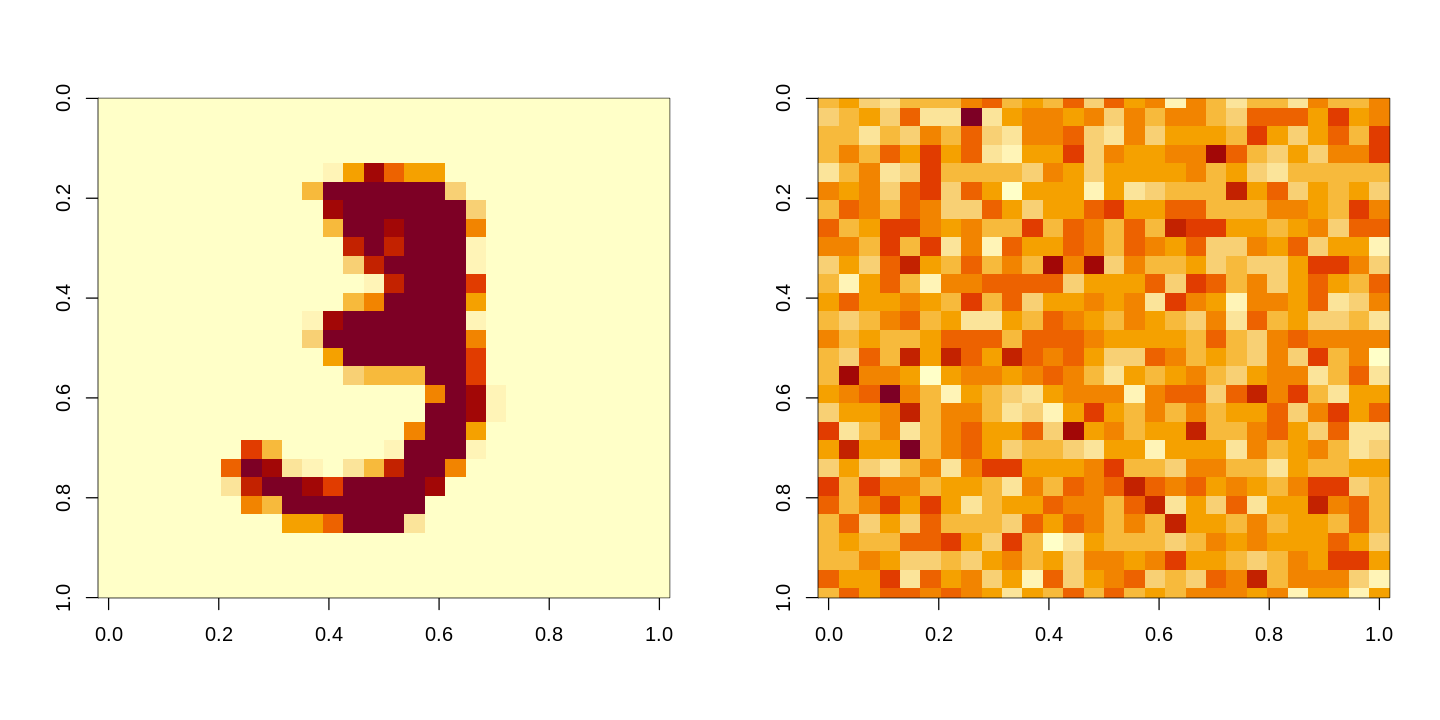

[1] "Epoch 2"
[1] "Training accuracy: 0.7873"
[1] "Validation accuracy: 0.787078707870787"


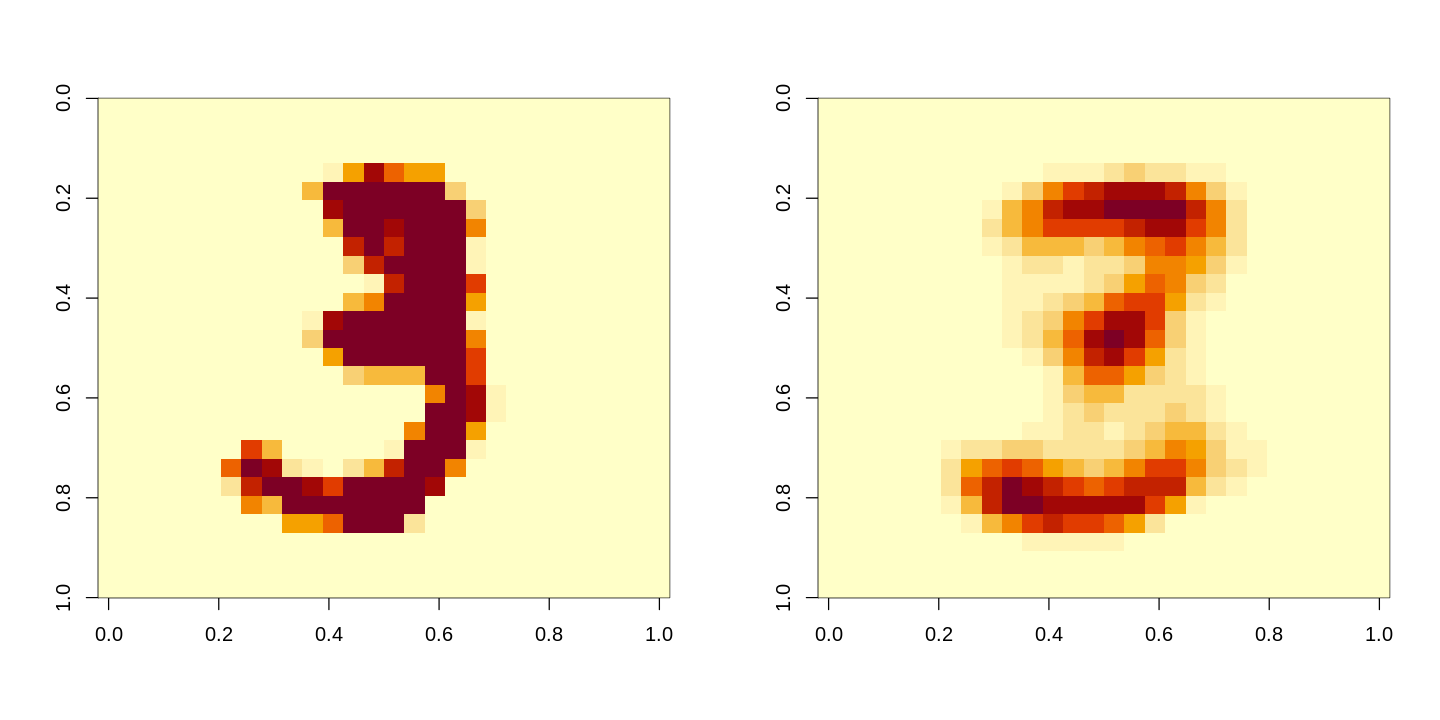

[1] "Epoch 3"
[1] "Training accuracy: 0.8393"
[1] "Validation accuracy: 0.832483248324832"


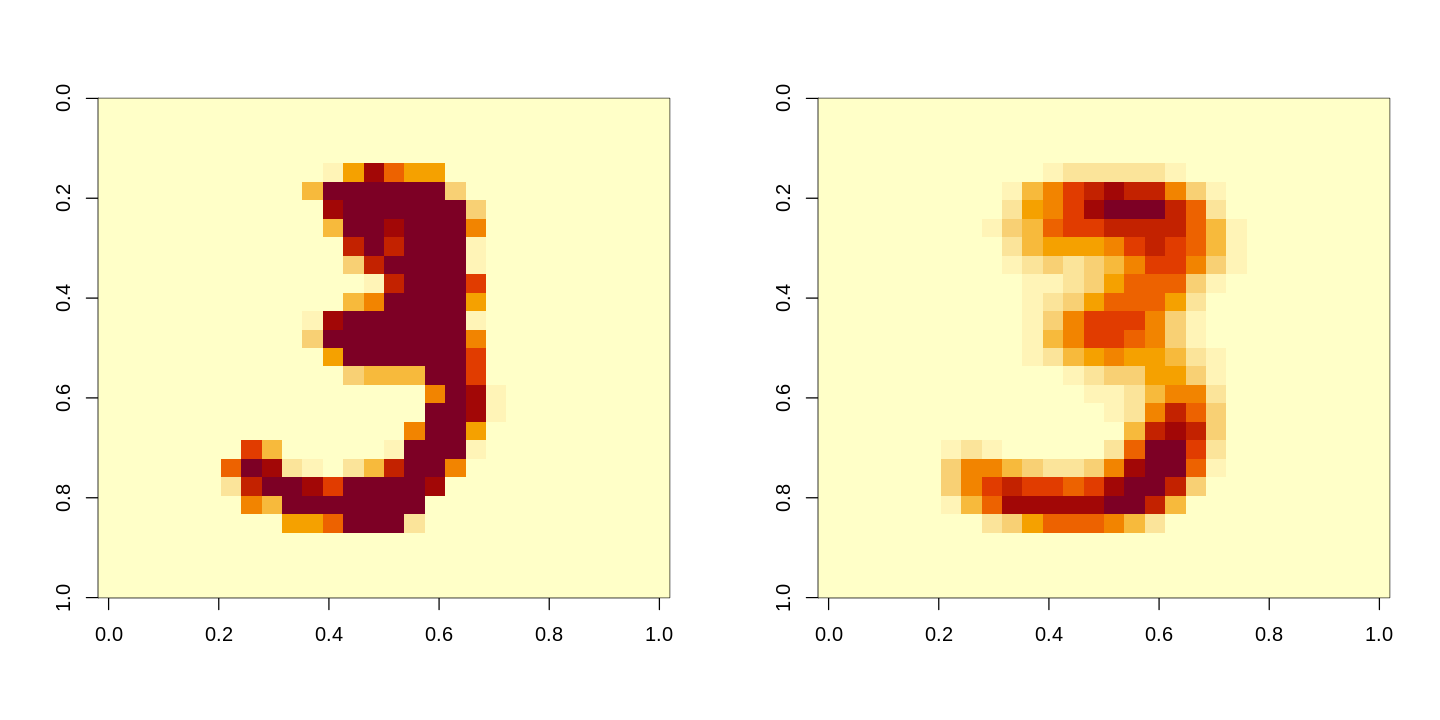

[1] "Epoch 4"
[1] "Training accuracy: 0.8617"
[1] "Validation accuracy: 0.853685368536854"


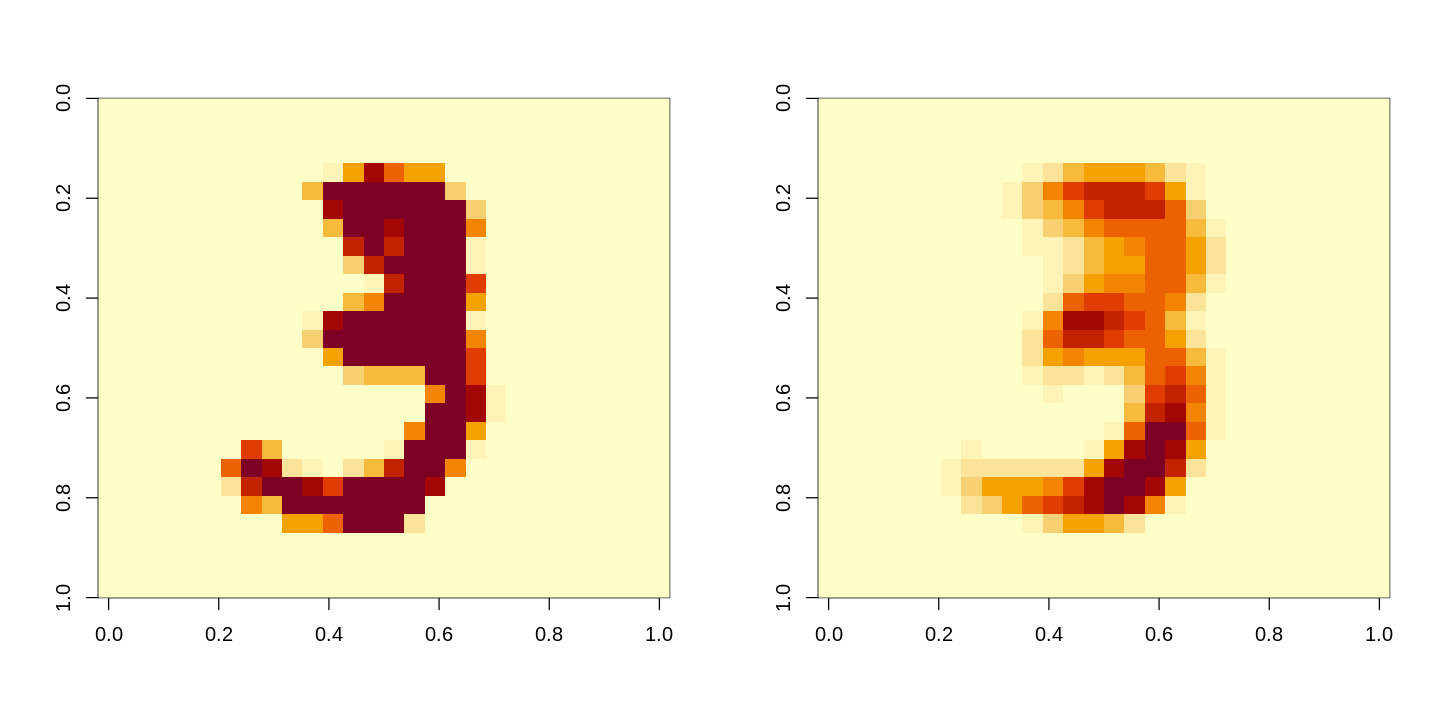

[1] "Epoch 5"
[1] "Training accuracy: 0.8796"
[1] "Validation accuracy: 0.871187118711871"


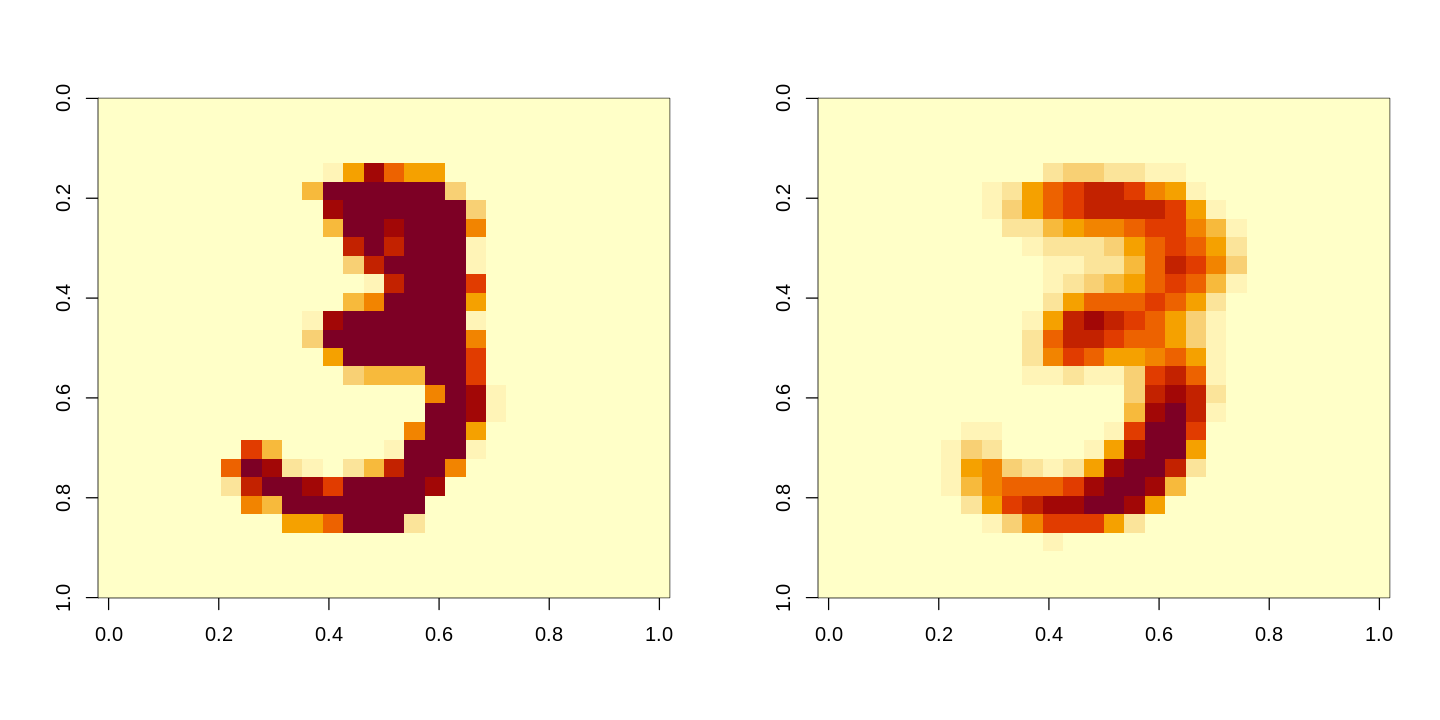

[1] "Epoch 6"
[1] "Training accuracy: 0.888"
[1] "Validation accuracy: 0.878987898789879"


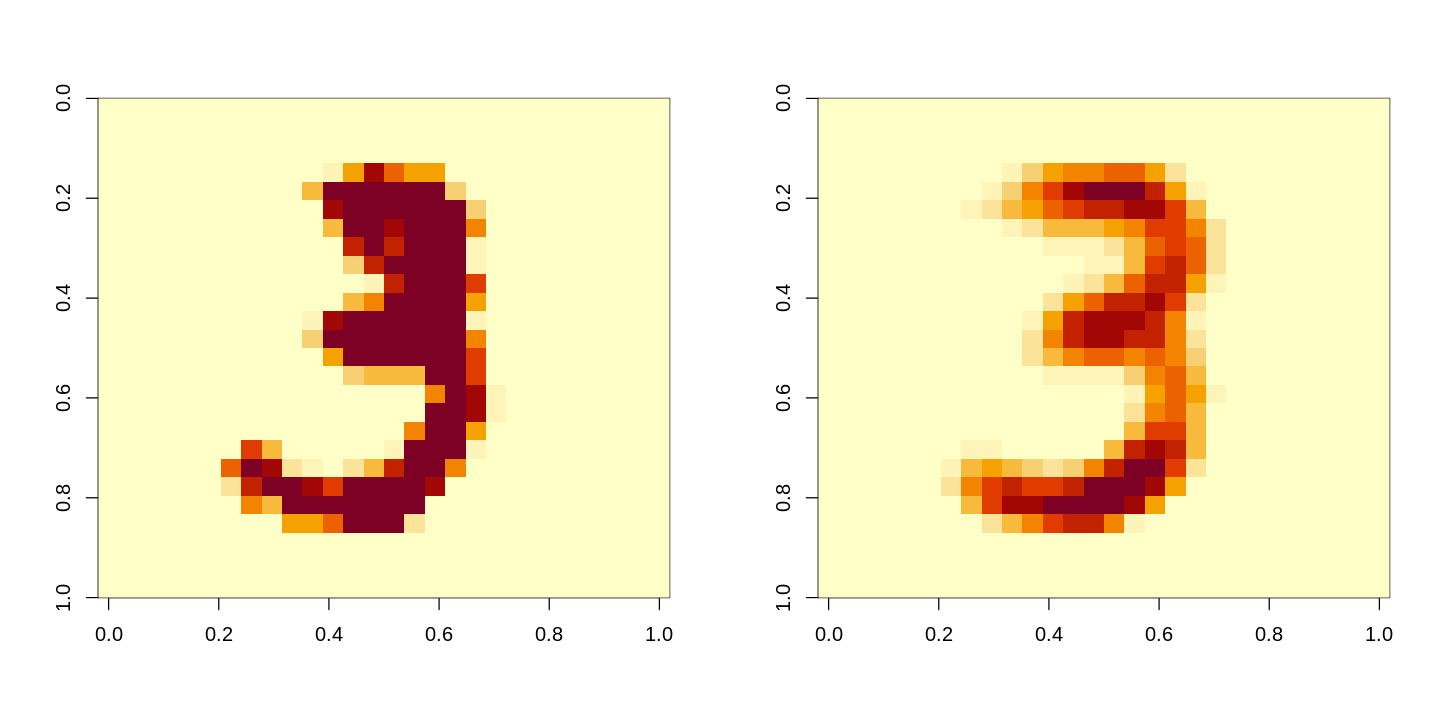

[1] "Epoch 7"
[1] "Training accuracy: 0.8929"
[1] "Validation accuracy: 0.883088308830883"


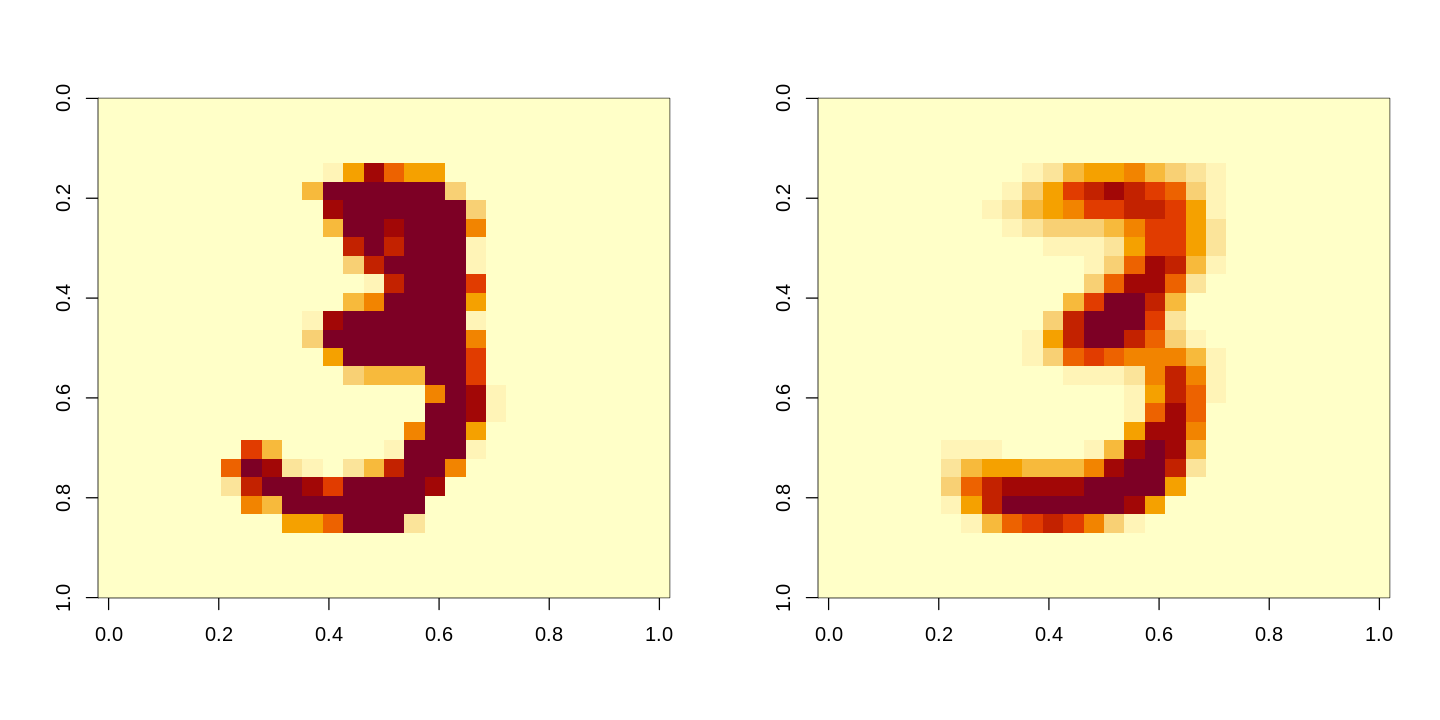

[1] "Epoch 8"
[1] "Training accuracy: 0.8961"
[1] "Validation accuracy: 0.887288728872887"


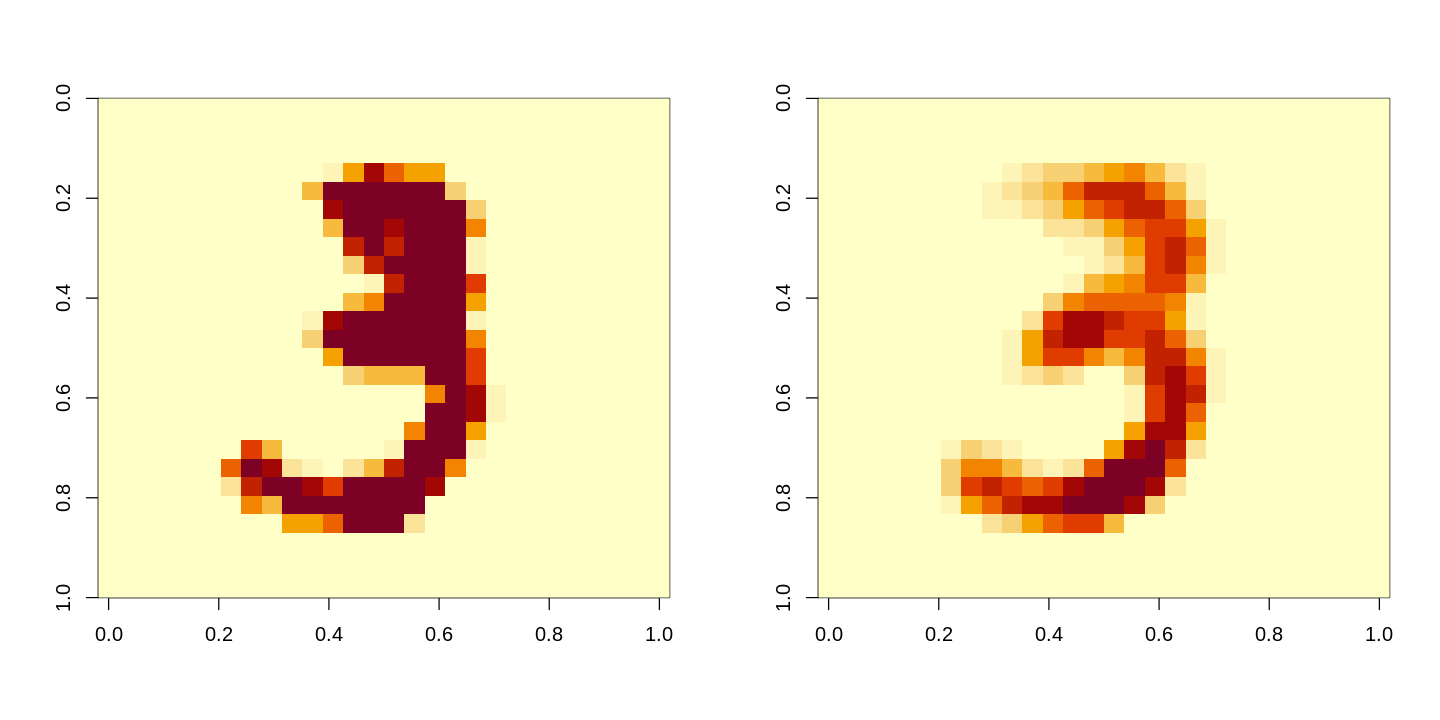

[1] "Epoch 9"
[1] "Training accuracy: 0.896"
[1] "Validation accuracy: 0.886488648864887"


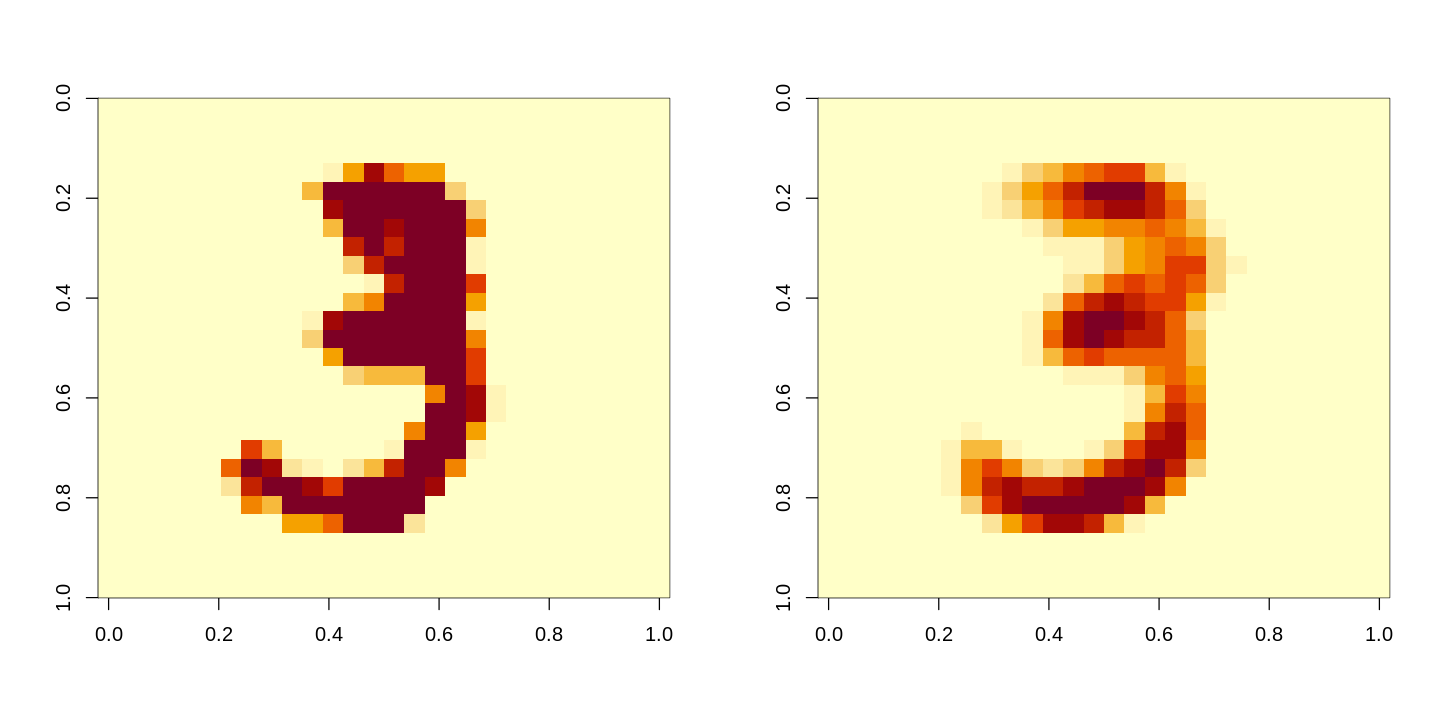

[1] "Epoch 10"
[1] "Training accuracy: 0.9016"
[1] "Validation accuracy: 0.890689068906891"


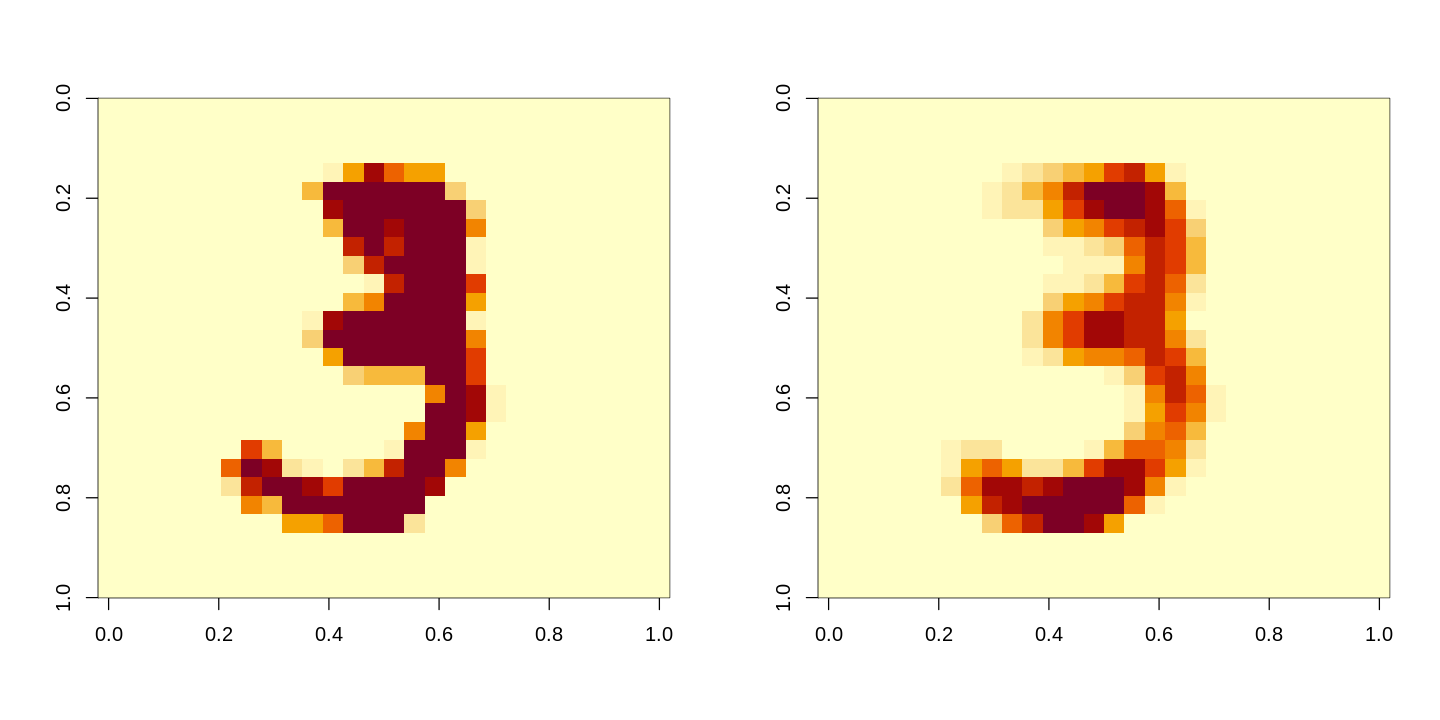

[1] "Epoch 11"
[1] "Training accuracy: 0.9002"
[1] "Validation accuracy: 0.88988898889889"


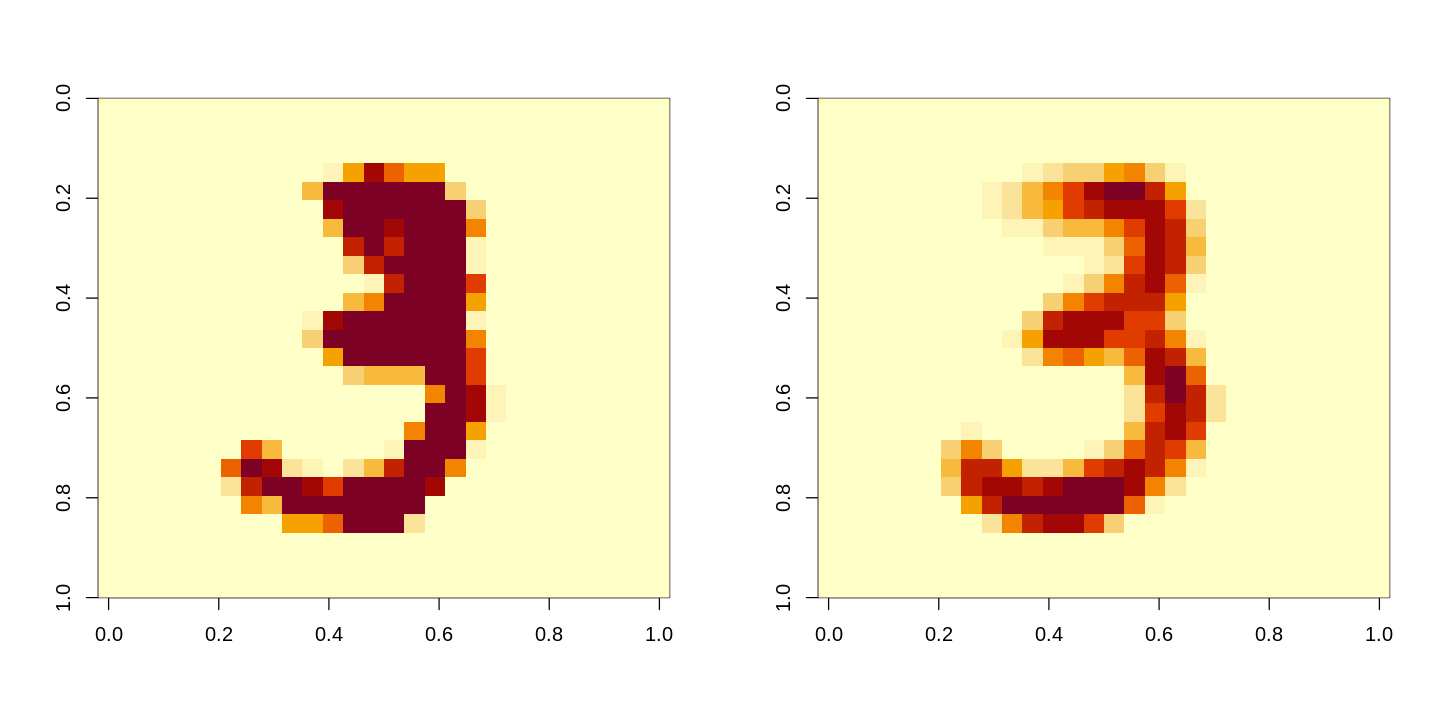

[1] "Epoch 12"
[1] "Training accuracy: 0.903"
[1] "Validation accuracy: 0.889488948894889"


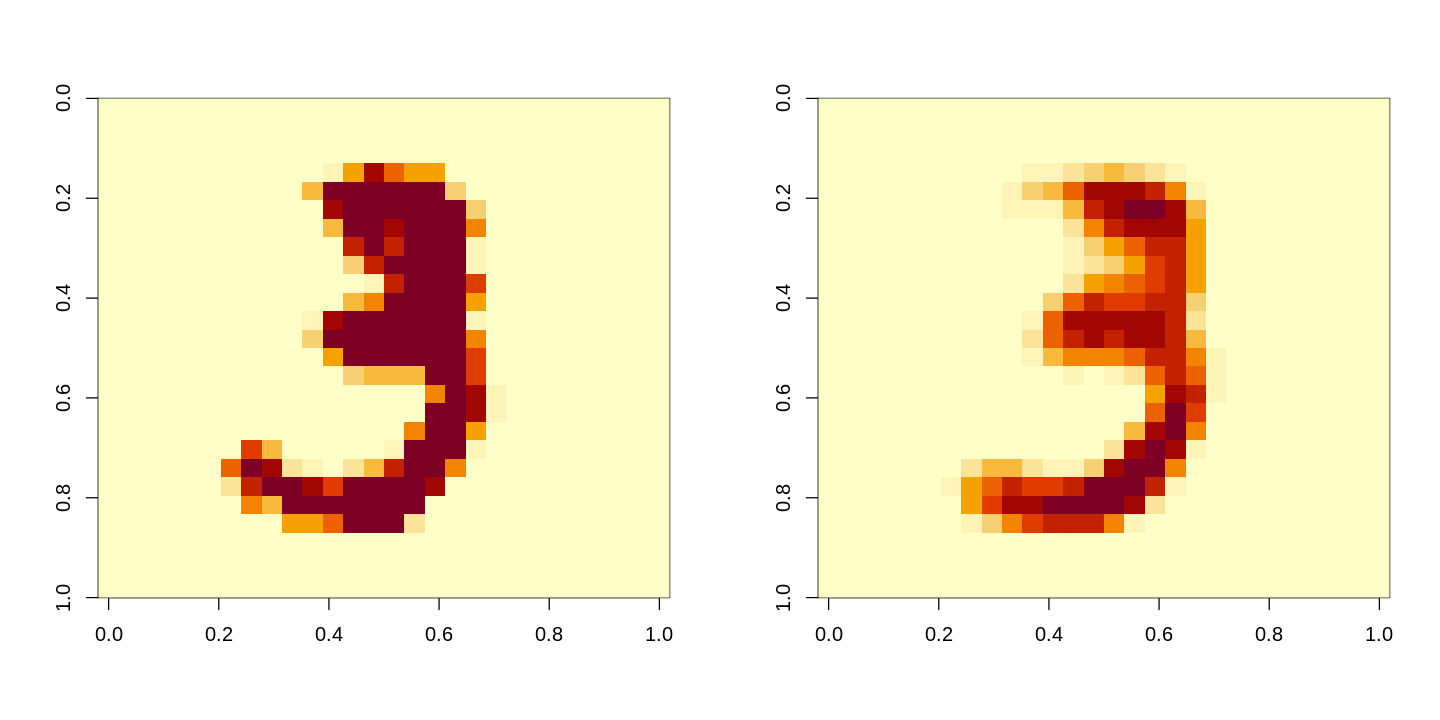

[1] "Epoch 13"
[1] "Training accuracy: 0.9058"
[1] "Validation accuracy: 0.892789278927893"


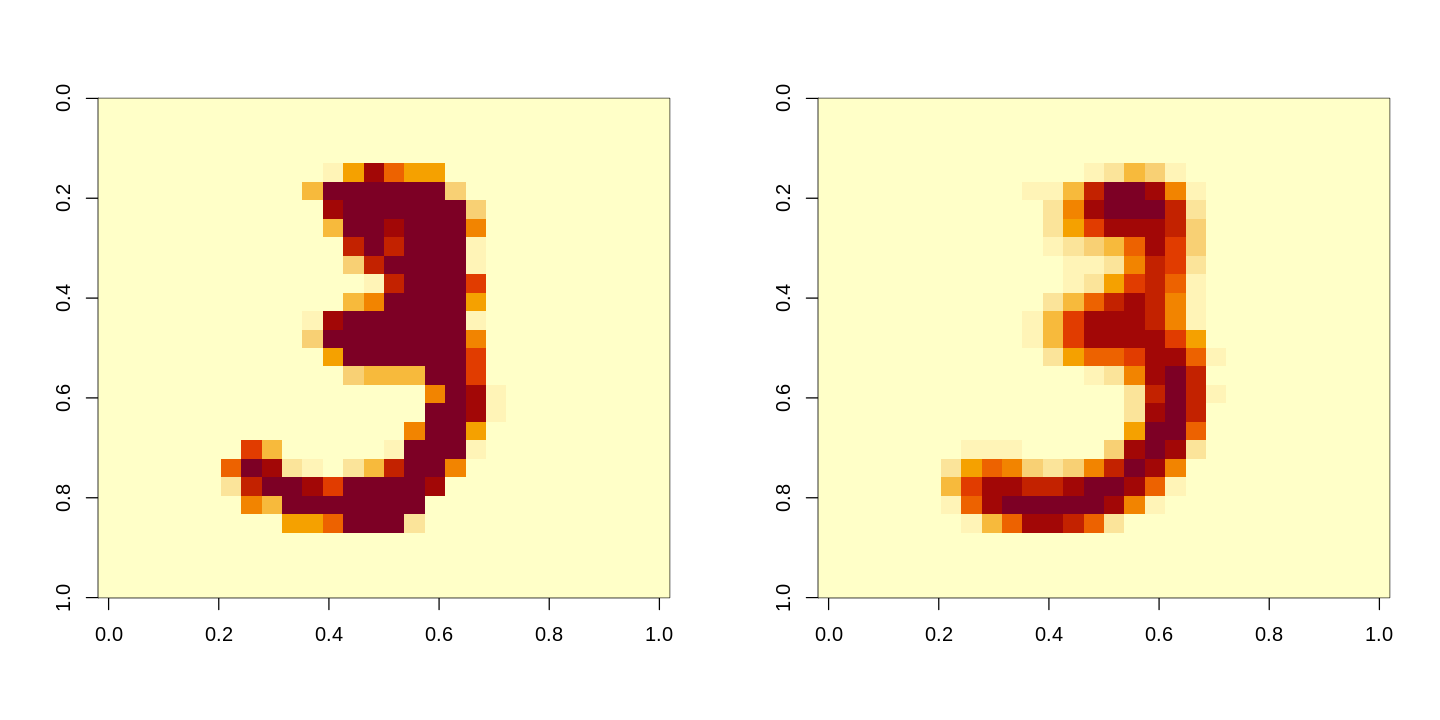

[1] "Epoch 14"
[1] "Training accuracy: 0.908"
[1] "Validation accuracy: 0.893189318931893"


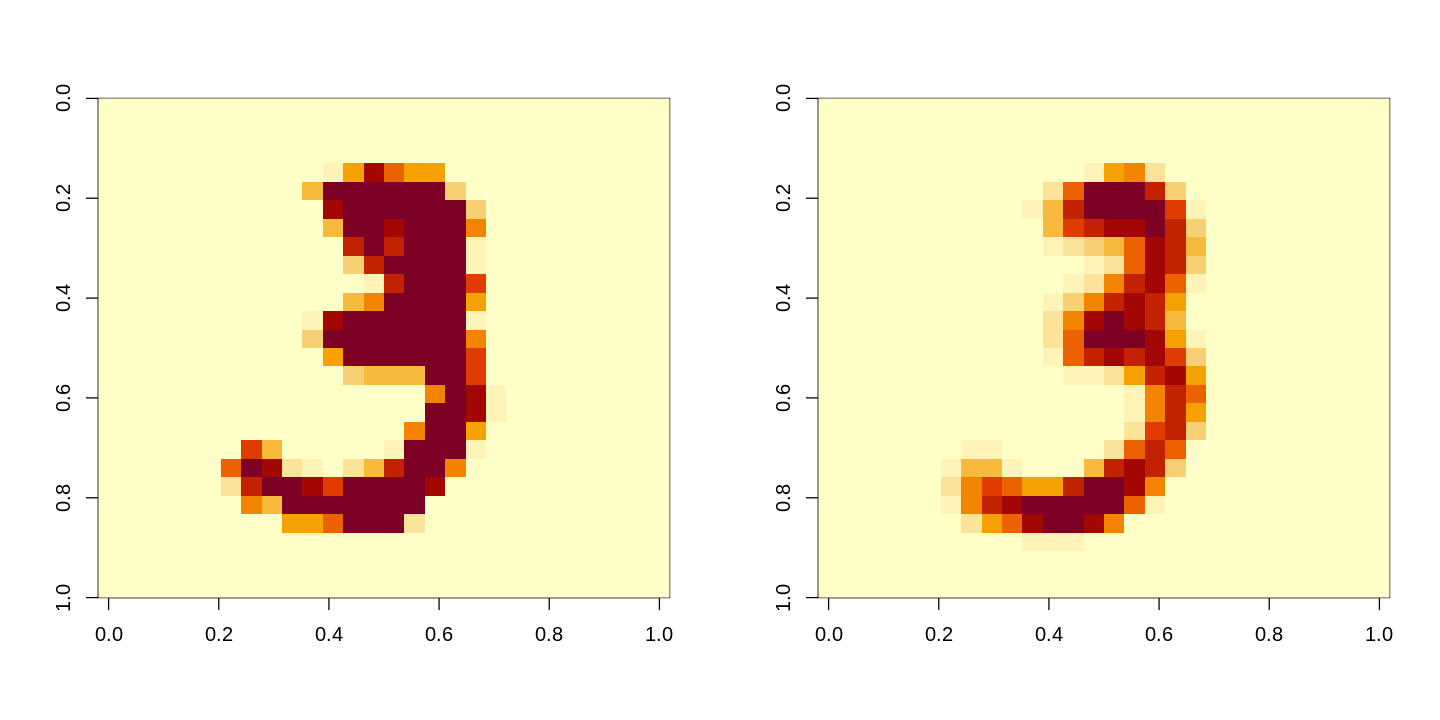

[1] "Epoch 15"
[1] "Training accuracy: 0.9093"
[1] "Validation accuracy: 0.893989398939894"


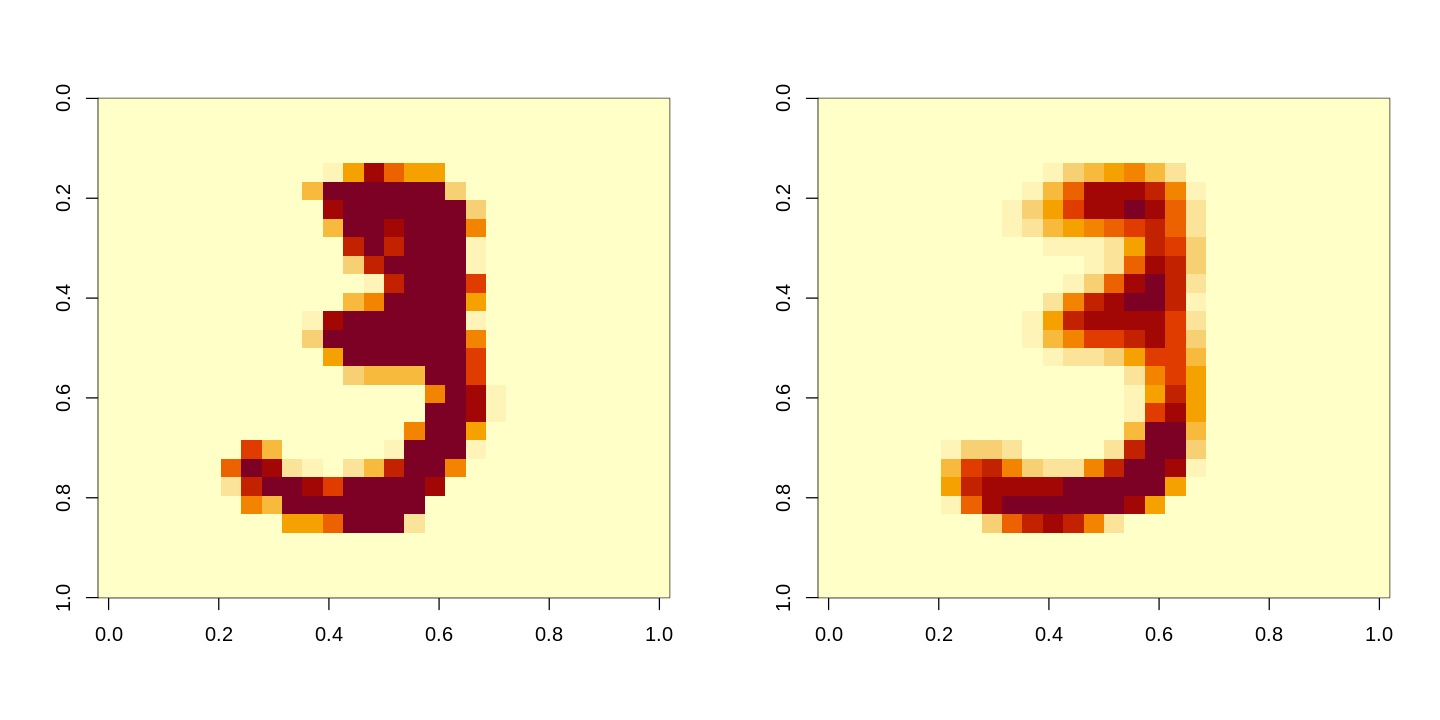

[1] "Epoch 16"
[1] "Training accuracy: 0.9092"
[1] "Validation accuracy: 0.895189518951895"


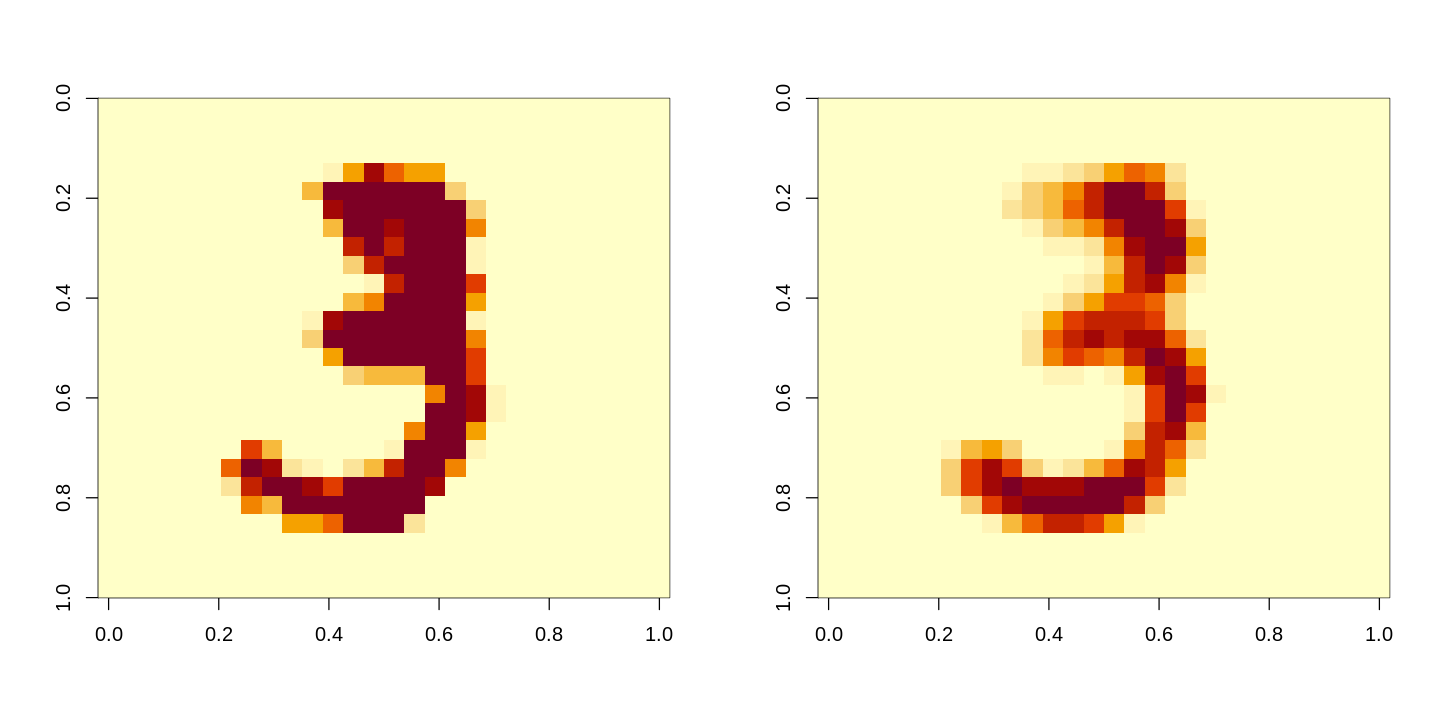

[1] "Epoch 17"
[1] "Training accuracy: 0.9114"
[1] "Validation accuracy: 0.896089608960896"


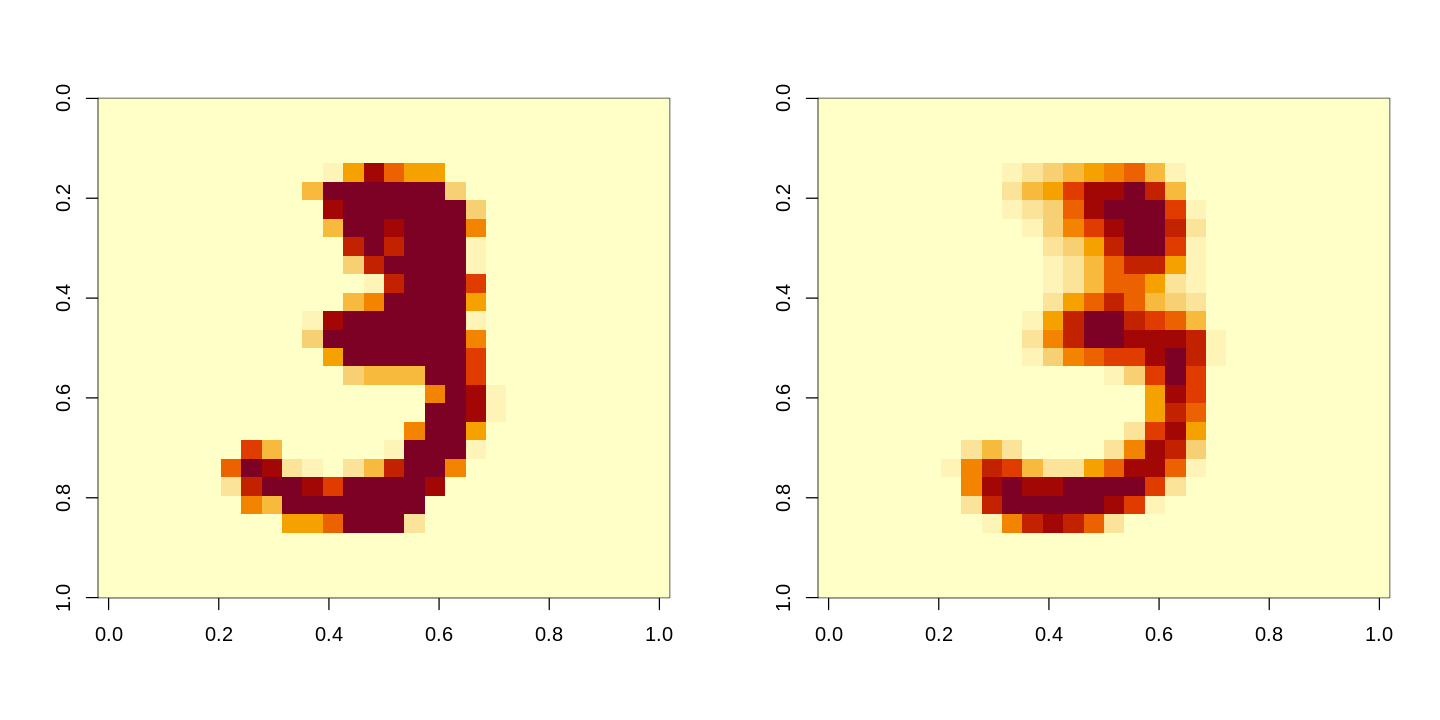

[1] "Epoch 18"
[1] "Training accuracy: 0.9099"
[1] "Validation accuracy: 0.897689768976898"


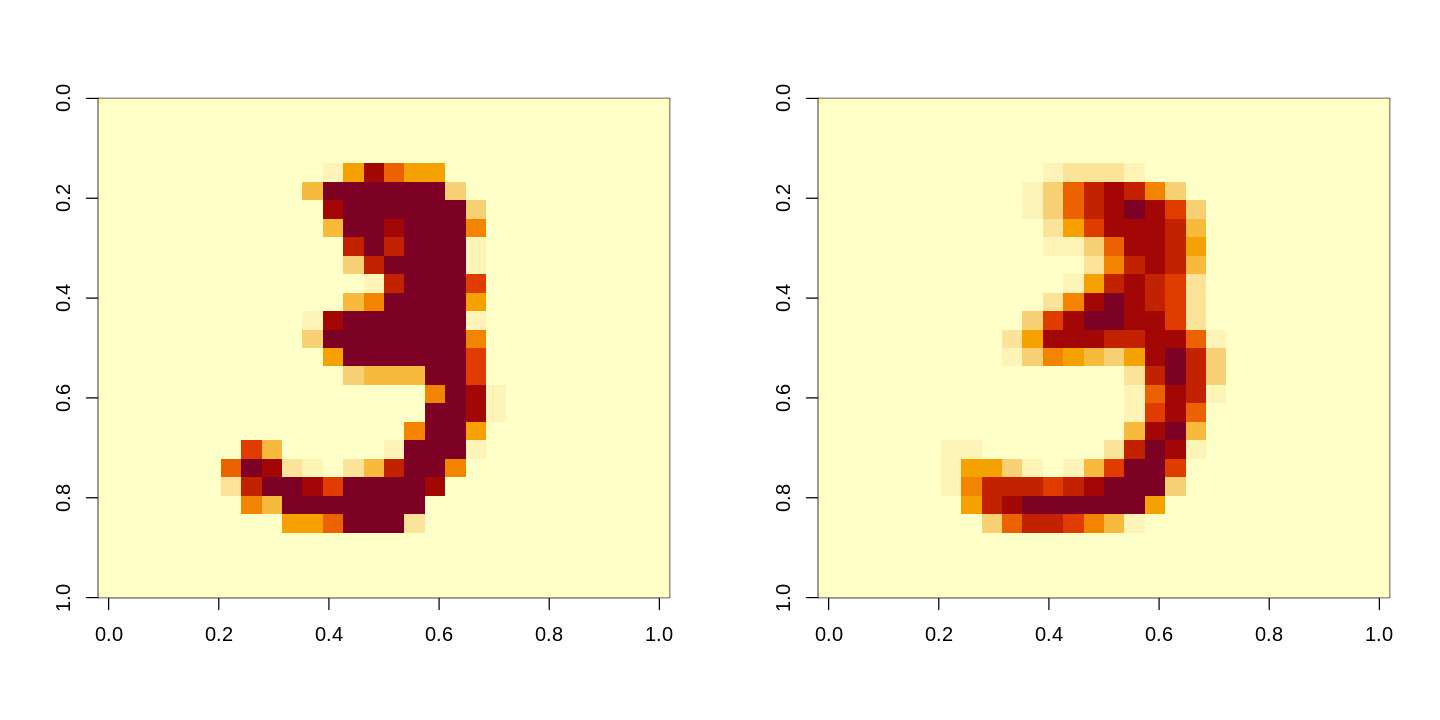

[1] "Epoch 19"
[1] "Training accuracy: 0.908"
[1] "Validation accuracy: 0.893889388938894"


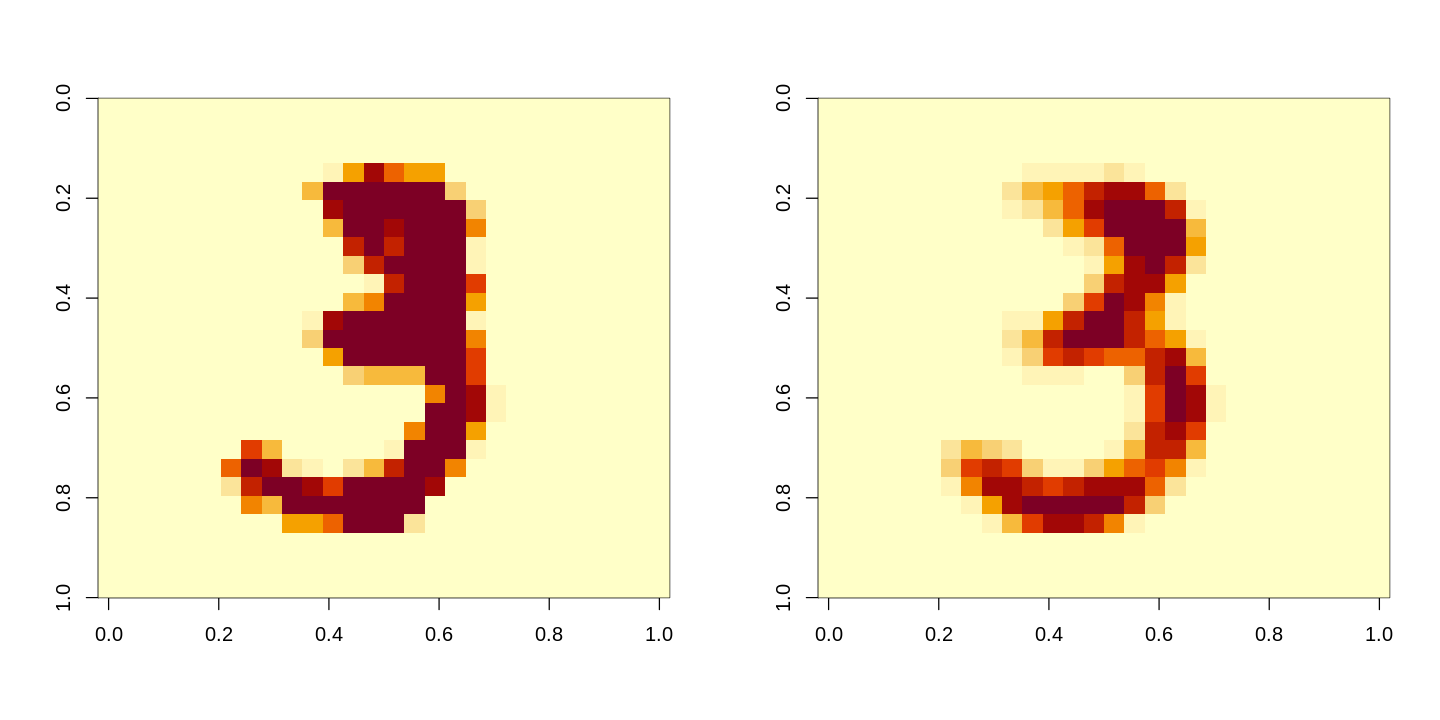

[1] "Epoch 20"
[1] "Training accuracy: 0.9095"
[1] "Validation accuracy: 0.894689468946895"


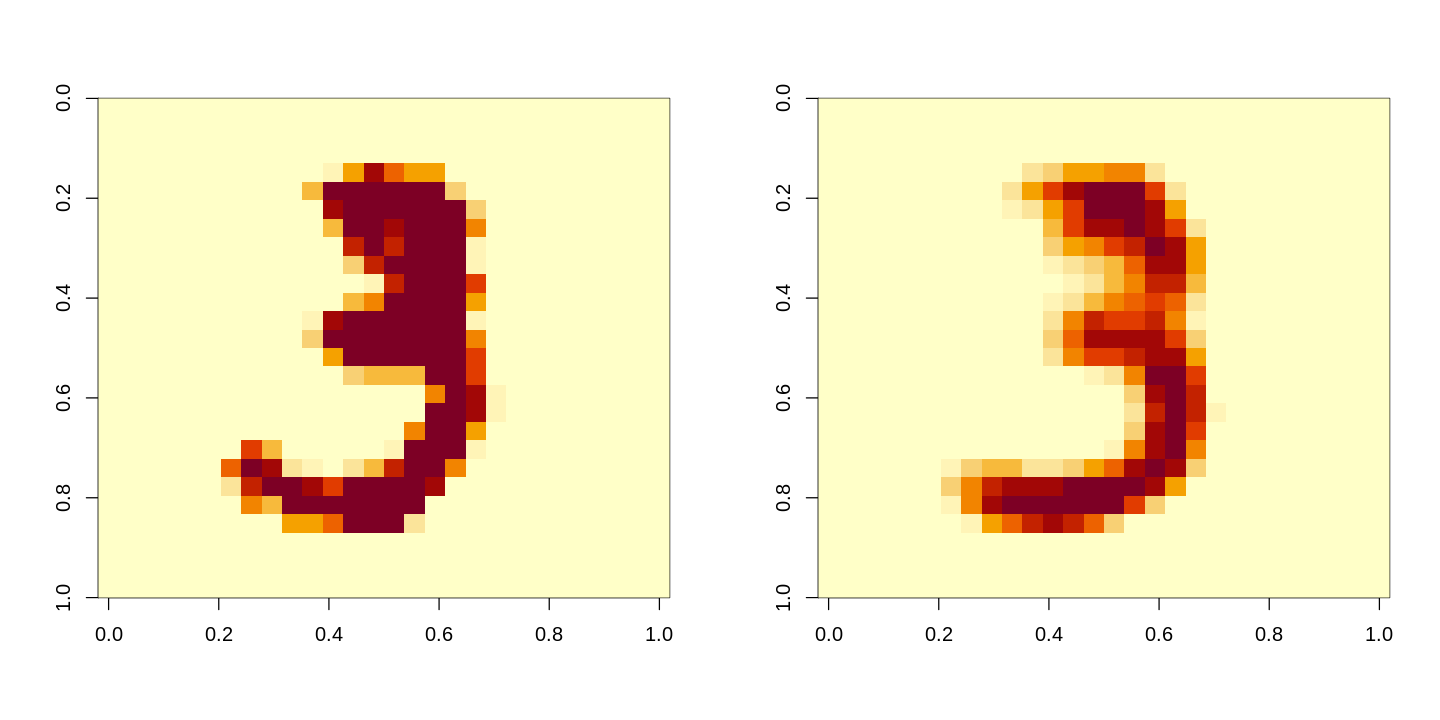

[1] "Epoch 21"
[1] "Training accuracy: 0.9109"
[1] "Validation accuracy: 0.895689568956896"


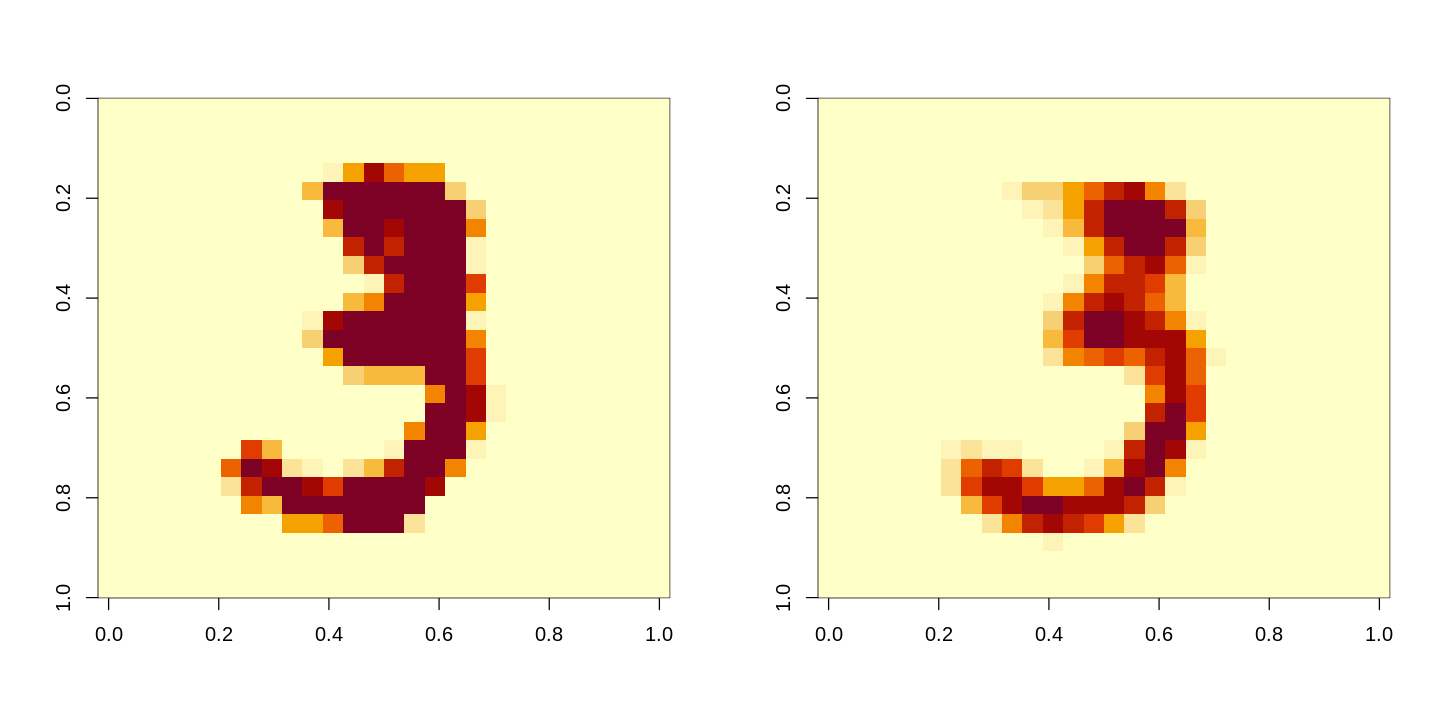

[1] "Epoch 22"
[1] "Training accuracy: 0.9124"
[1] "Validation accuracy: 0.897389738973897"


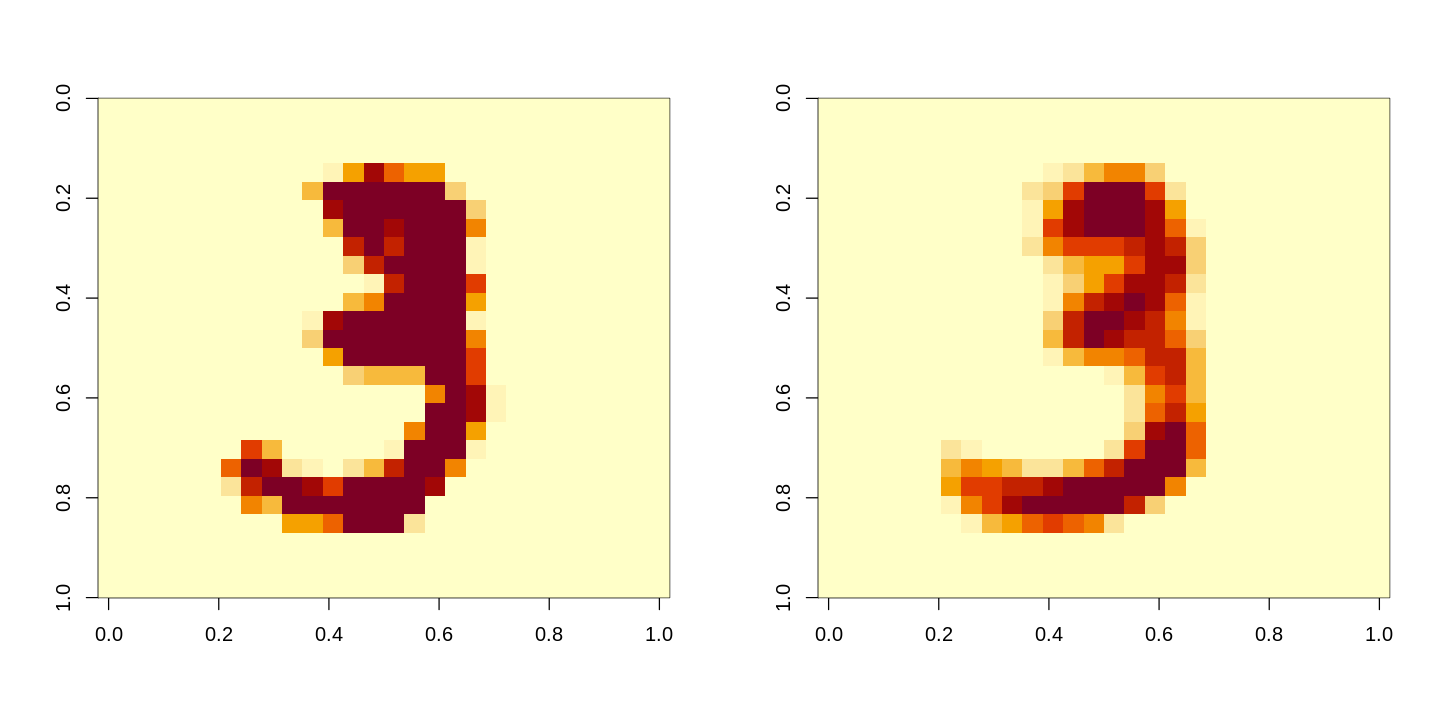

[1] "Epoch 23"
[1] "Training accuracy: 0.914"
[1] "Validation accuracy: 0.899089908990899"


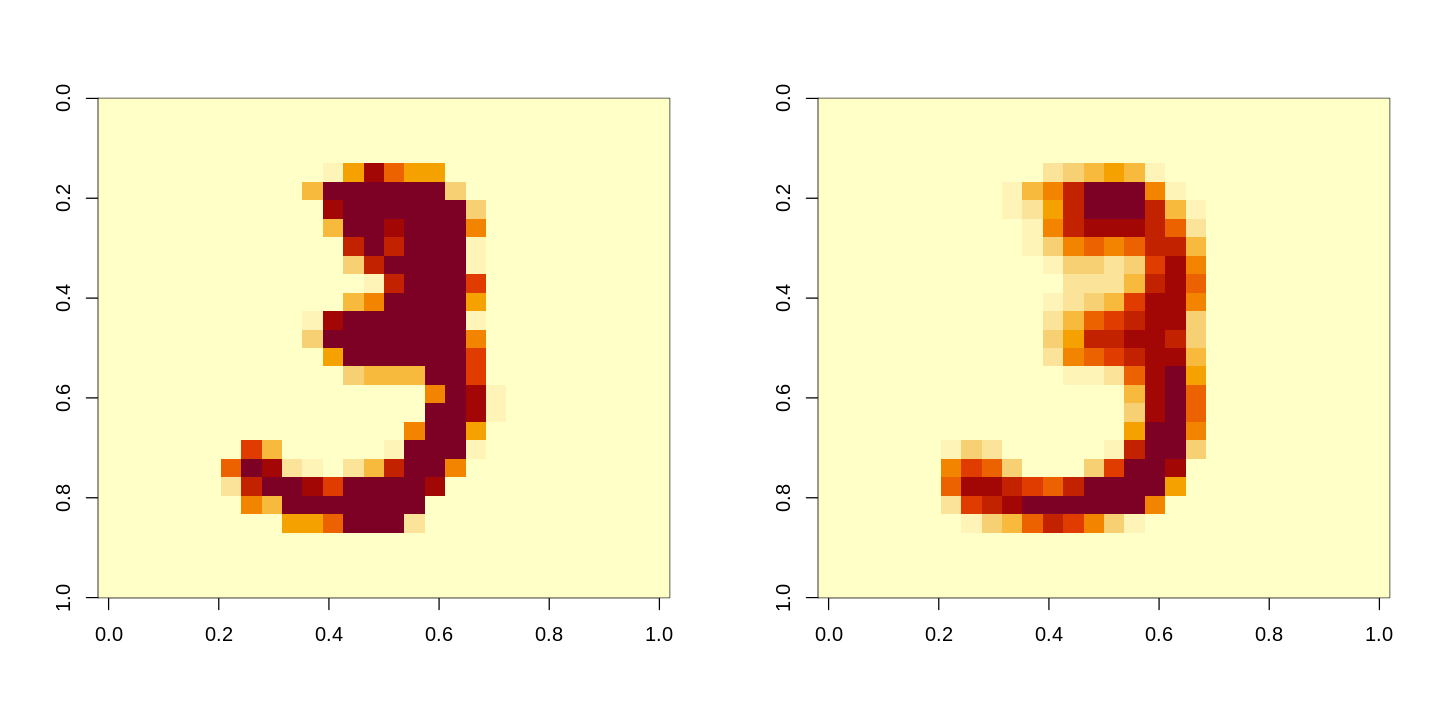

[1] "Epoch 24"
[1] "Training accuracy: 0.9121"
[1] "Validation accuracy: 0.898189818981898"


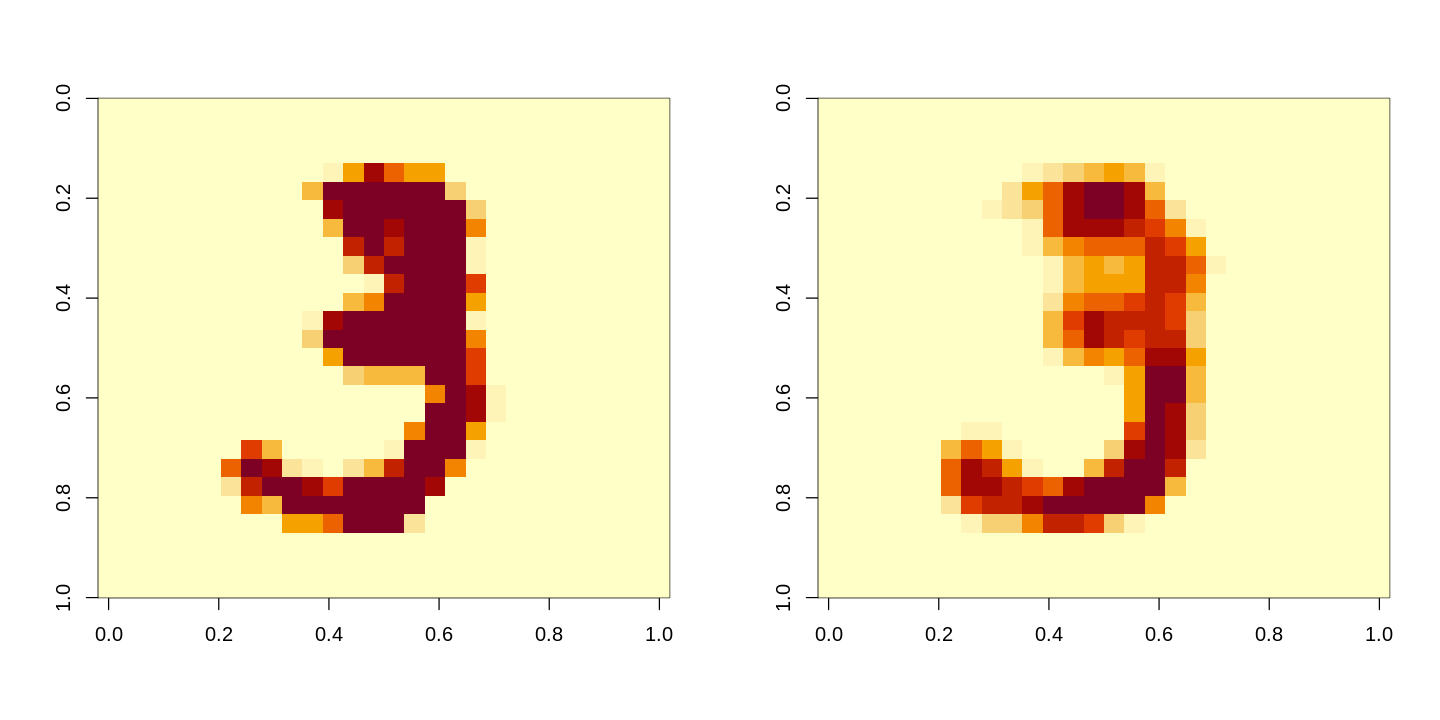

[1] "Epoch 25"
[1] "Training accuracy: 0.9135"
[1] "Validation accuracy: 0.8995899589959"


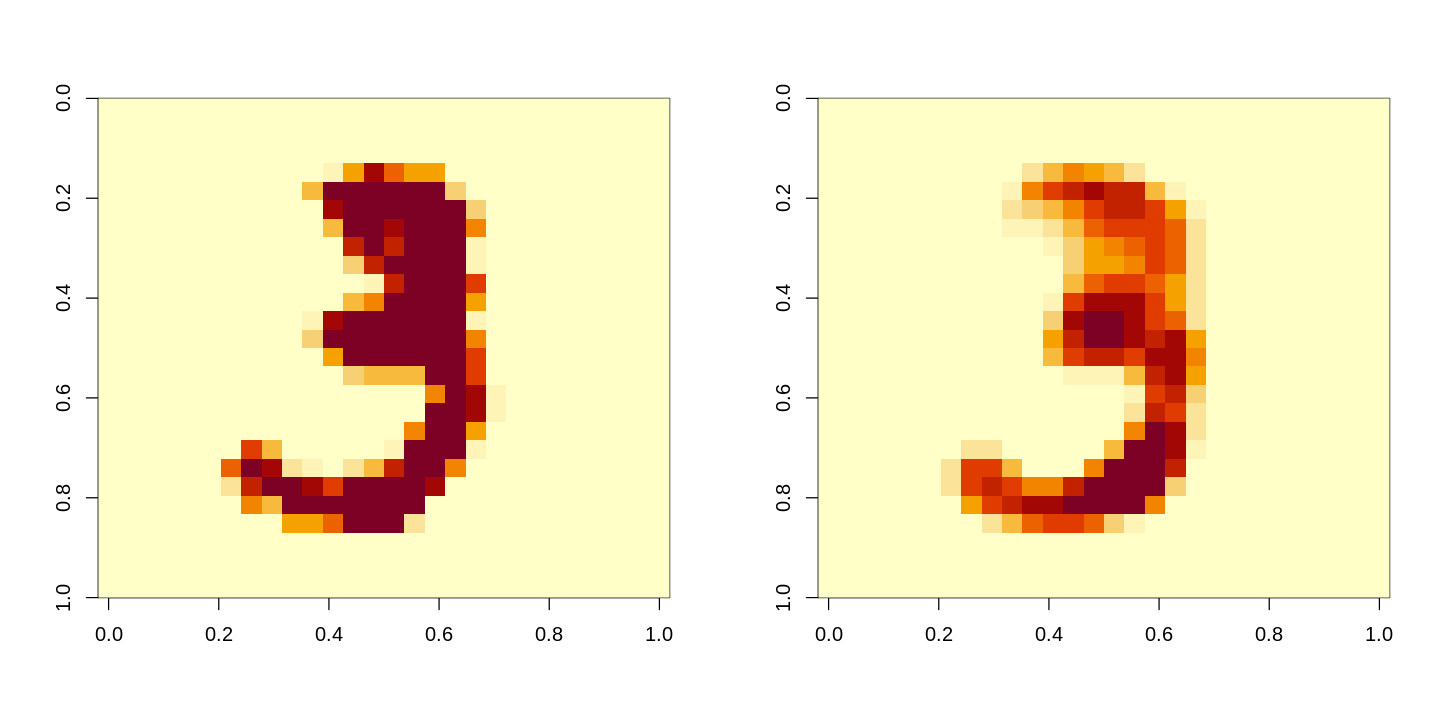

[1] "Epoch 26"
[1] "Training accuracy: 0.9137"
[1] "Validation accuracy: 0.900790079007901"


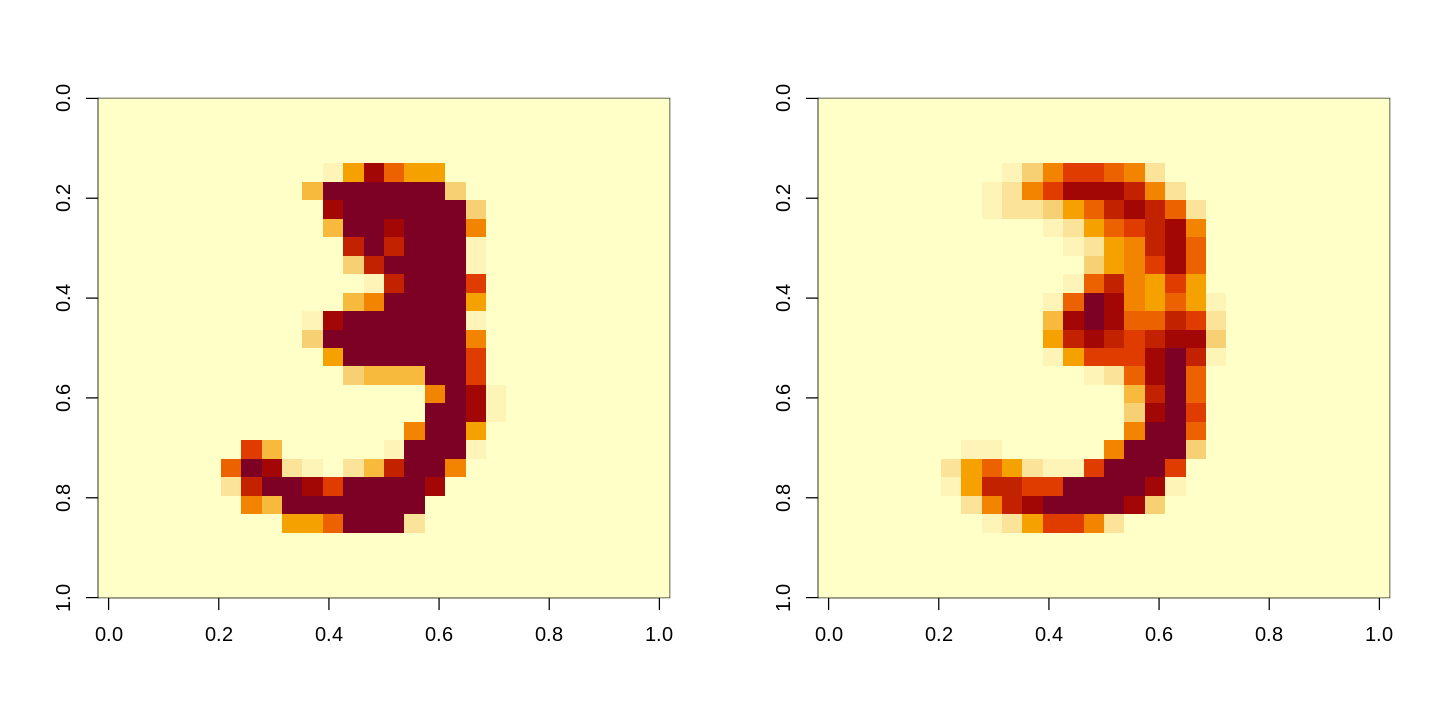

[1] "Epoch 27"
[1] "Training accuracy: 0.9124"
[1] "Validation accuracy: 0.8997899789979"


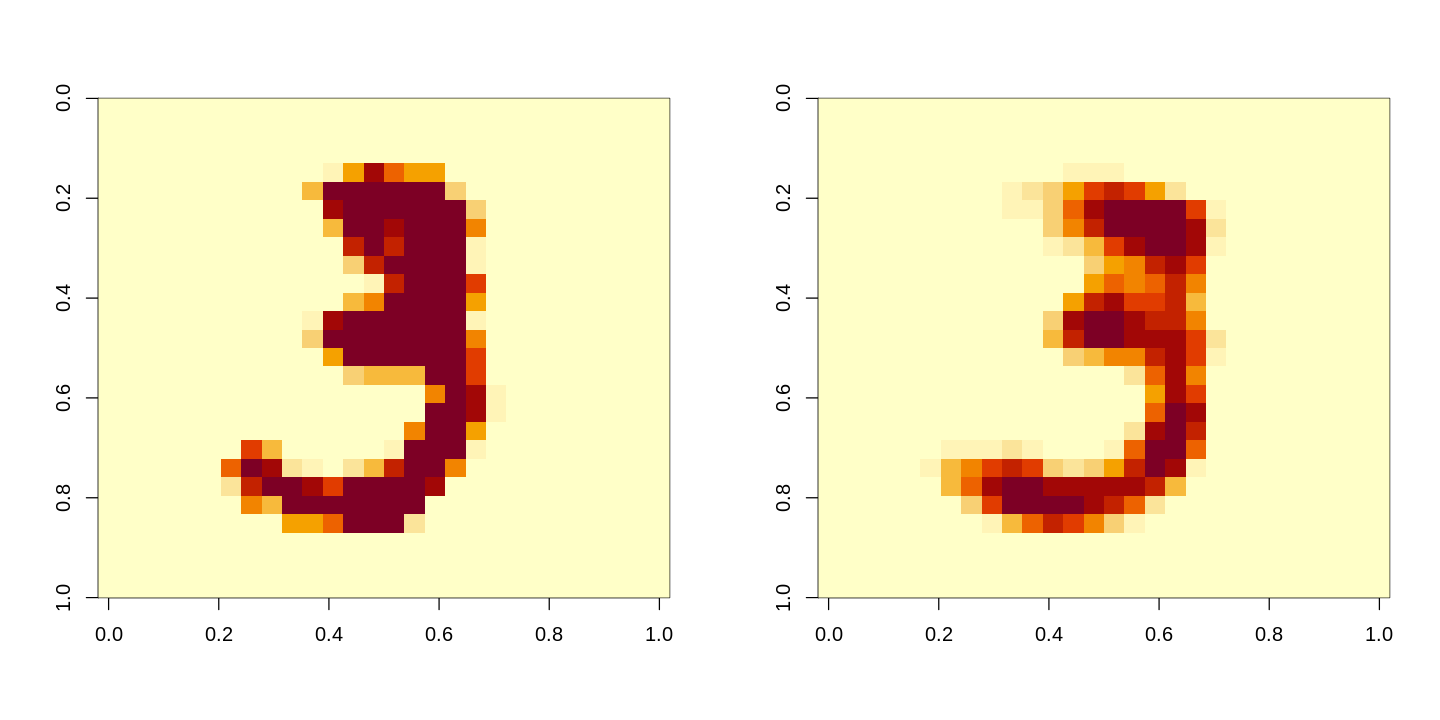

[1] "Epoch 28"
[1] "Training accuracy: 0.9139"
[1] "Validation accuracy: 0.901990199019902"


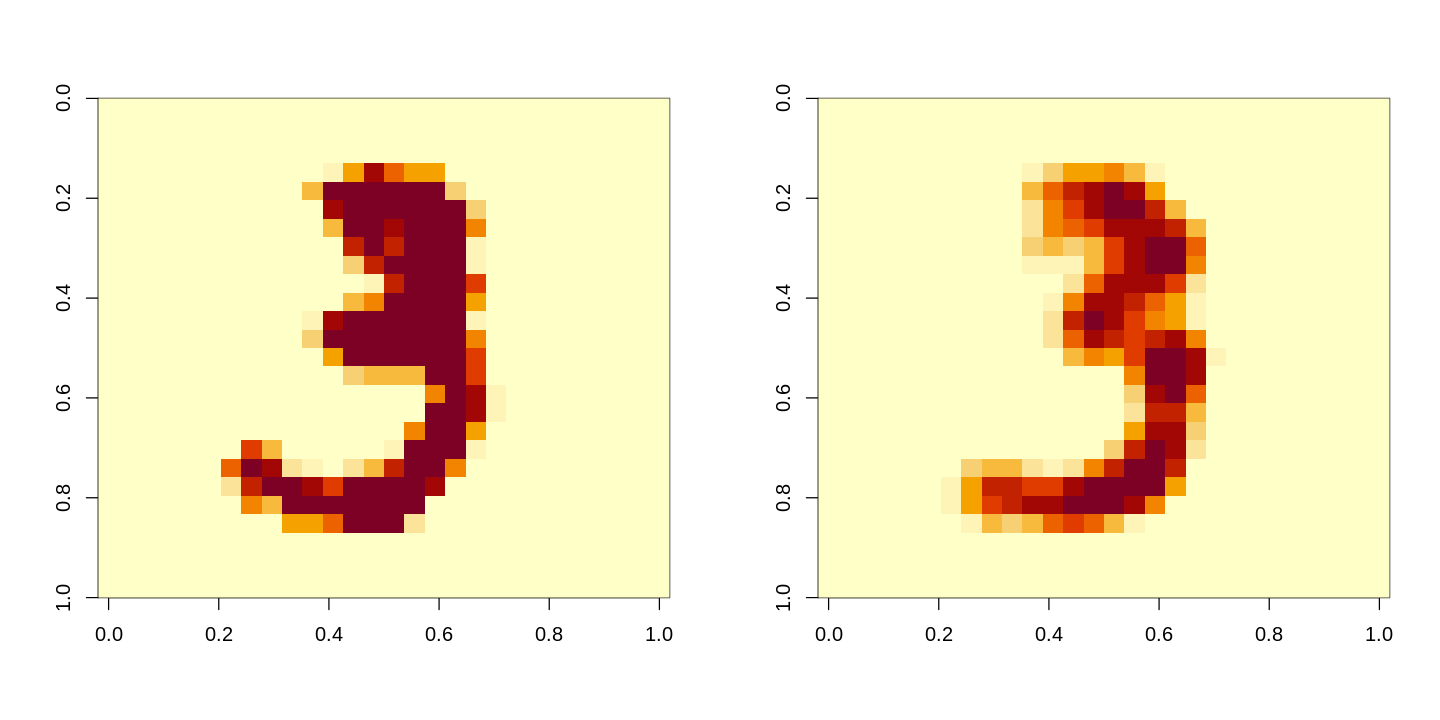

[1] "Epoch 29"
[1] "Training accuracy: 0.9138"
[1] "Validation accuracy: 0.8994899489949"


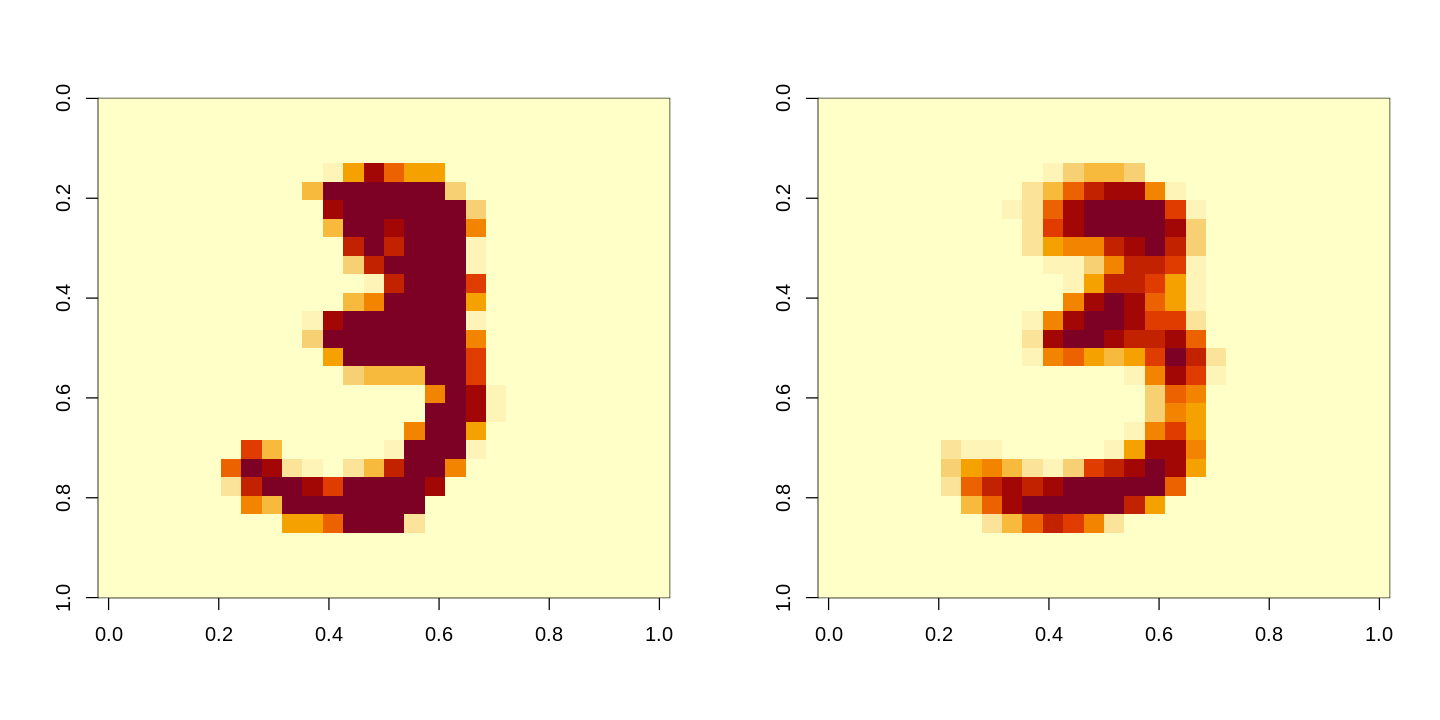

[1] "Epoch 30"
[1] "Training accuracy: 0.9158"
[1] "Validation accuracy: 0.903190319031903"


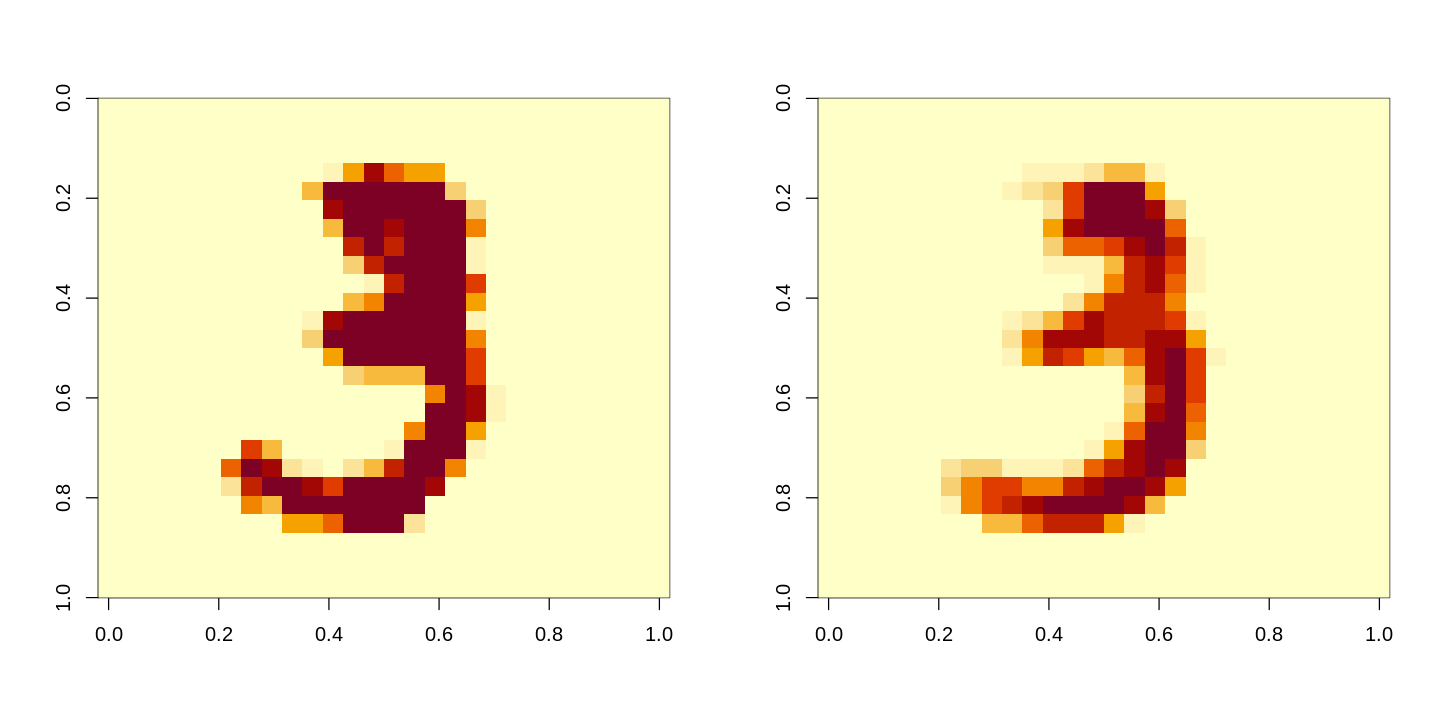

[1] "Epoch 31"
[1] "Training accuracy: 0.911"
[1] "Validation accuracy: 0.9002900290029"


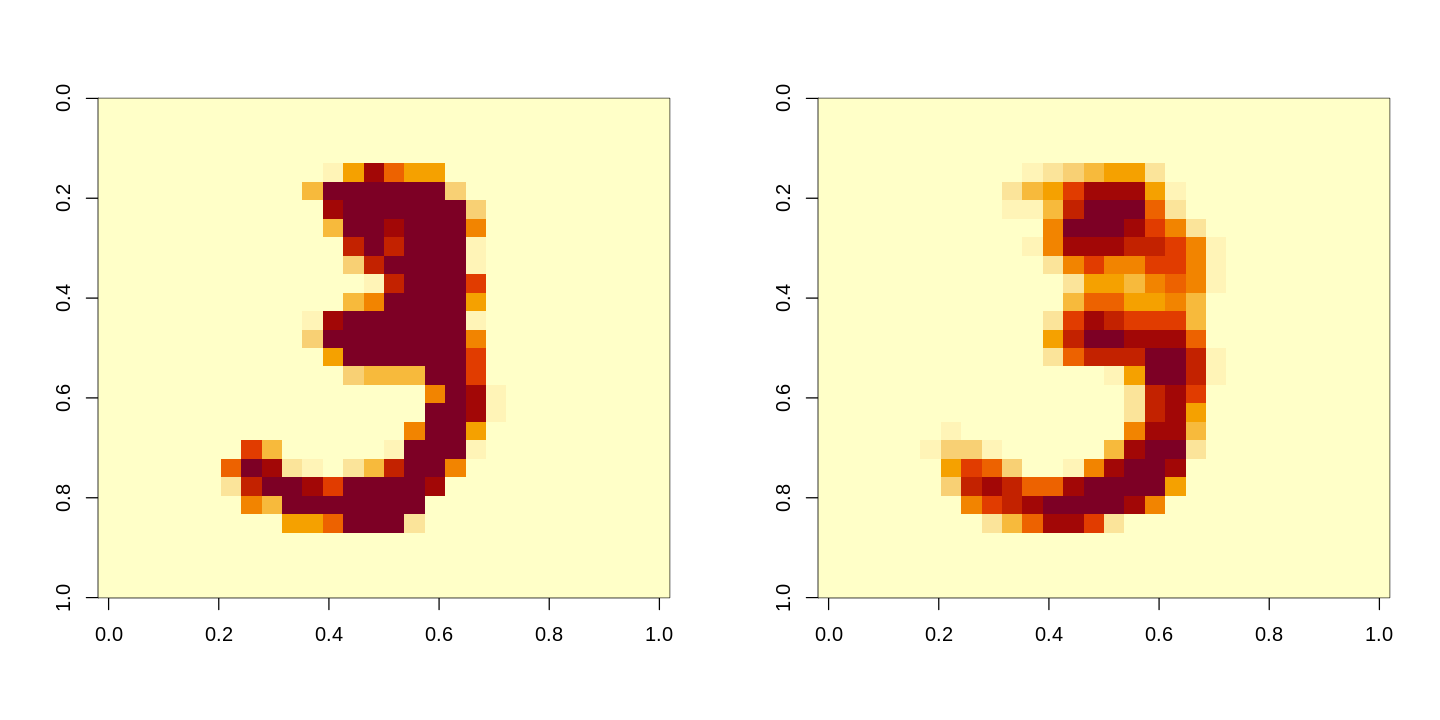

[1] "Epoch 32"
[1] "Training accuracy: 0.915"
[1] "Validation accuracy: 0.903890389038904"


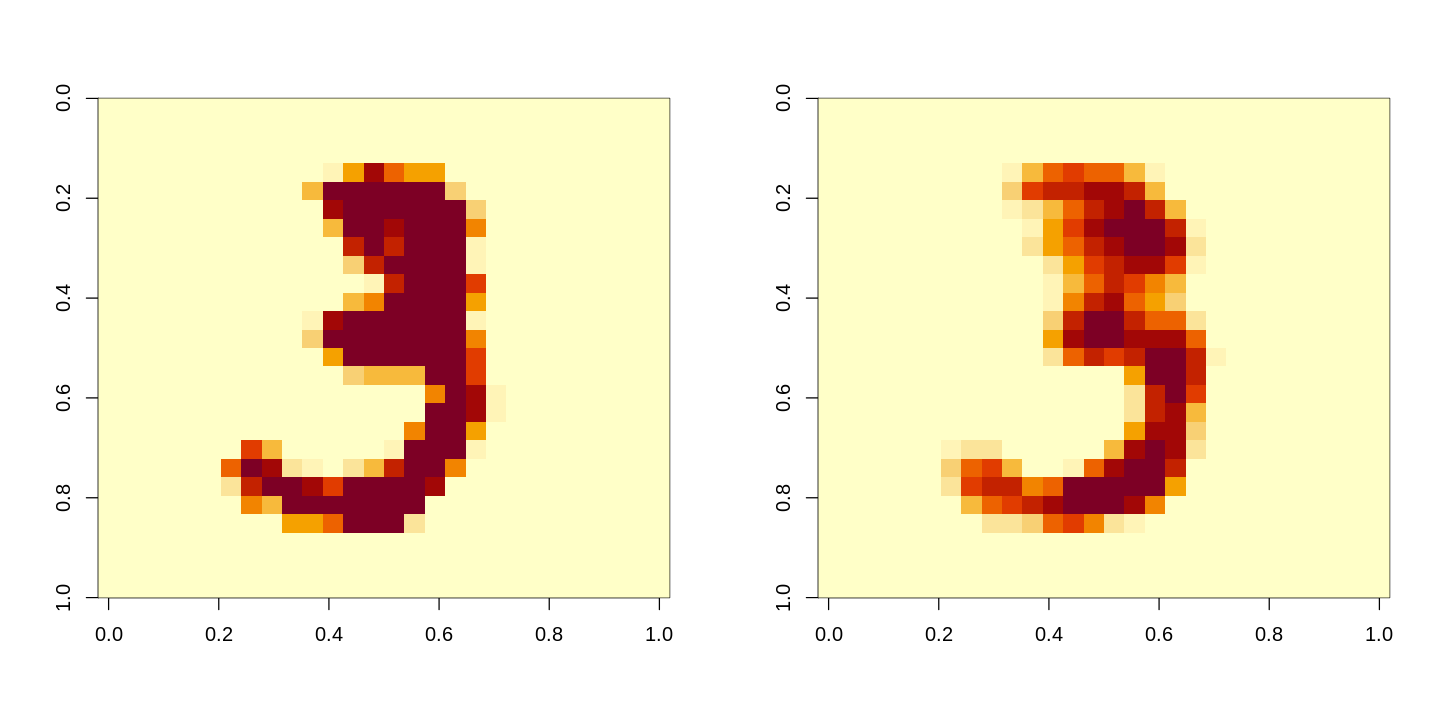

[1] "Epoch 33"
[1] "Training accuracy: 0.9171"
[1] "Validation accuracy: 0.905390539053905"


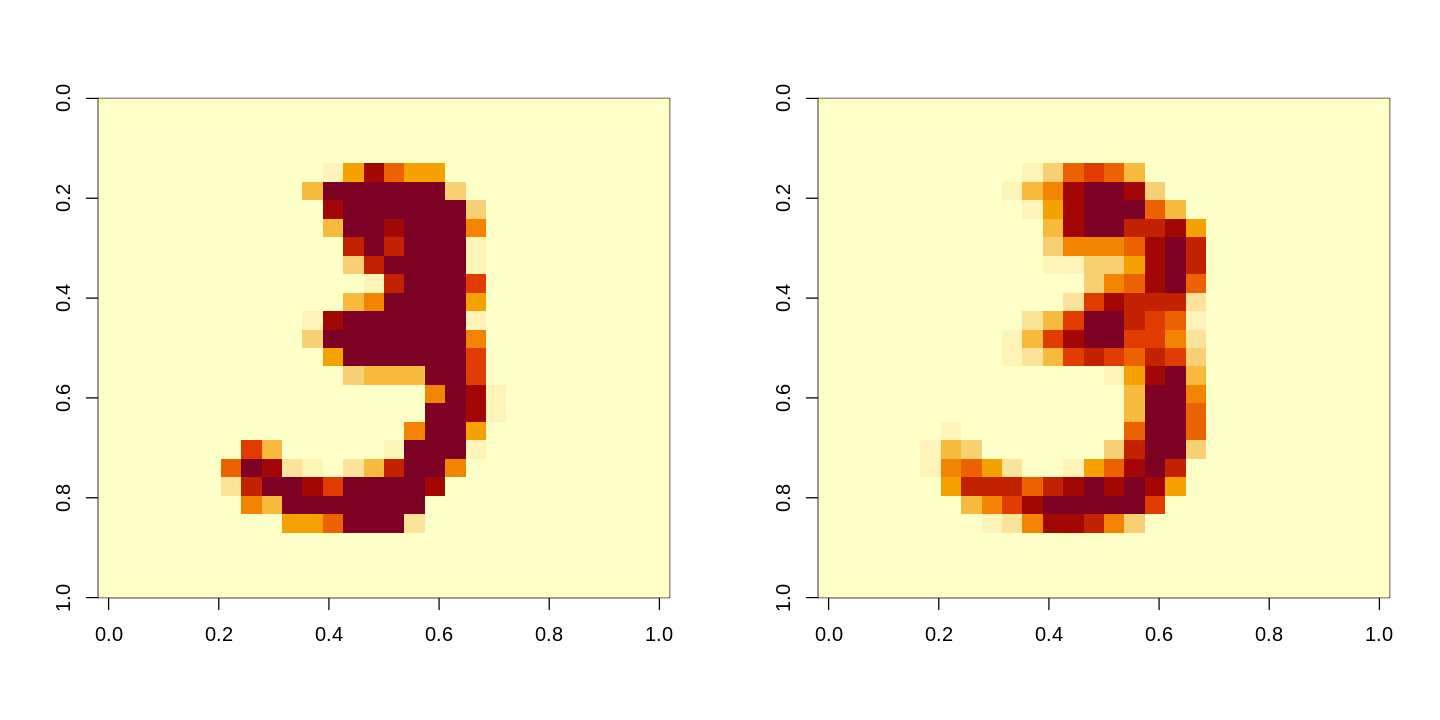

[1] "Epoch 34"
[1] "Training accuracy: 0.9152"
[1] "Validation accuracy: 0.902590259025903"


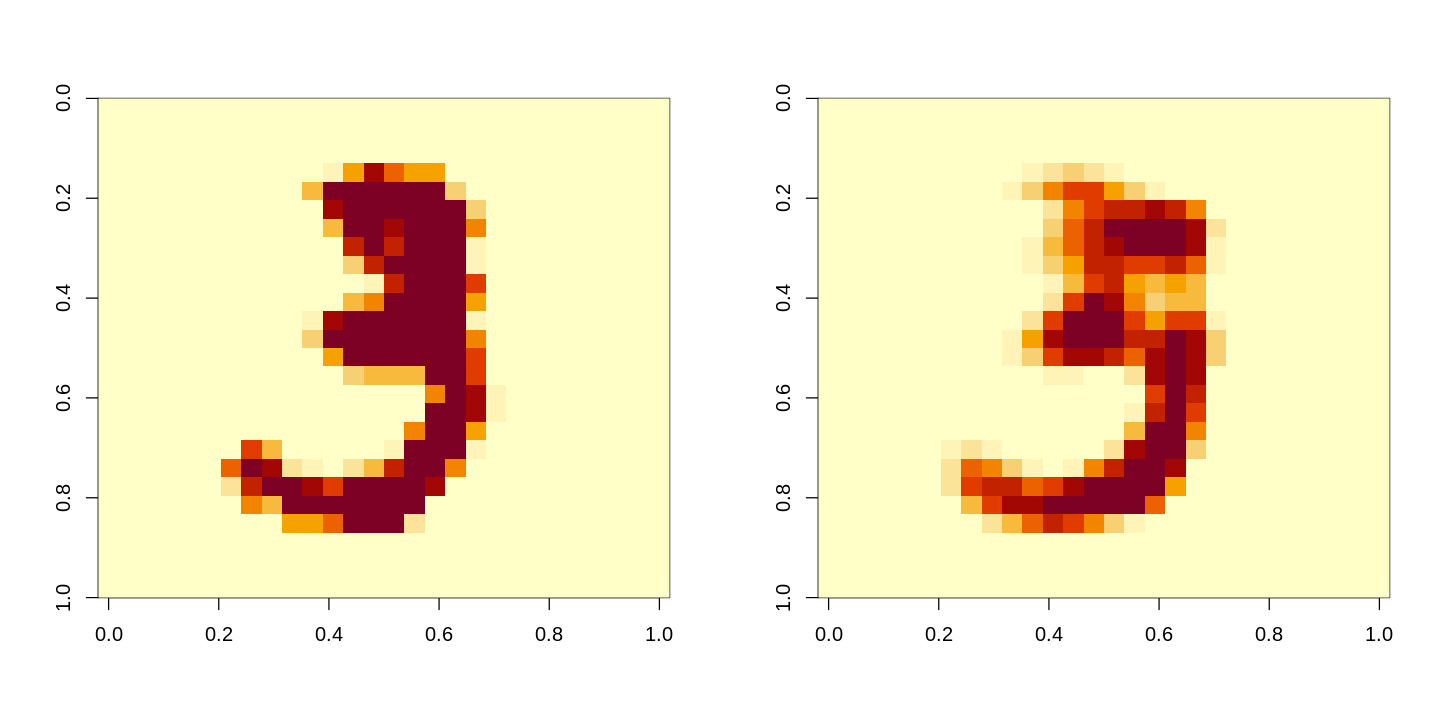

[1] "Epoch 35"
[1] "Training accuracy: 0.9174"
[1] "Validation accuracy: 0.904490449044904"


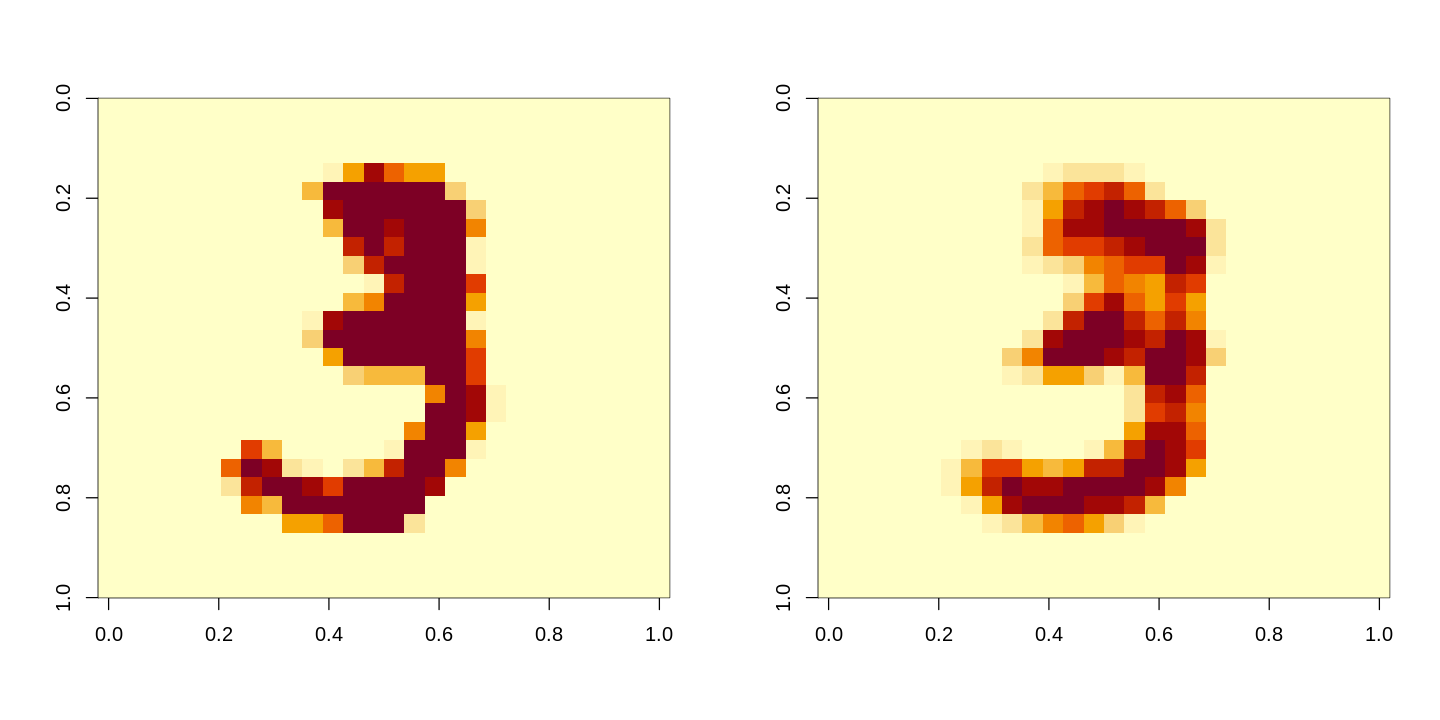

[1] "Epoch 36"
[1] "Training accuracy: 0.9157"
[1] "Validation accuracy: 0.904090409040904"


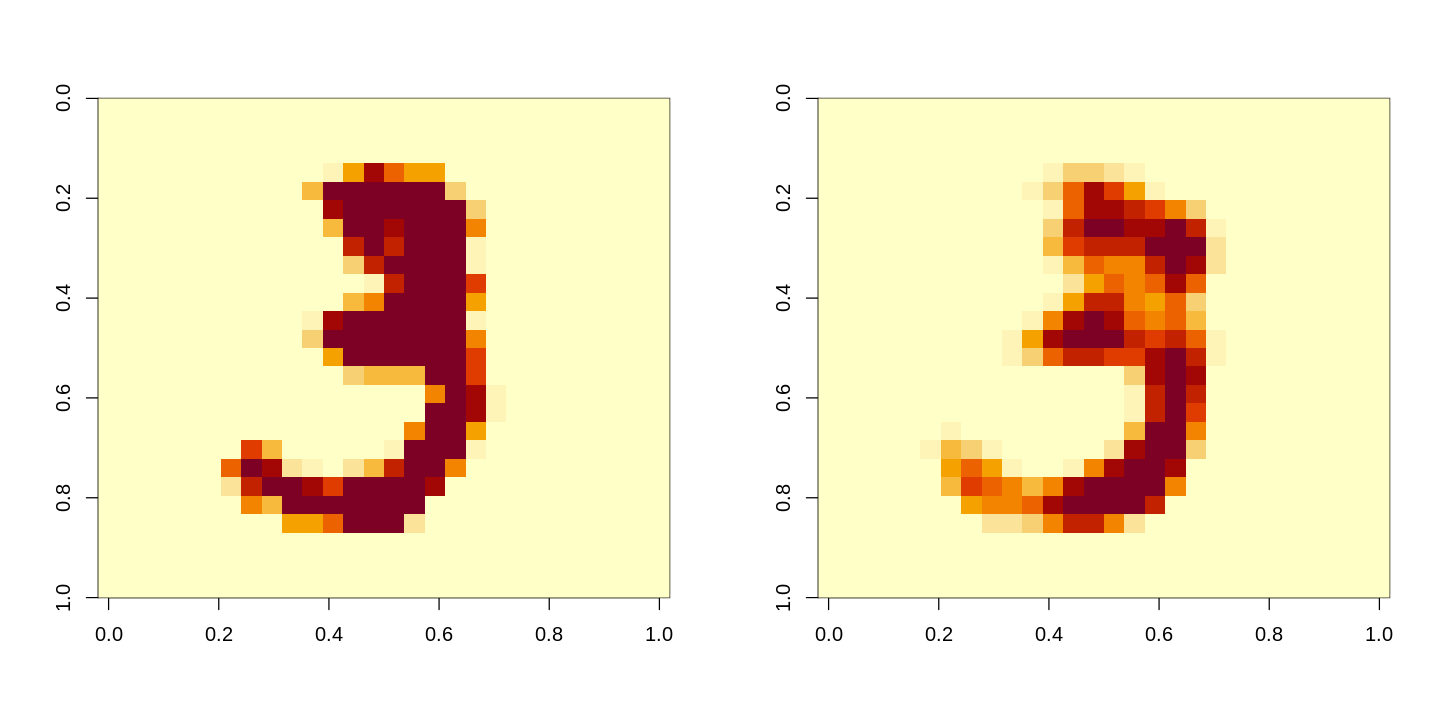

[1] "Epoch 37"
[1] "Training accuracy: 0.9178"
[1] "Validation accuracy: 0.906090609060906"


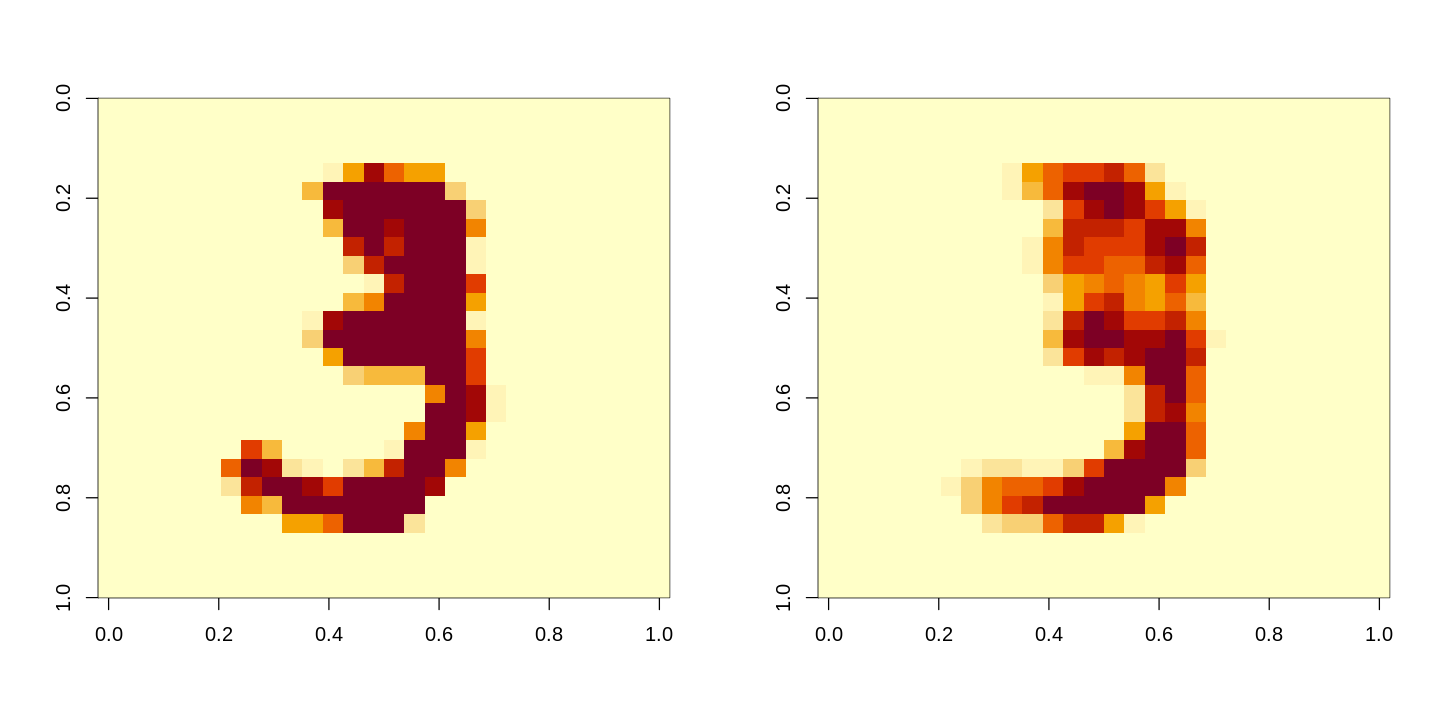

[1] "Epoch 38"
[1] "Training accuracy: 0.9177"
[1] "Validation accuracy: 0.905490549054905"


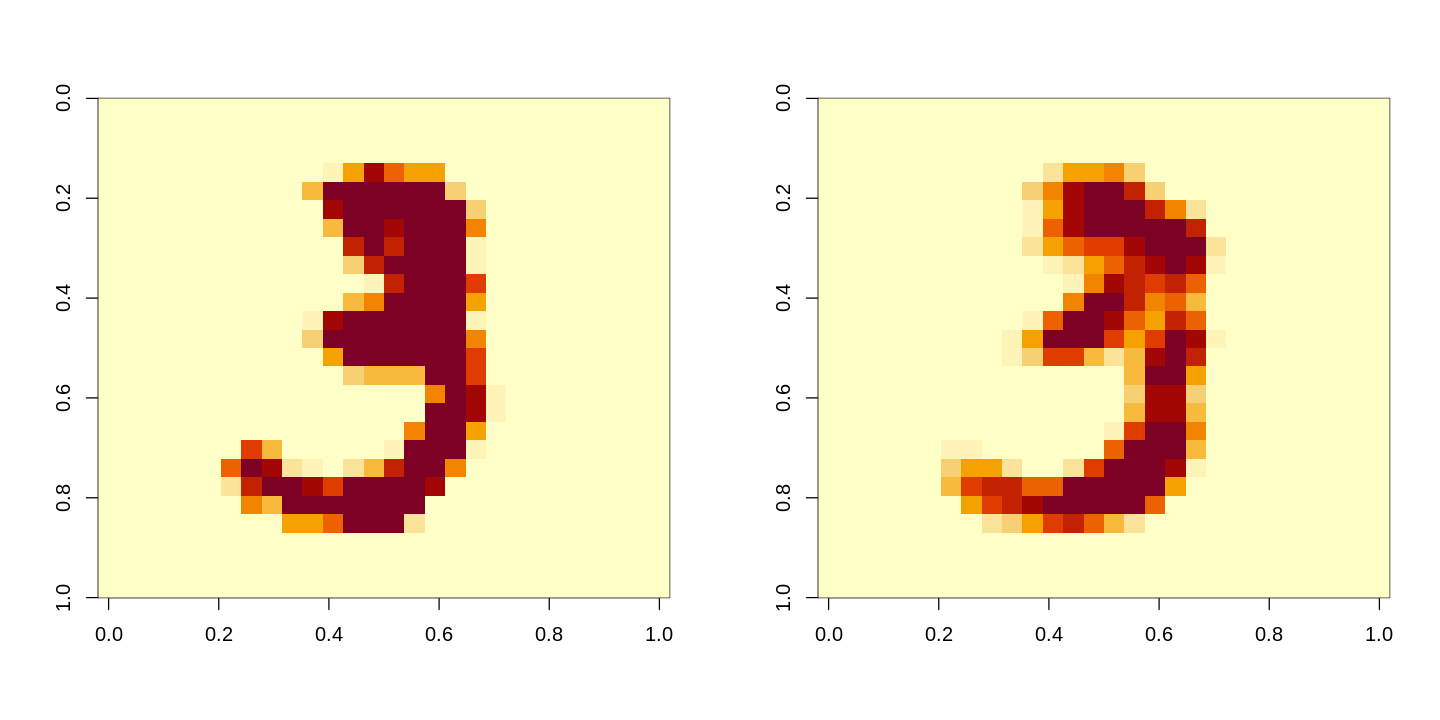

[1] "Epoch 39"
[1] "Training accuracy: 0.9165"
[1] "Validation accuracy: 0.902690269026903"


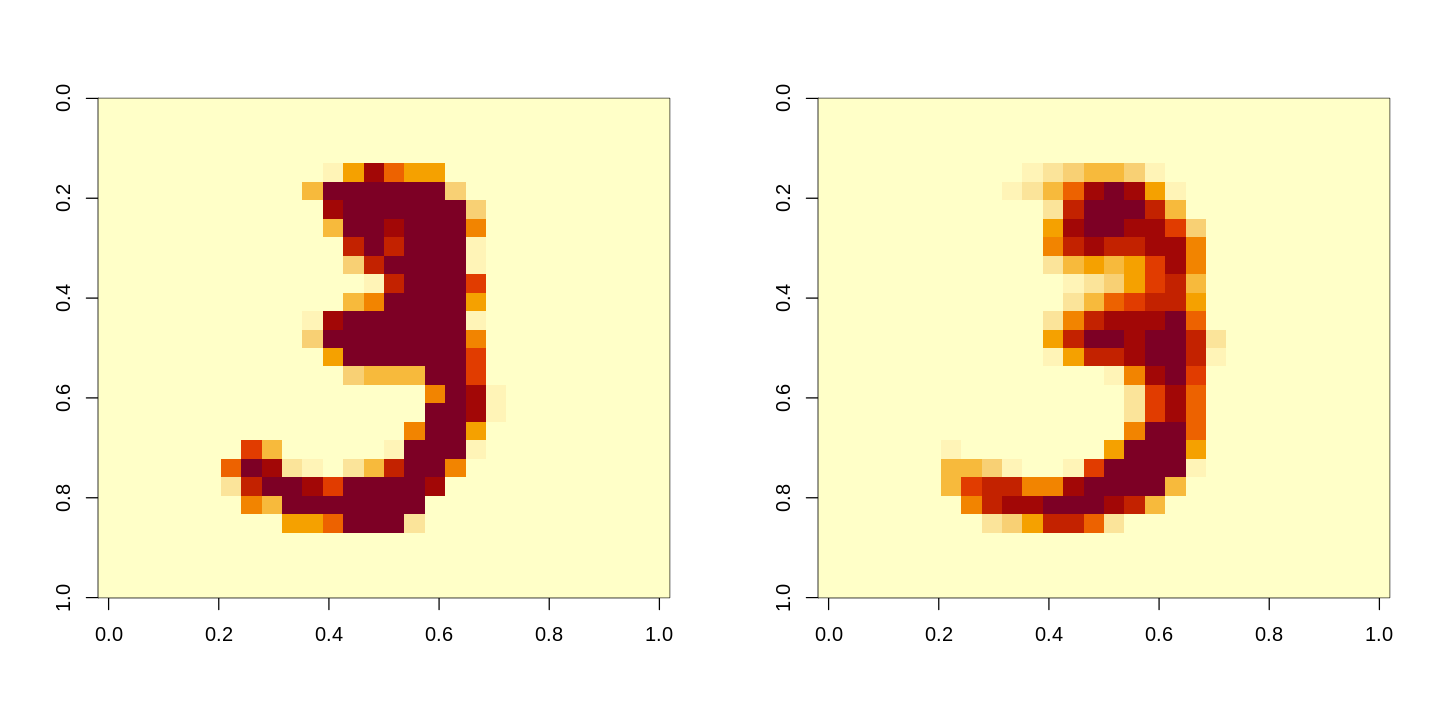

[1] "Epoch 40"
[1] "Training accuracy: 0.918"
[1] "Validation accuracy: 0.904890489048905"


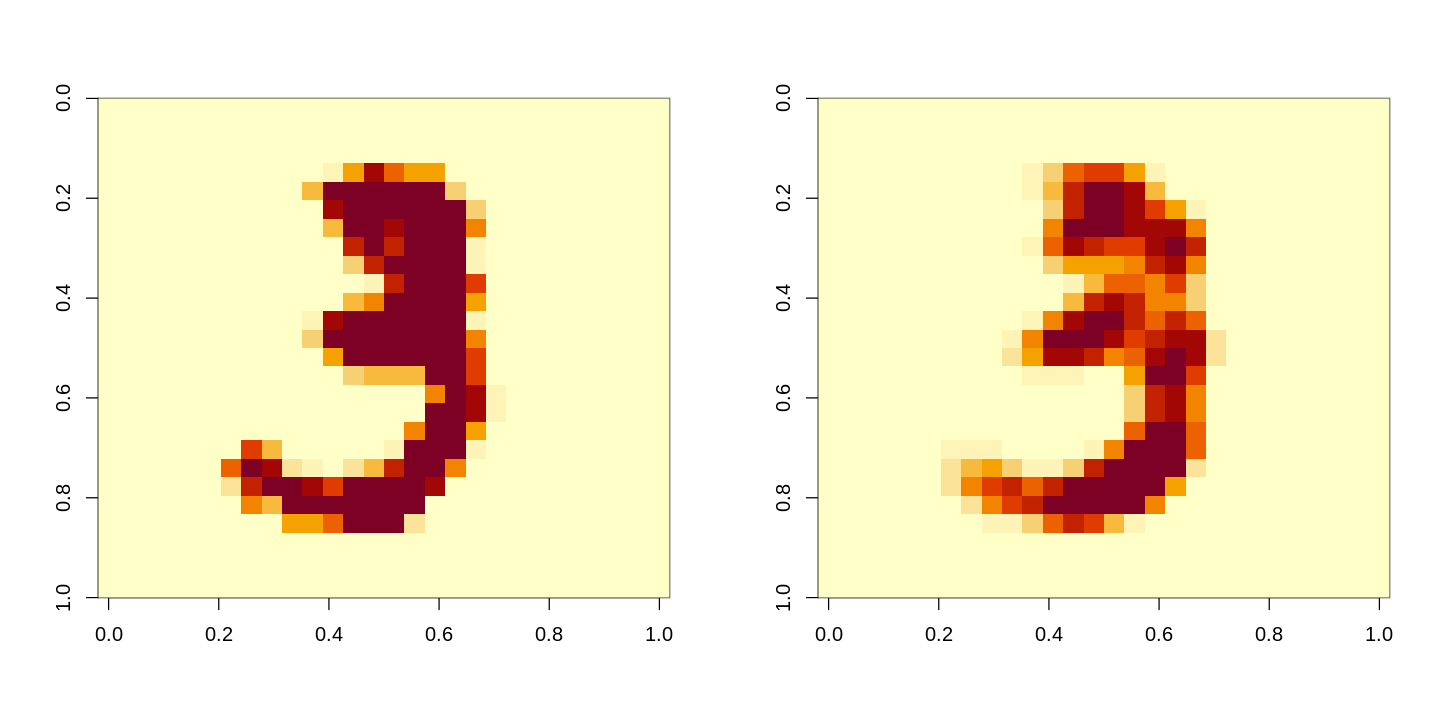

[1] "Epoch 41"
[1] "Training accuracy: 0.9199"
[1] "Validation accuracy: 0.906790679067907"


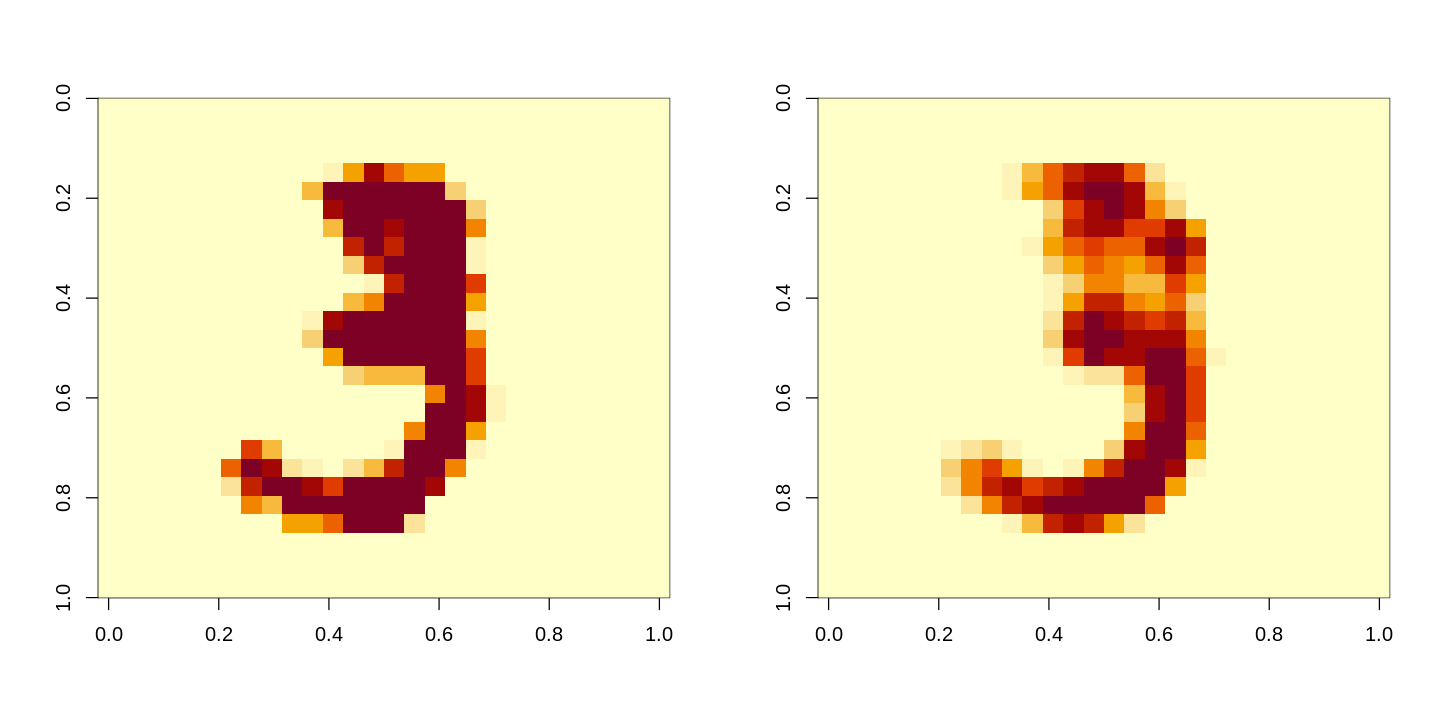

[1] "Epoch 42"
[1] "Training accuracy: 0.9204"
[1] "Validation accuracy: 0.907890789078908"


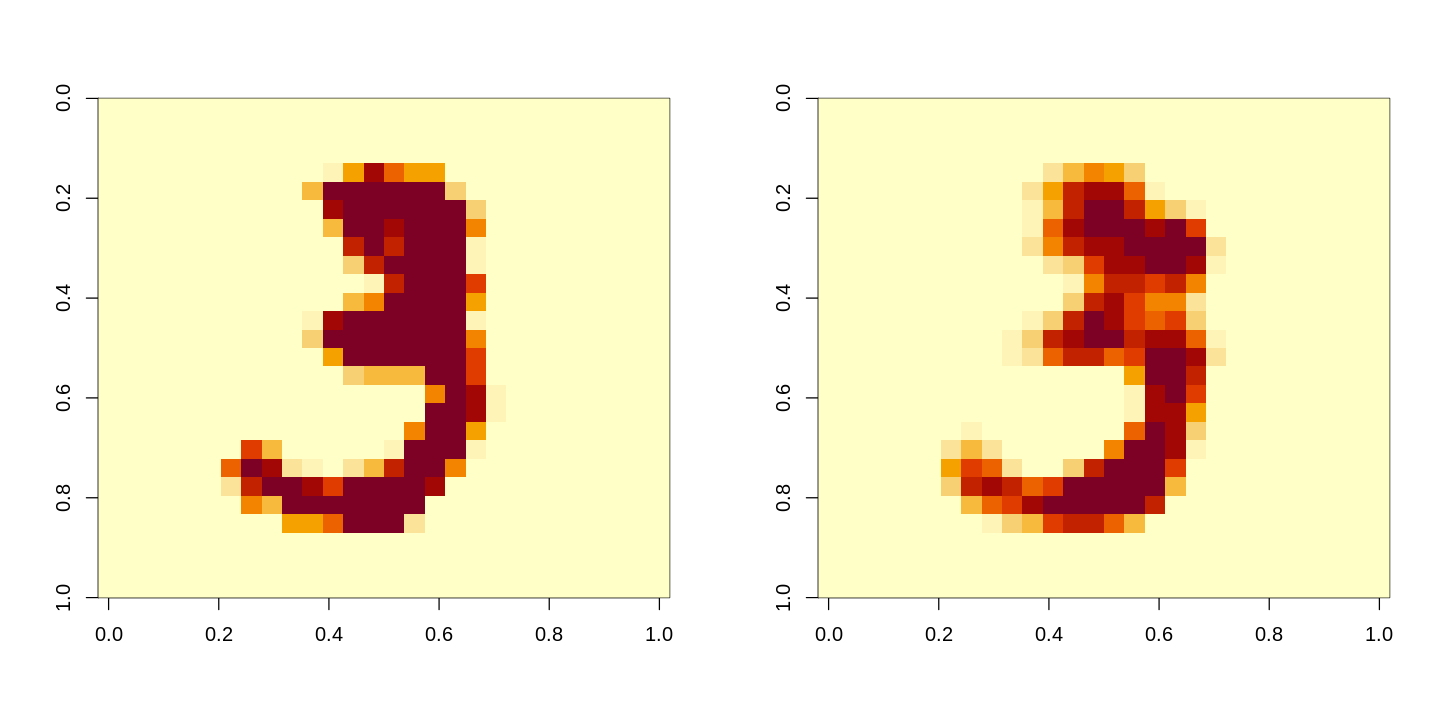

[1] "Epoch 43"
[1] "Training accuracy: 0.9189"
[1] "Validation accuracy: 0.906190619061906"


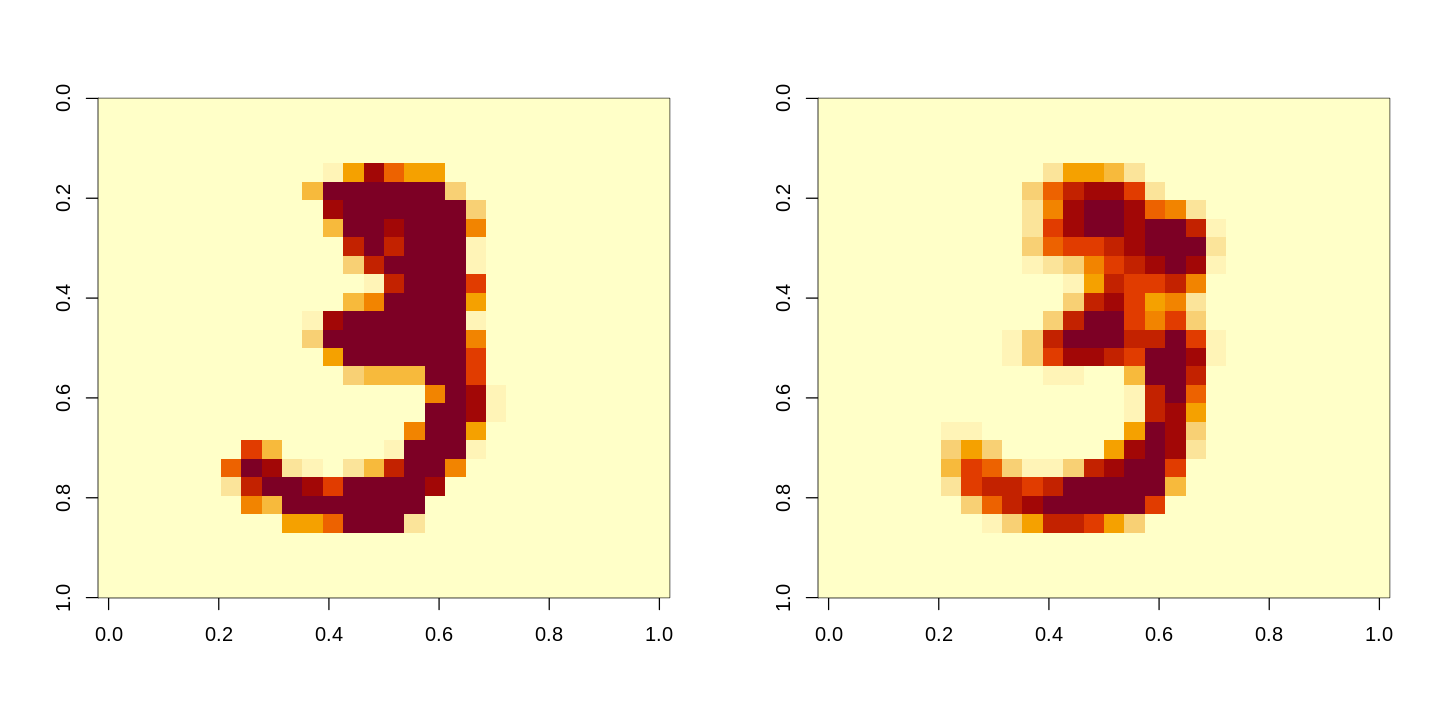

[1] "Epoch 44"
[1] "Training accuracy: 0.9196"
[1] "Validation accuracy: 0.906090609060906"


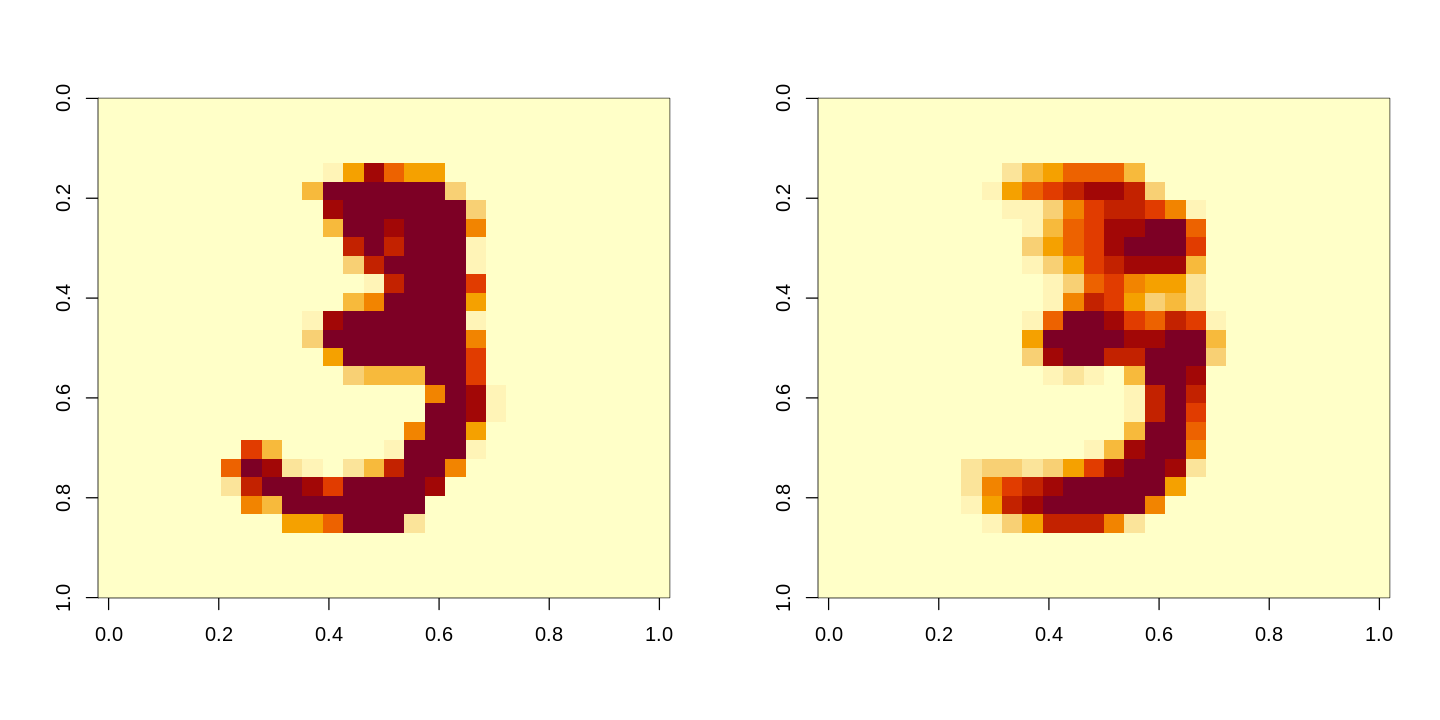

[1] "Epoch 45"
[1] "Training accuracy: 0.919"
[1] "Validation accuracy: 0.907990799079908"


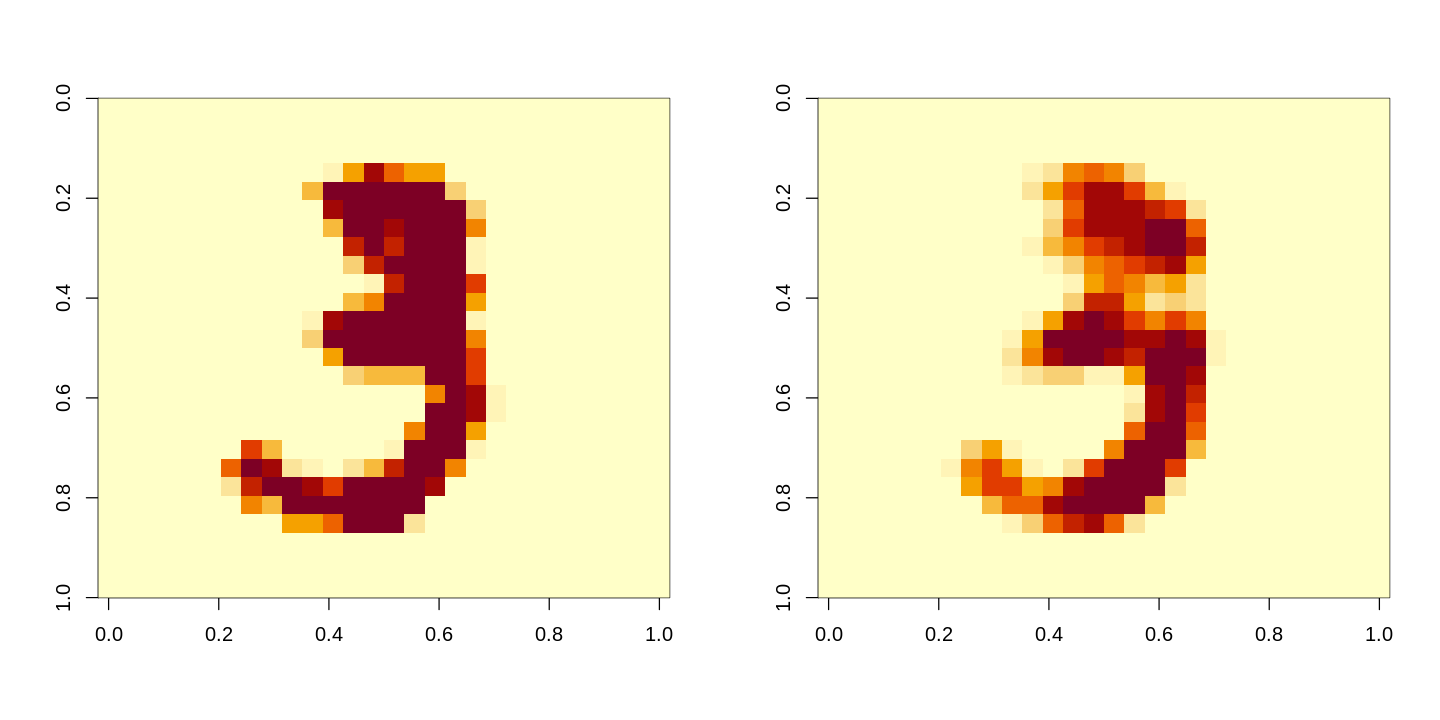

[1] "Epoch 46"
[1] "Training accuracy: 0.9203"
[1] "Validation accuracy: 0.905090509050905"


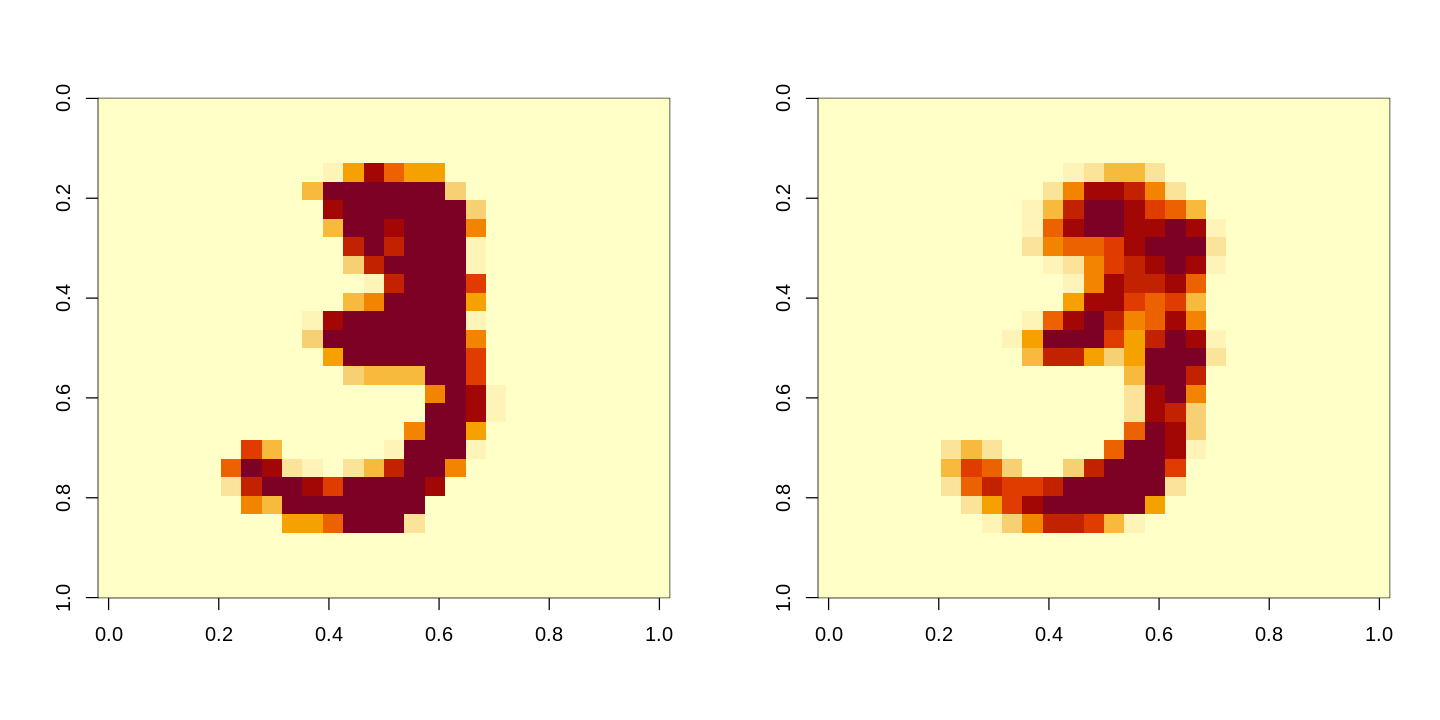

[1] "Epoch 47"
[1] "Training accuracy: 0.9228"
[1] "Validation accuracy: 0.908190819081908"


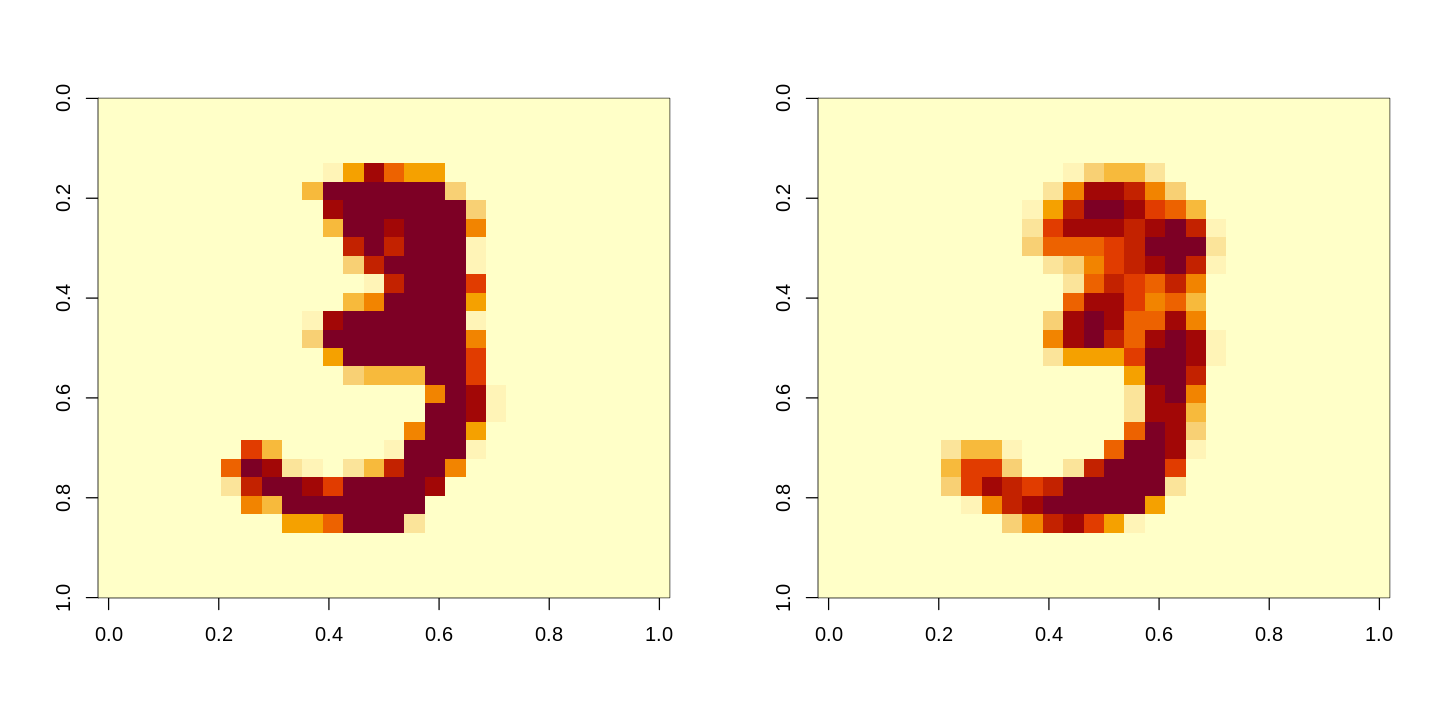

[1] "Epoch 48"
[1] "Training accuracy: 0.9222"
[1] "Validation accuracy: 0.908190819081908"


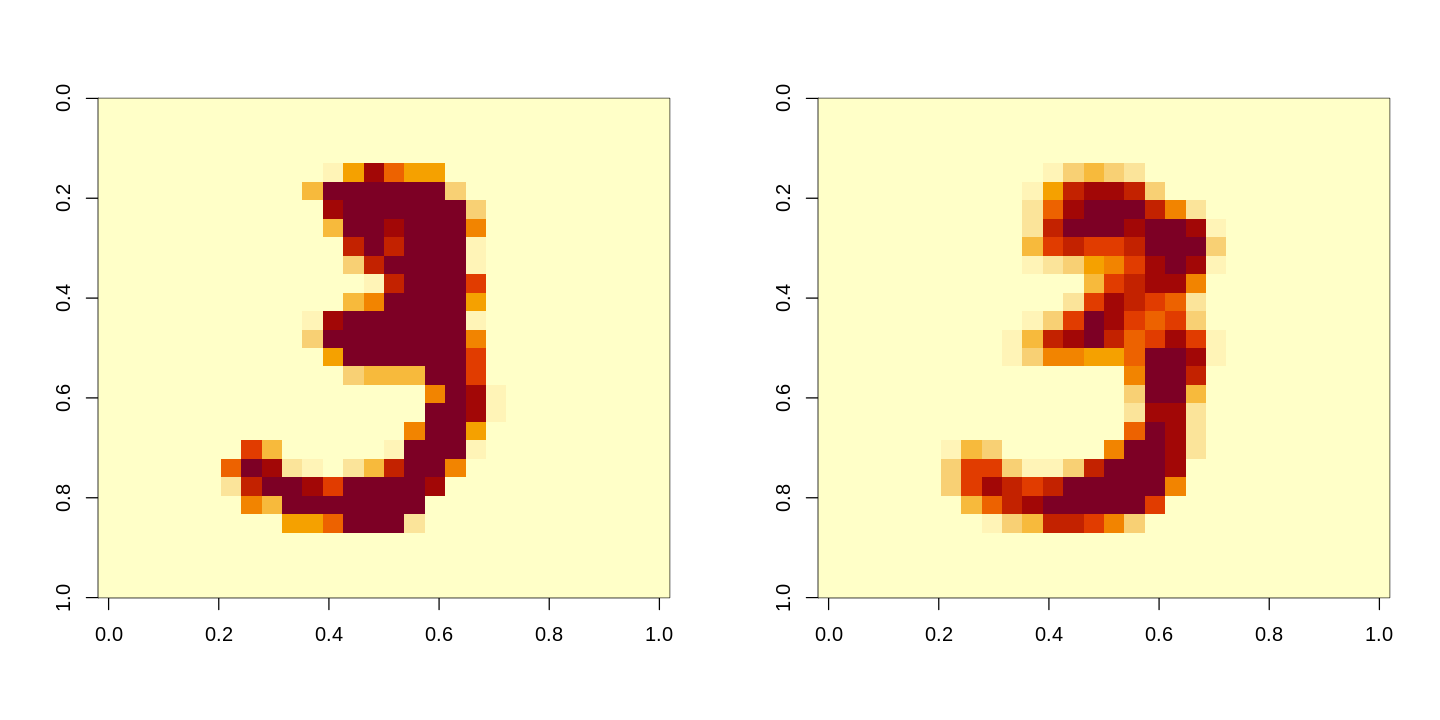

[1] "Epoch 49"
[1] "Training accuracy: 0.9181"
[1] "Validation accuracy: 0.904590459045905"


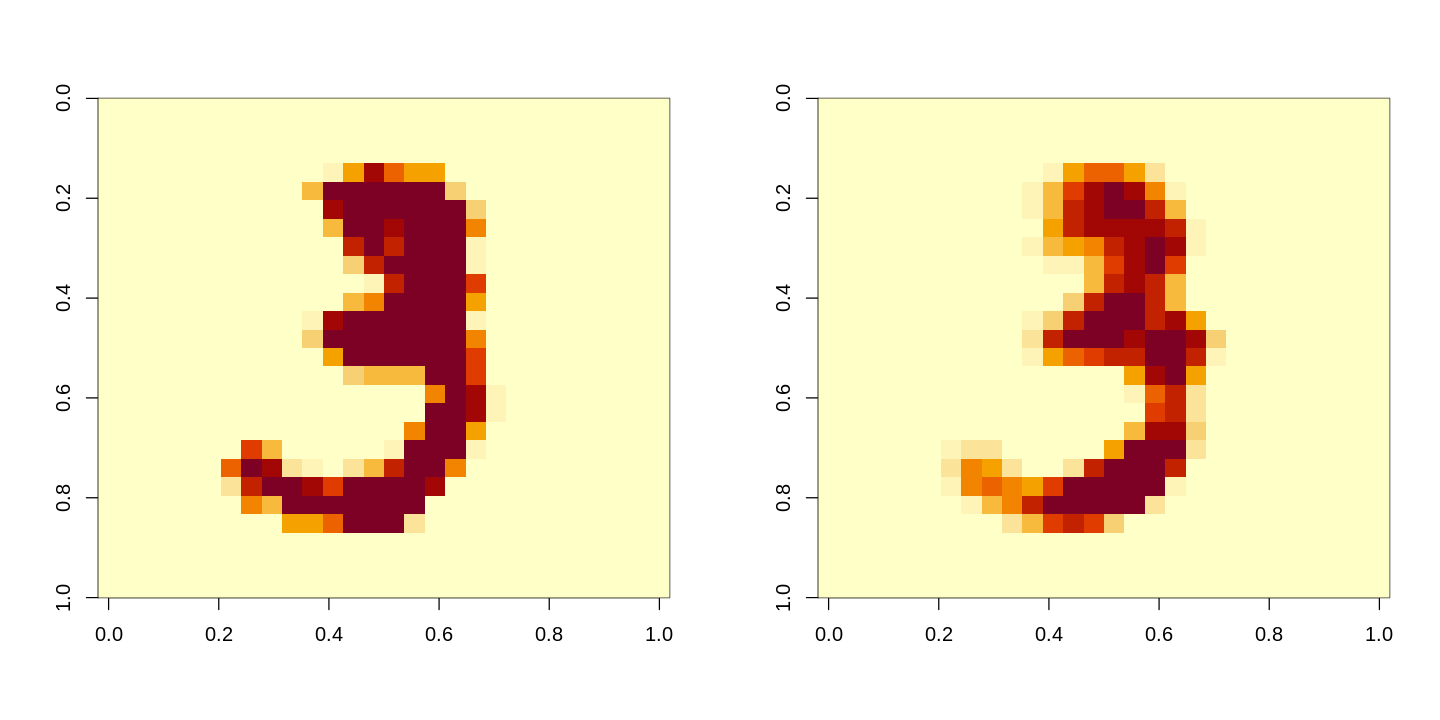

[1] "Epoch 50"
[1] "Training accuracy: 0.9238"
[1] "Validation accuracy: 0.908390839083908"


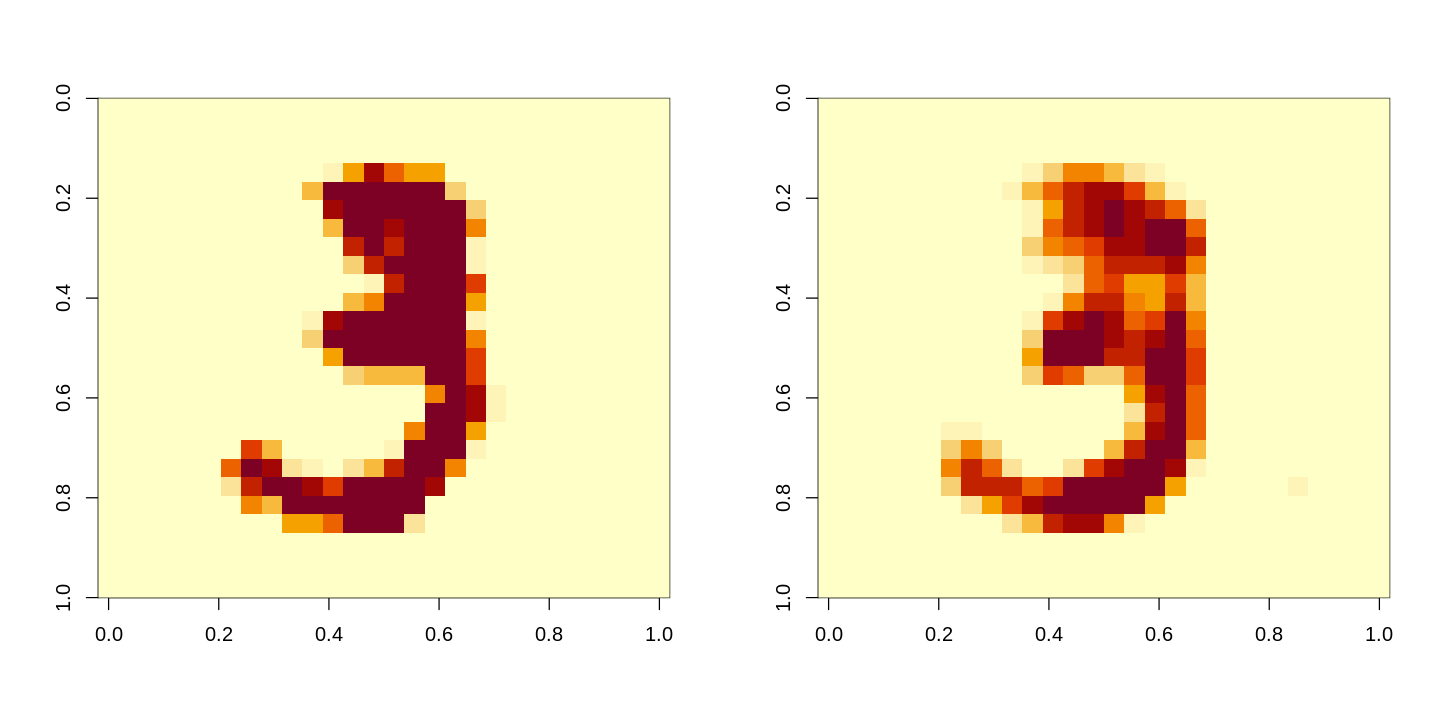

[1] "Epoch 51"
[1] "Training accuracy: 0.9238"
[1] "Validation accuracy: 0.907290729072907"


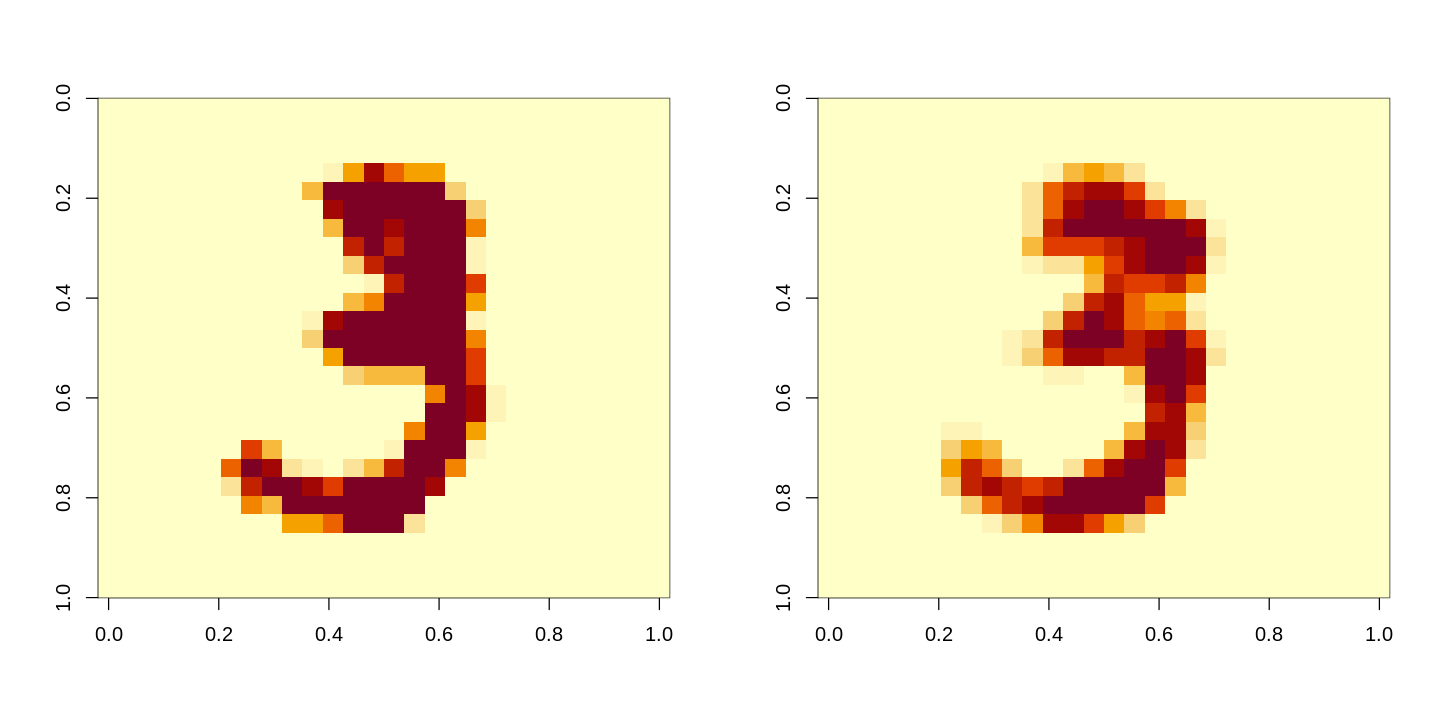

[1] "Epoch 52"
[1] "Training accuracy: 0.9234"
[1] "Validation accuracy: 0.909490949094909"


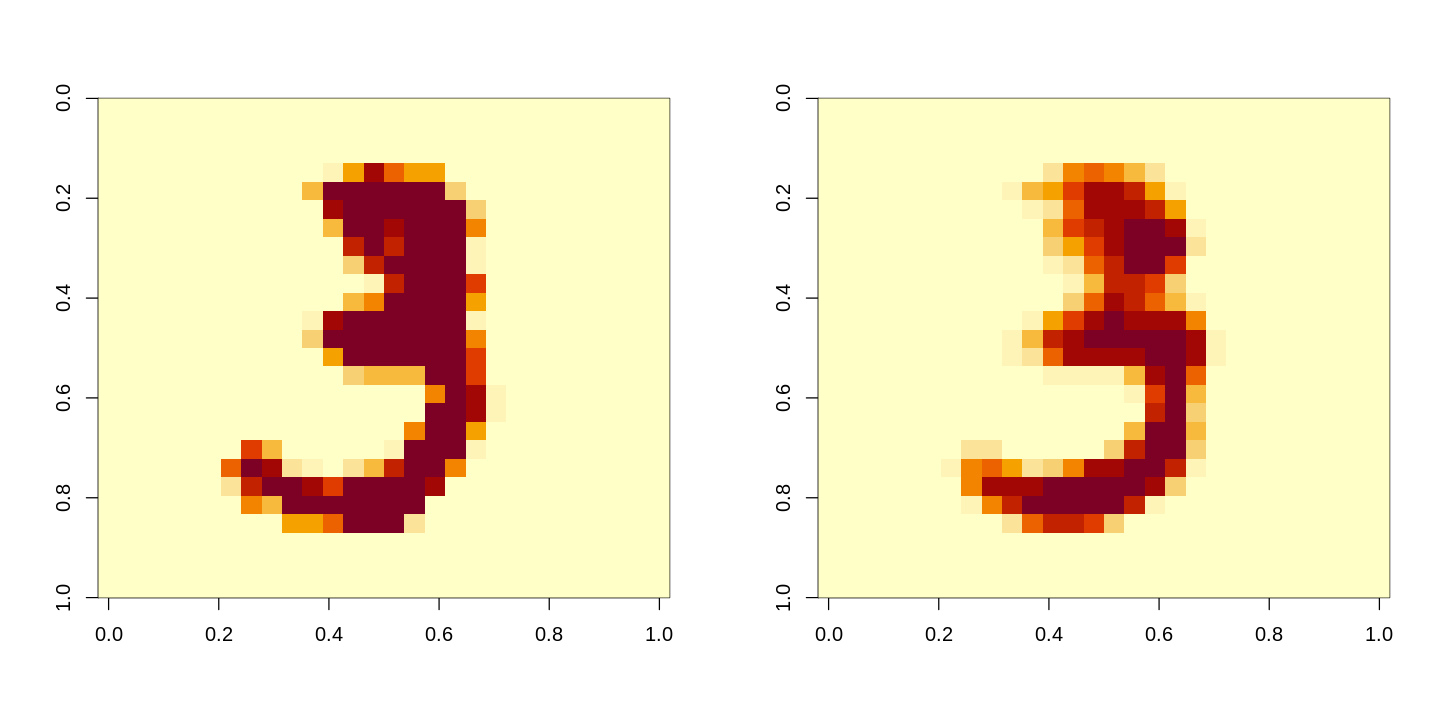

[1] "Epoch 53"
[1] "Training accuracy: 0.9243"
[1] "Validation accuracy: 0.91019101910191"


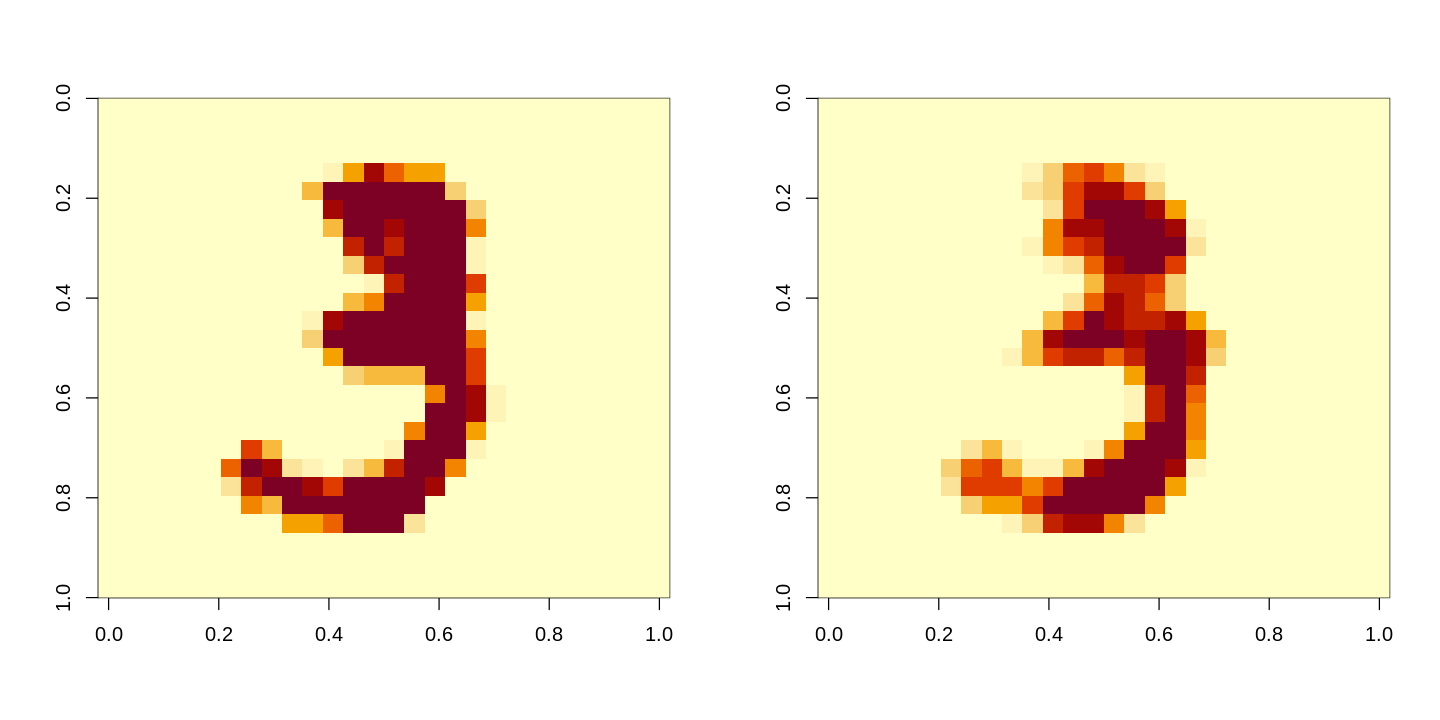

[1] "Epoch 54"
[1] "Training accuracy: 0.9226"
[1] "Validation accuracy: 0.908190819081908"


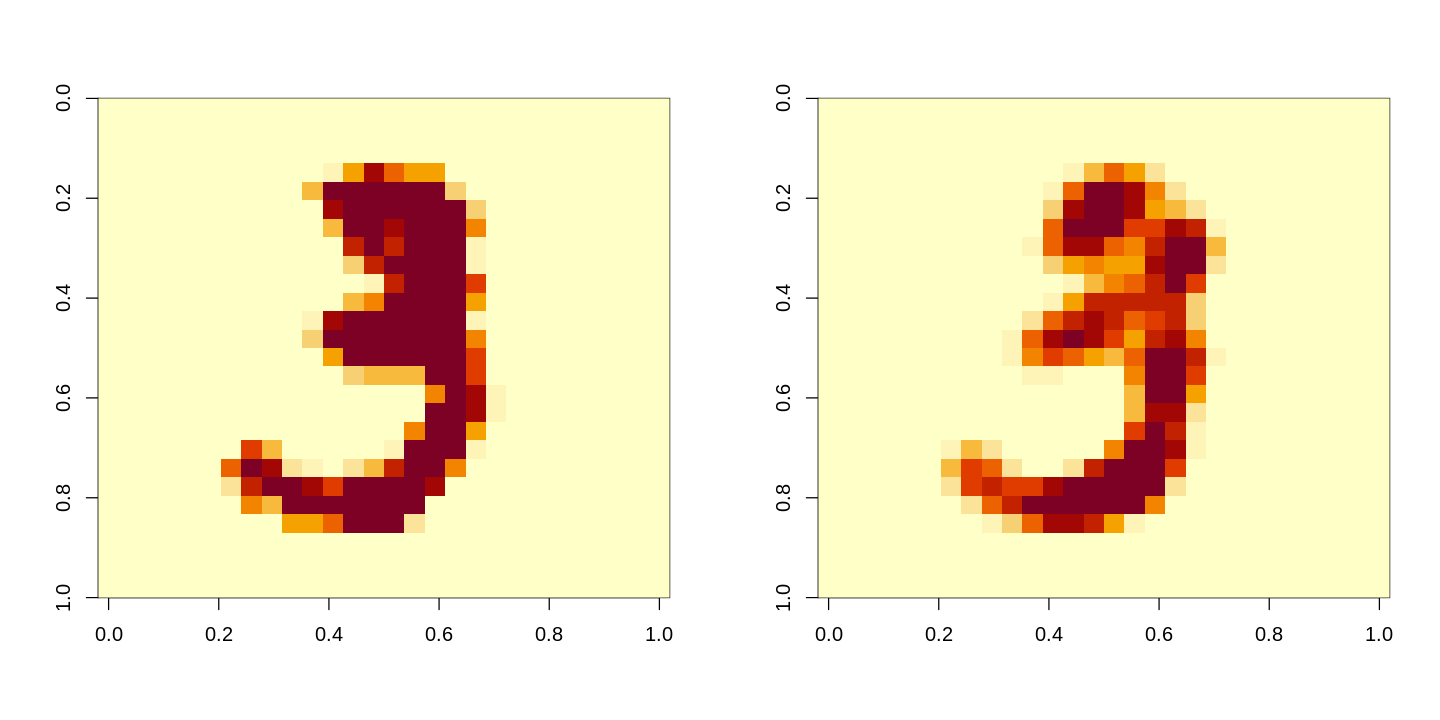

[1] "Epoch 55"
[1] "Training accuracy: 0.9237"
[1] "Validation accuracy: 0.913891389138914"


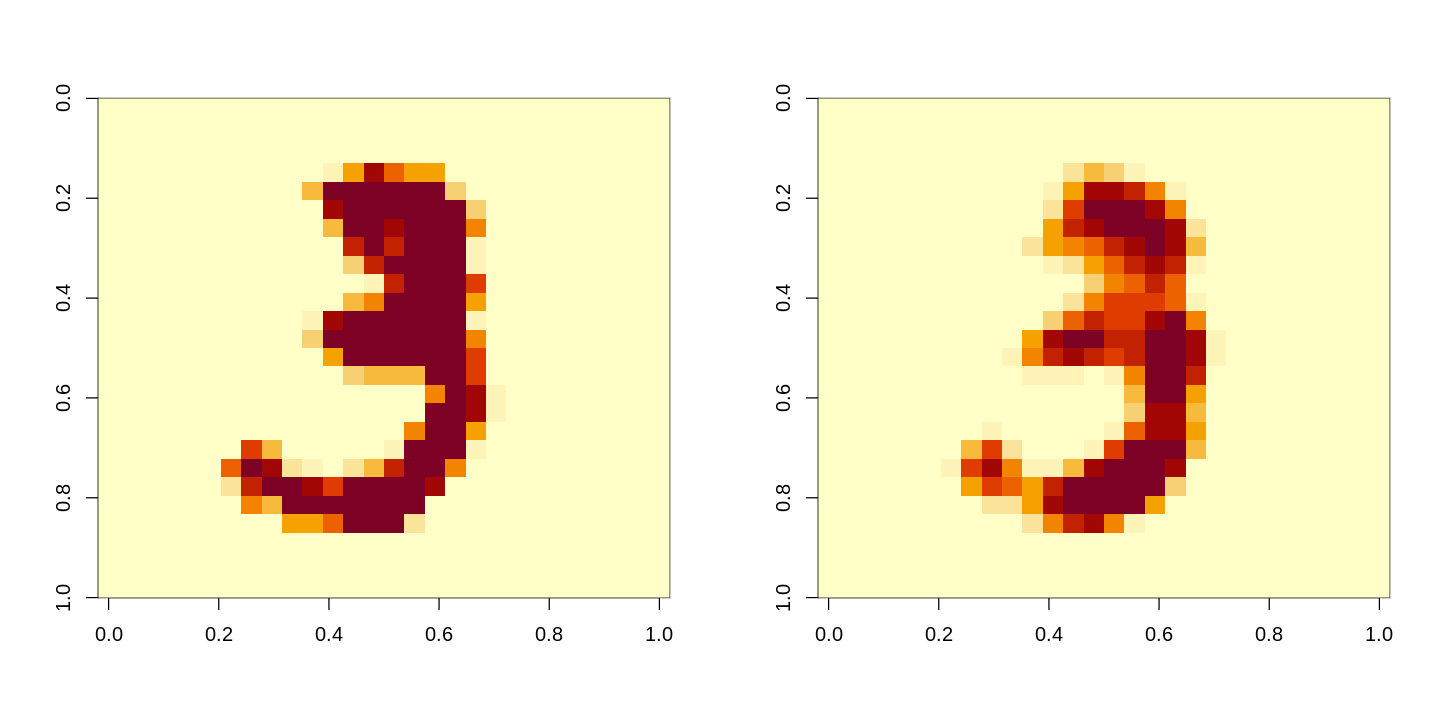

[1] "Epoch 56"
[1] "Training accuracy: 0.9249"
[1] "Validation accuracy: 0.910491049104911"


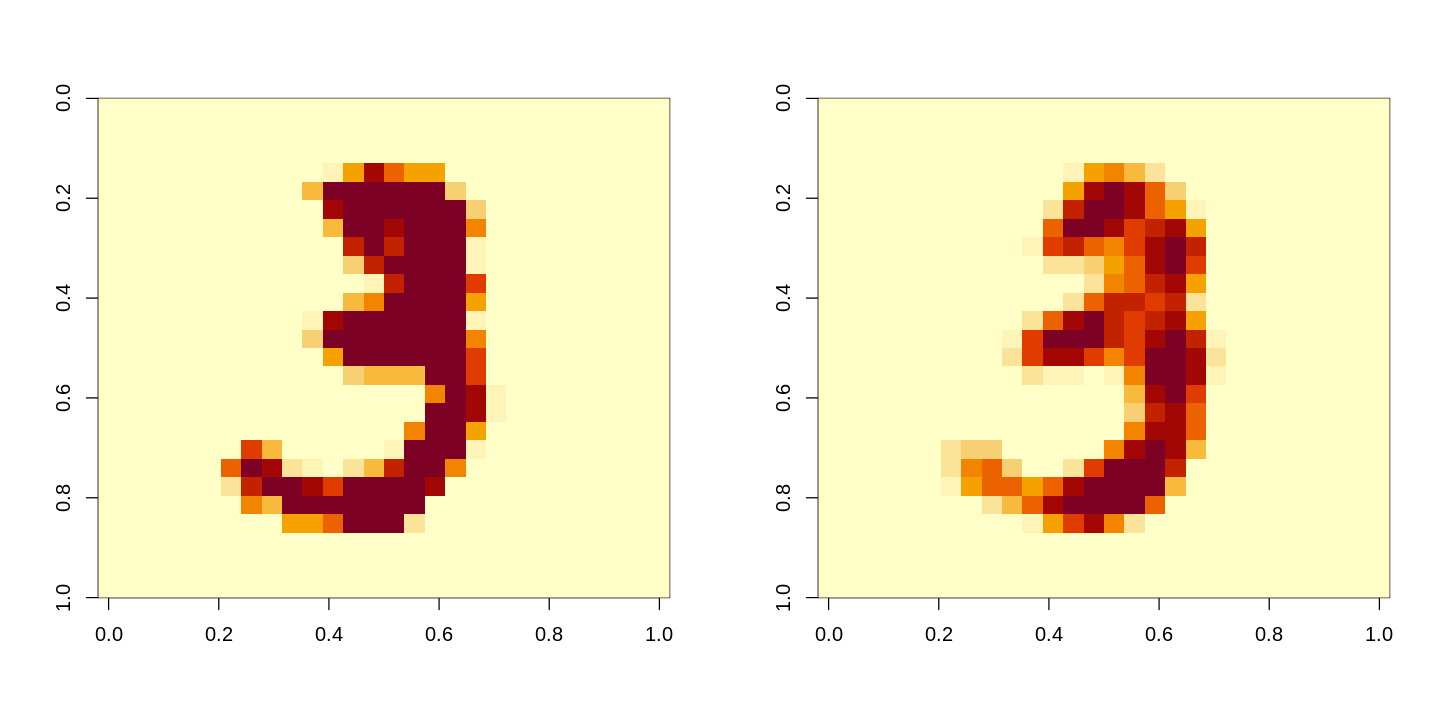

[1] "Epoch 57"
[1] "Training accuracy: 0.9259"
[1] "Validation accuracy: 0.912591259125913"


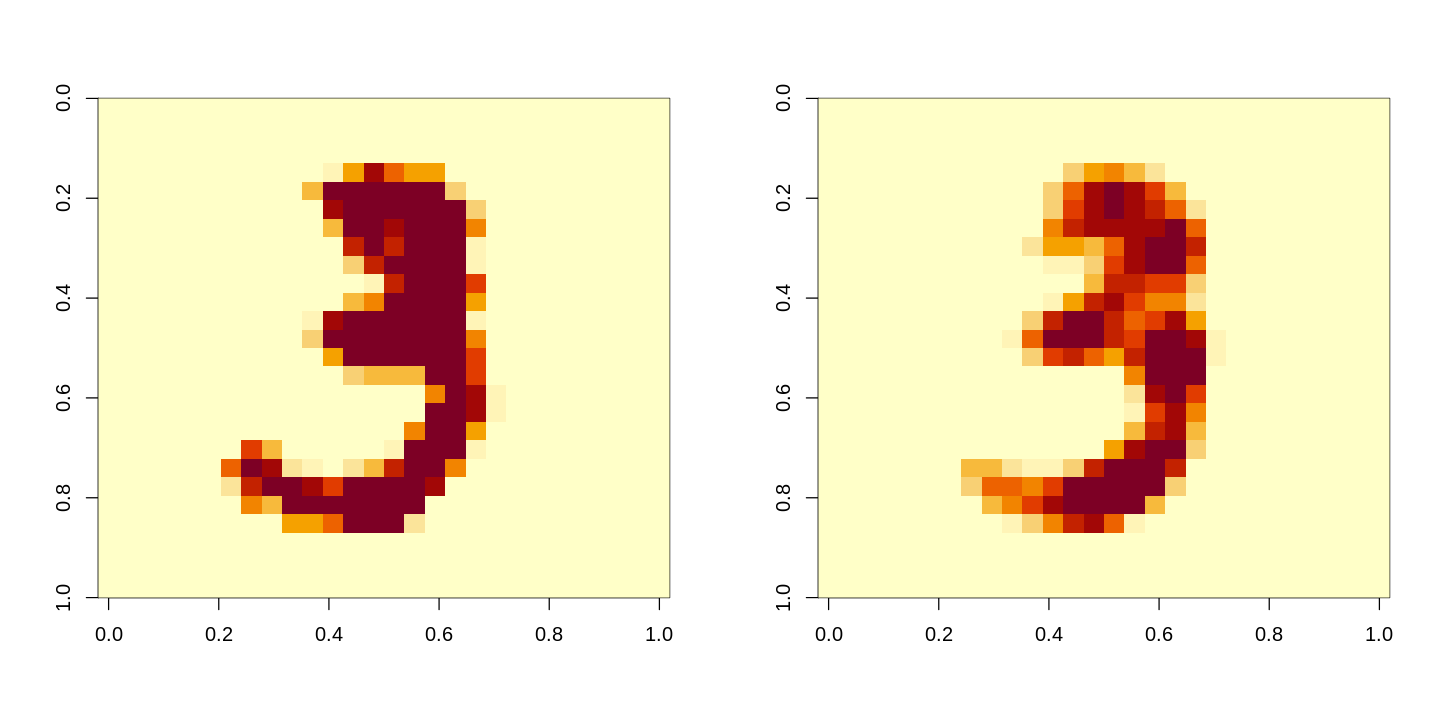

[1] "Epoch 58"
[1] "Training accuracy: 0.9256"
[1] "Validation accuracy: 0.90979097909791"


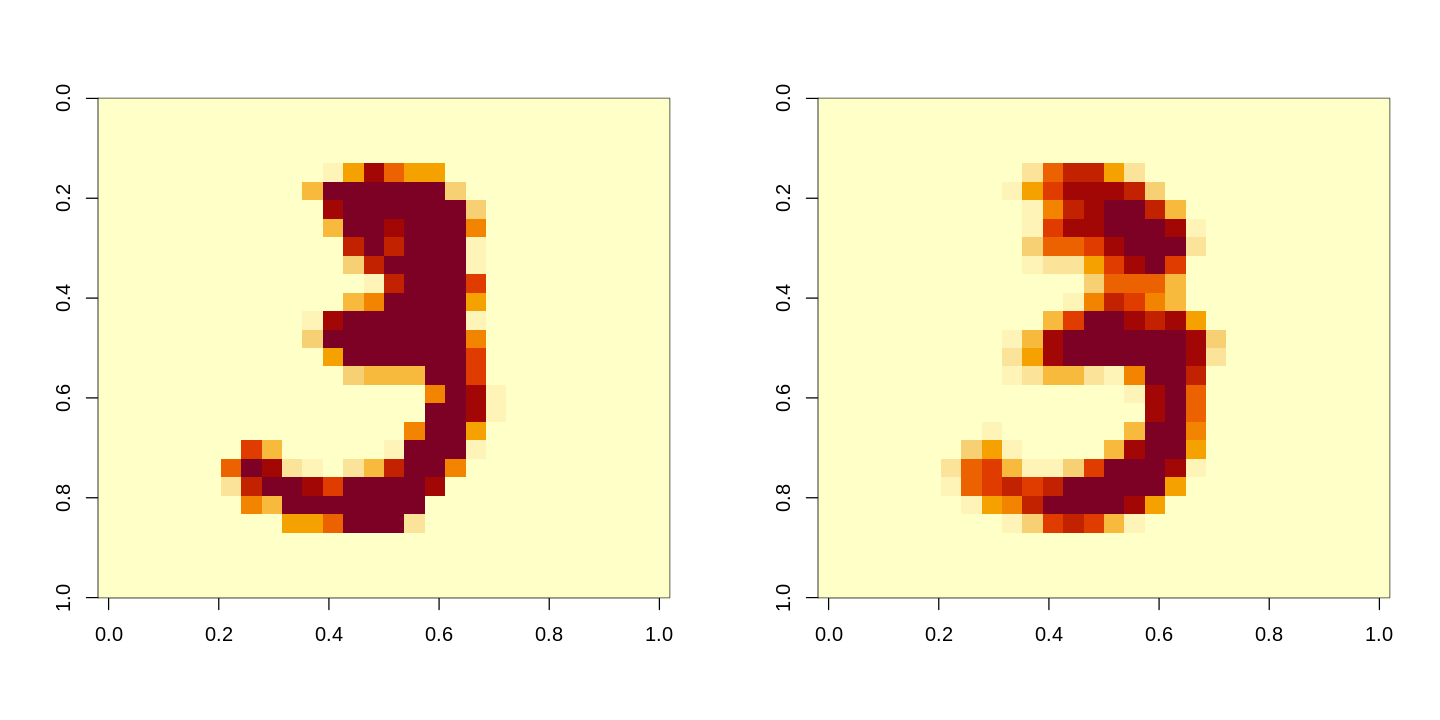

[1] "Epoch 59"
[1] "Training accuracy: 0.9276"
[1] "Validation accuracy: 0.910691069106911"


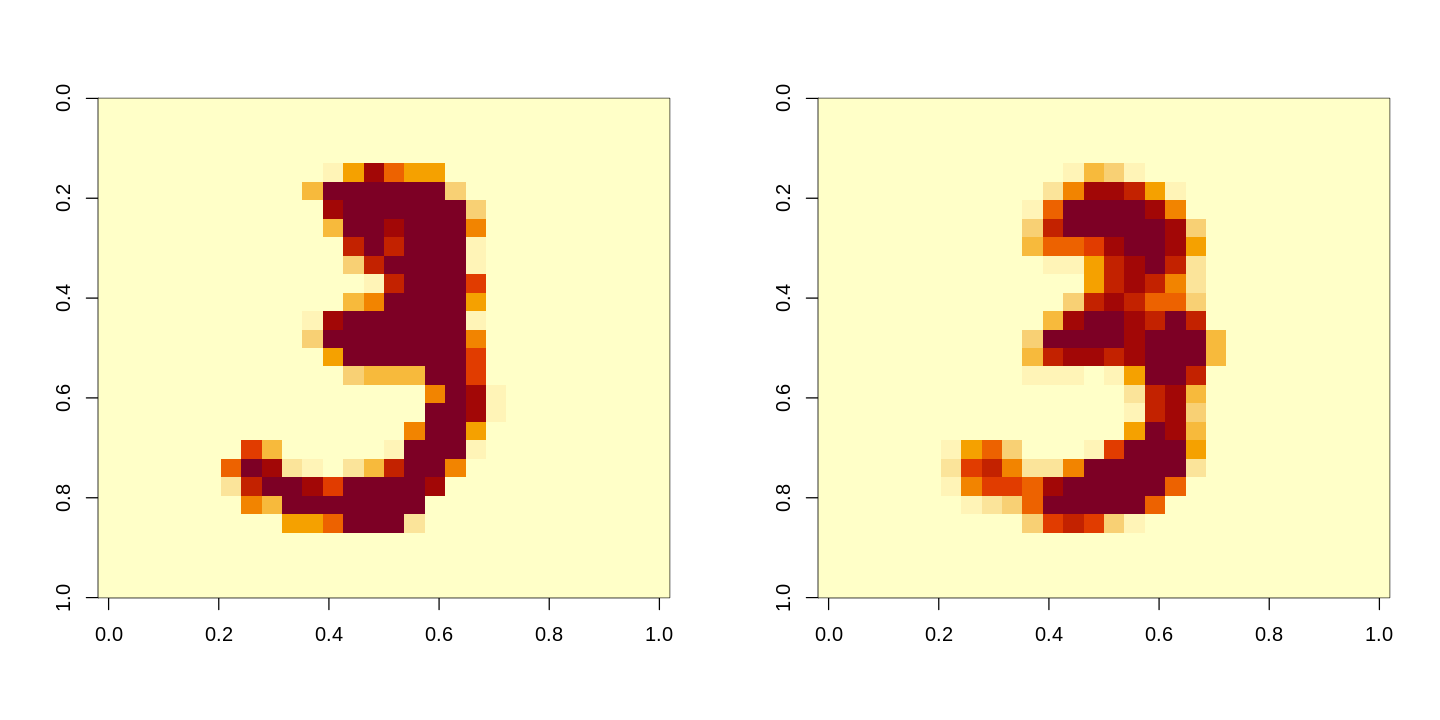

[1] "Epoch 60"
[1] "Training accuracy: 0.9254"
[1] "Validation accuracy: 0.910891089108911"


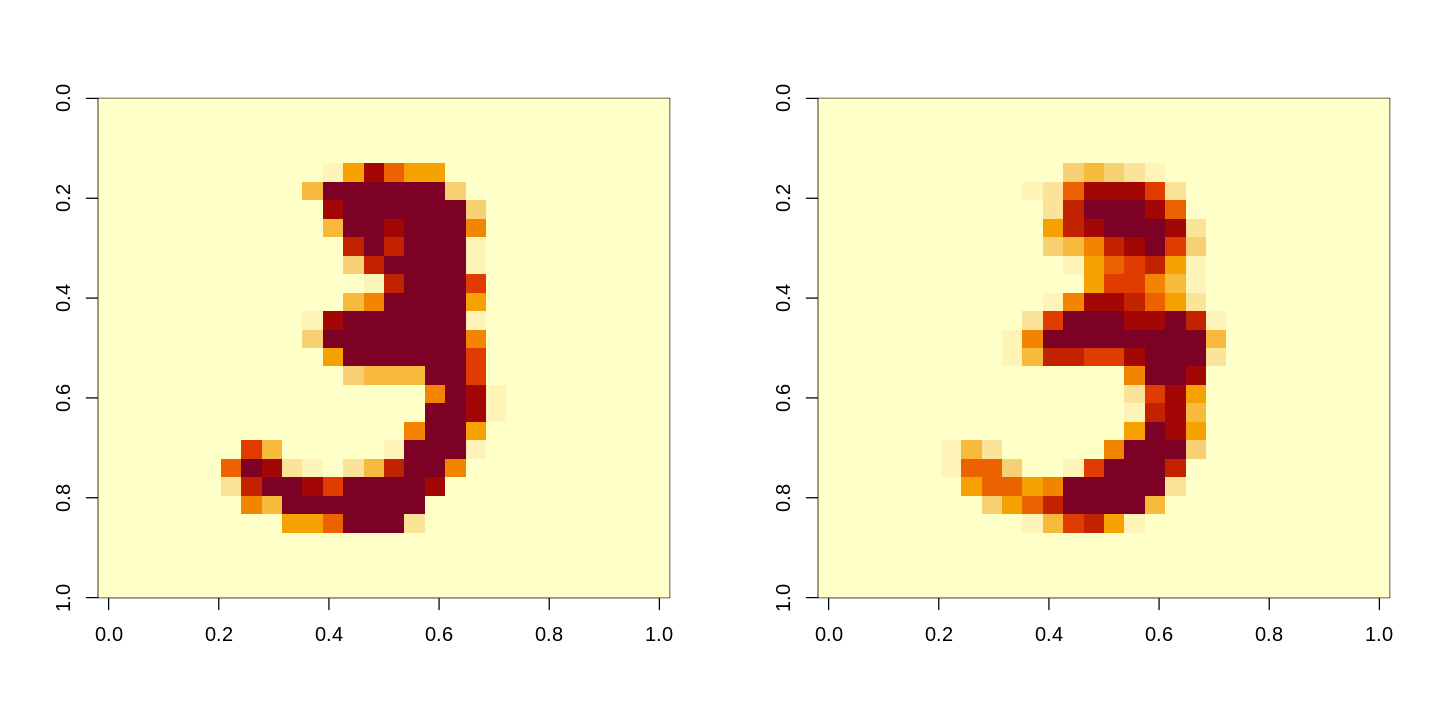

[1] "Epoch 61"
[1] "Training accuracy: 0.9278"
[1] "Validation accuracy: 0.914191419141914"


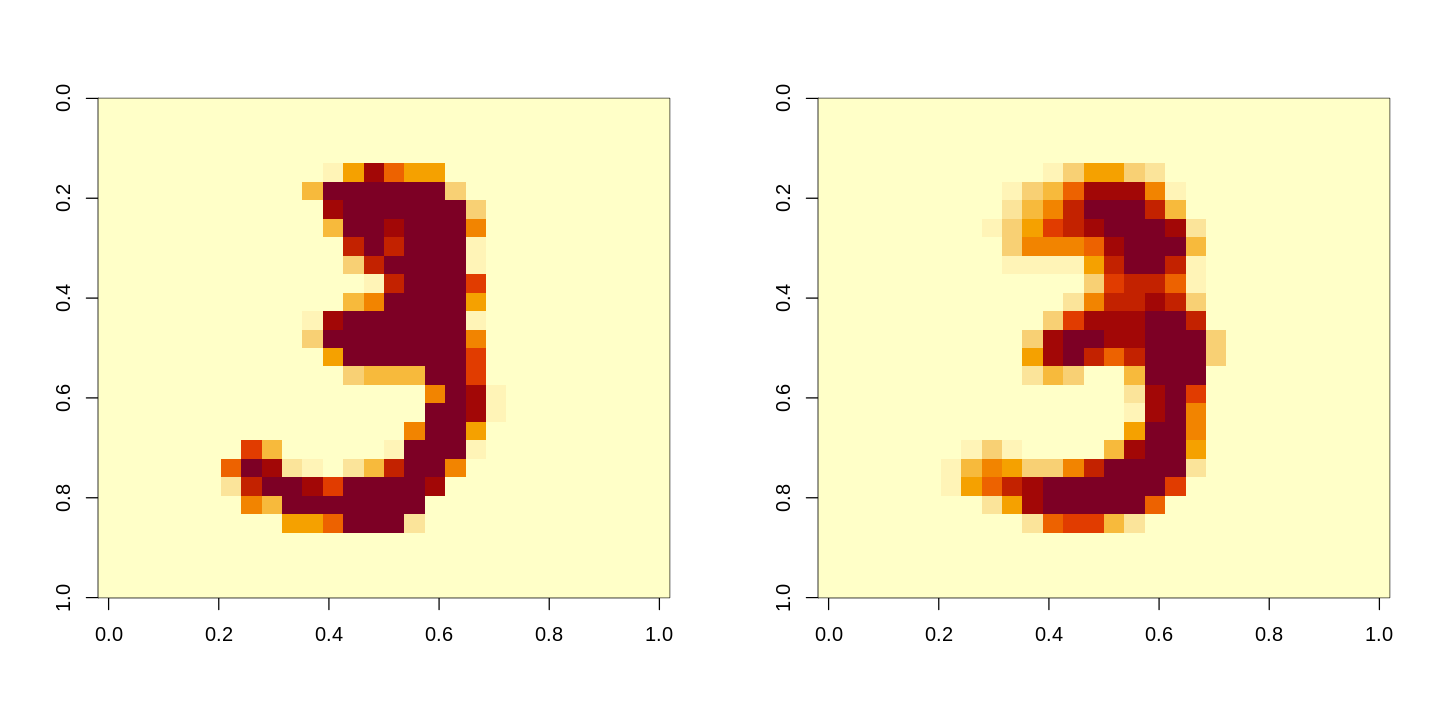

[1] "Epoch 62"
[1] "Training accuracy: 0.9286"
[1] "Validation accuracy: 0.912991299129913"


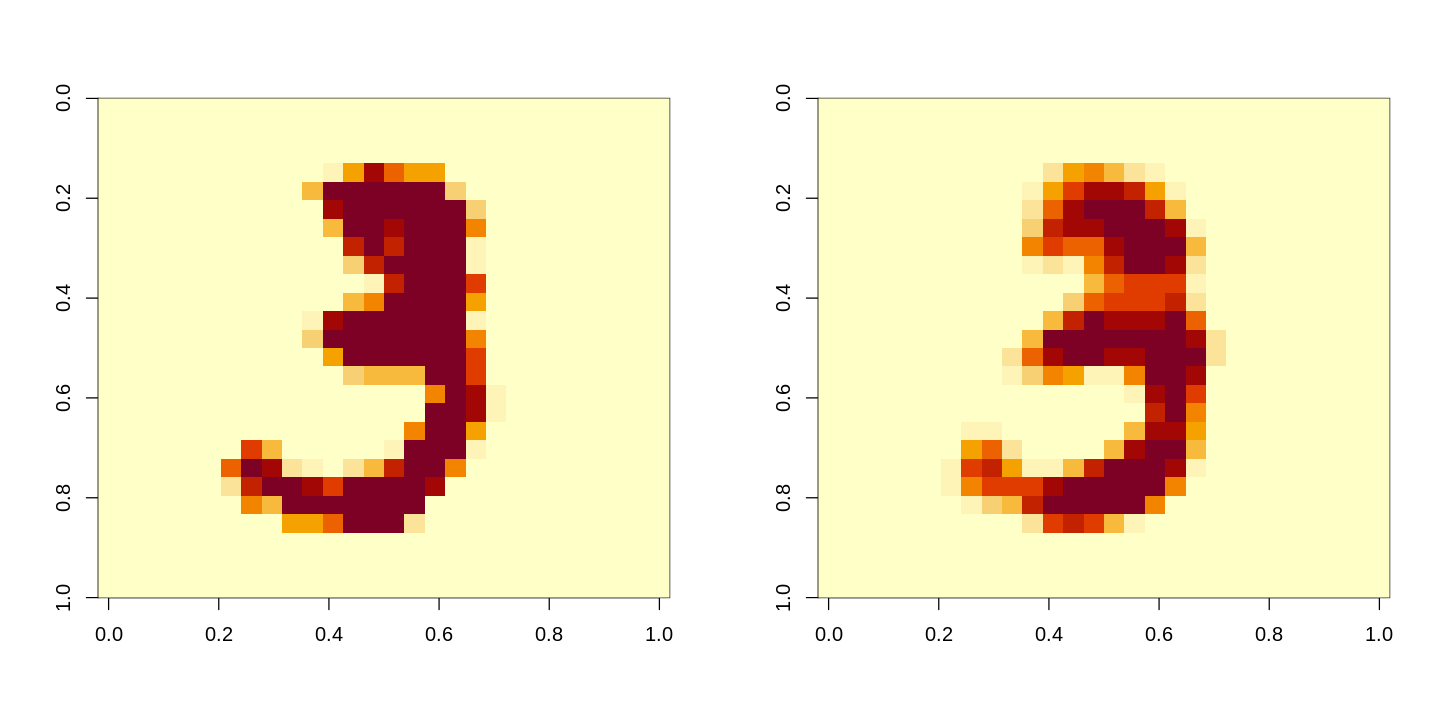

[1] "Epoch 63"
[1] "Training accuracy: 0.9272"
[1] "Validation accuracy: 0.912191219121912"


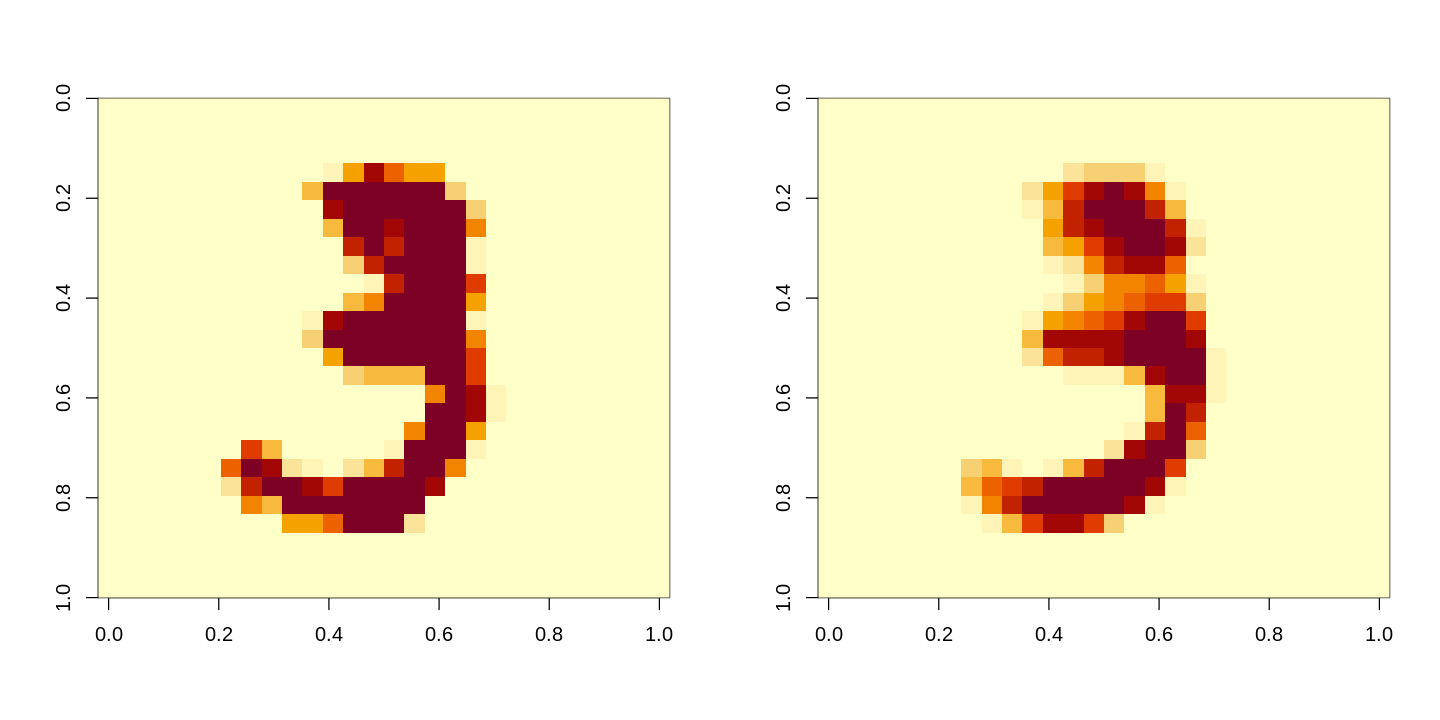

[1] "Epoch 64"
[1] "Training accuracy: 0.9282"
[1] "Validation accuracy: 0.911591159115912"


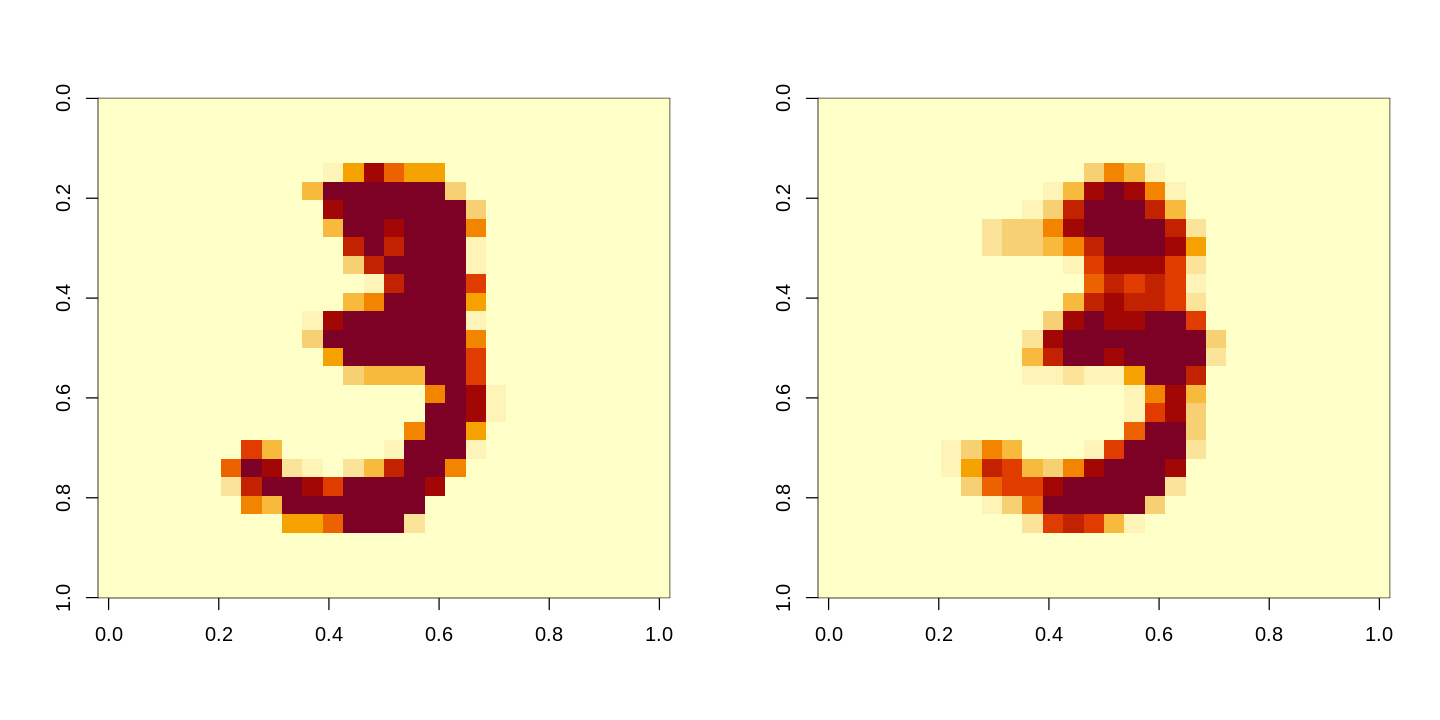

[1] "Epoch 65"
[1] "Training accuracy: 0.9305"
[1] "Validation accuracy: 0.913991399139914"


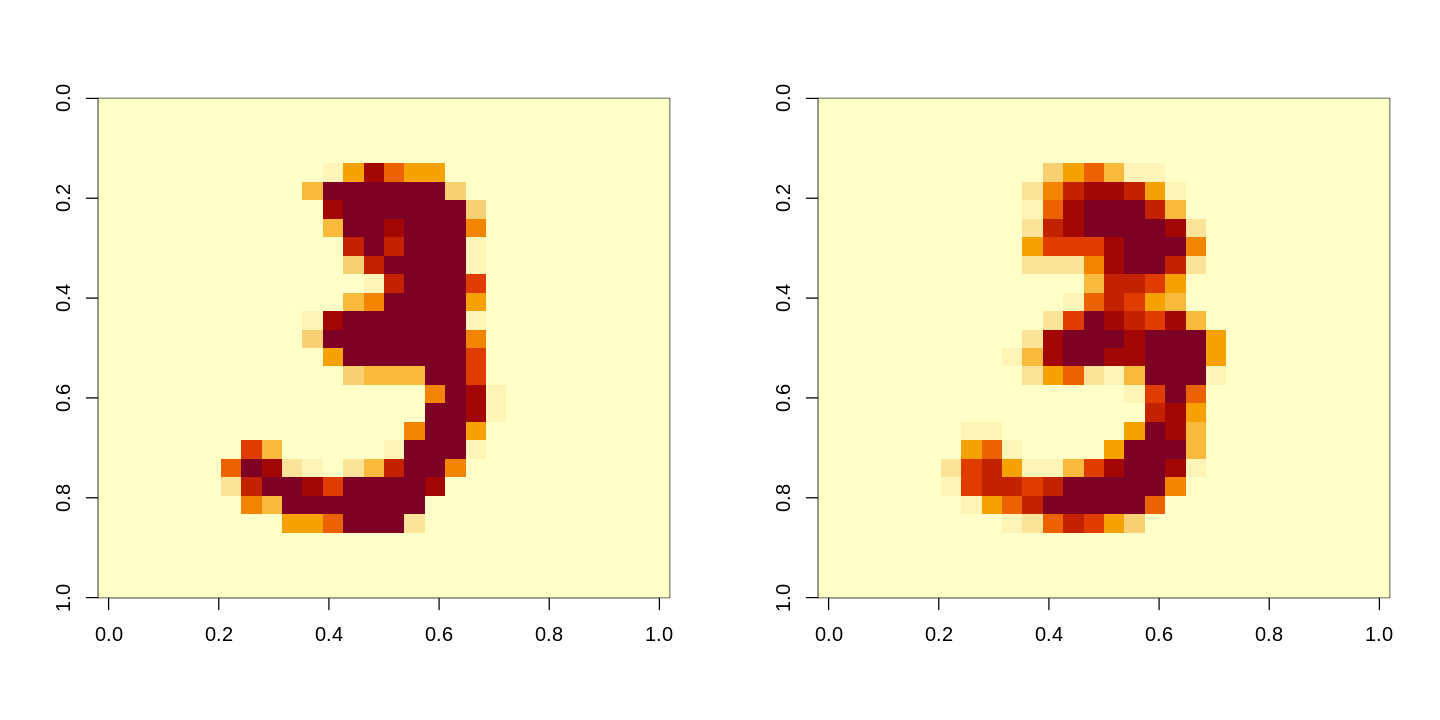

[1] "Epoch 66"
[1] "Training accuracy: 0.9291"
[1] "Validation accuracy: 0.914691469146915"


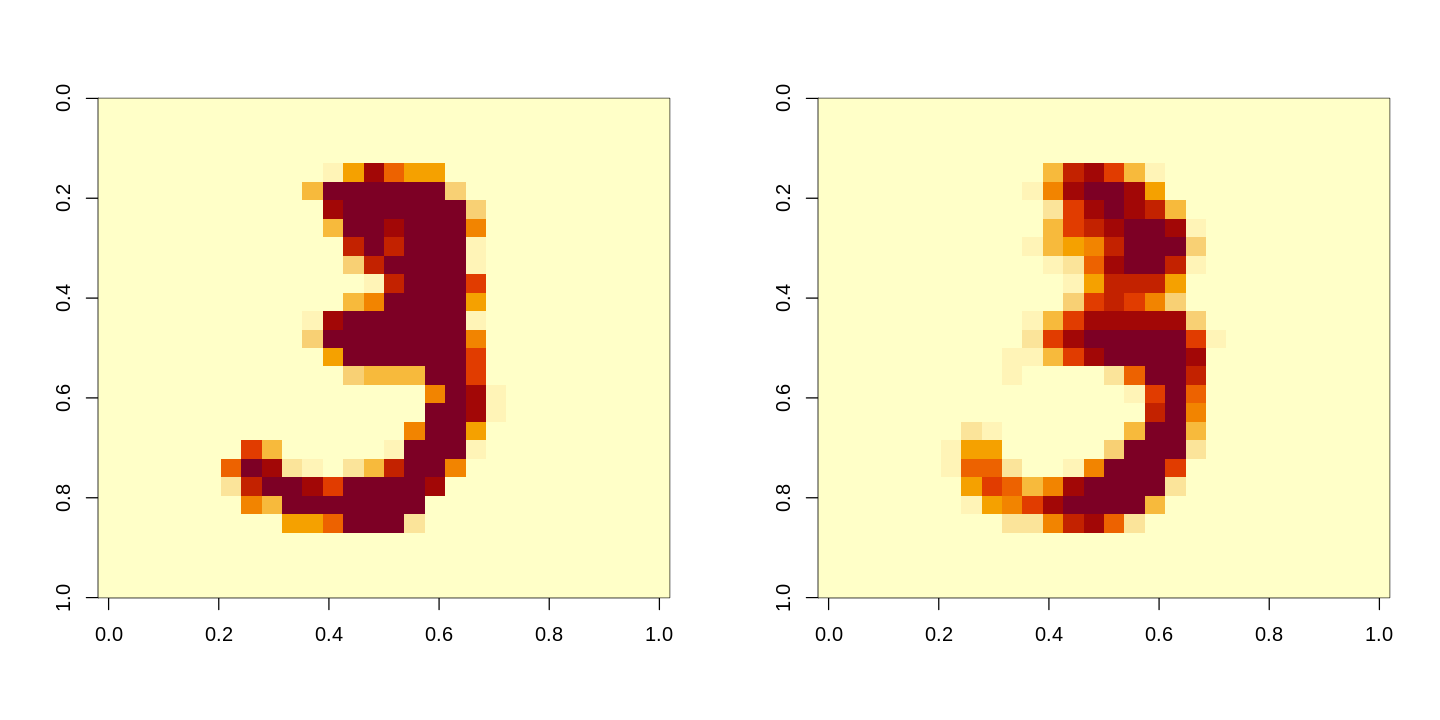

[1] "Epoch 67"
[1] "Training accuracy: 0.9288"
[1] "Validation accuracy: 0.911491149114911"


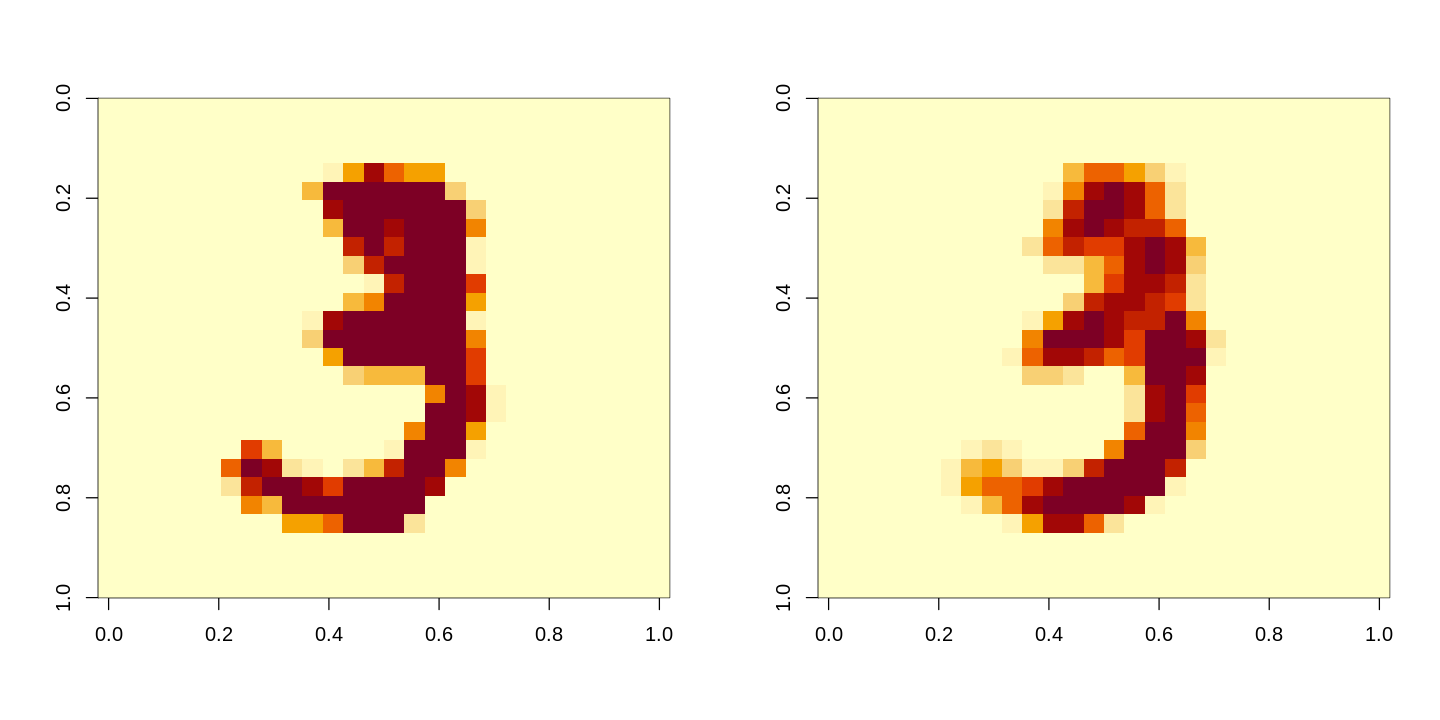

[1] "Epoch 68"
[1] "Training accuracy: 0.9297"
[1] "Validation accuracy: 0.914191419141914"


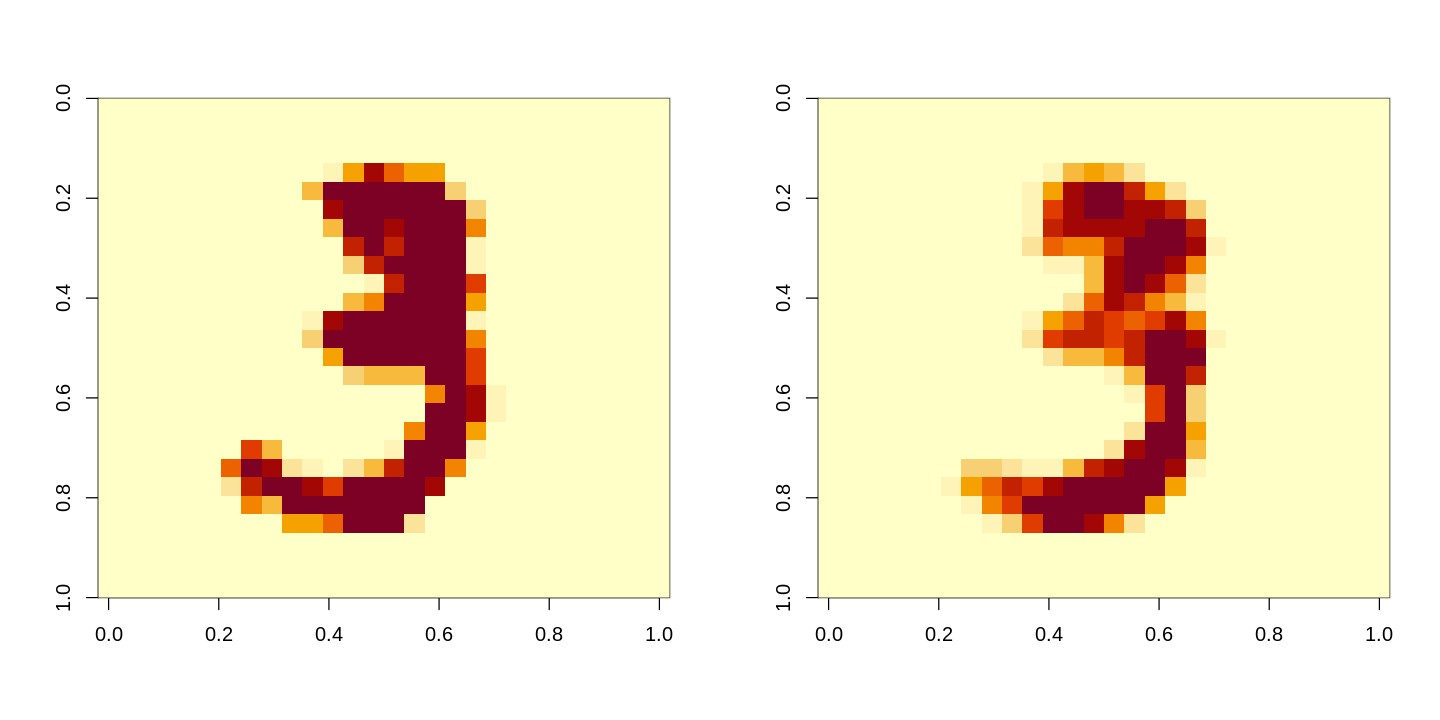

[1] "Epoch 69"
[1] "Training accuracy: 0.9262"
[1] "Validation accuracy: 0.91019101910191"


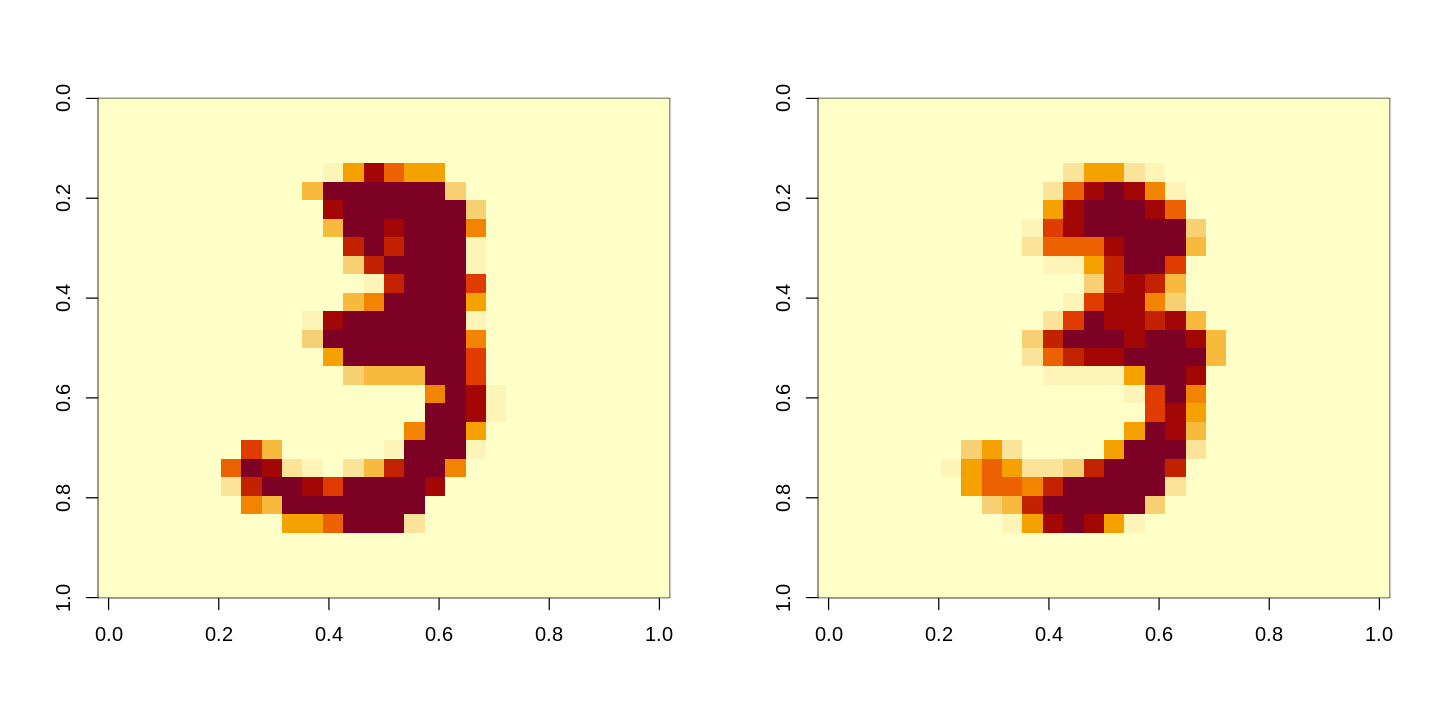

[1] "Epoch 70"
[1] "Training accuracy: 0.9289"
[1] "Validation accuracy: 0.910591059105911"


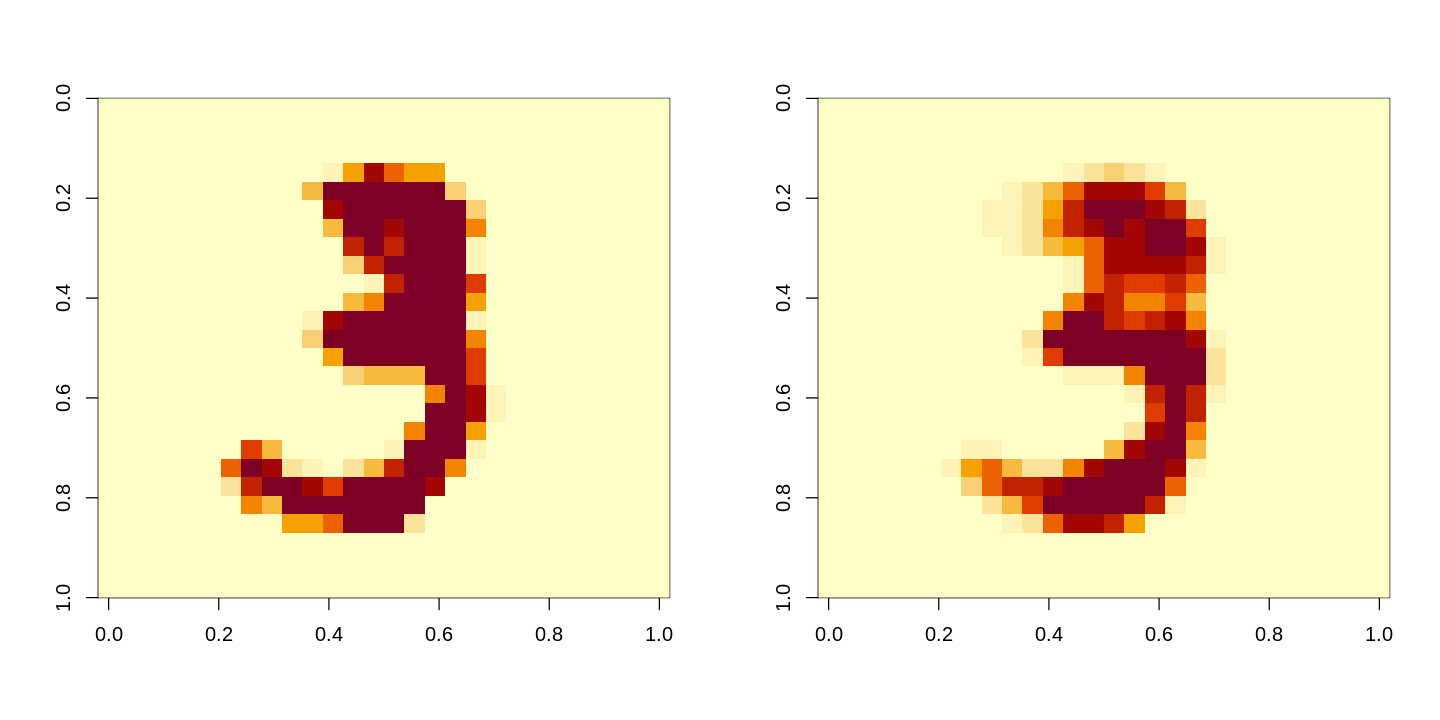

[1] "Epoch 71"
[1] "Training accuracy: 0.9289"
[1] "Validation accuracy: 0.913391339133913"


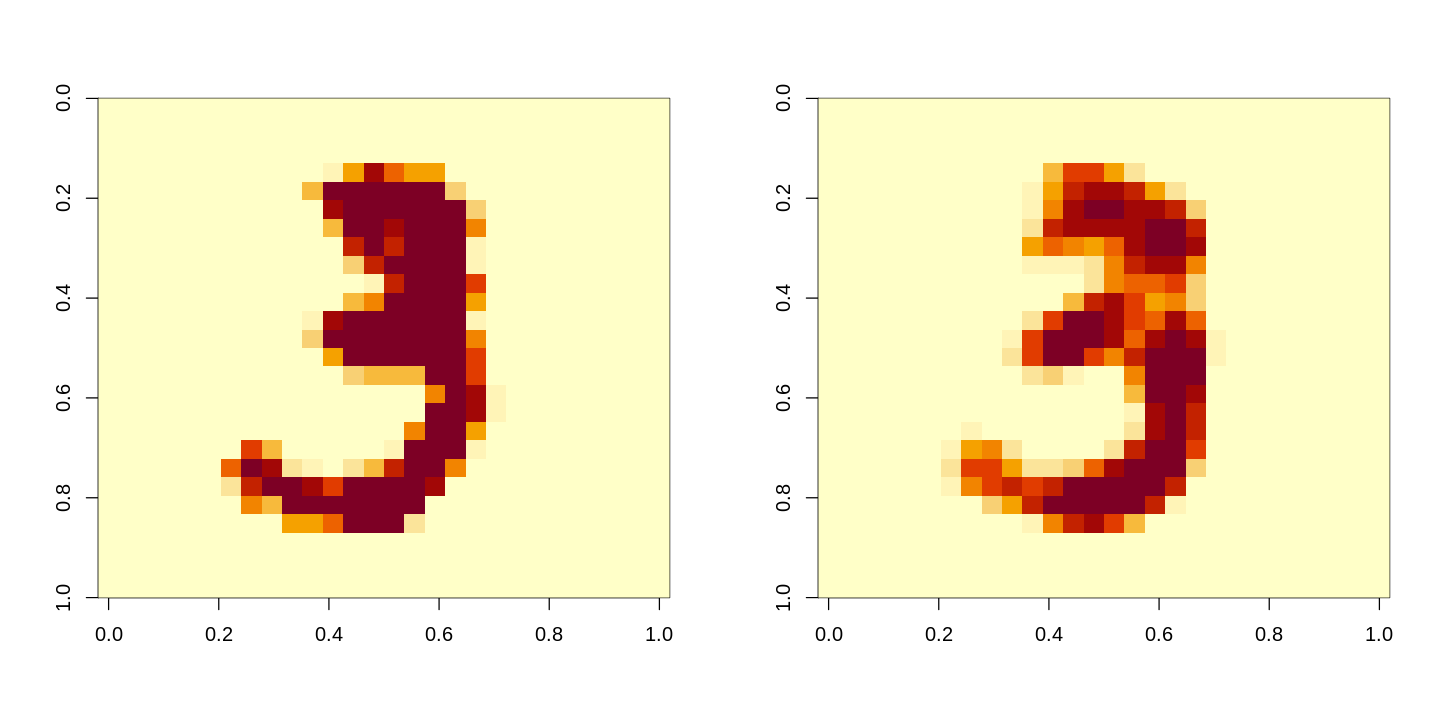

[1] "Epoch 72"
[1] "Training accuracy: 0.9298"
[1] "Validation accuracy: 0.914091409140914"


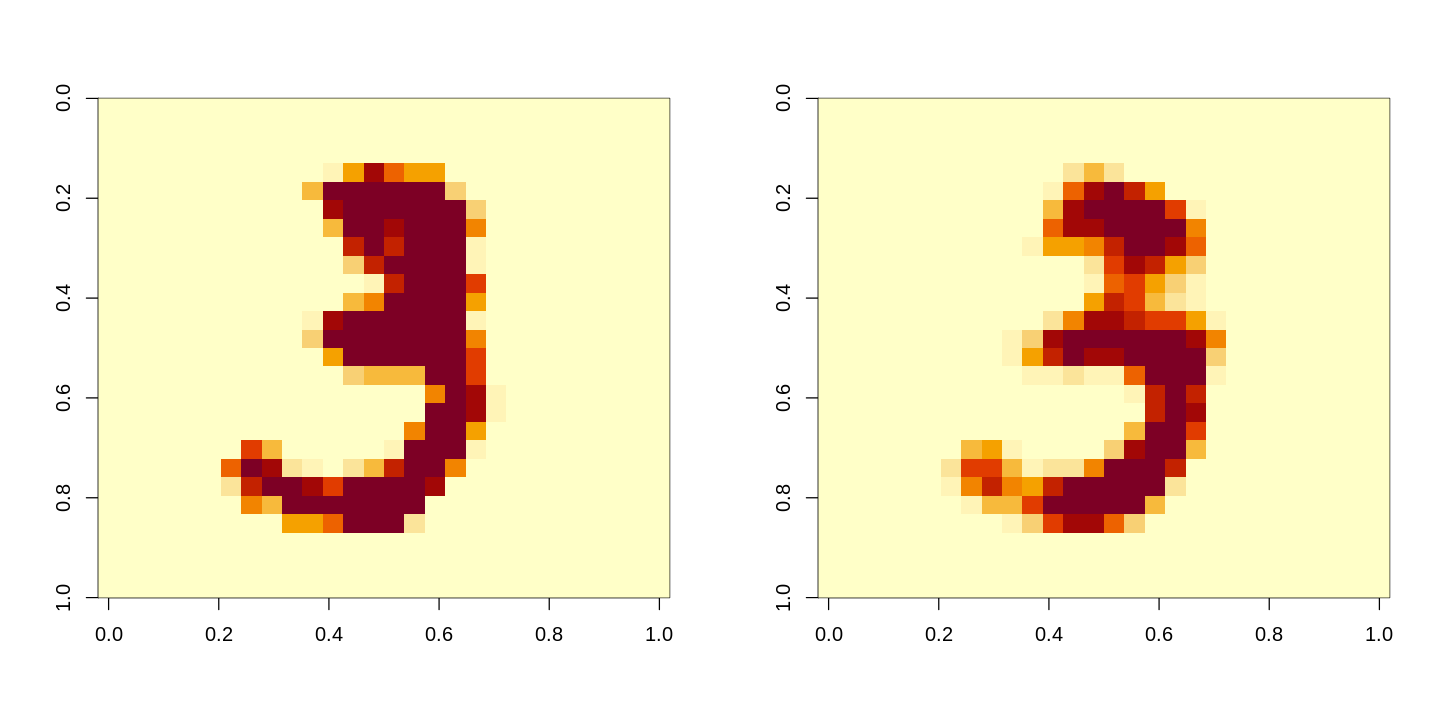

[1] "Epoch 73"
[1] "Training accuracy: 0.9294"
[1] "Validation accuracy: 0.913691369136914"


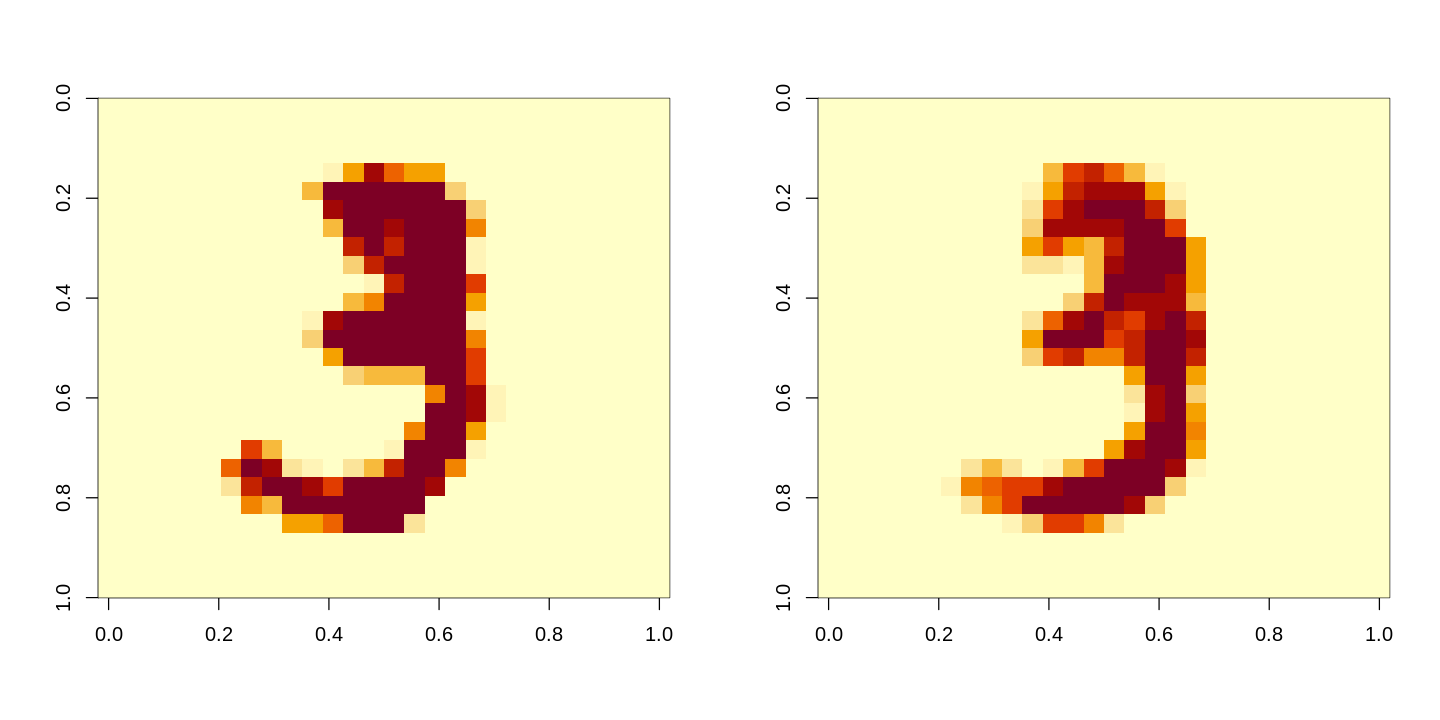

[1] "Epoch 74"
[1] "Training accuracy: 0.9269"
[1] "Validation accuracy: 0.910891089108911"


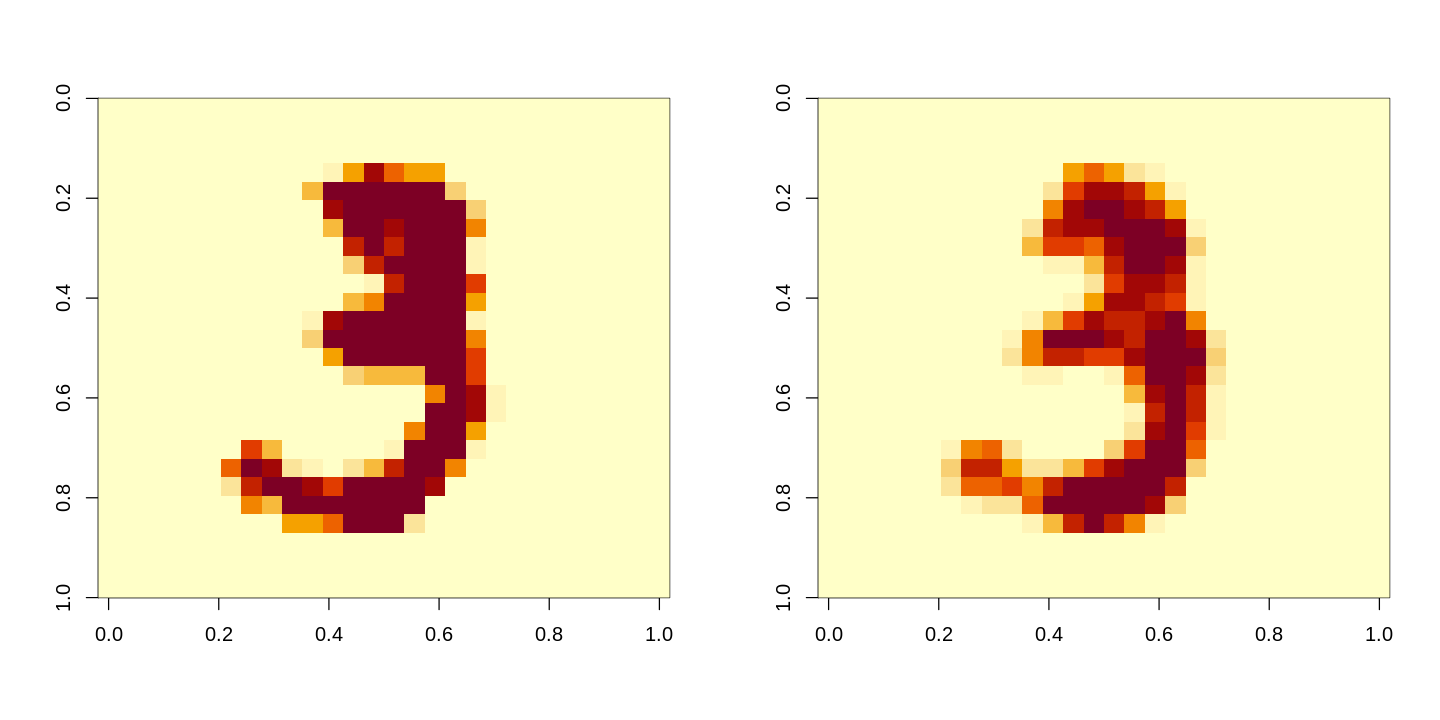

[1] "Epoch 75"
[1] "Training accuracy: 0.929"
[1] "Validation accuracy: 0.914391439143914"


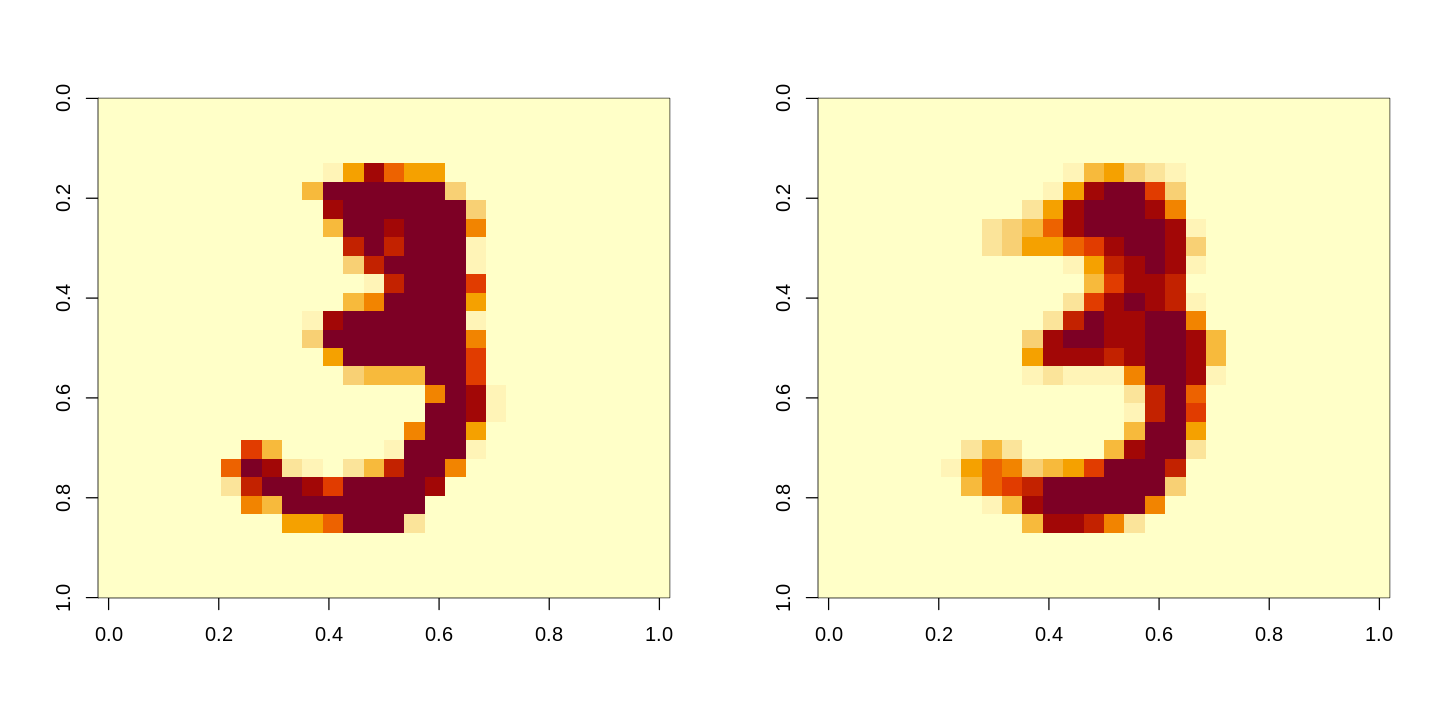

[1] "Epoch 76"
[1] "Training accuracy: 0.9278"
[1] "Validation accuracy: 0.913091309130913"


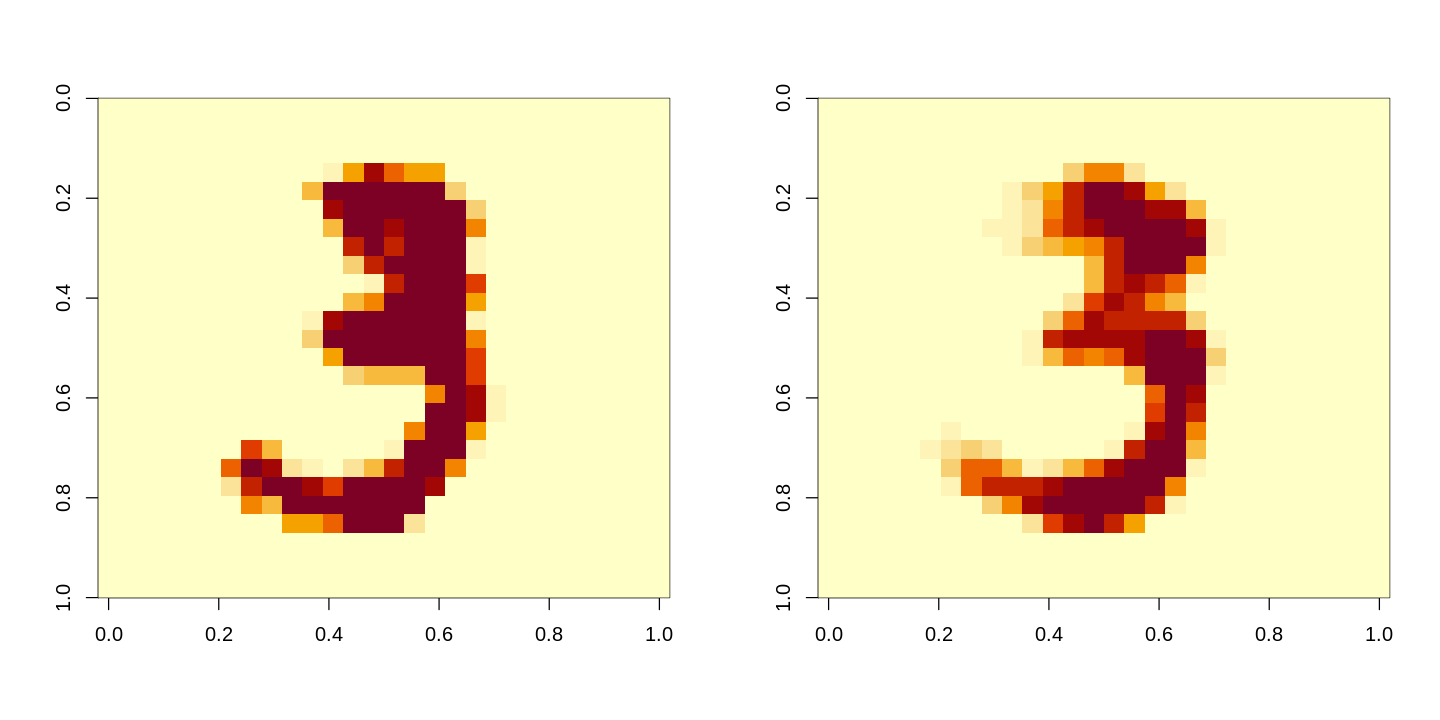

[1] "Epoch 77"
[1] "Training accuracy: 0.9268"
[1] "Validation accuracy: 0.909090909090909"


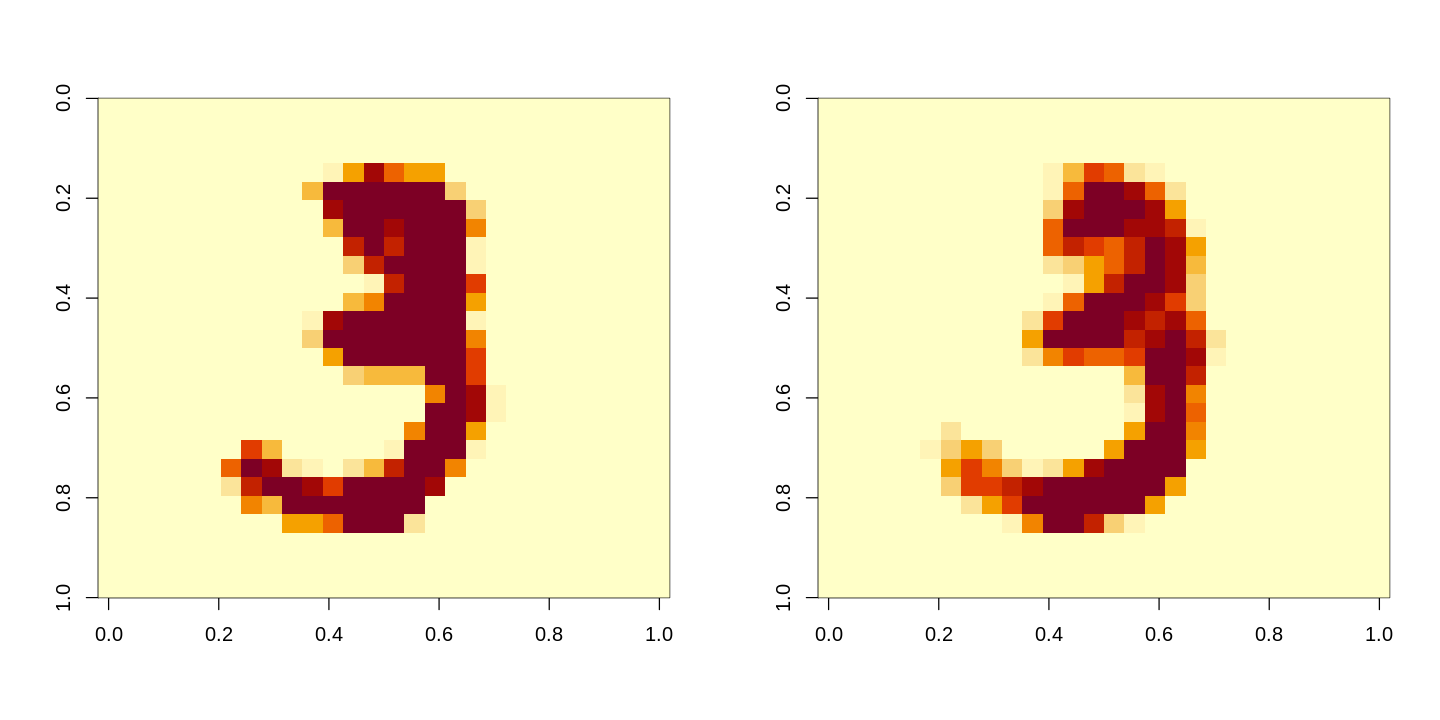

[1] "Epoch 78"
[1] "Training accuracy: 0.9283"
[1] "Validation accuracy: 0.911291129112911"


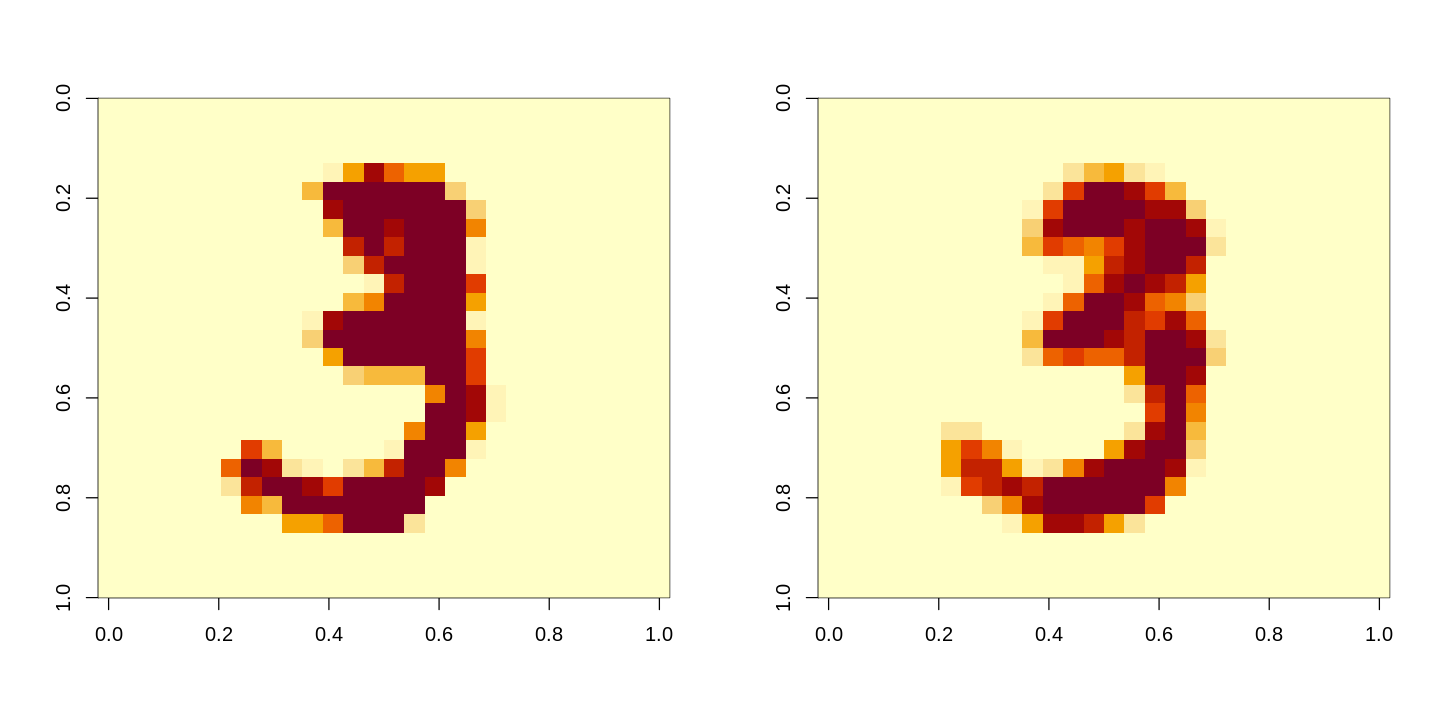

[1] "Epoch 79"
[1] "Training accuracy: 0.9283"
[1] "Validation accuracy: 0.909490949094909"


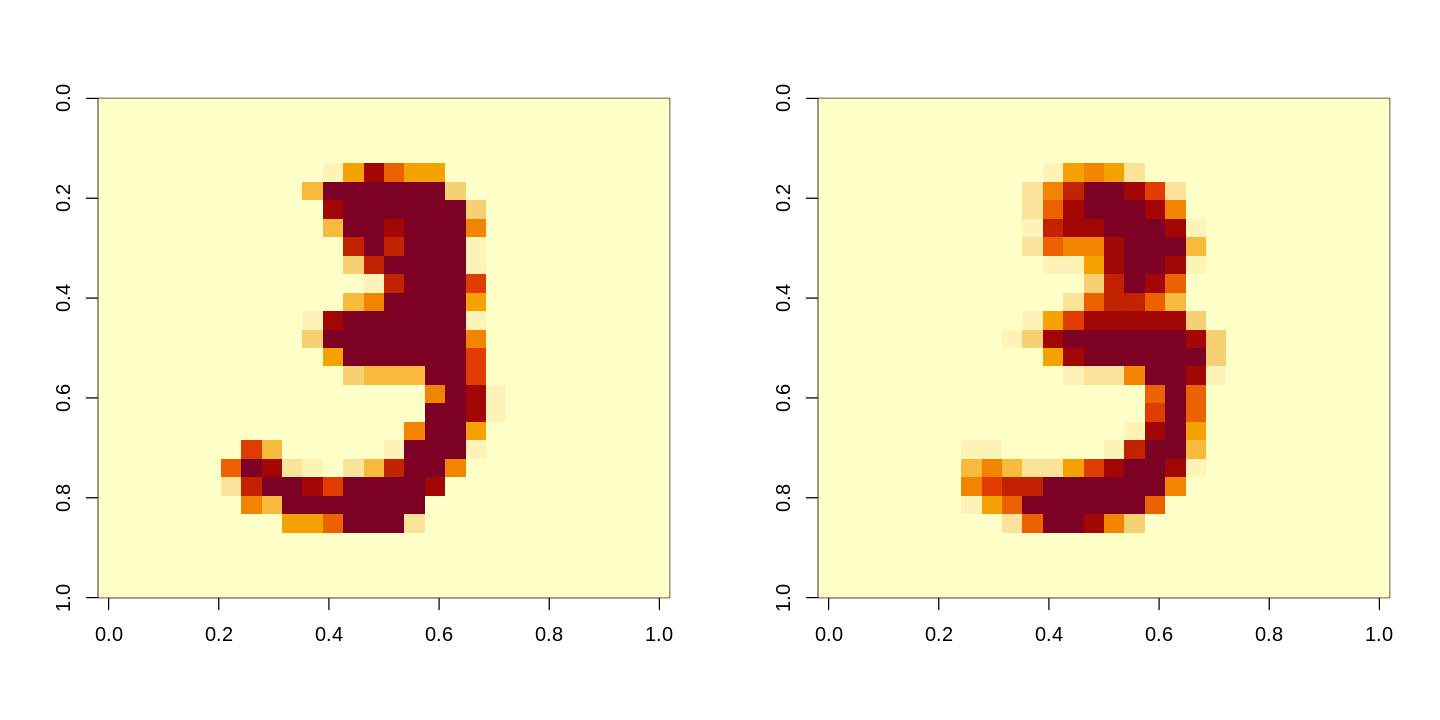

[1] "Epoch 80"
[1] "Training accuracy: 0.9276"
[1] "Validation accuracy: 0.909190919091909"


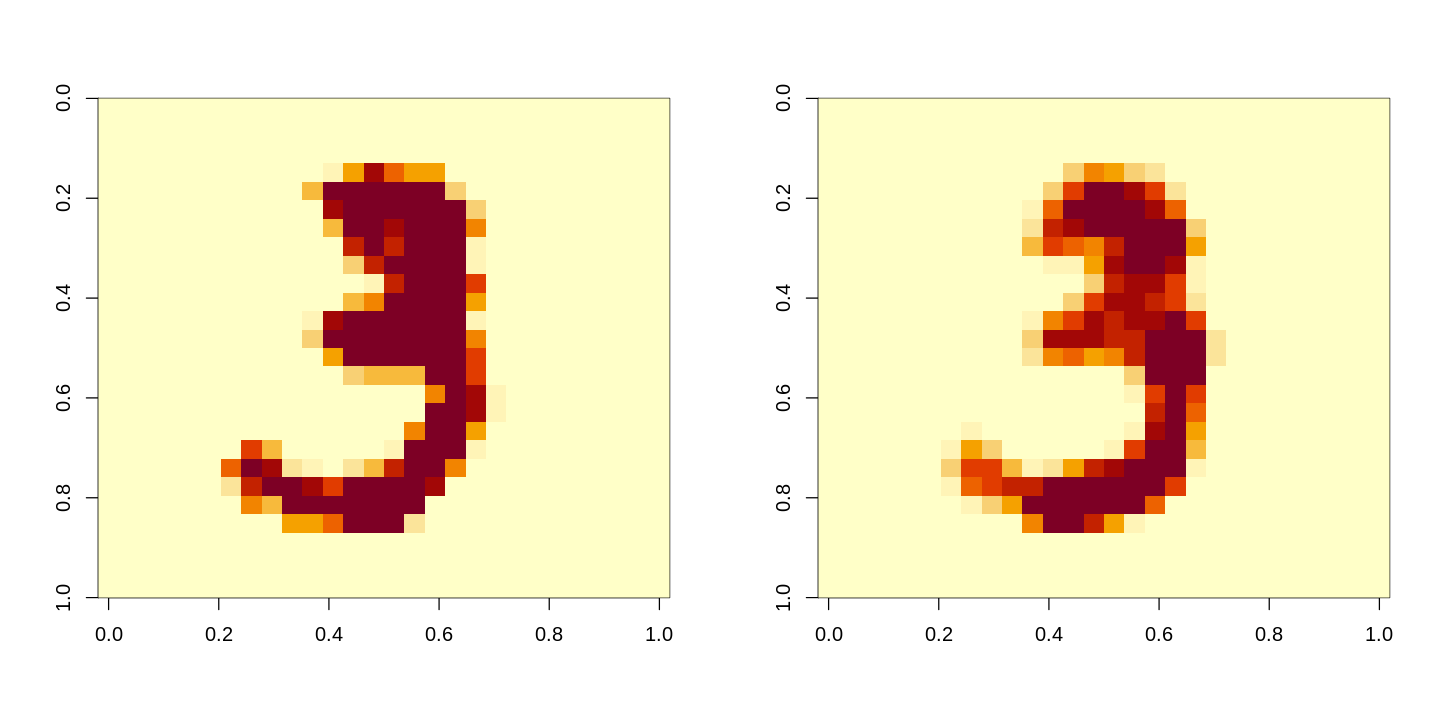

[1] "Epoch 81"
[1] "Training accuracy: 0.9276"
[1] "Validation accuracy: 0.913391339133913"


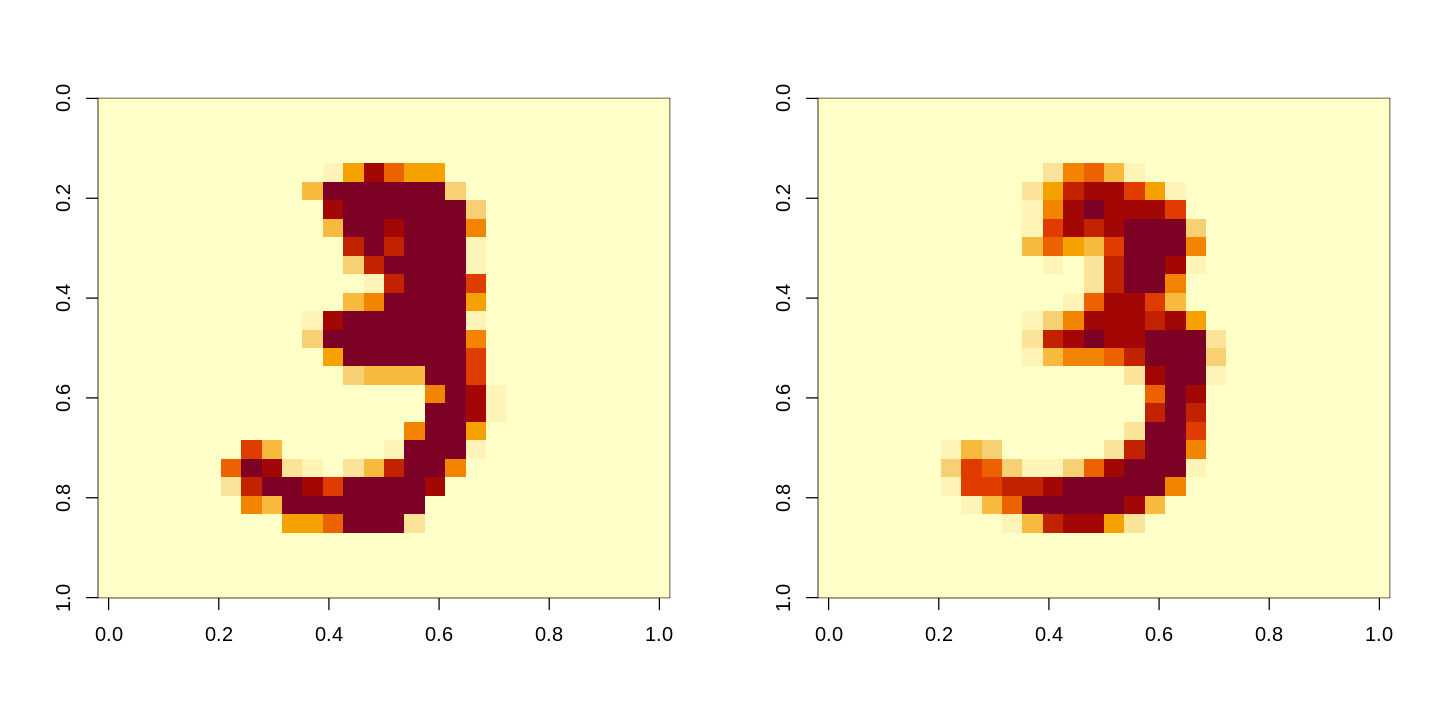

[1] "Epoch 82"
[1] "Training accuracy: 0.927"
[1] "Validation accuracy: 0.911191119111911"


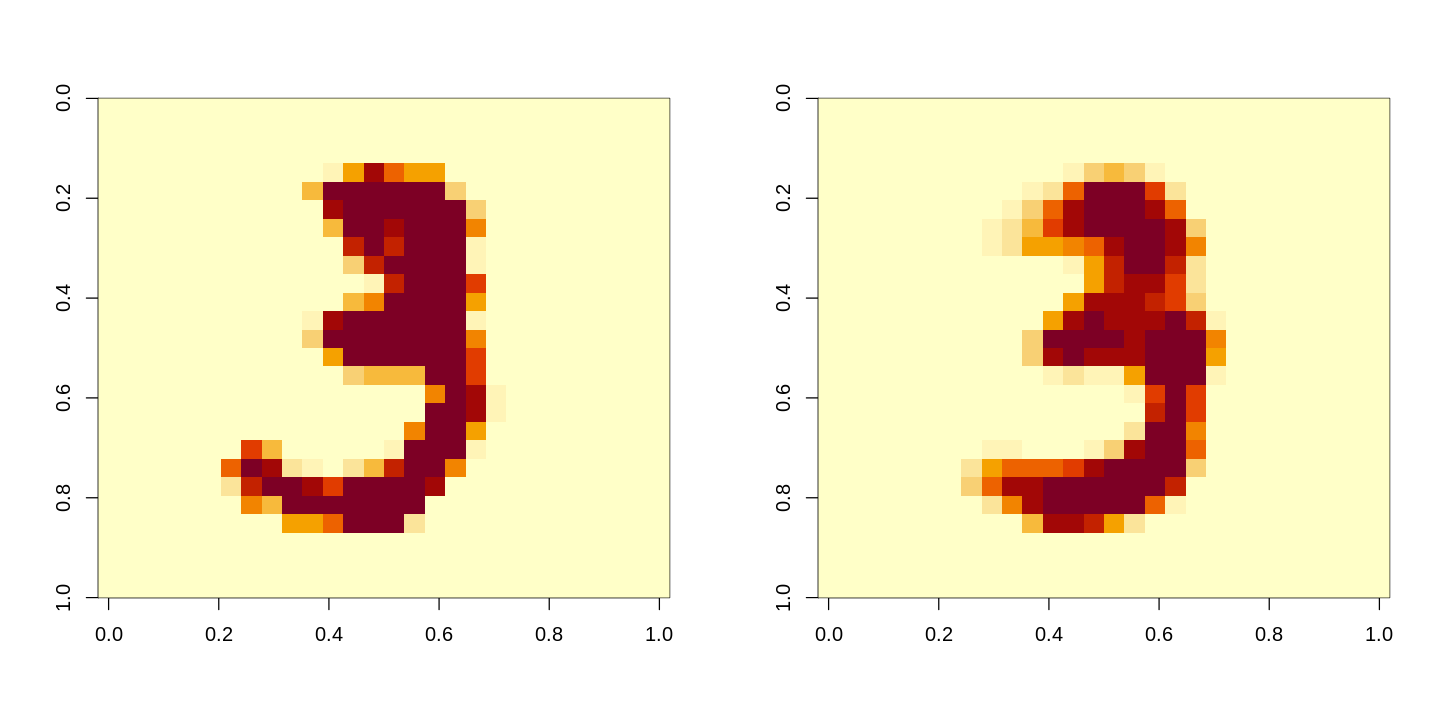

[1] "Epoch 83"
[1] "Training accuracy: 0.9275"
[1] "Validation accuracy: 0.911791179117912"


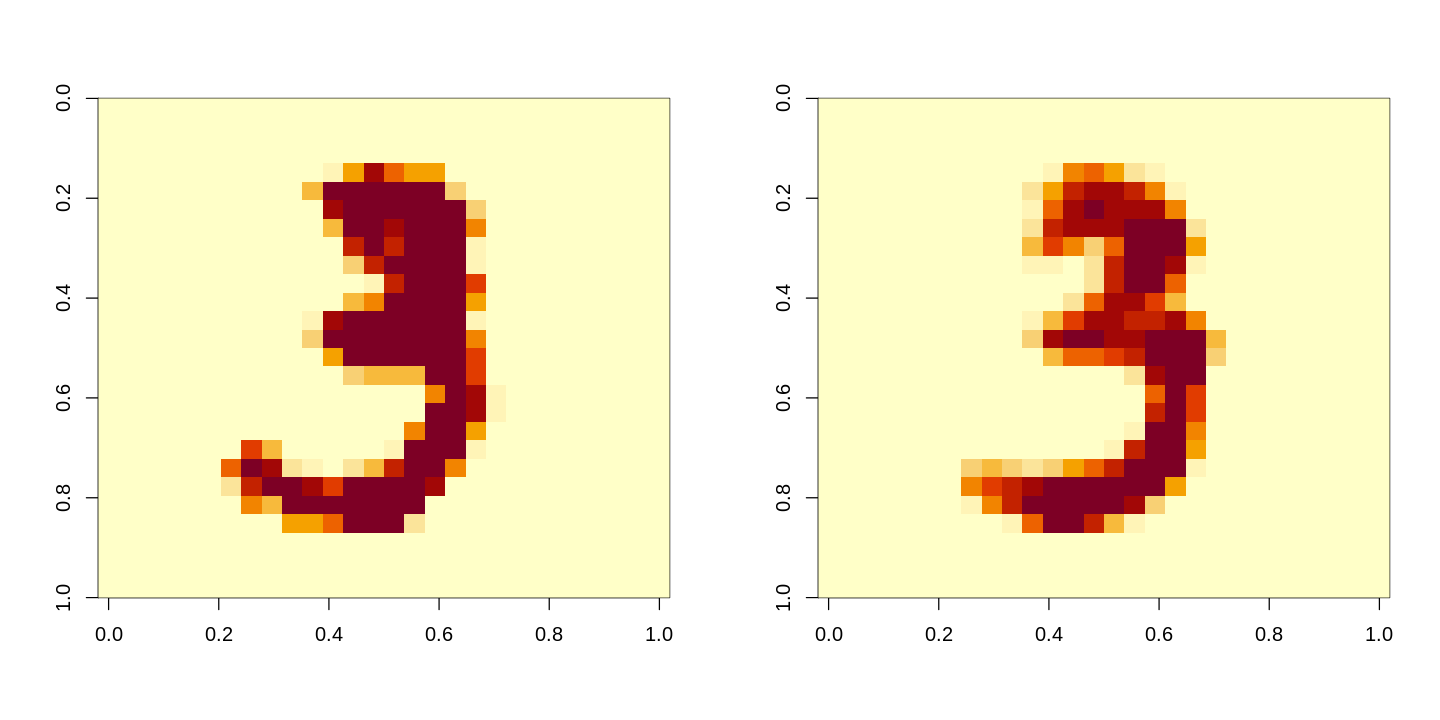

[1] "Epoch 84"
[1] "Training accuracy: 0.9281"
[1] "Validation accuracy: 0.912791279127913"


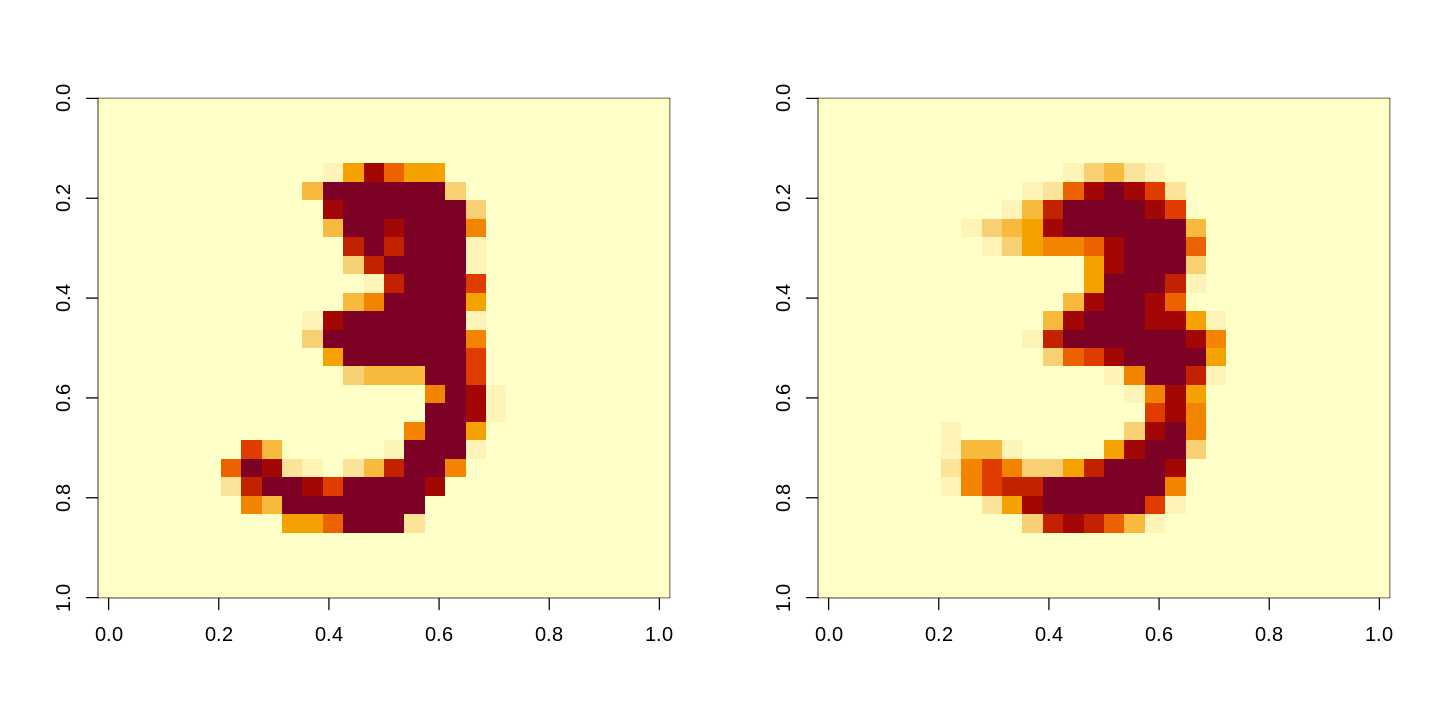

[1] "Epoch 85"
[1] "Training accuracy: 0.9278"
[1] "Validation accuracy: 0.910591059105911"


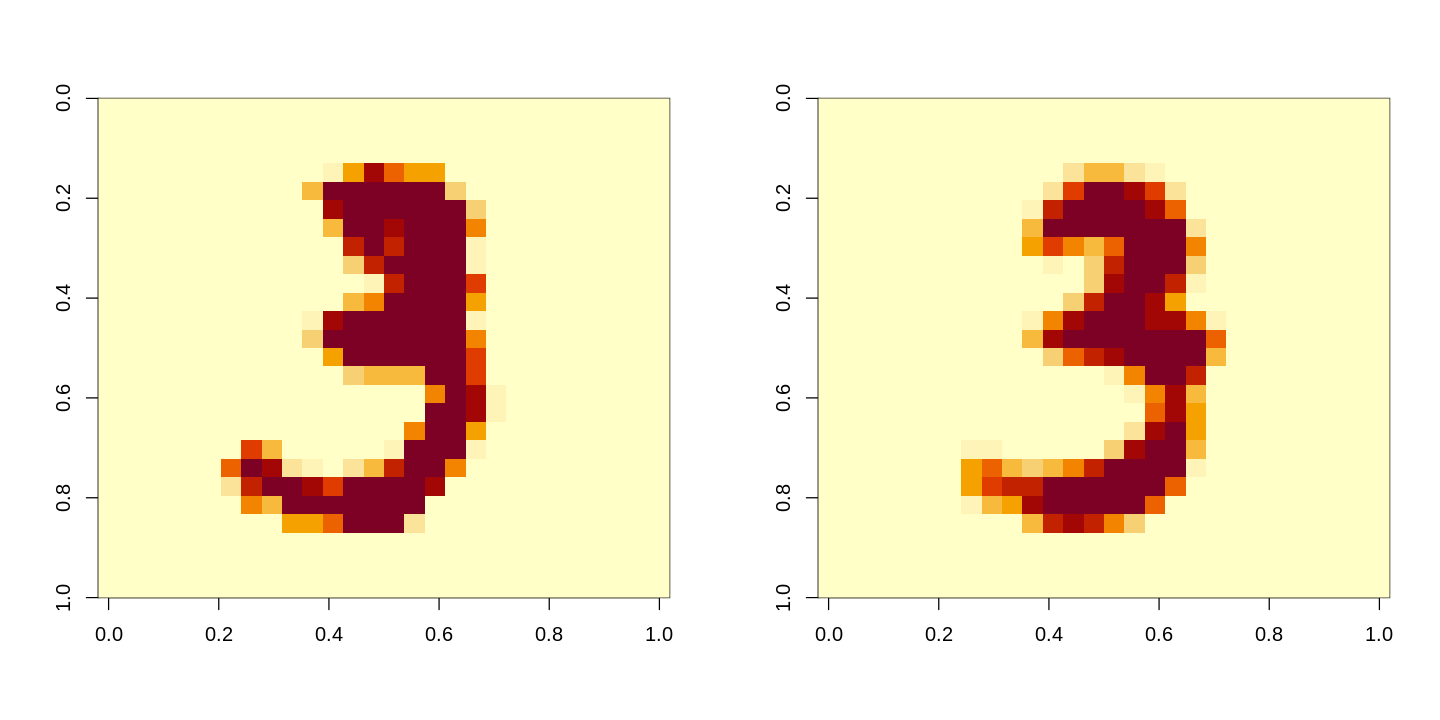

[1] "Epoch 86"
[1] "Training accuracy: 0.9265"
[1] "Validation accuracy: 0.91029102910291"


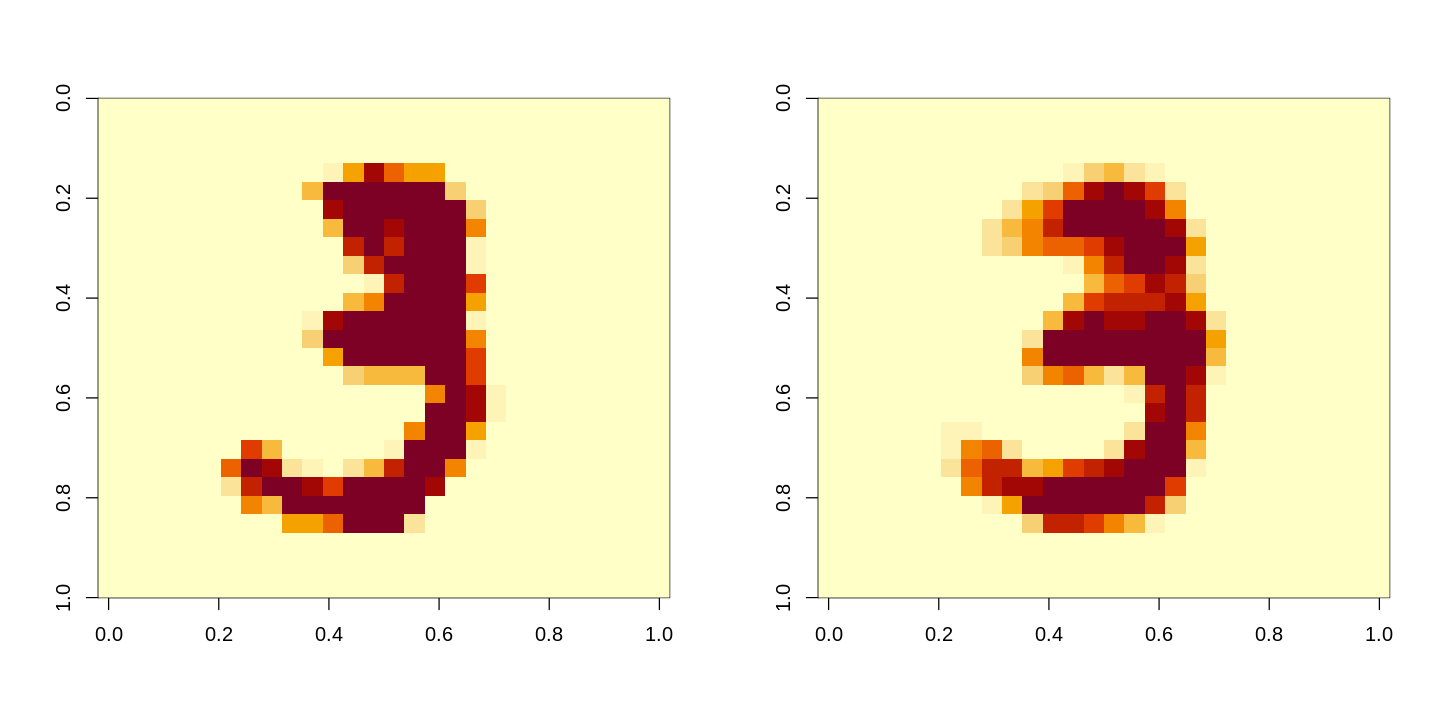

[1] "Epoch 87"
[1] "Training accuracy: 0.9297"
[1] "Validation accuracy: 0.910991099109911"


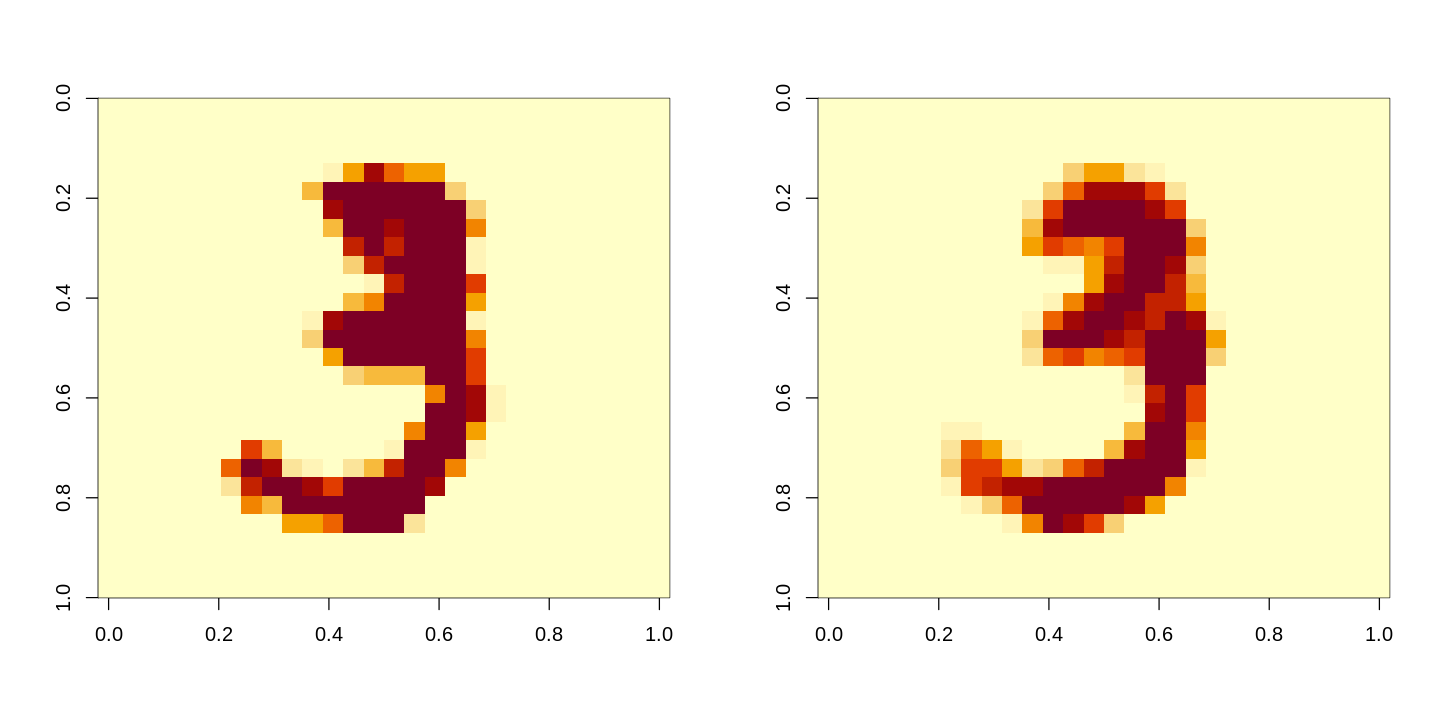

[1] "Epoch 88"
[1] "Training accuracy: 0.9245"
[1] "Validation accuracy: 0.907690769076908"


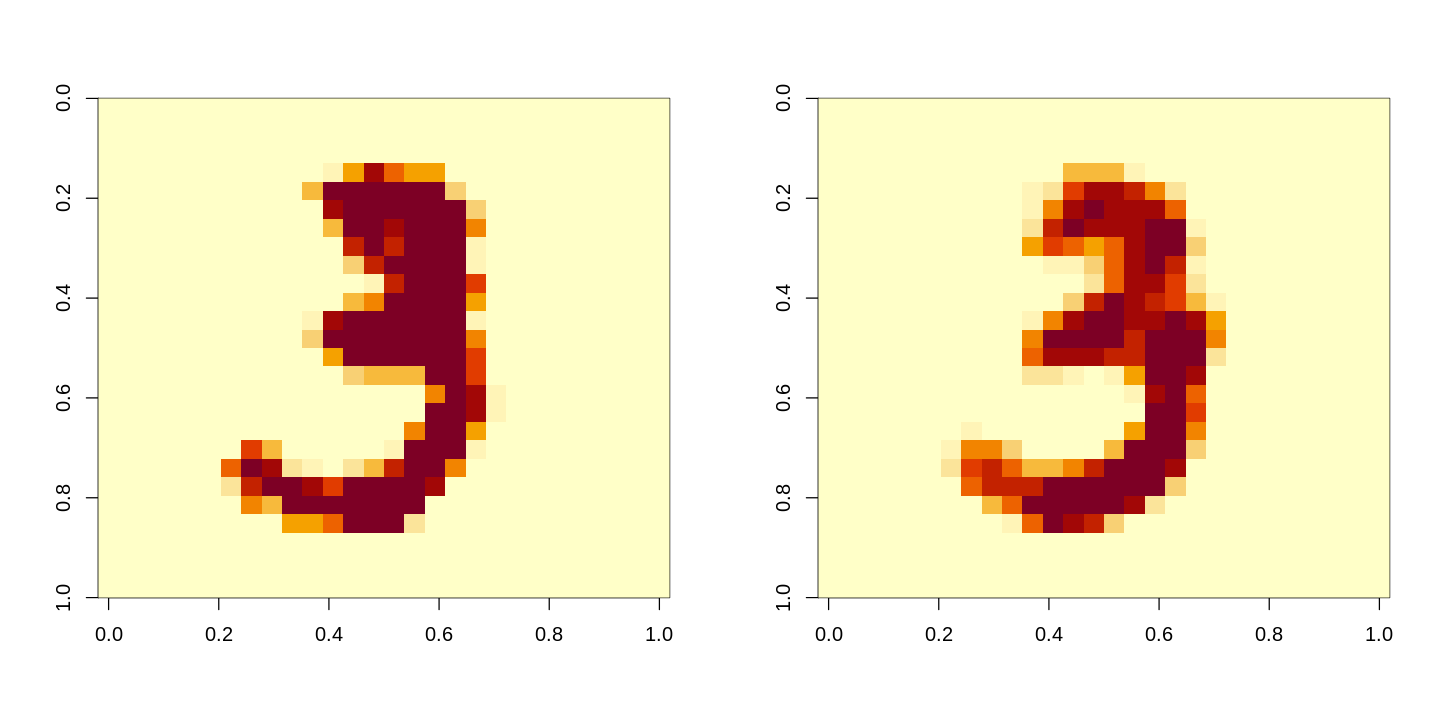

[1] "Epoch 89"
[1] "Training accuracy: 0.927"
[1] "Validation accuracy: 0.909190919091909"


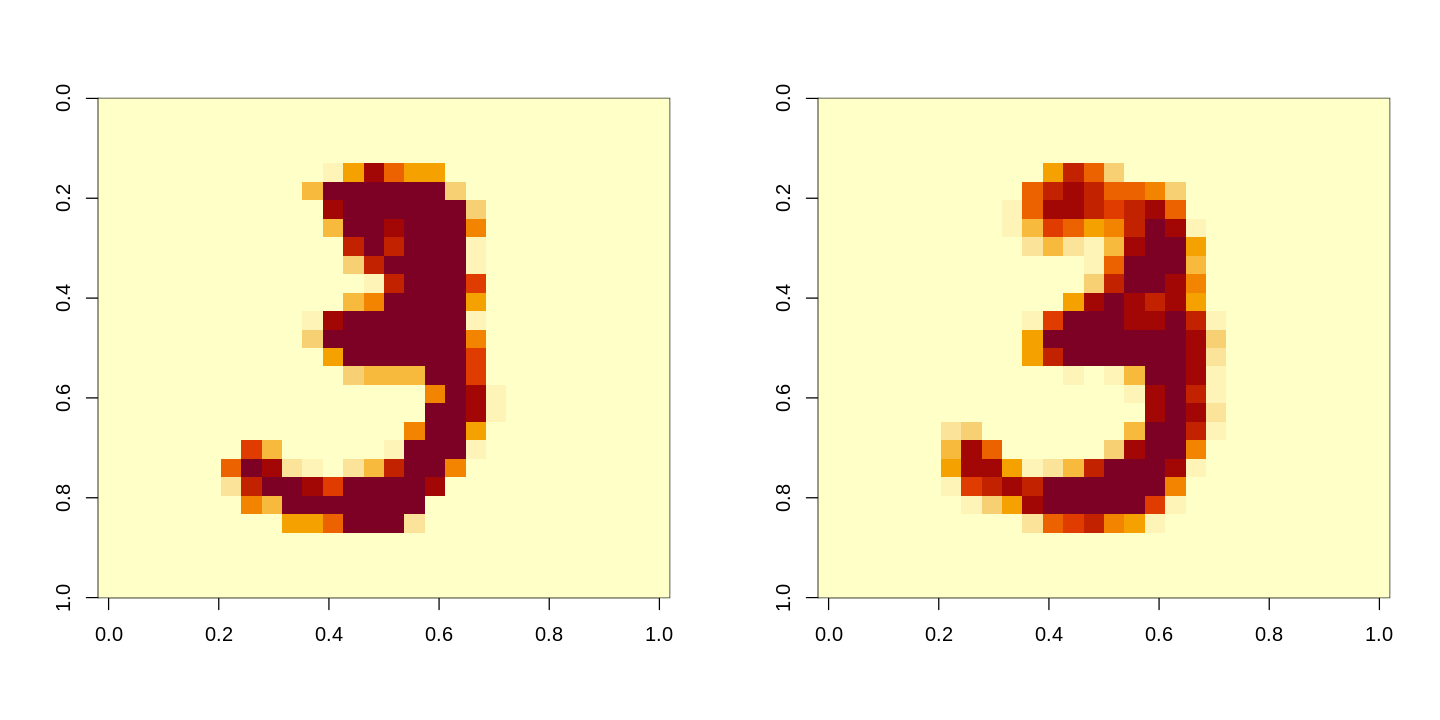

[1] "Epoch 90"
[1] "Training accuracy: 0.9261"
[1] "Validation accuracy: 0.911091109110911"


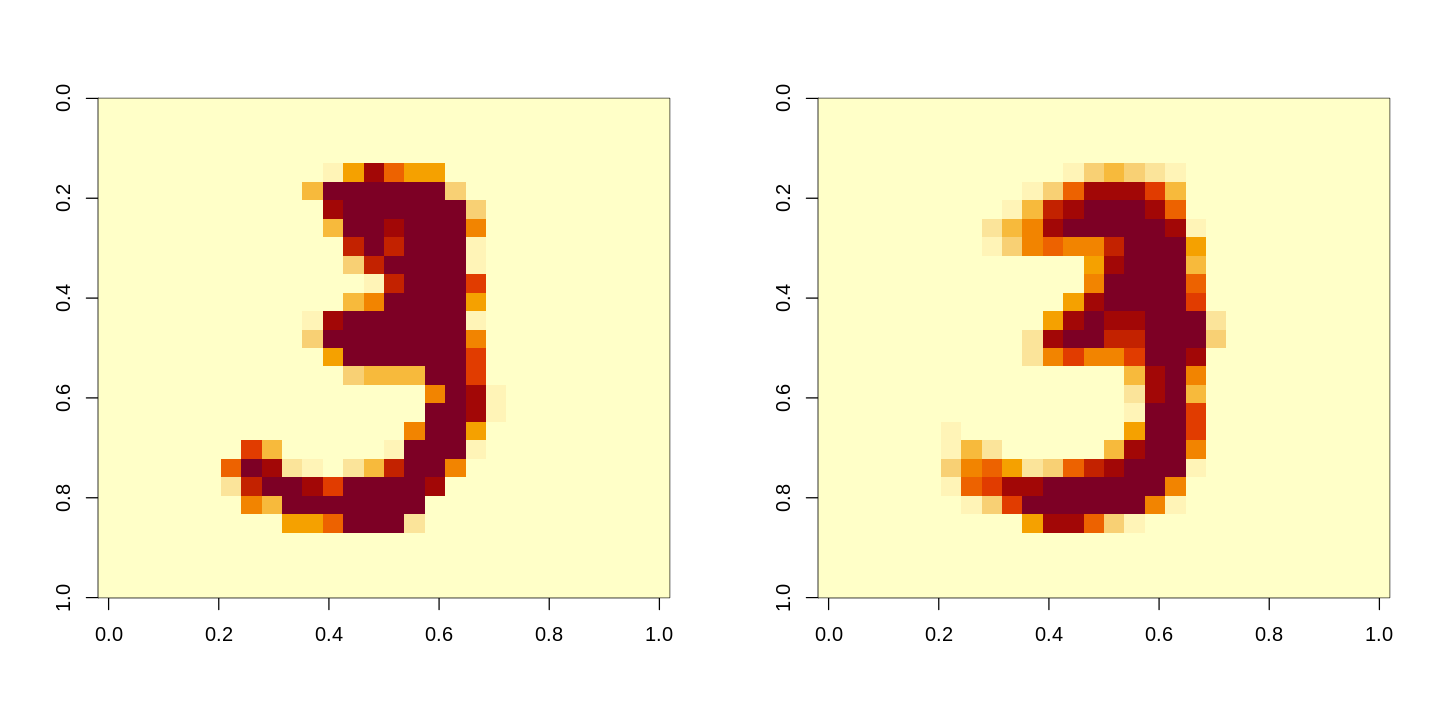

[1] "Epoch 91"
[1] "Training accuracy: 0.9268"
[1] "Validation accuracy: 0.908890889088909"


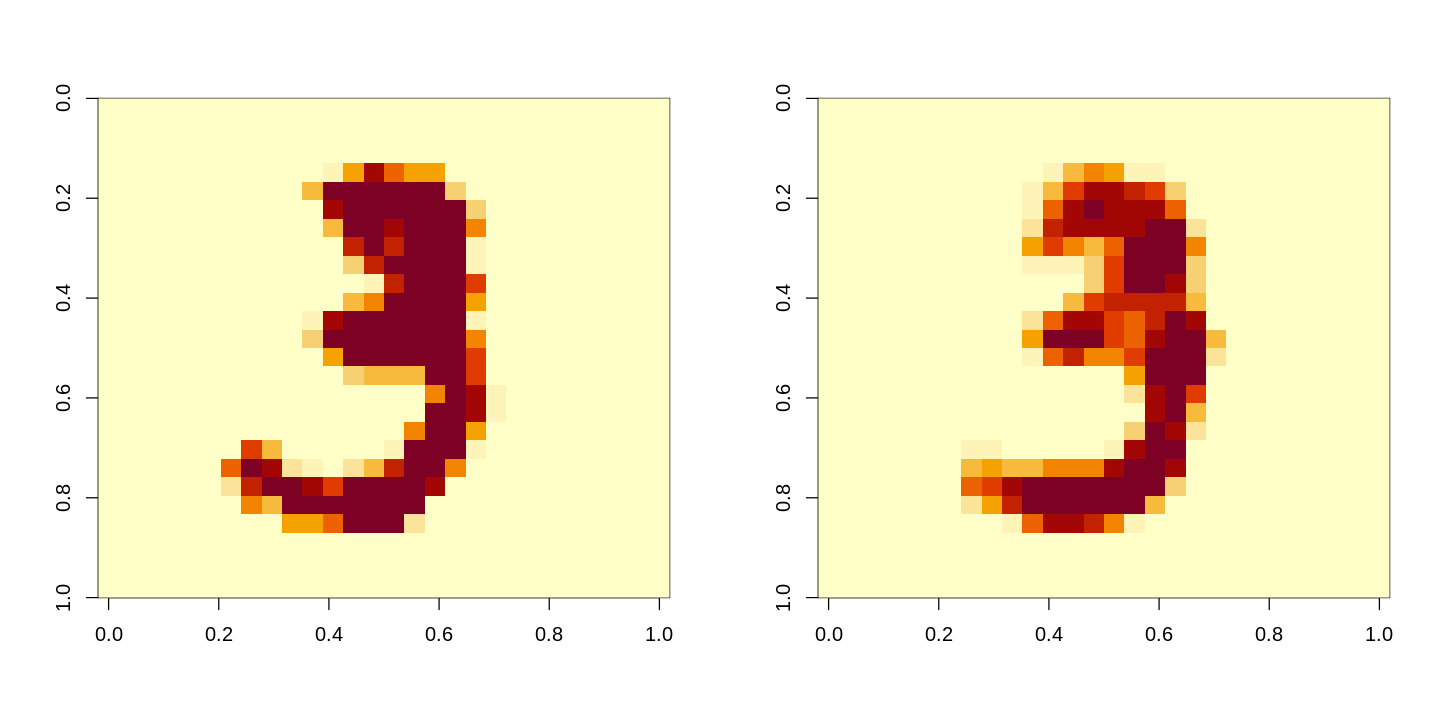

[1] "Epoch 92"
[1] "Training accuracy: 0.9267"
[1] "Validation accuracy: 0.910691069106911"


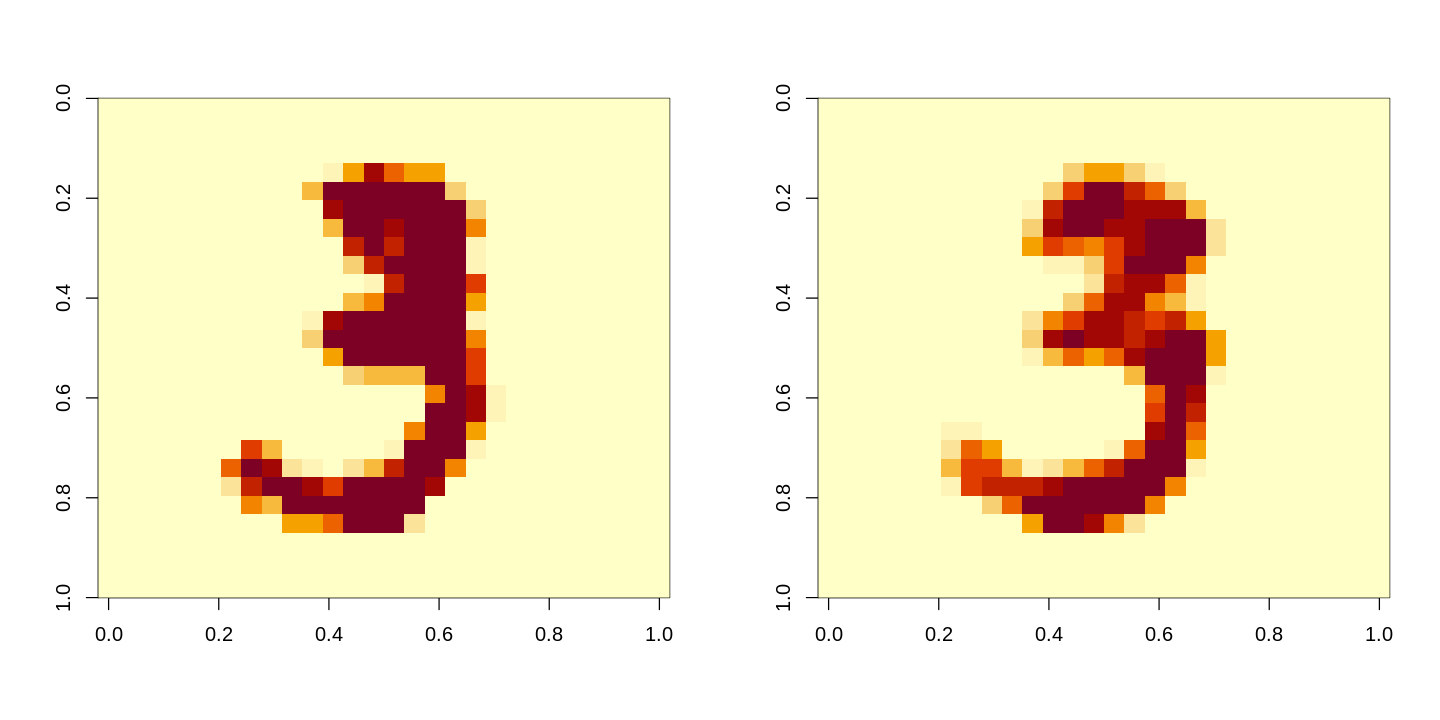

[1] "Epoch 93"
[1] "Training accuracy: 0.9274"
[1] "Validation accuracy: 0.912591259125913"


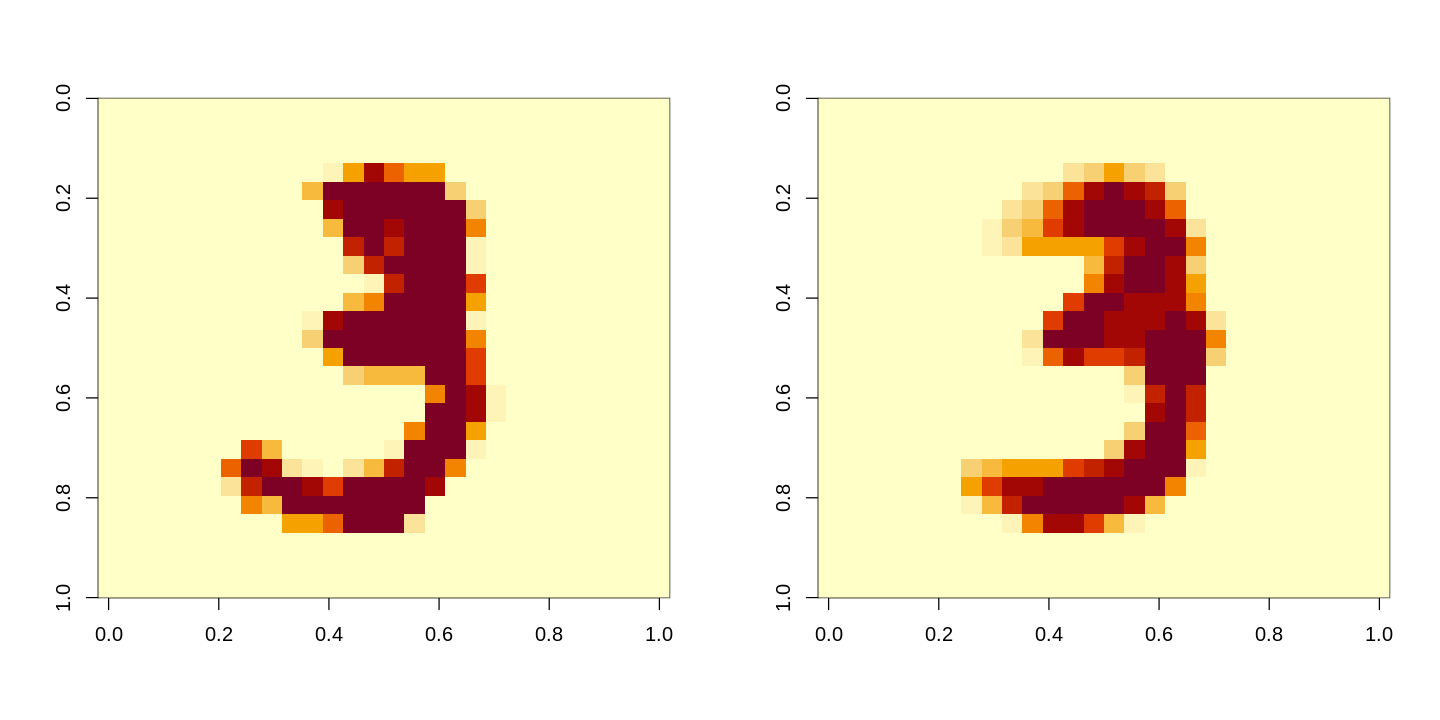

[1] "Epoch 94"
[1] "Training accuracy: 0.9226"
[1] "Validation accuracy: 0.904490449044904"


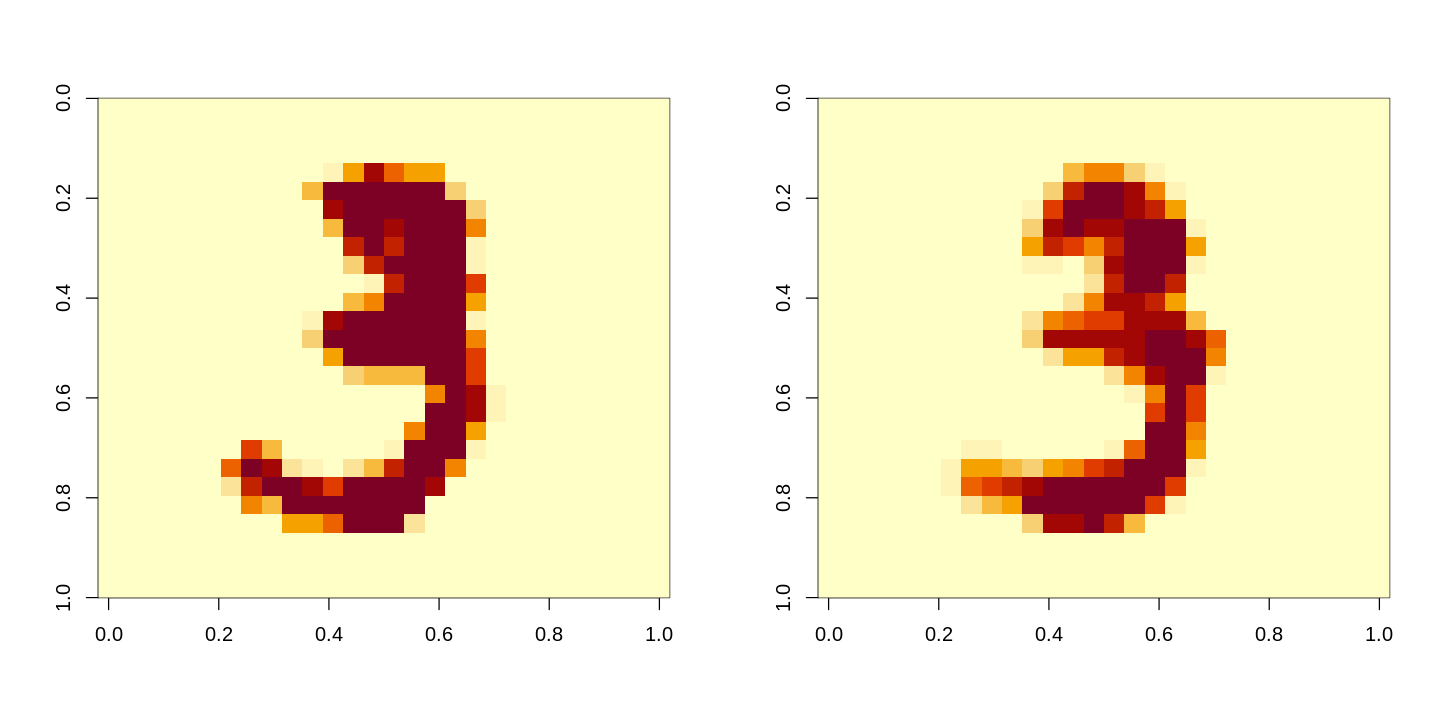

[1] "Epoch 95"
[1] "Training accuracy: 0.9244"
[1] "Validation accuracy: 0.908090809080908"


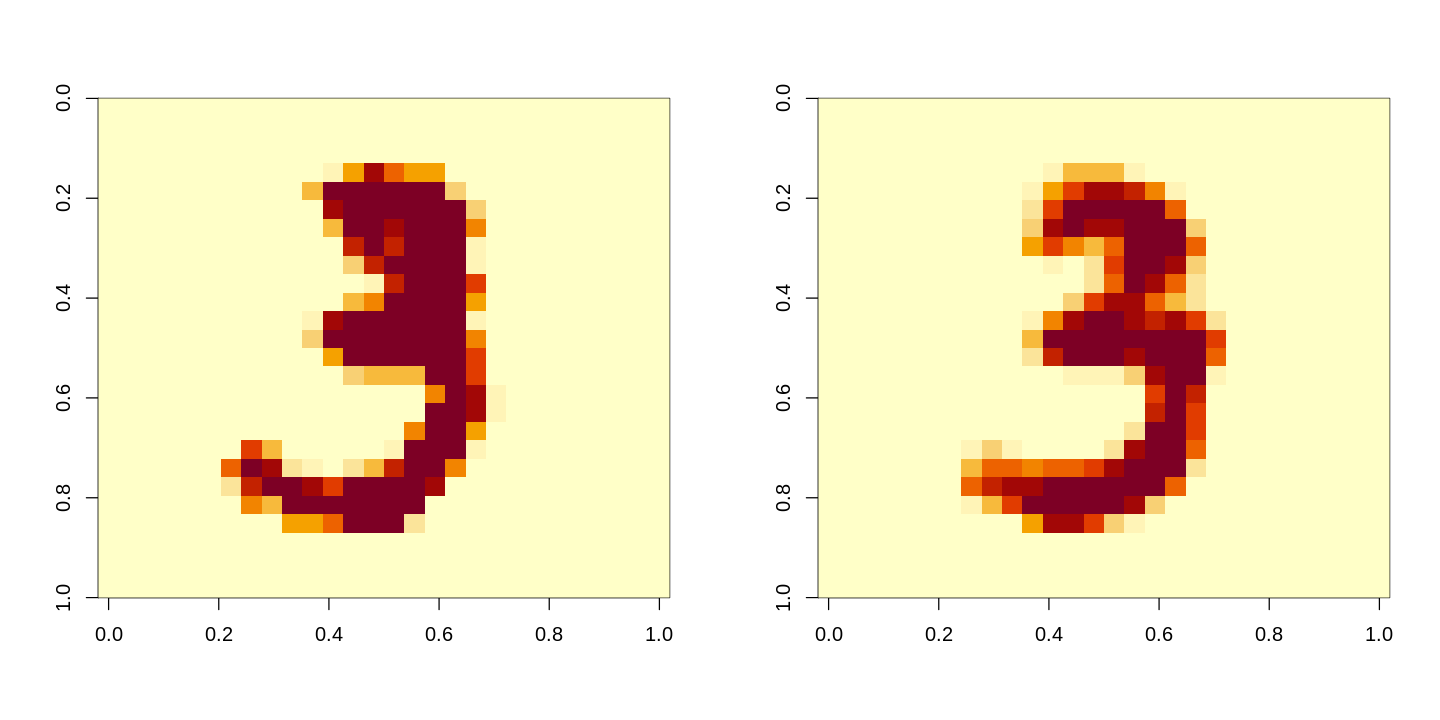

[1] "Epoch 96"
[1] "Training accuracy: 0.9229"
[1] "Validation accuracy: 0.904390439043904"


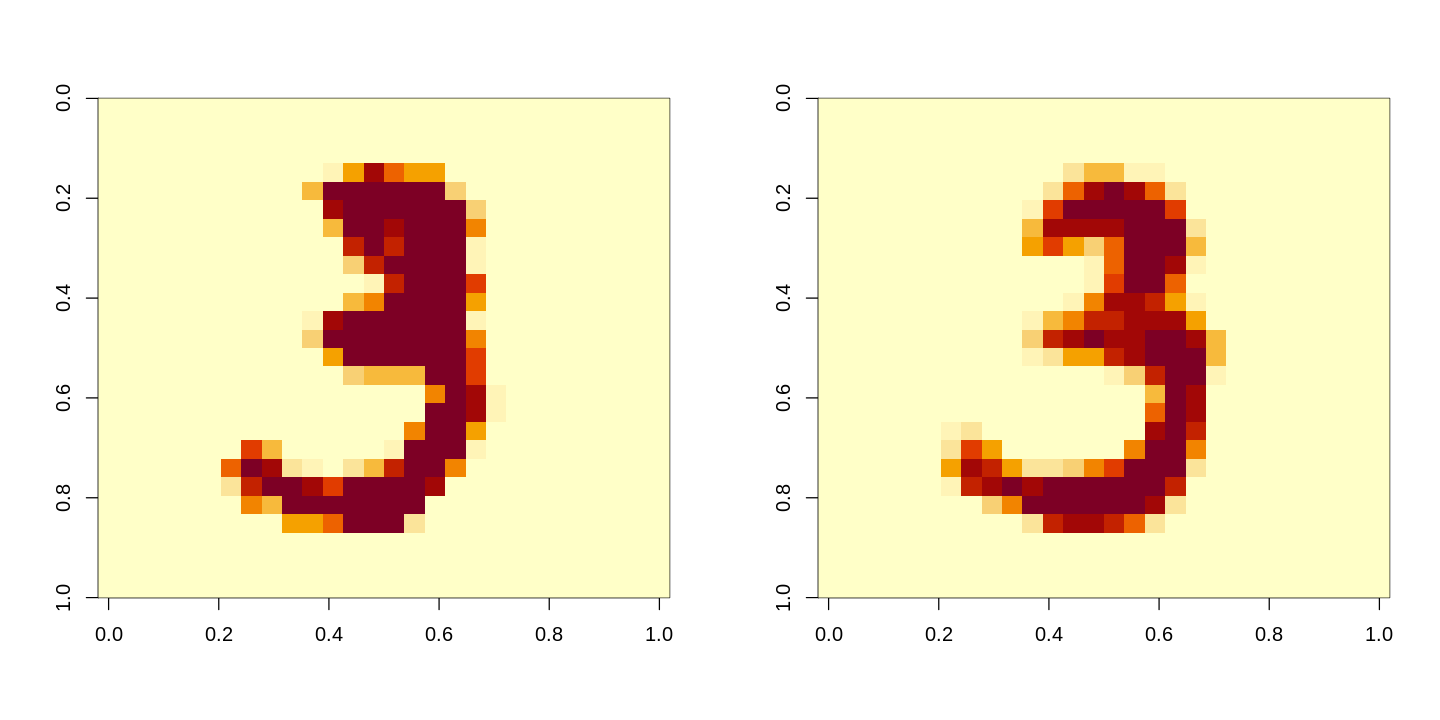

[1] "Epoch 97"
[1] "Training accuracy: 0.9287"
[1] "Validation accuracy: 0.907990799079908"


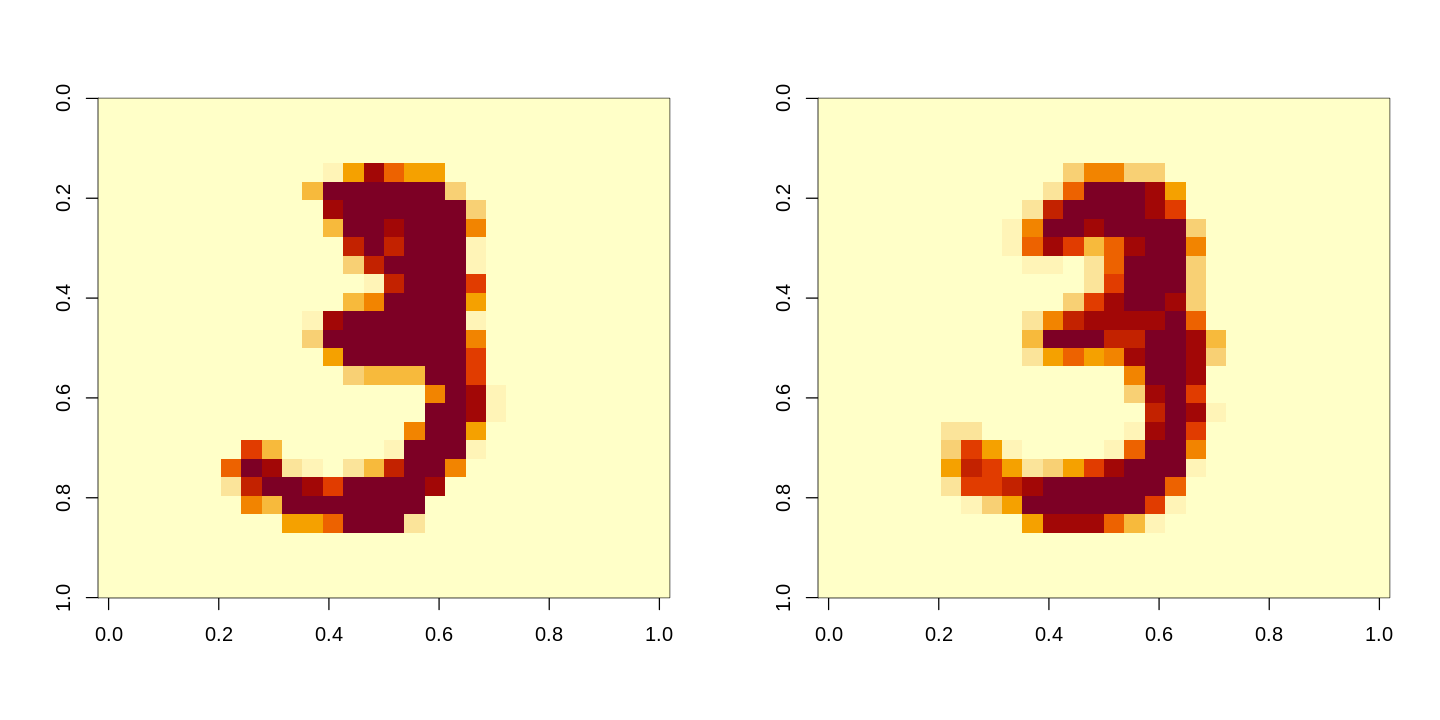

[1] "Epoch 98"
[1] "Training accuracy: 0.9265"
[1] "Validation accuracy: 0.905490549054905"


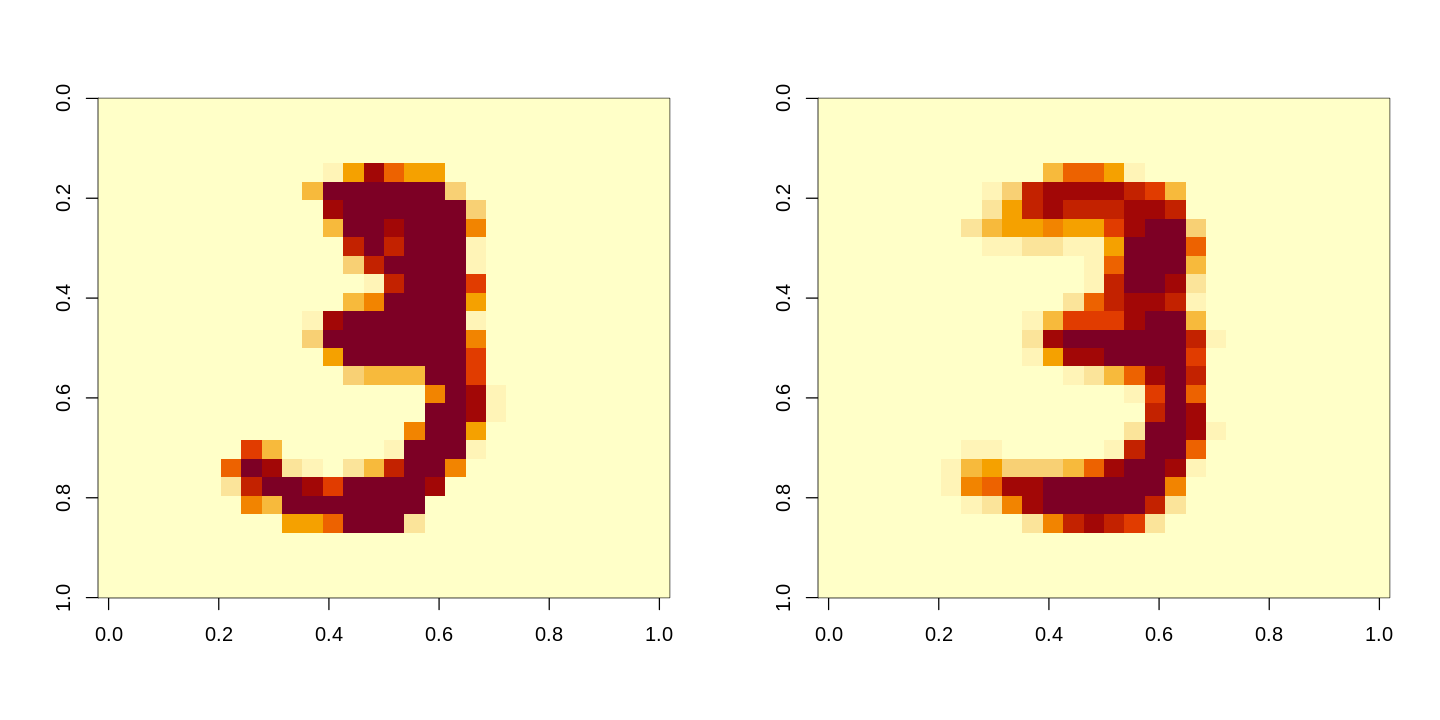

[1] "Epoch 99"
[1] "Training accuracy: 0.9255"
[1] "Validation accuracy: 0.908190819081908"


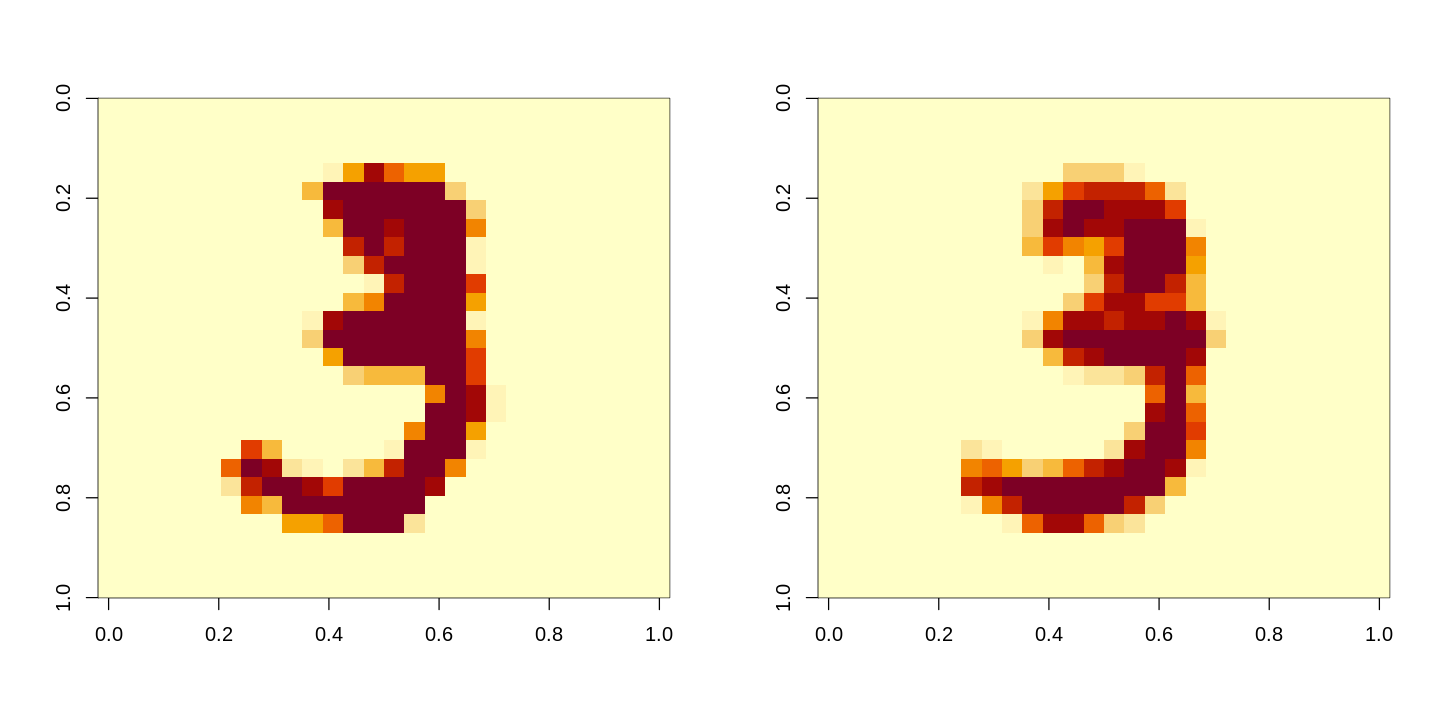

[1] "Epoch 100"
[1] "Training accuracy: 0.9262"
[1] "Validation accuracy: 0.909490949094909"


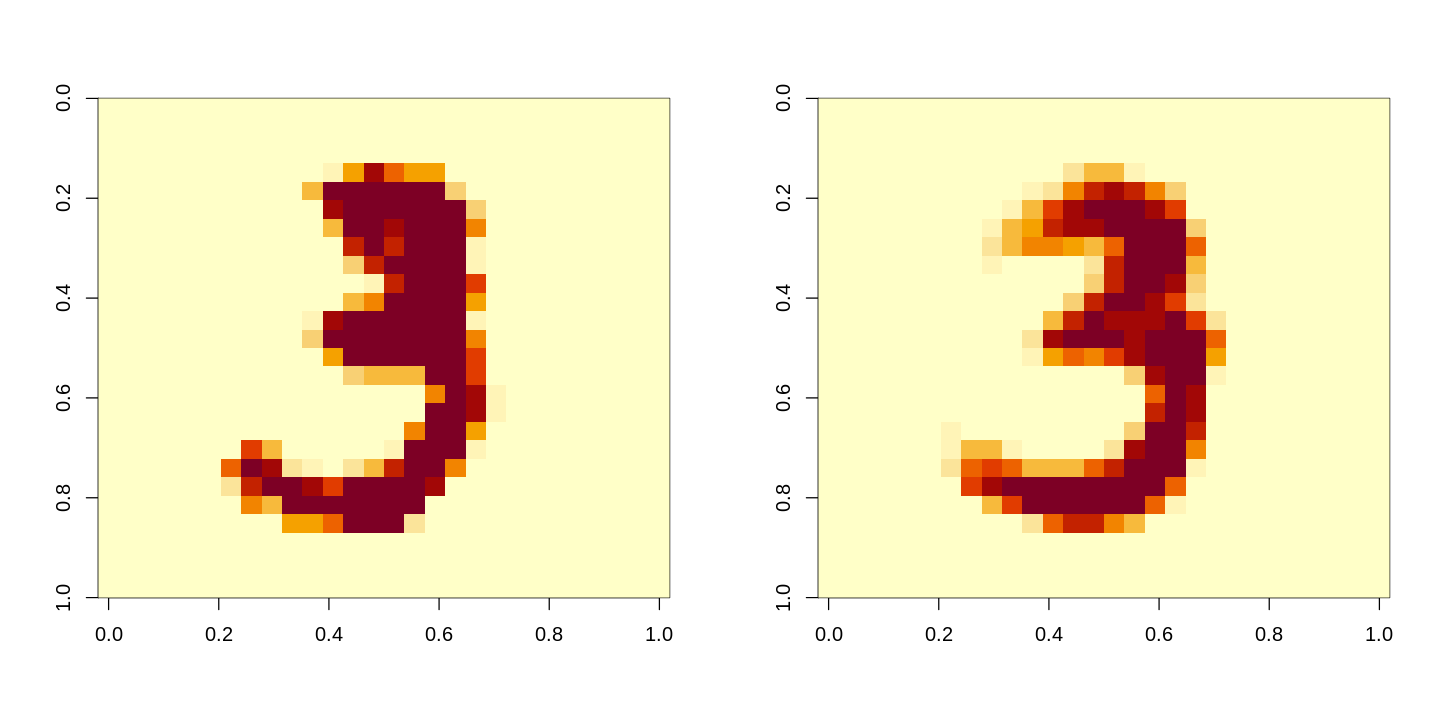

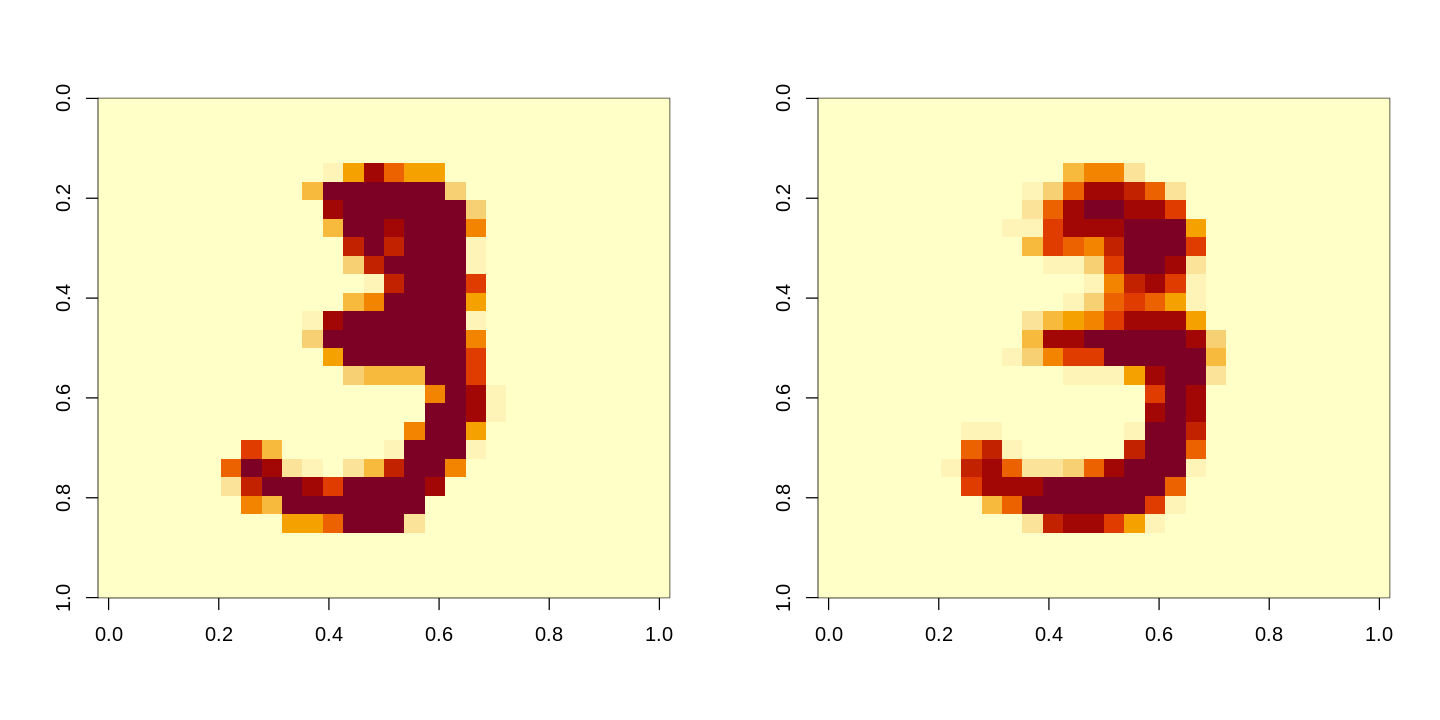

In [ ]:
rbm_gen_adam = RBM_training(x = x_train, y = y_train,
                       n.hidden = 100, 
                       x_val = x_val, y_val = y_val, 
                       type = 'generative',
                       alpha = 0.01, 
                       lr = 0.01,
                       n.epoch = 100,
                       batch.size = 100, 
                       opt = 'Adam', 
                       mu = 0.5, #for Momentum
                       beta1 = 0.9, #for Adam
                       beta2 = 0.999, #for Adam
                       eps = 1e-8, #for Adam
                       sample_rec = 5 #sample observation for inspecting reconstruction during Generative training
)

### Momentum

[1] "Epoch 1"
[1] "Training accuracy: 0.1138"
[1] "Validation accuracy: 0.115511551155116"


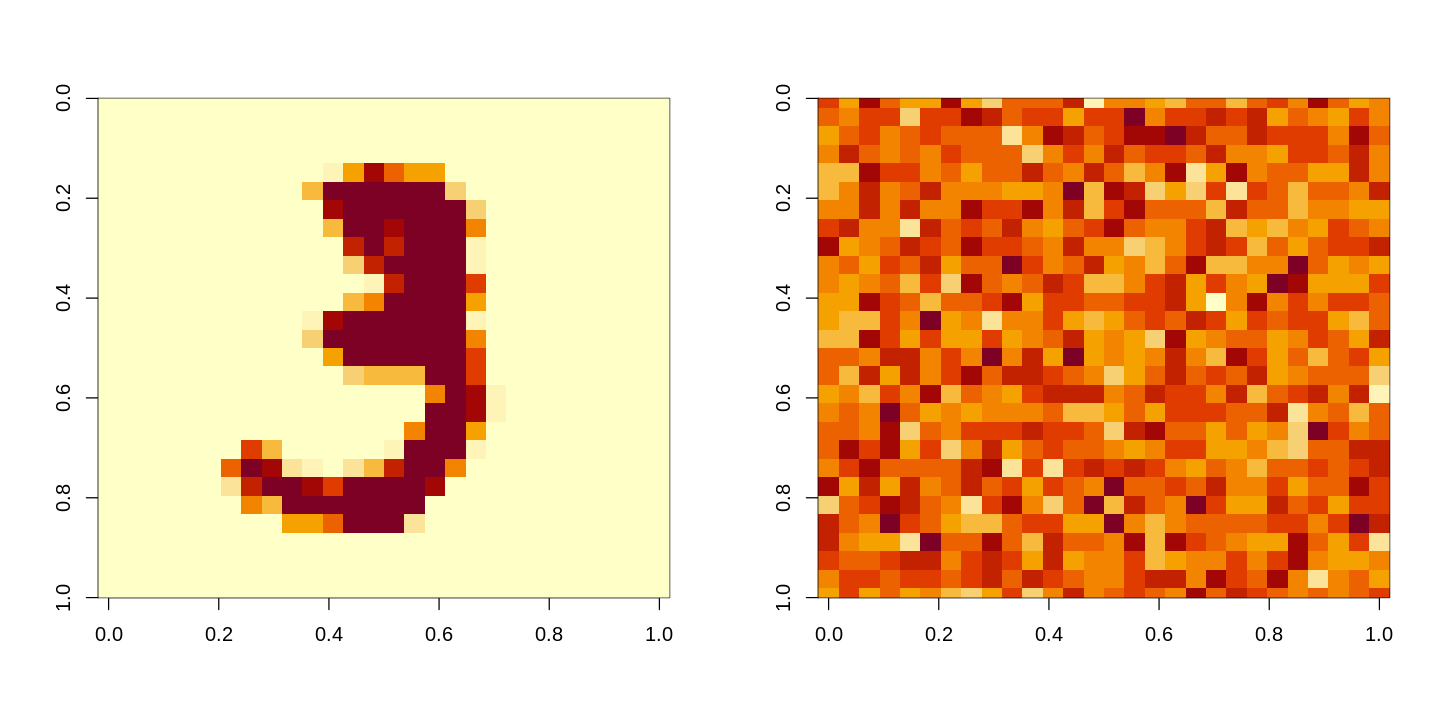

[1] "Epoch 2"
[1] "Training accuracy: 0.1676"
[1] "Validation accuracy: 0.173017301730173"


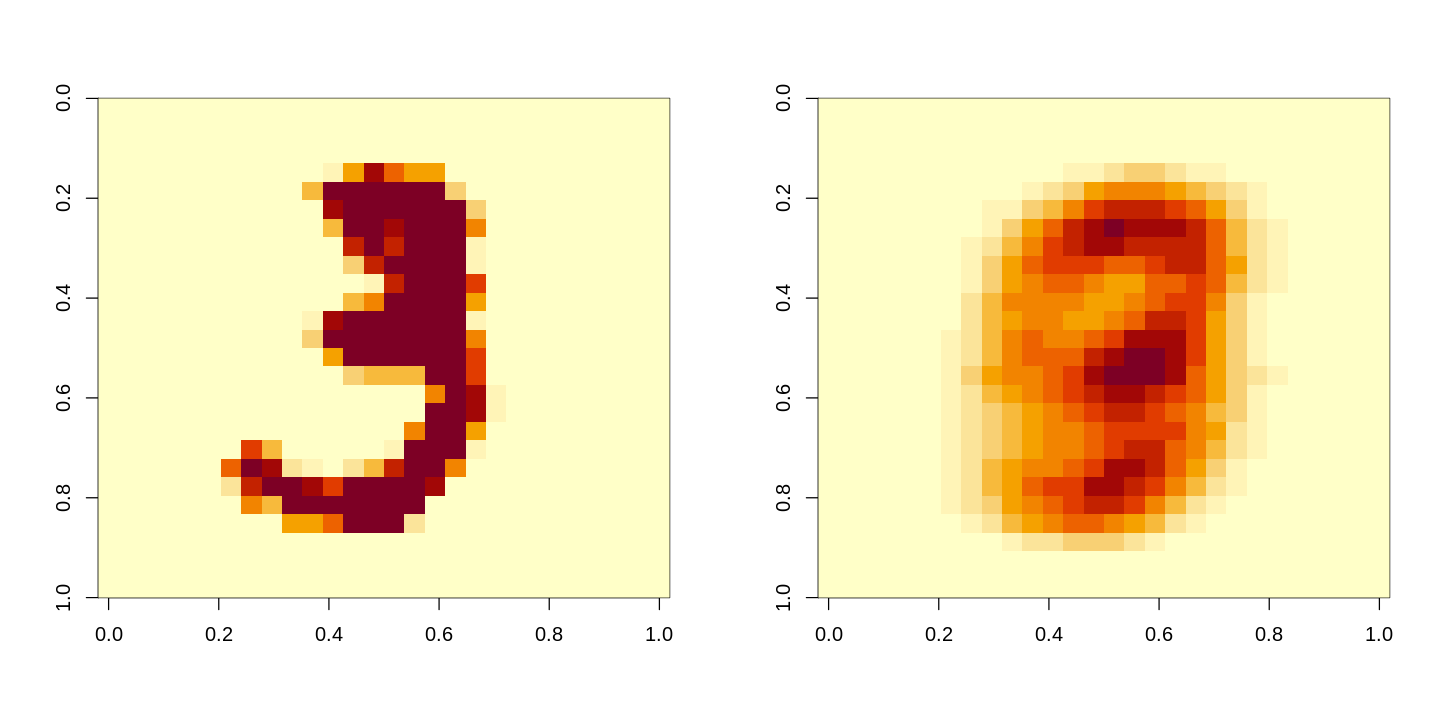

[1] "Epoch 3"
[1] "Training accuracy: 0.3452"
[1] "Validation accuracy: 0.346334633463346"


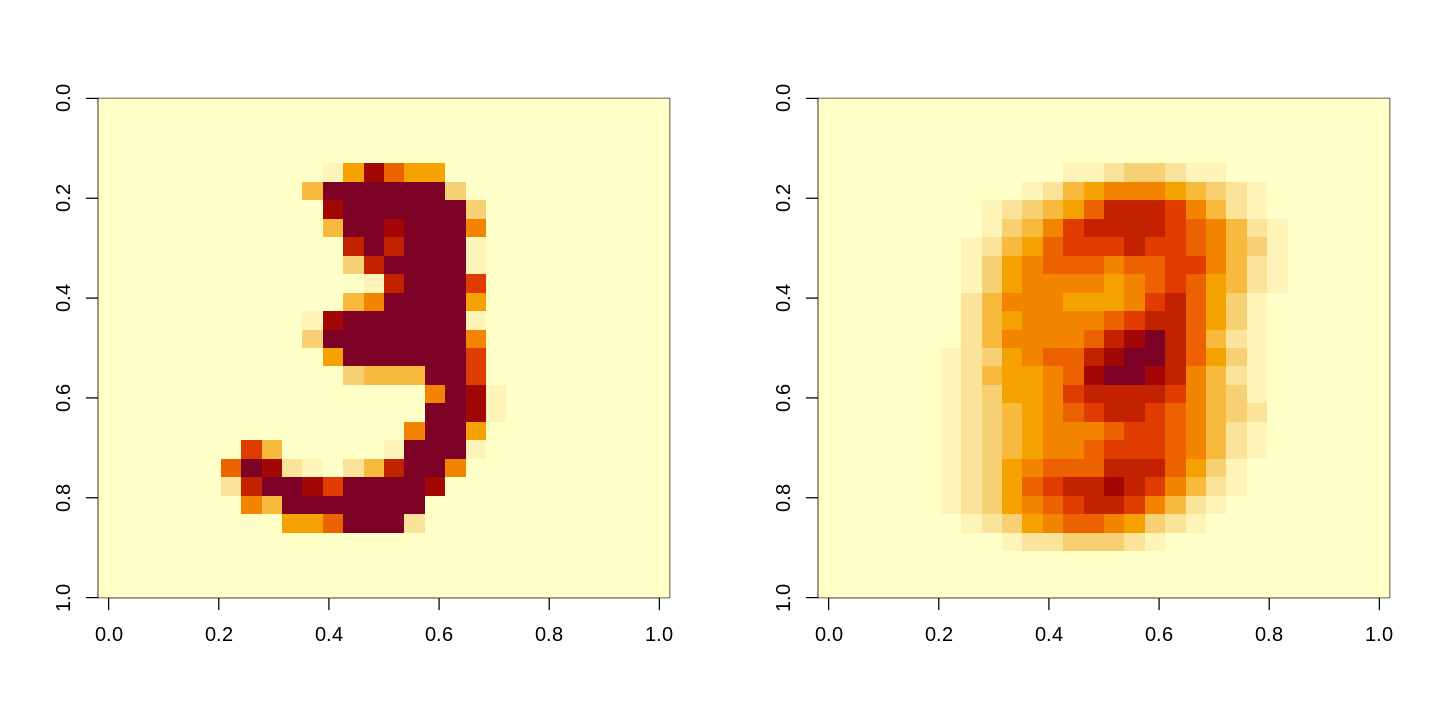

[1] "Epoch 4"
[1] "Training accuracy: 0.475"
[1] "Validation accuracy: 0.485348534853485"


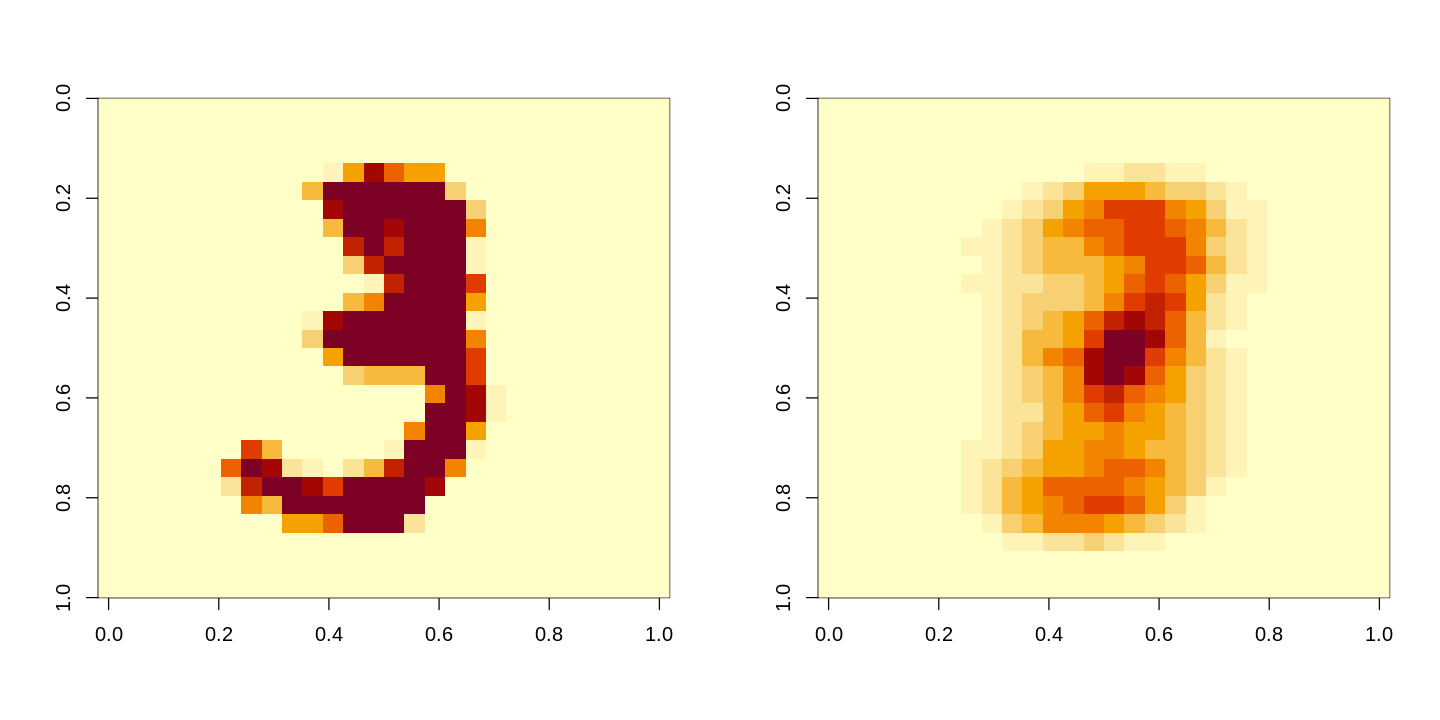

[1] "Epoch 5"
[1] "Training accuracy: 0.5673"
[1] "Validation accuracy: 0.567156715671567"


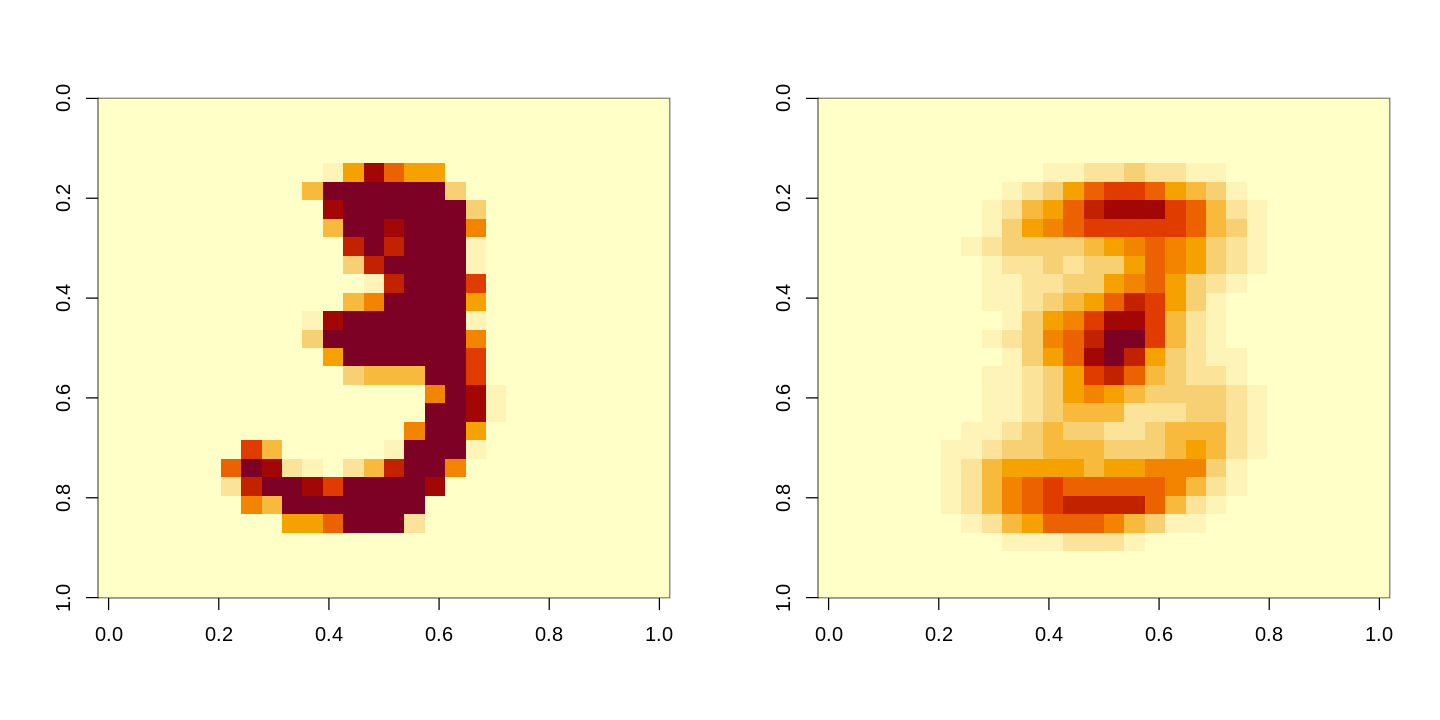

[1] "Epoch 6"
[1] "Training accuracy: 0.6357"
[1] "Validation accuracy: 0.631563156315632"


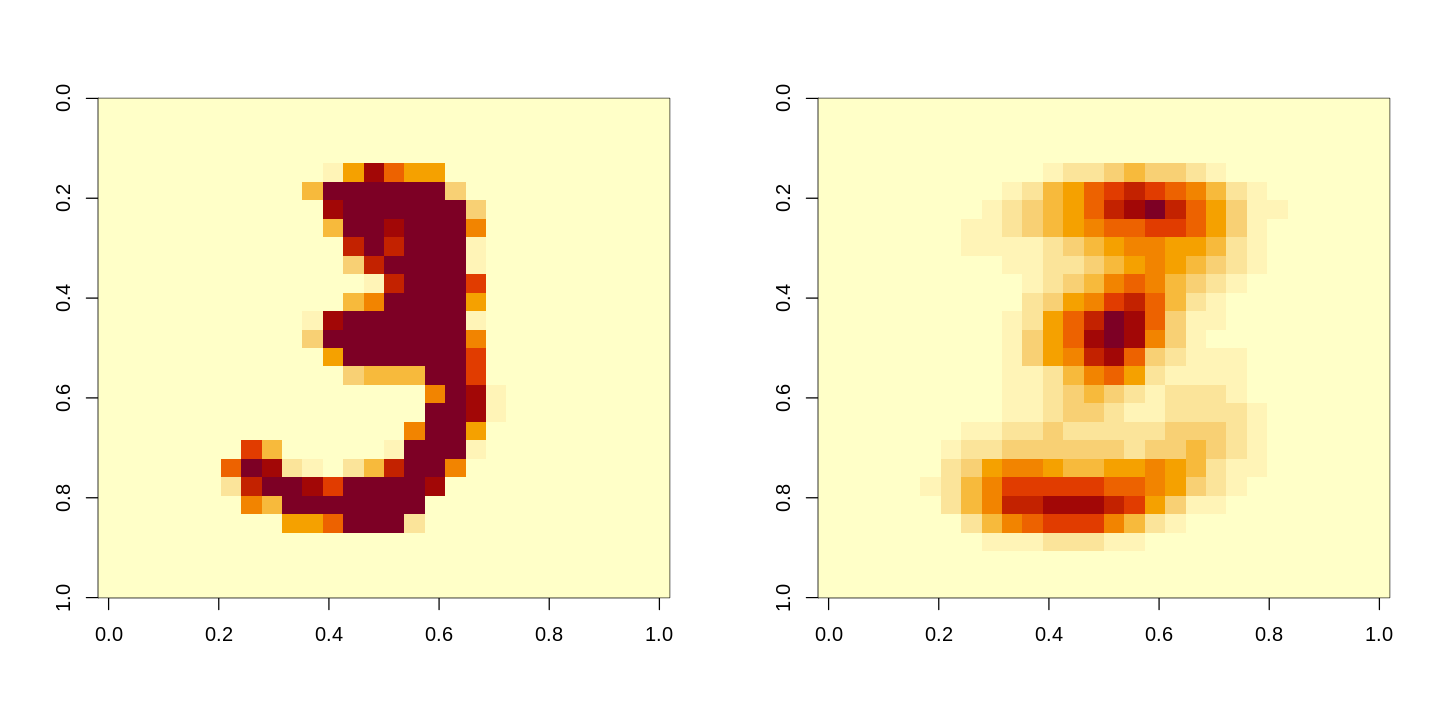

[1] "Epoch 7"
[1] "Training accuracy: 0.6832"
[1] "Validation accuracy: 0.676667666766677"


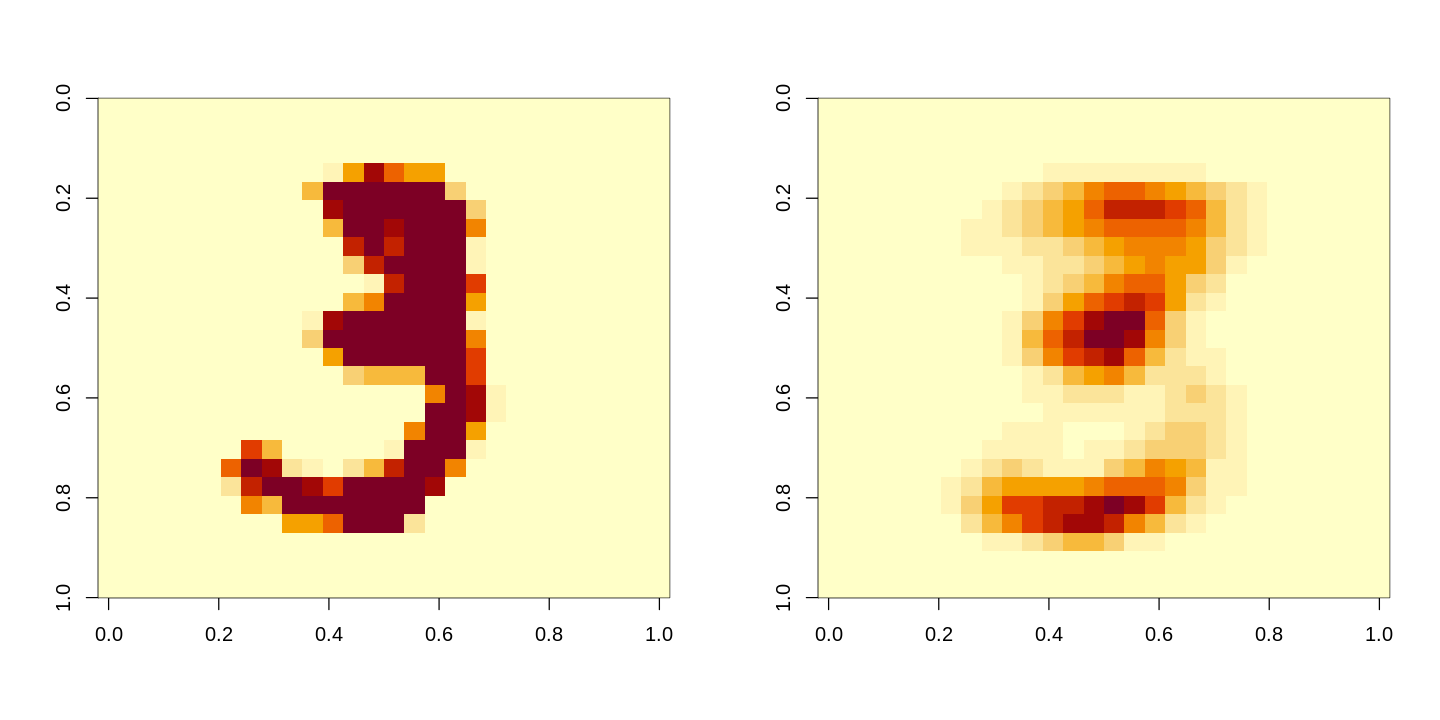

[1] "Epoch 8"
[1] "Training accuracy: 0.7011"
[1] "Validation accuracy: 0.695469546954695"


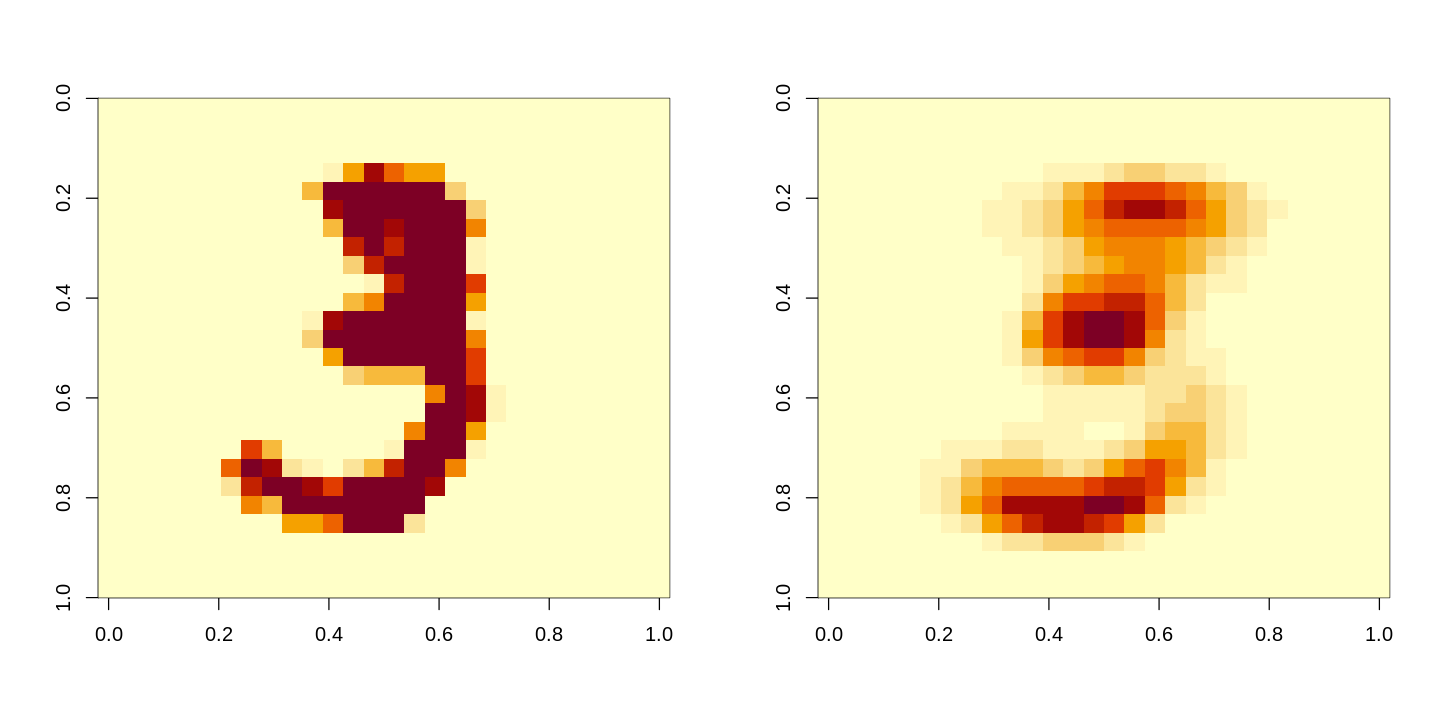

[1] "Epoch 9"
[1] "Training accuracy: 0.7309"
[1] "Validation accuracy: 0.723172317231723"


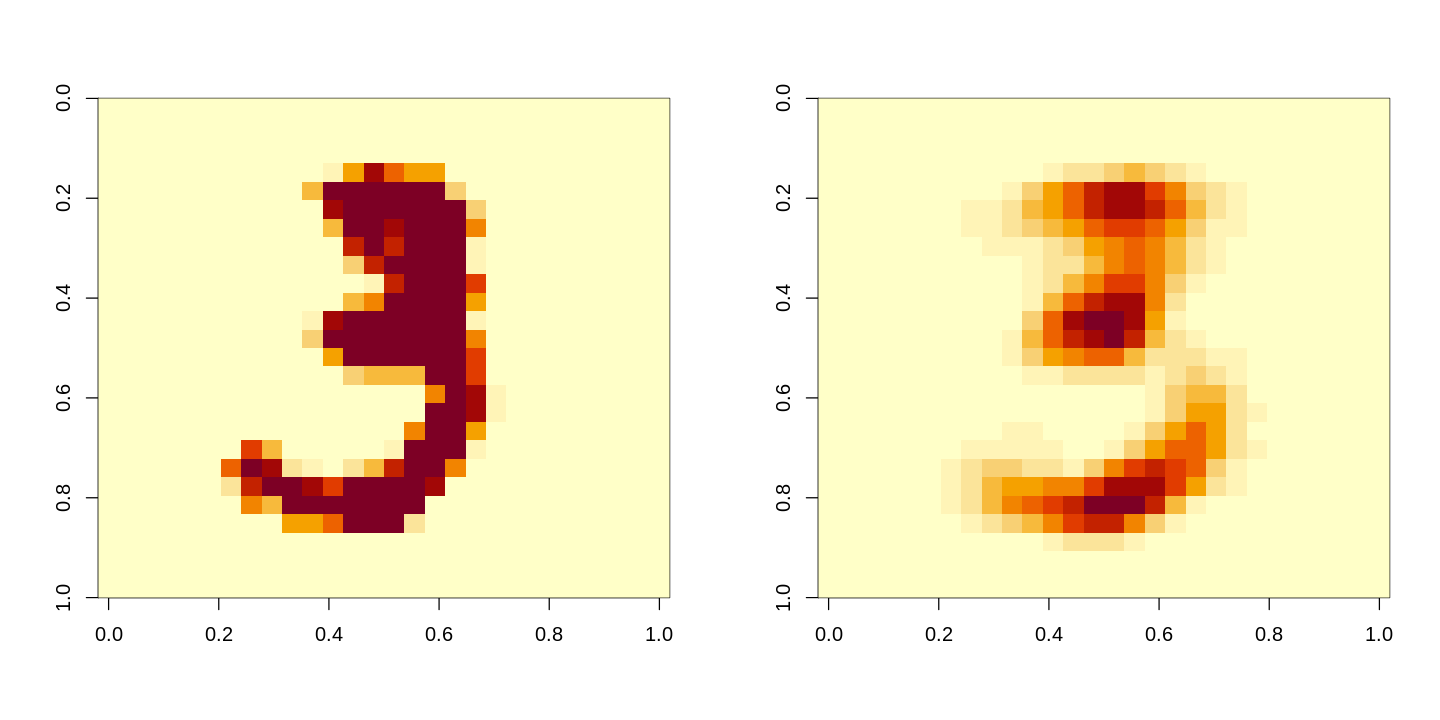

[1] "Epoch 10"
[1] "Training accuracy: 0.7509"
[1] "Validation accuracy: 0.742574257425743"


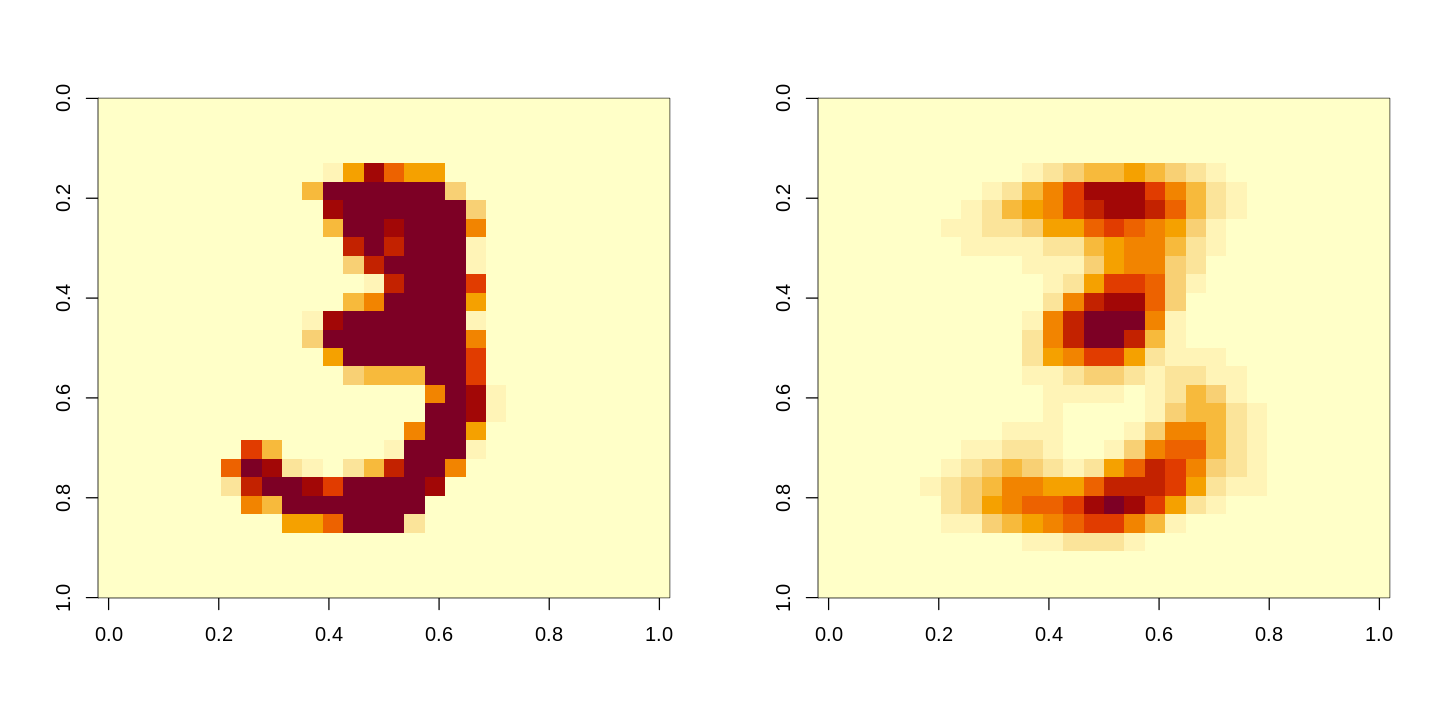

[1] "Epoch 11"
[1] "Training accuracy: 0.7643"
[1] "Validation accuracy: 0.758775877587759"


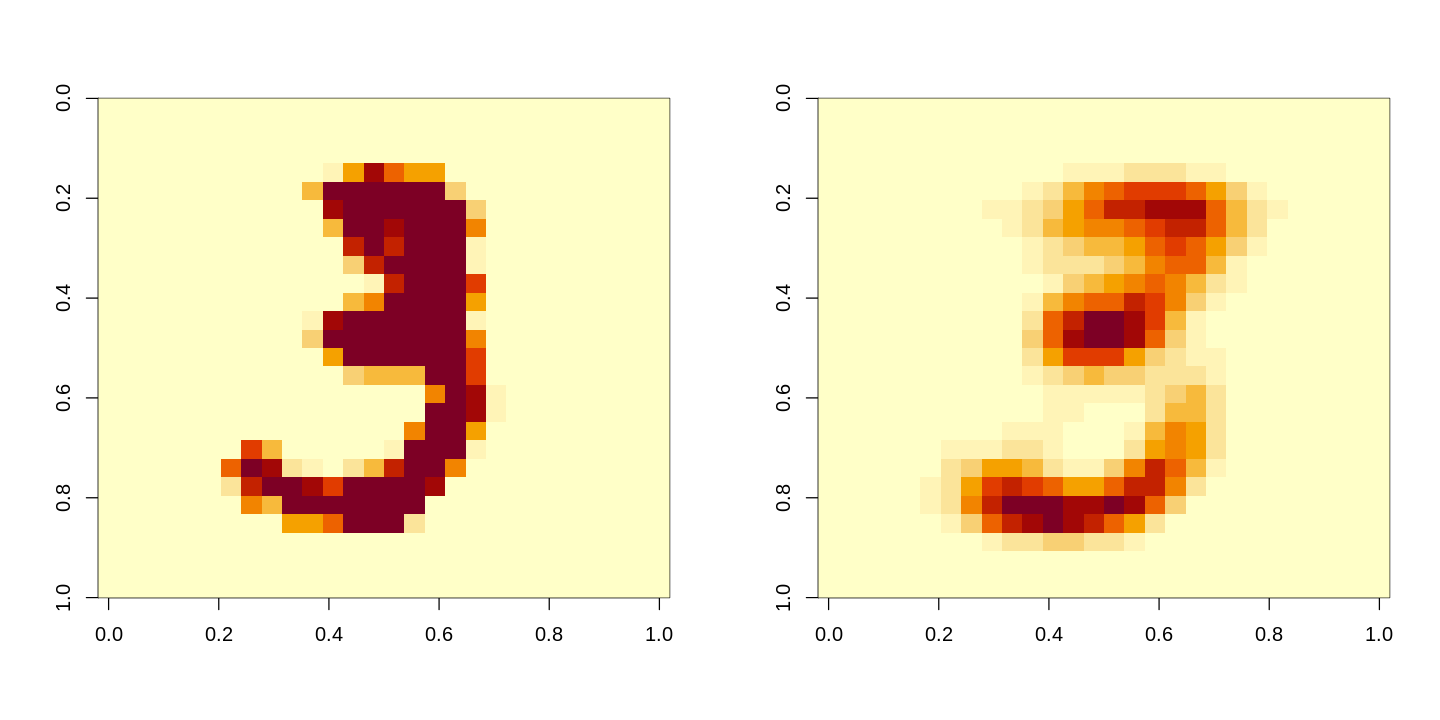

[1] "Epoch 12"
[1] "Training accuracy: 0.7739"
[1] "Validation accuracy: 0.769276927692769"


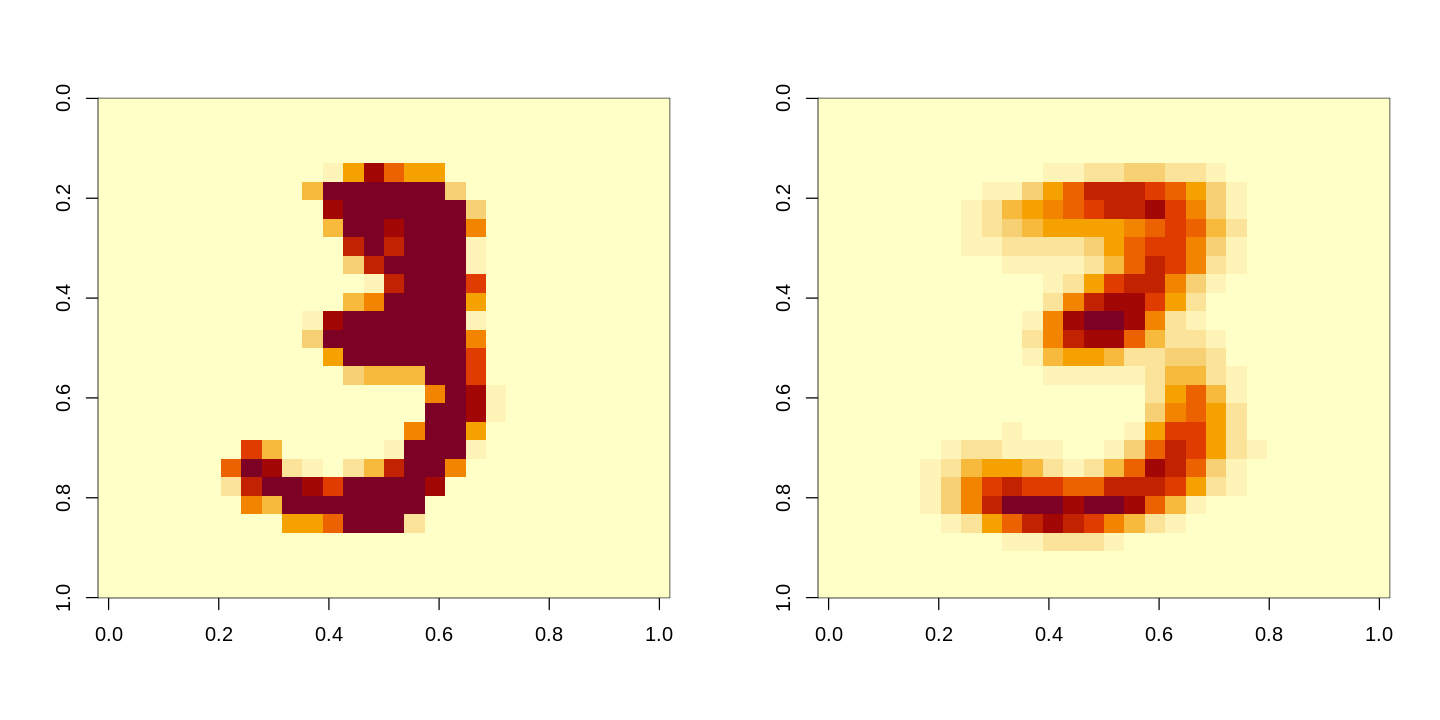

[1] "Epoch 13"
[1] "Training accuracy: 0.7852"
[1] "Validation accuracy: 0.775977597759776"


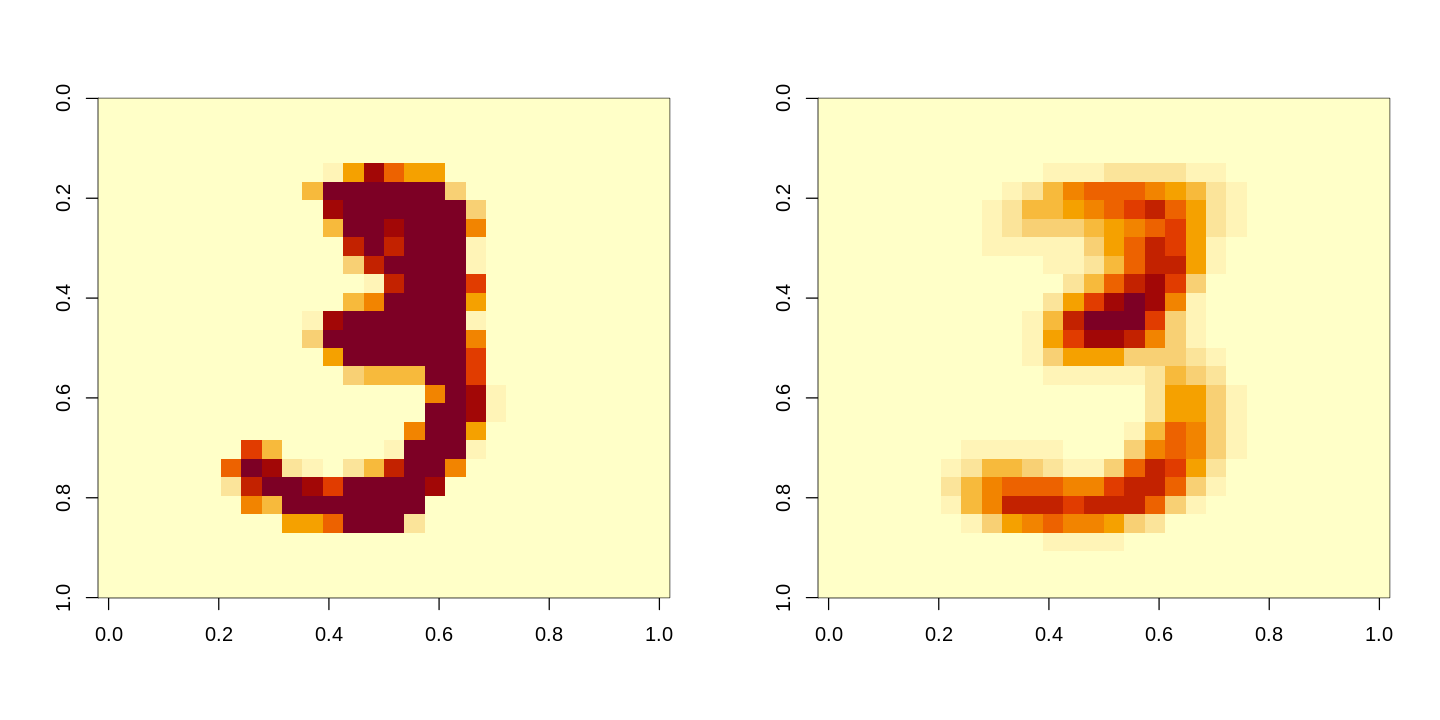

[1] "Epoch 14"
[1] "Training accuracy: 0.7926"
[1] "Validation accuracy: 0.785878587858786"


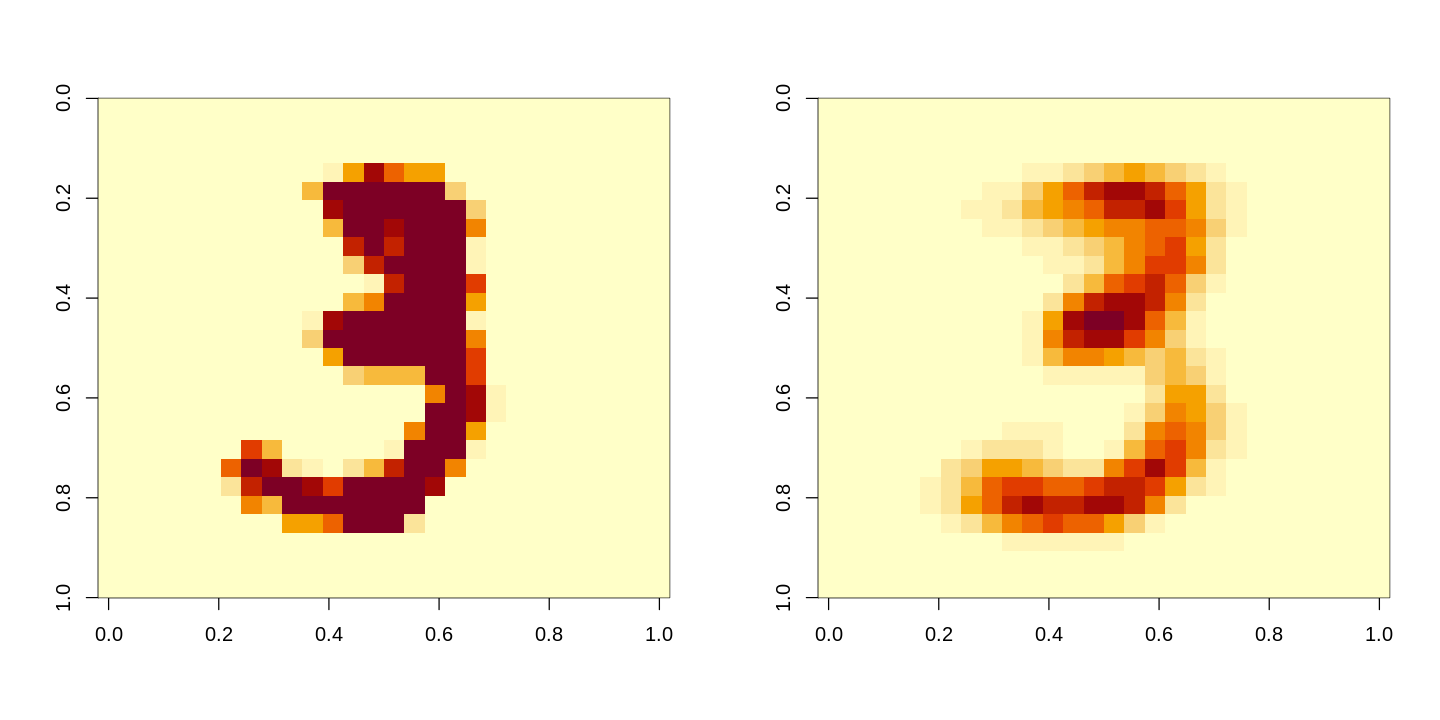

[1] "Epoch 15"
[1] "Training accuracy: 0.8048"
[1] "Validation accuracy: 0.796079607960796"


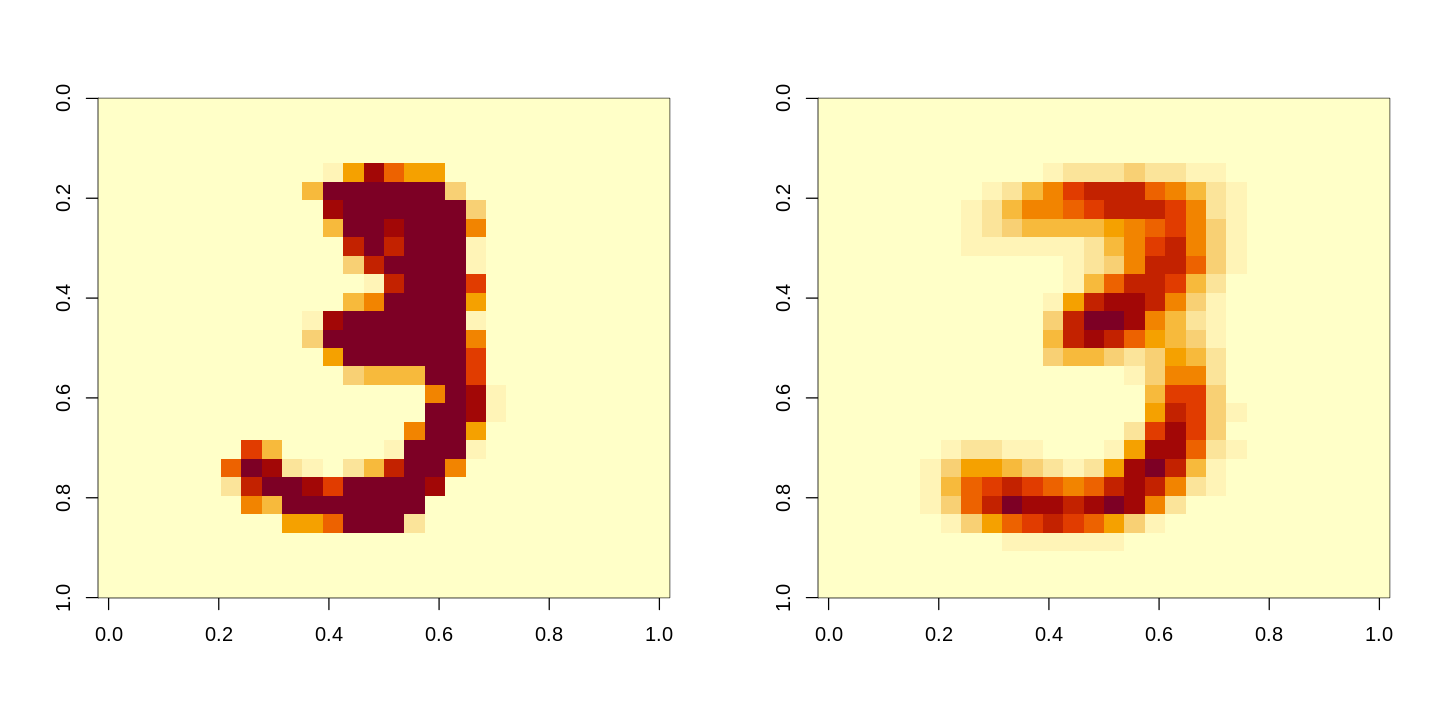

[1] "Epoch 16"
[1] "Training accuracy: 0.8144"
[1] "Validation accuracy: 0.803480348034804"


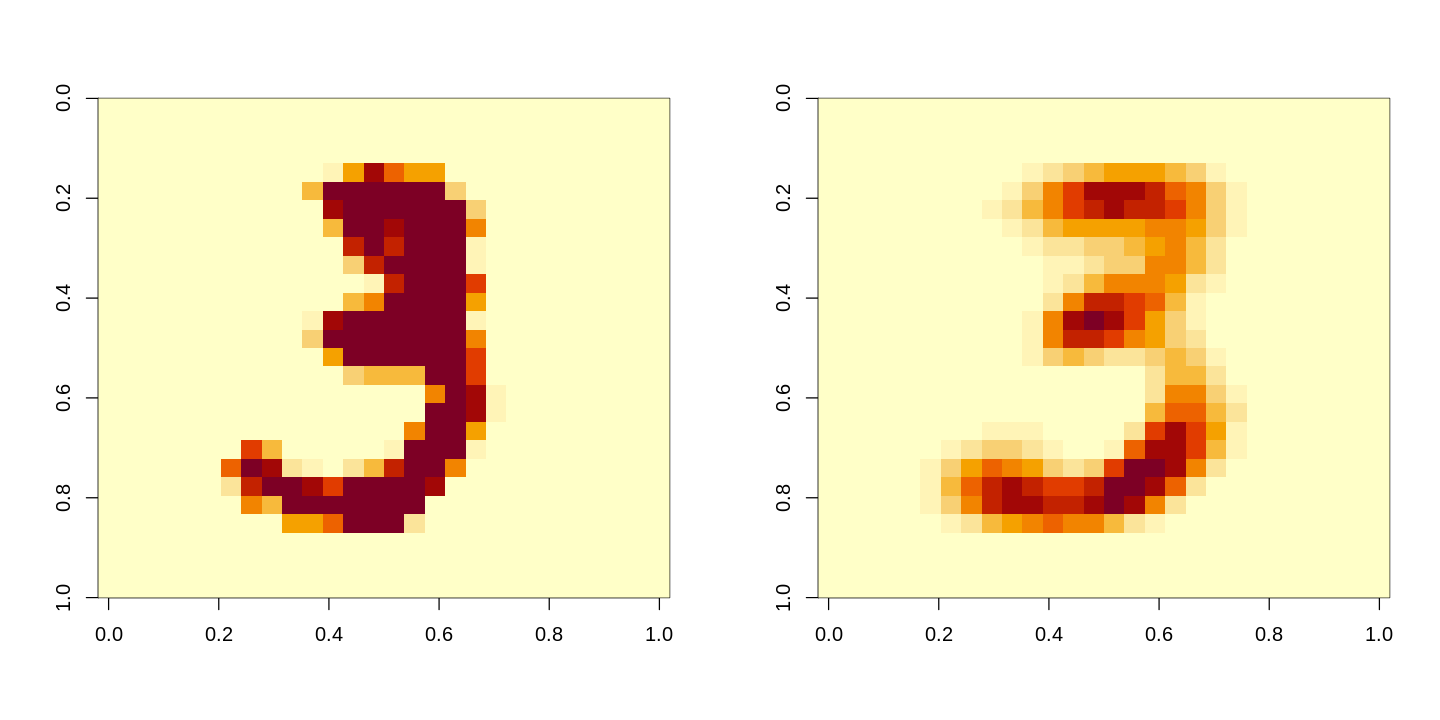

[1] "Epoch 17"
[1] "Training accuracy: 0.8207"
[1] "Validation accuracy: 0.812181218121812"


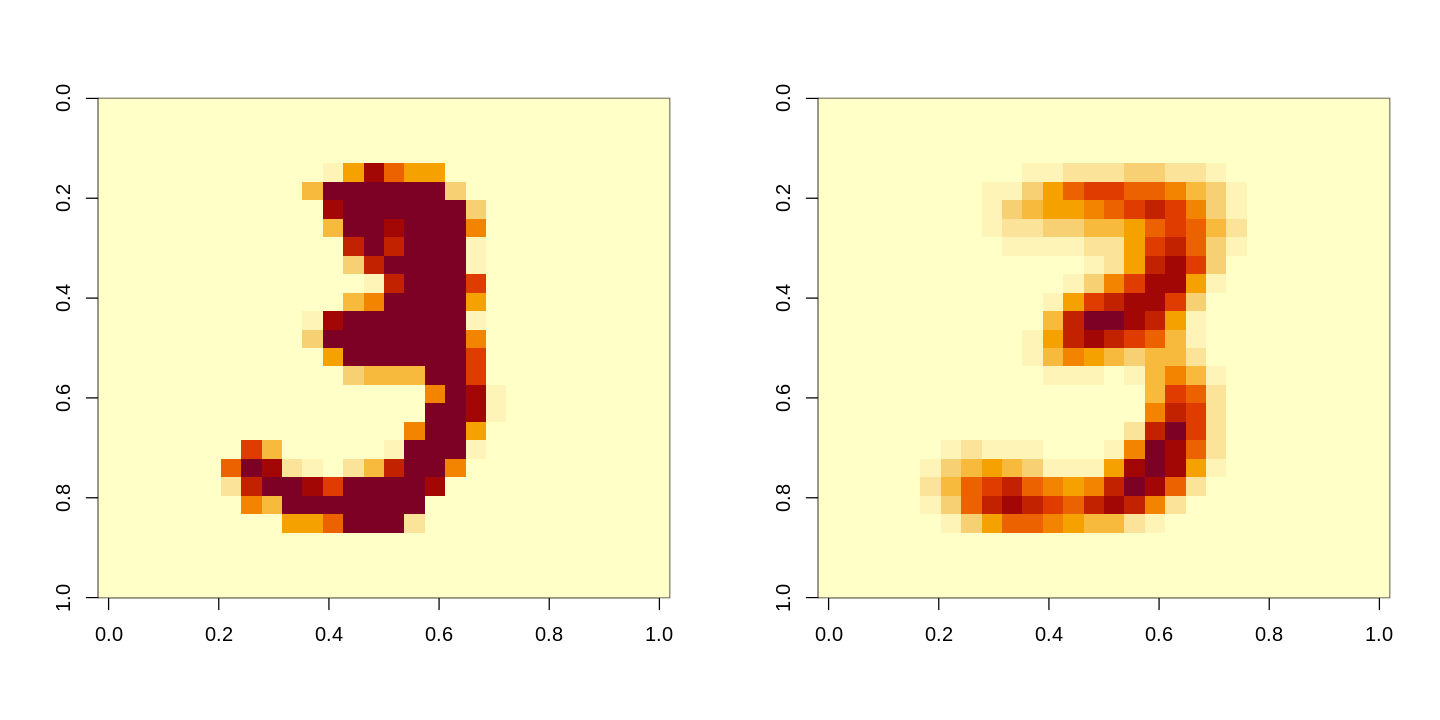

[1] "Epoch 18"
[1] "Training accuracy: 0.8308"
[1] "Validation accuracy: 0.820882088208821"


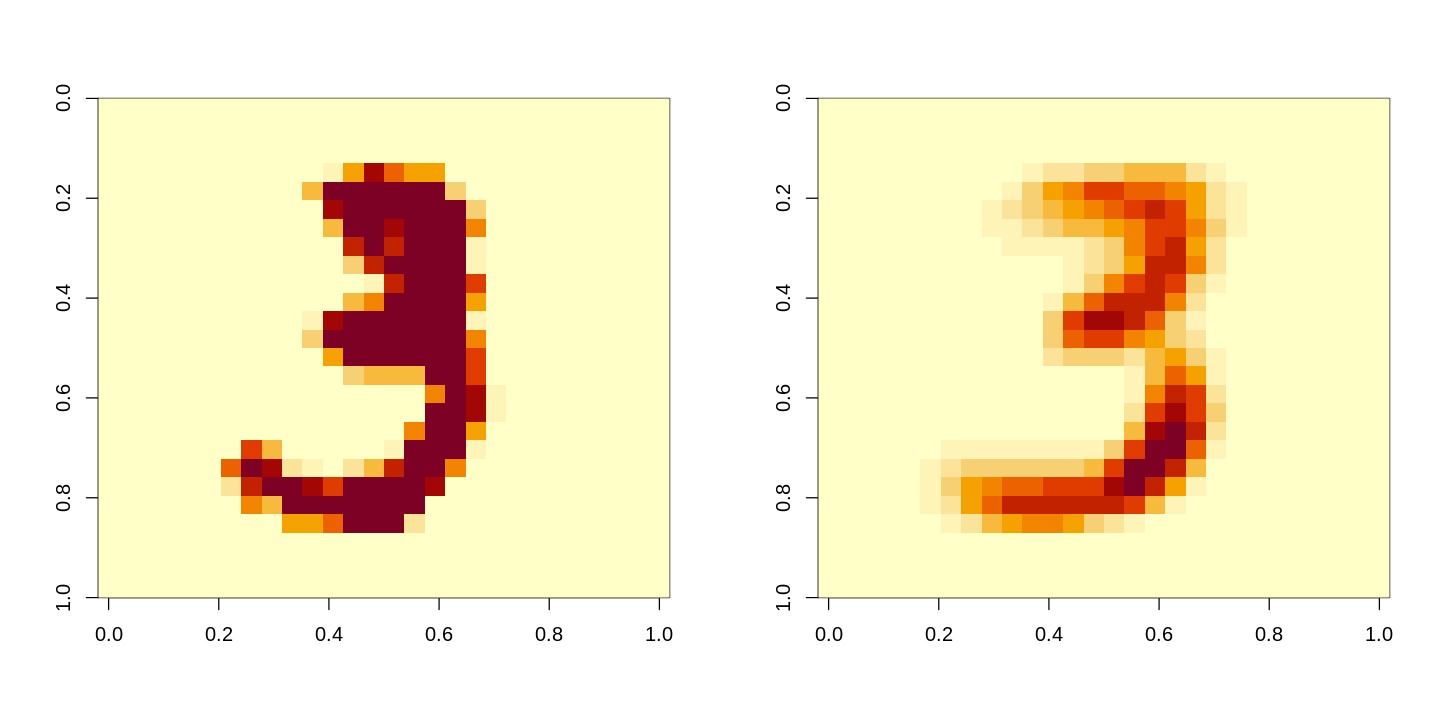

[1] "Epoch 19"
[1] "Training accuracy: 0.8386"
[1] "Validation accuracy: 0.83048304830483"


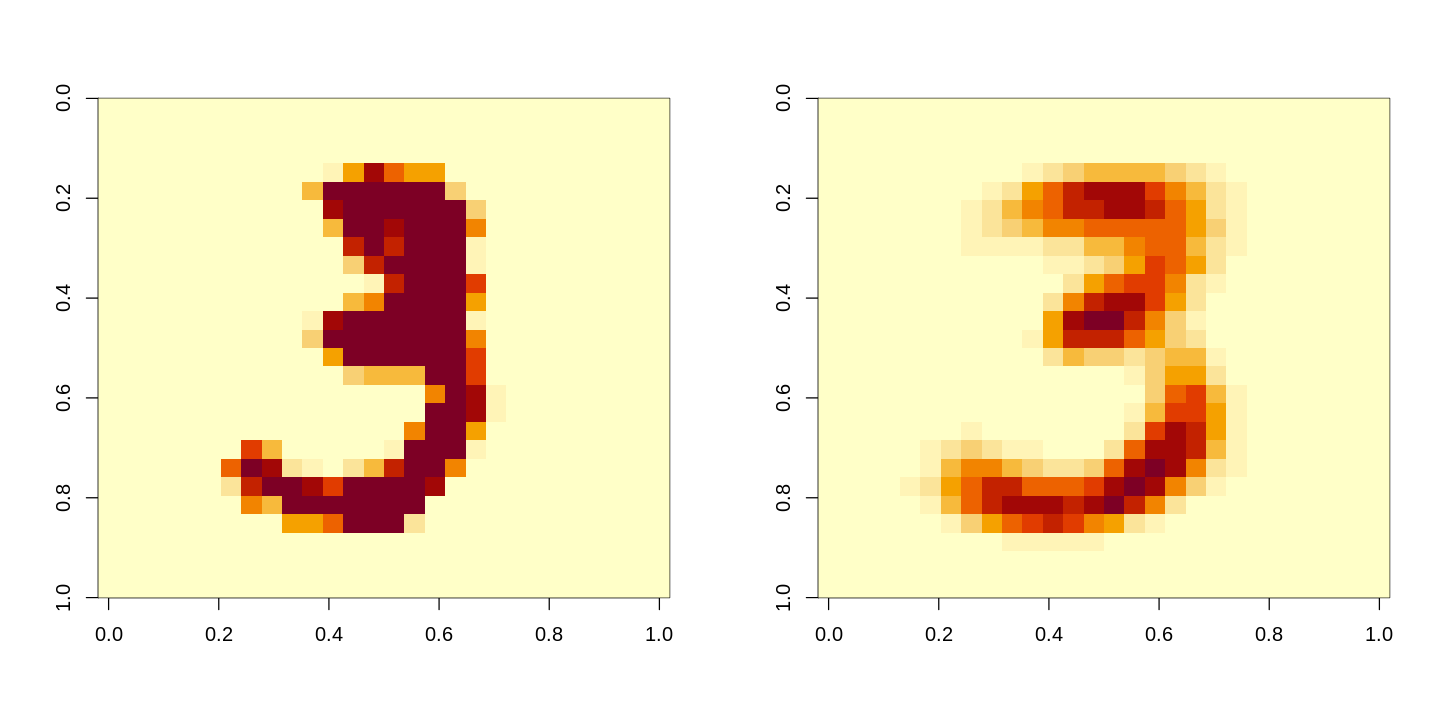

[1] "Epoch 20"
[1] "Training accuracy: 0.8446"
[1] "Validation accuracy: 0.836783678367837"


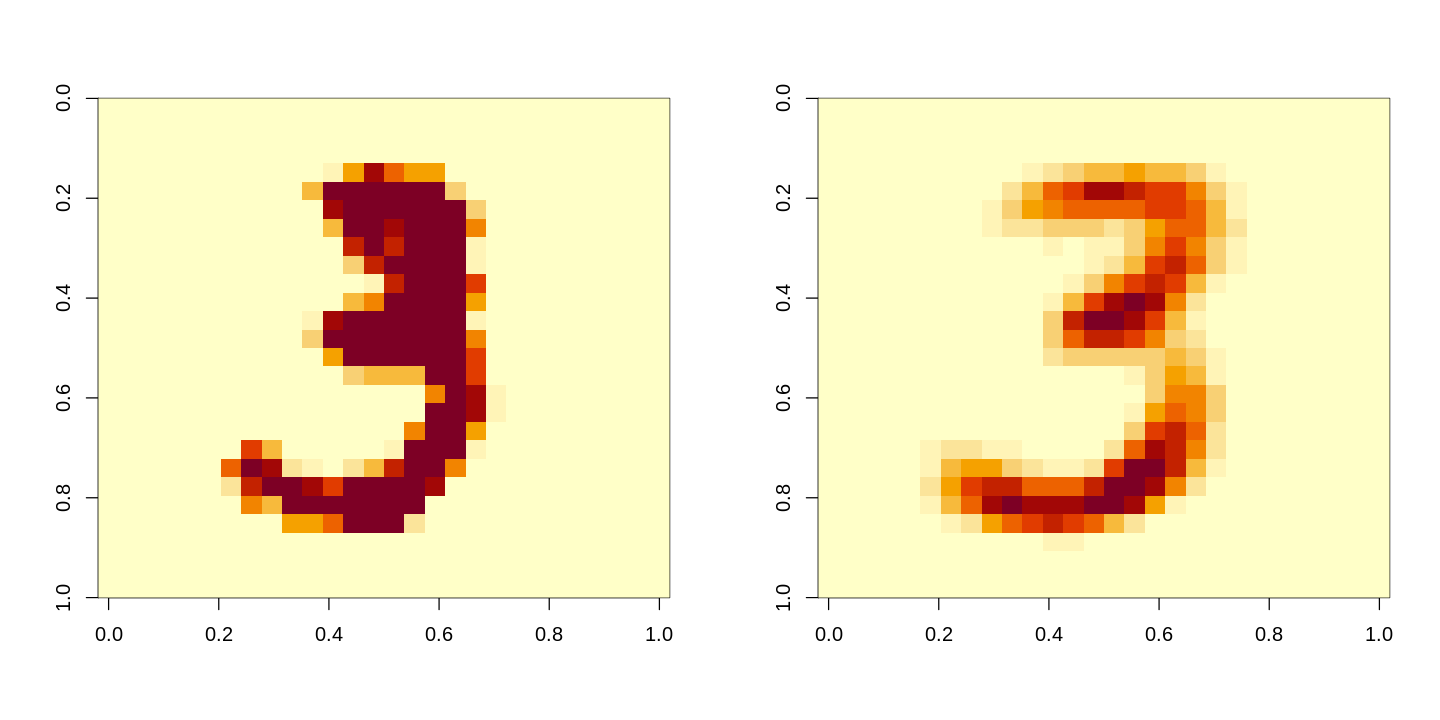

[1] "Epoch 21"
[1] "Training accuracy: 0.8493"
[1] "Validation accuracy: 0.841884188418842"


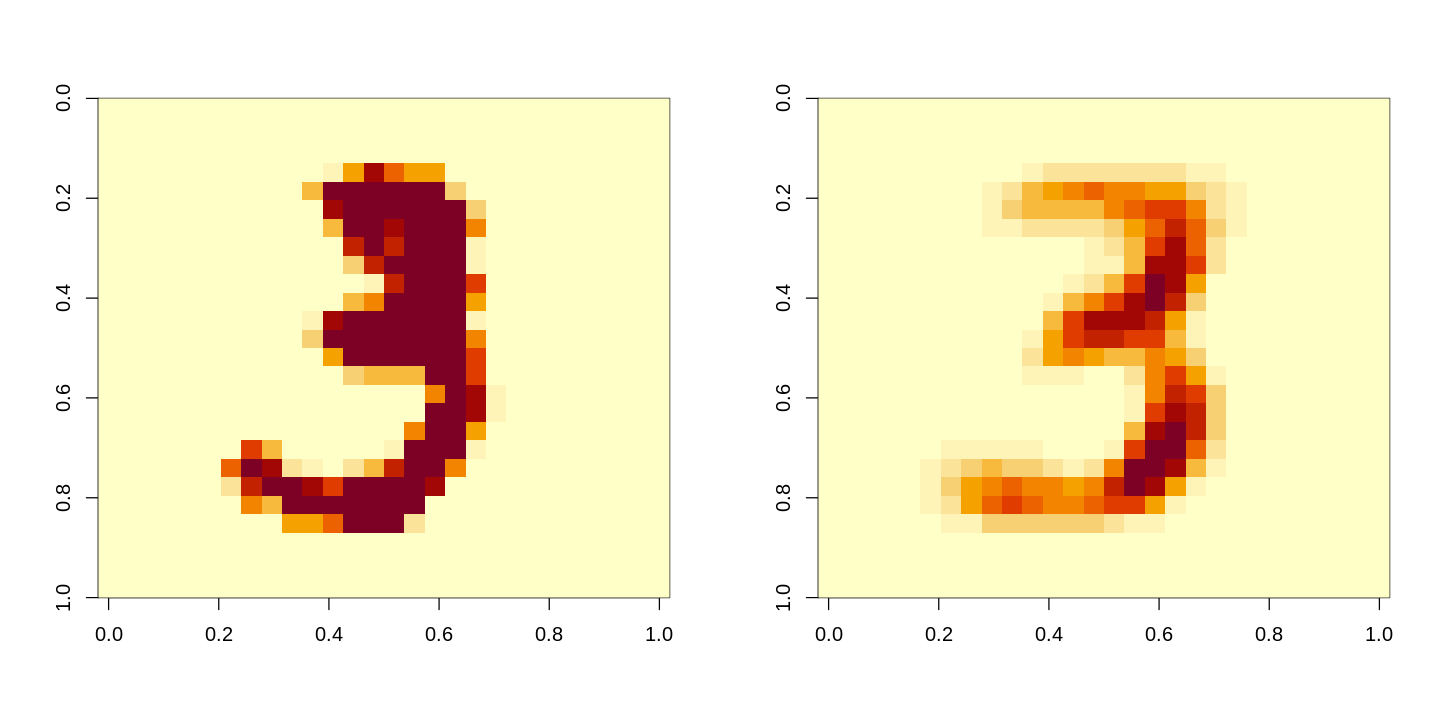

[1] "Epoch 22"
[1] "Training accuracy: 0.8537"
[1] "Validation accuracy: 0.843884388438844"


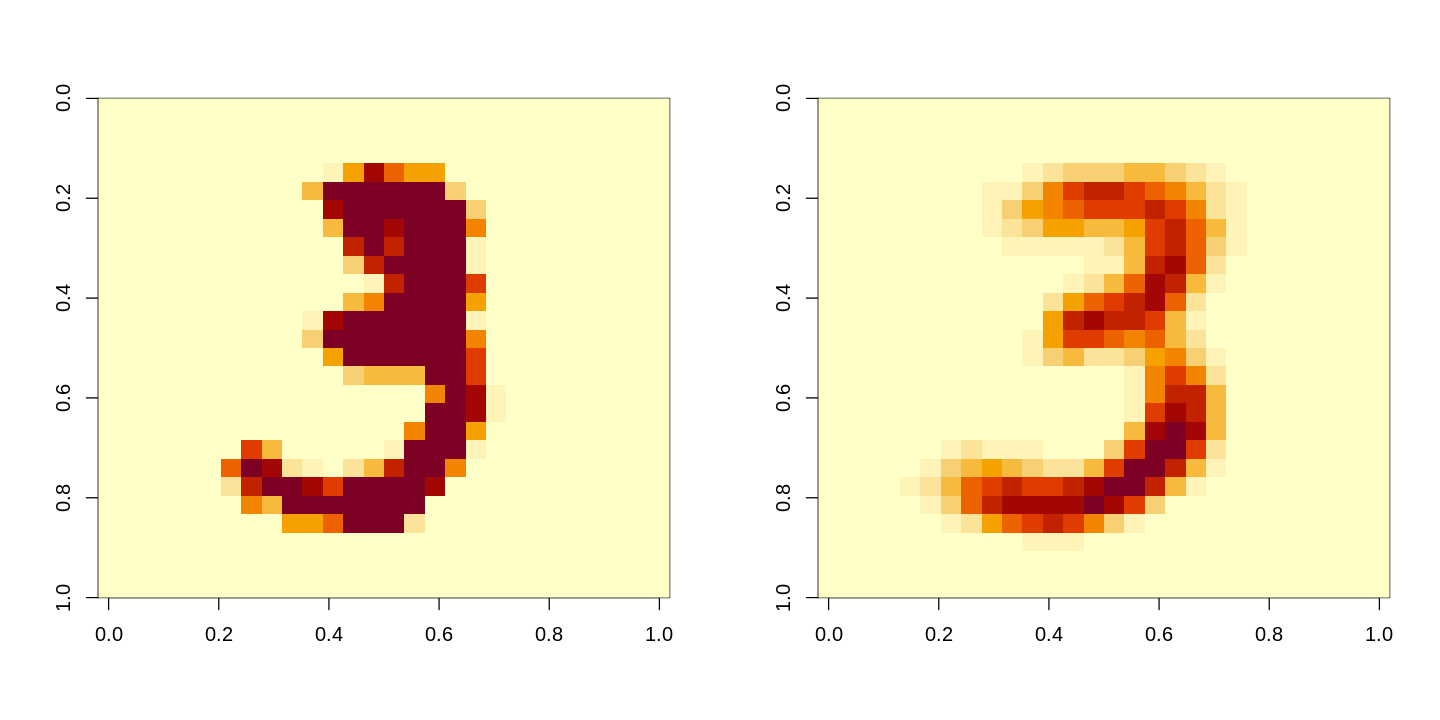

[1] "Epoch 23"
[1] "Training accuracy: 0.8561"
[1] "Validation accuracy: 0.851785178517852"


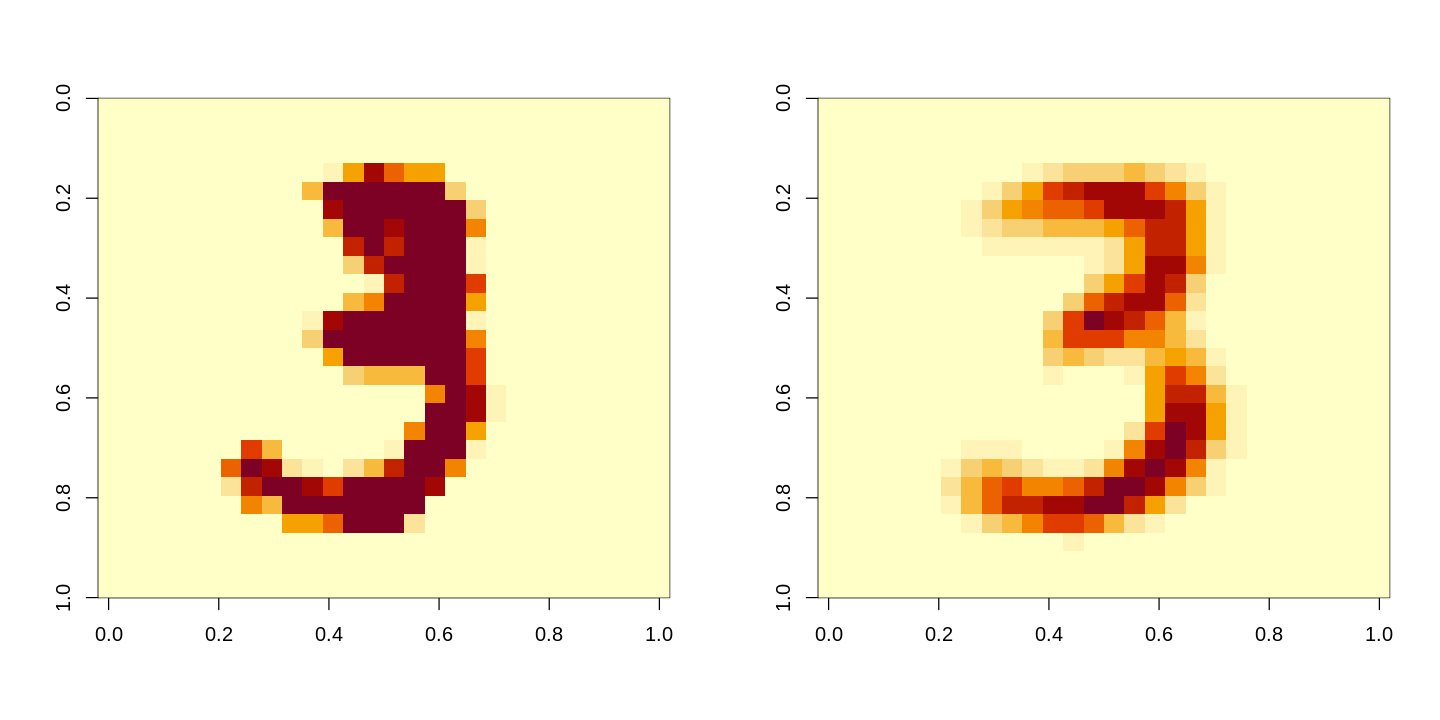

[1] "Epoch 24"
[1] "Training accuracy: 0.863"
[1] "Validation accuracy: 0.854685468546855"


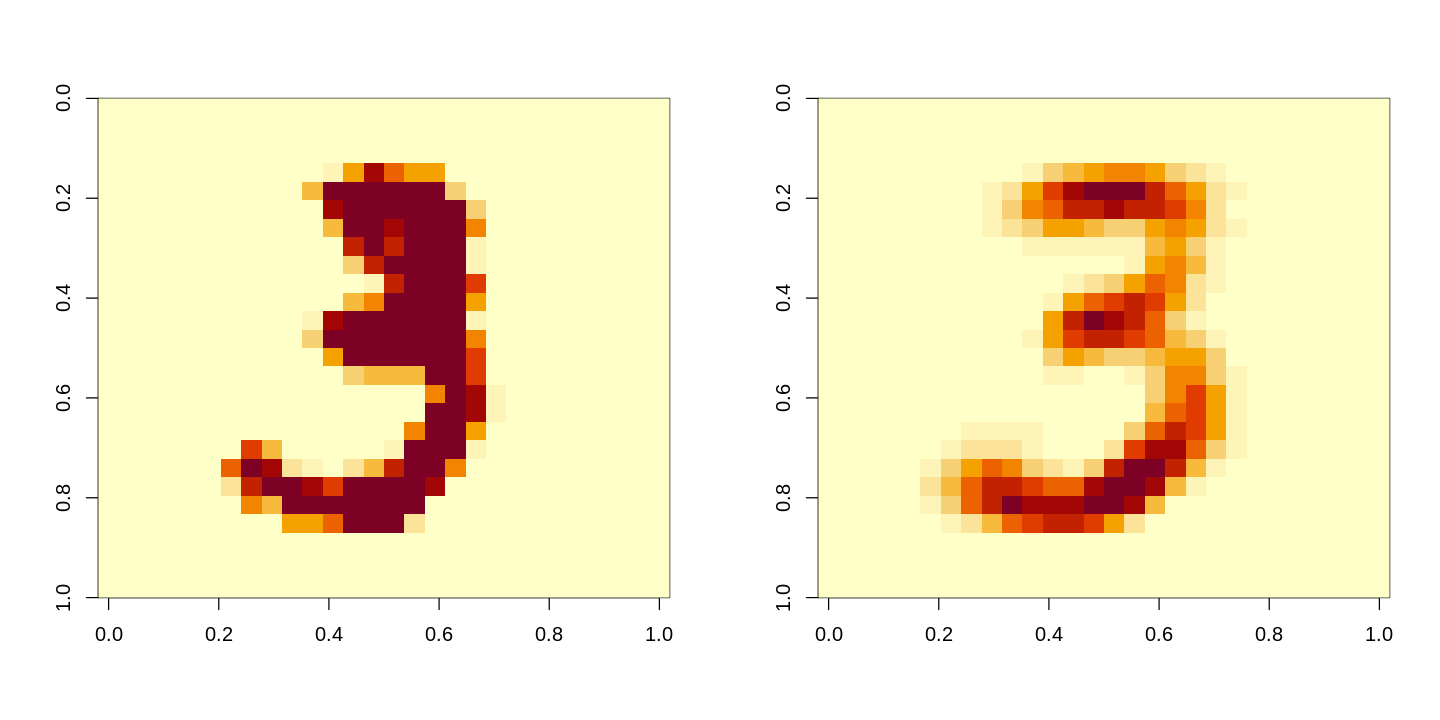

[1] "Epoch 25"
[1] "Training accuracy: 0.866"
[1] "Validation accuracy: 0.858785878587859"


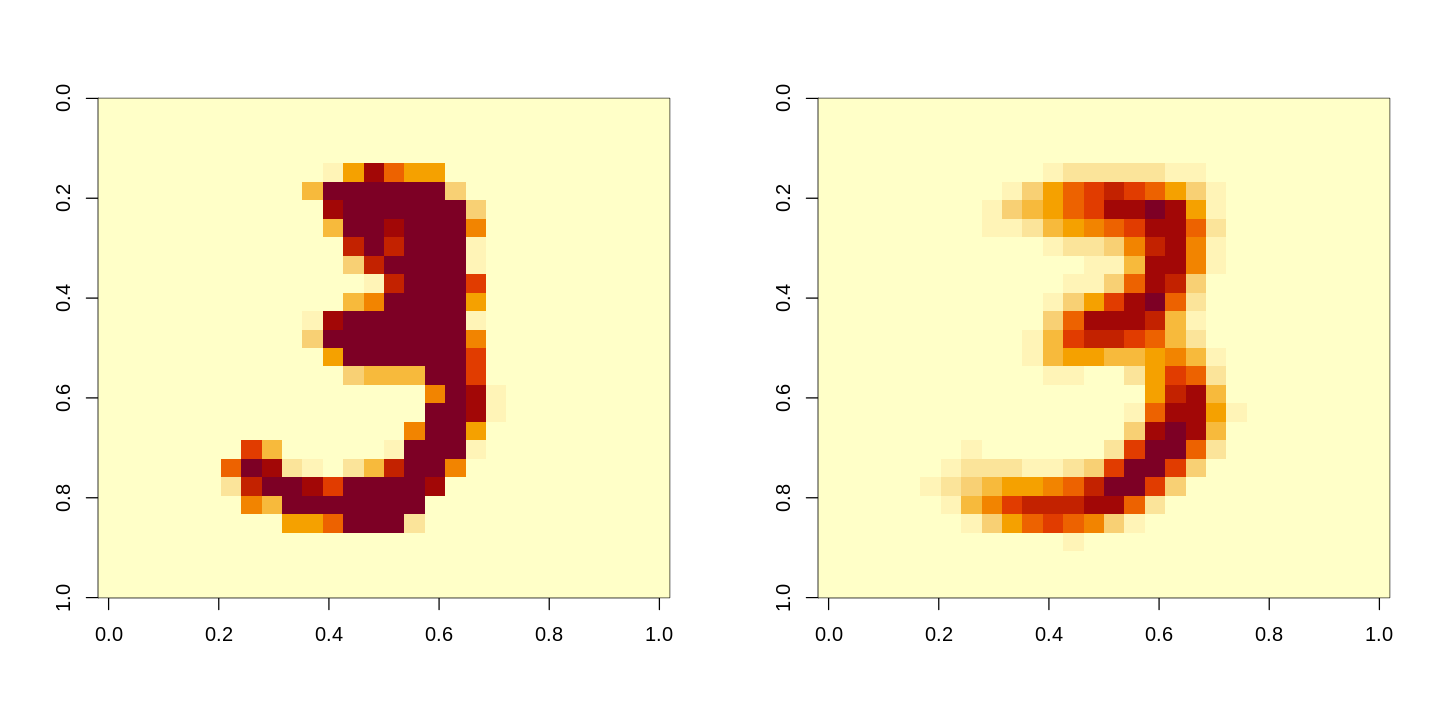

[1] "Epoch 26"
[1] "Training accuracy: 0.8691"
[1] "Validation accuracy: 0.862086208620862"


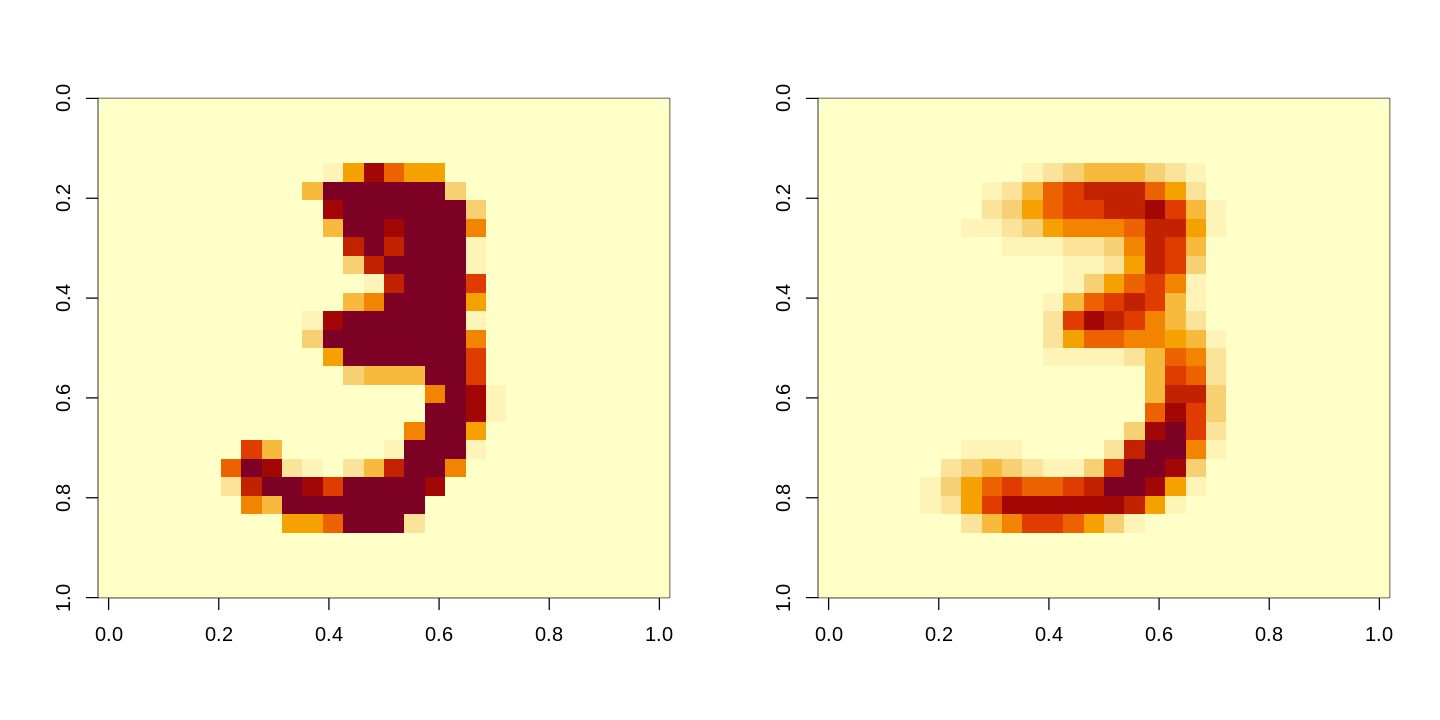

[1] "Epoch 27"
[1] "Training accuracy: 0.8729"
[1] "Validation accuracy: 0.864086408640864"


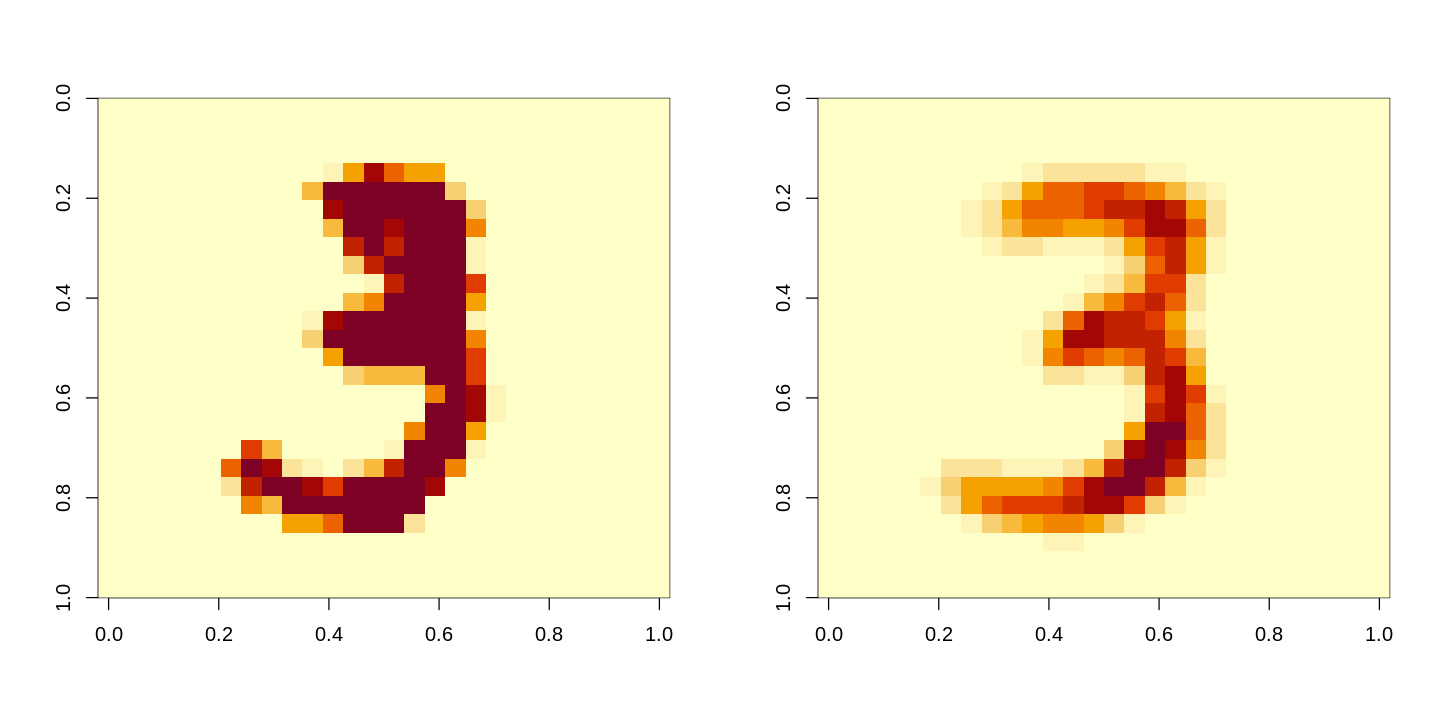

[1] "Epoch 28"
[1] "Training accuracy: 0.873"
[1] "Validation accuracy: 0.865386538653865"


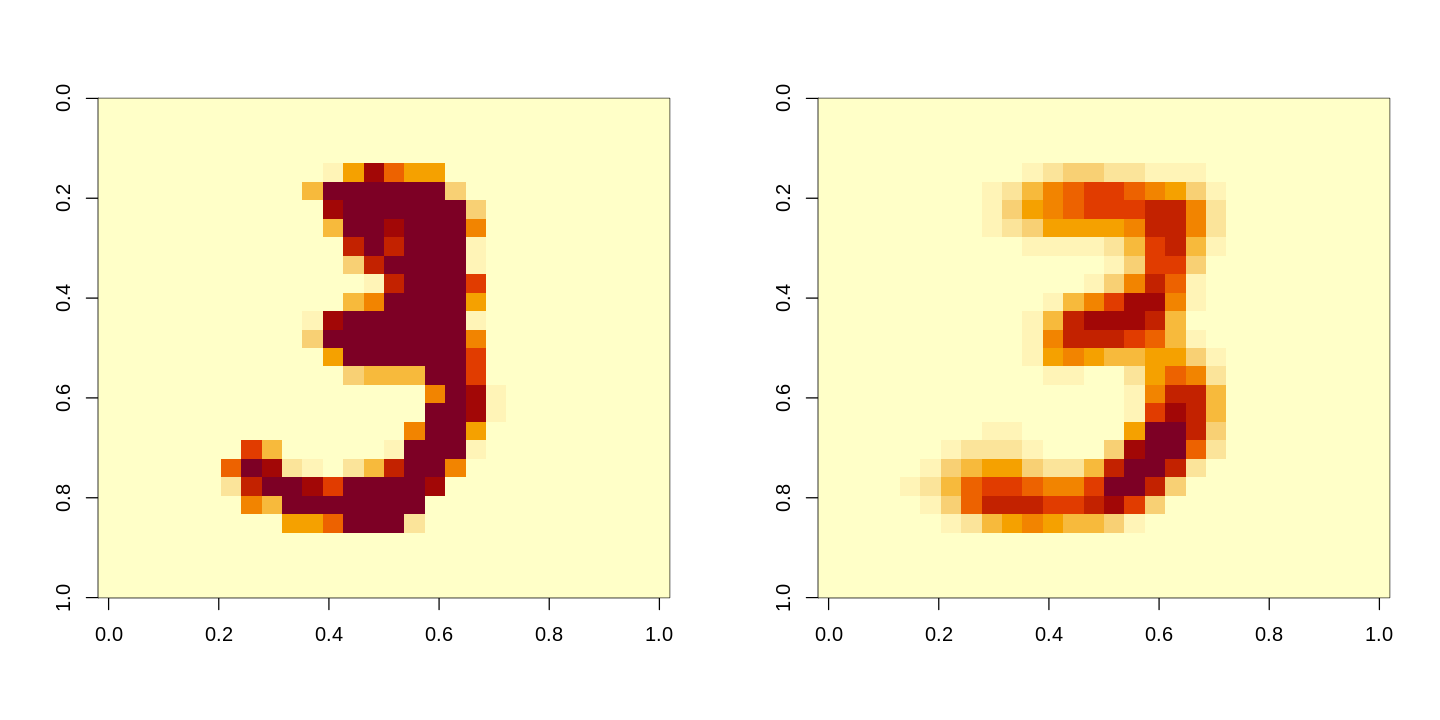

[1] "Epoch 29"
[1] "Training accuracy: 0.8755"
[1] "Validation accuracy: 0.869286928692869"


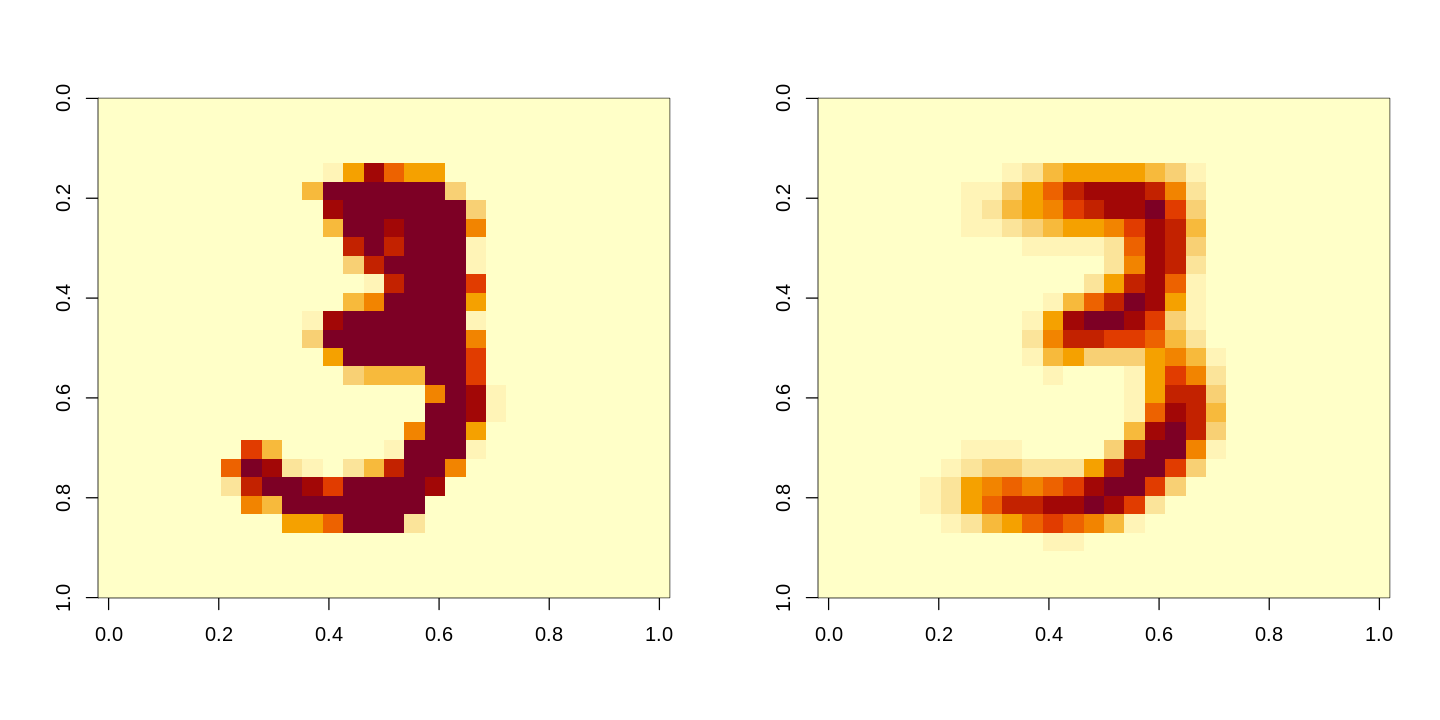

[1] "Epoch 30"
[1] "Training accuracy: 0.8769"
[1] "Validation accuracy: 0.86958695869587"


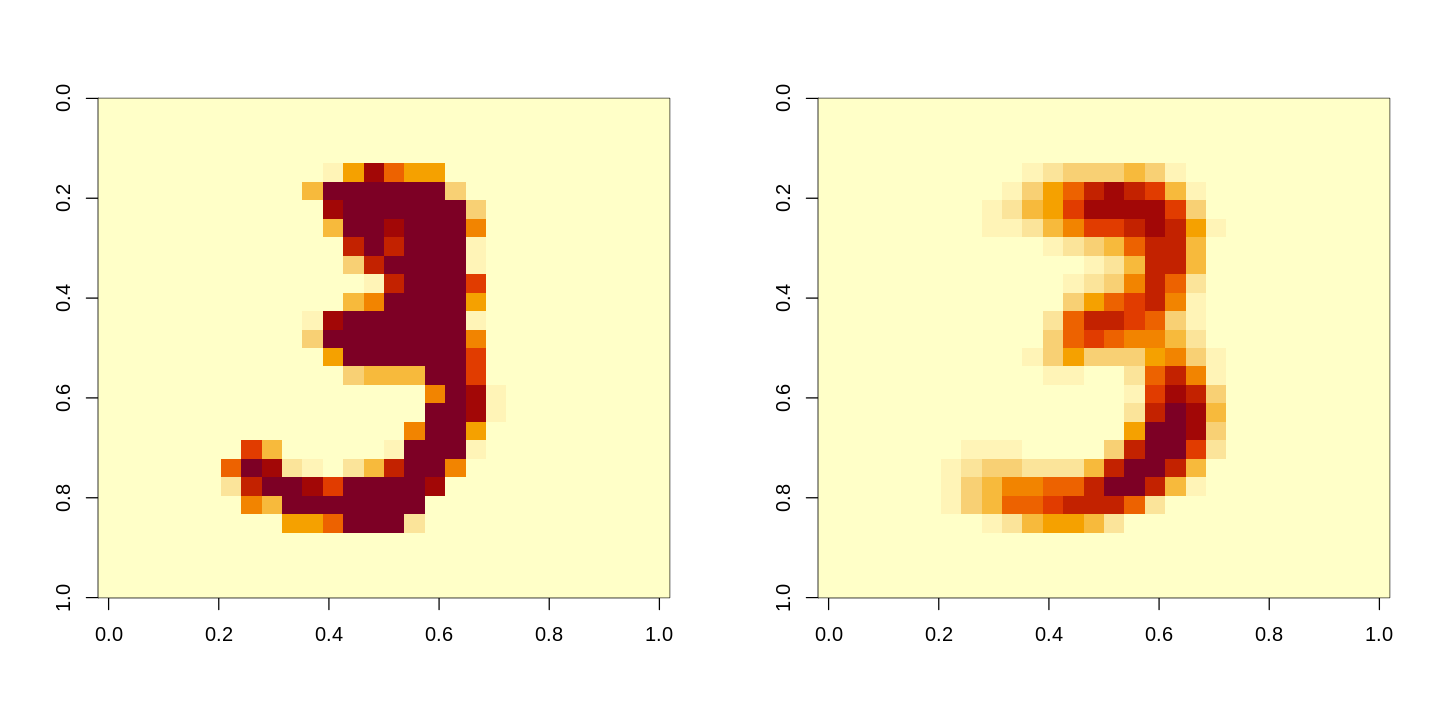

[1] "Epoch 31"
[1] "Training accuracy: 0.8785"
[1] "Validation accuracy: 0.871587158715872"


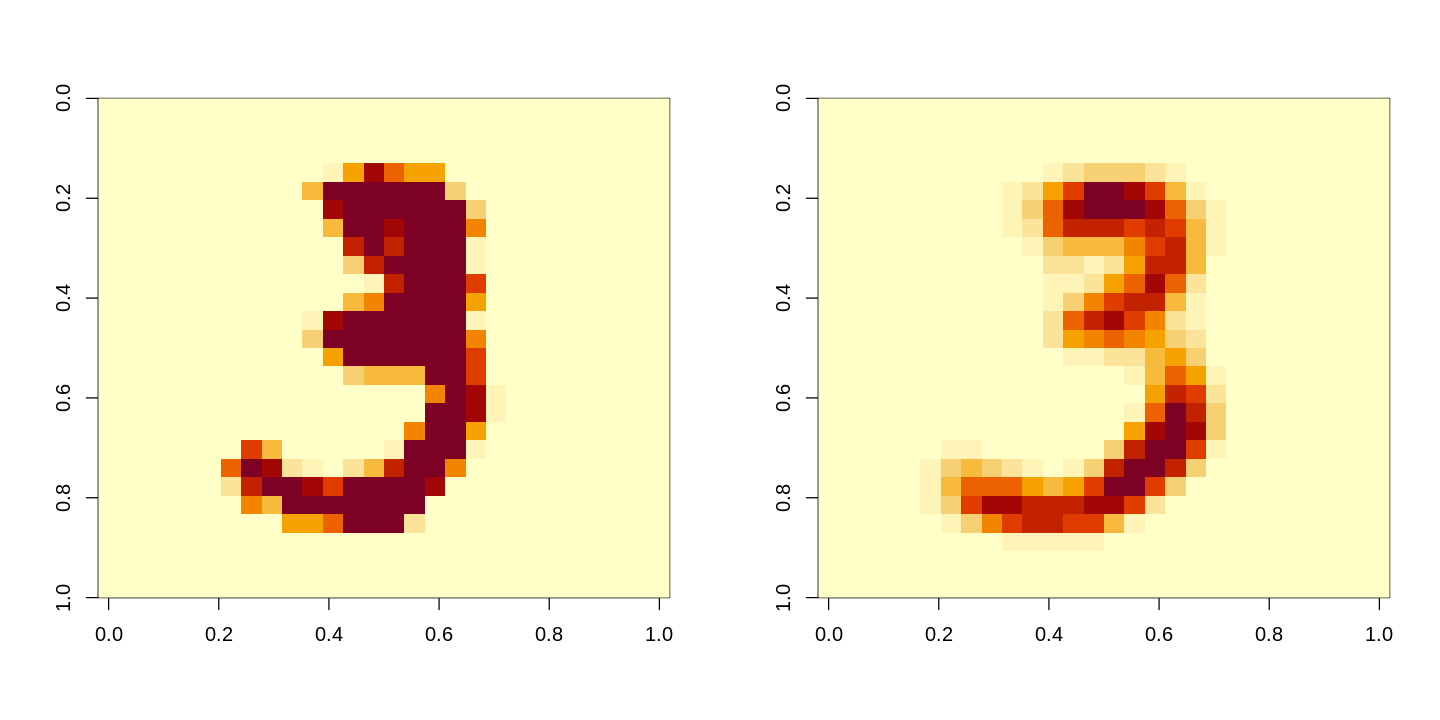

[1] "Epoch 32"
[1] "Training accuracy: 0.8789"
[1] "Validation accuracy: 0.873487348734873"


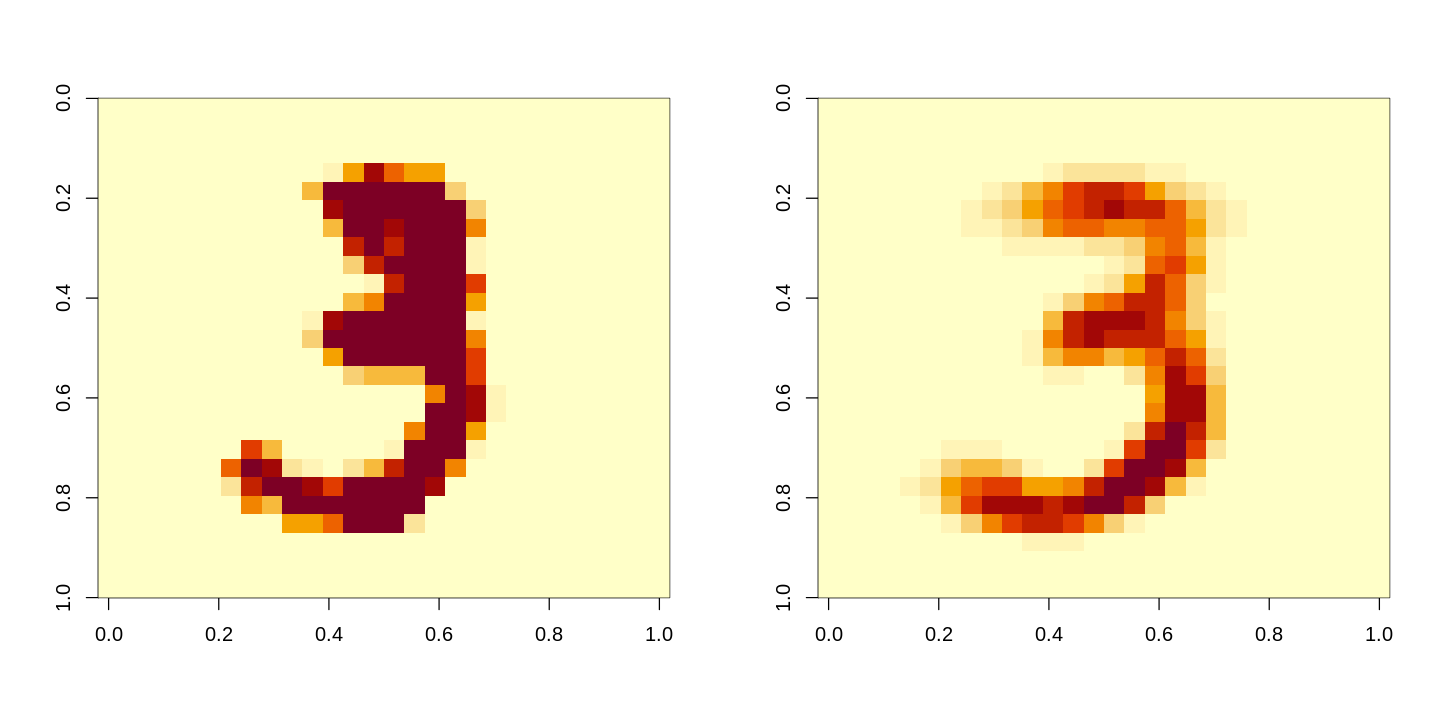

[1] "Epoch 33"
[1] "Training accuracy: 0.8822"
[1] "Validation accuracy: 0.877087708770877"


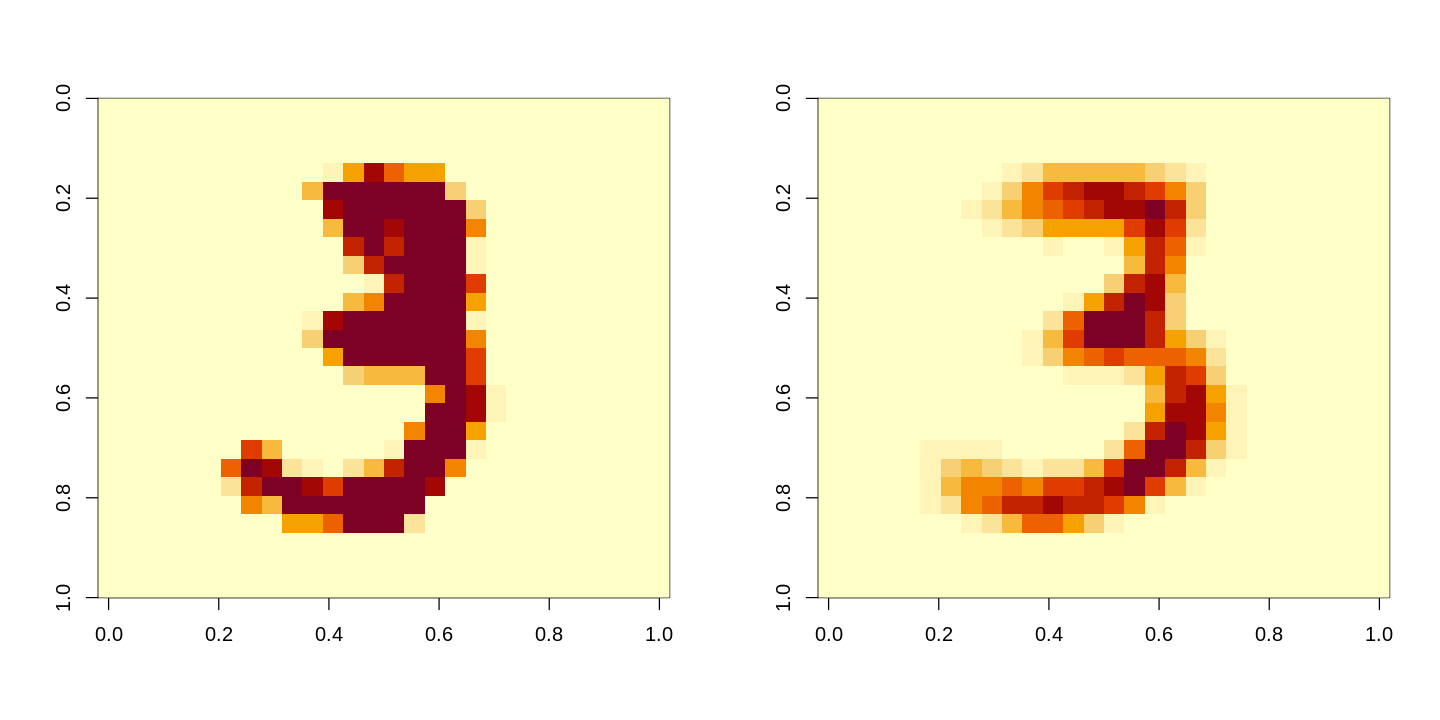

[1] "Epoch 34"
[1] "Training accuracy: 0.8827"
[1] "Validation accuracy: 0.877587758775878"


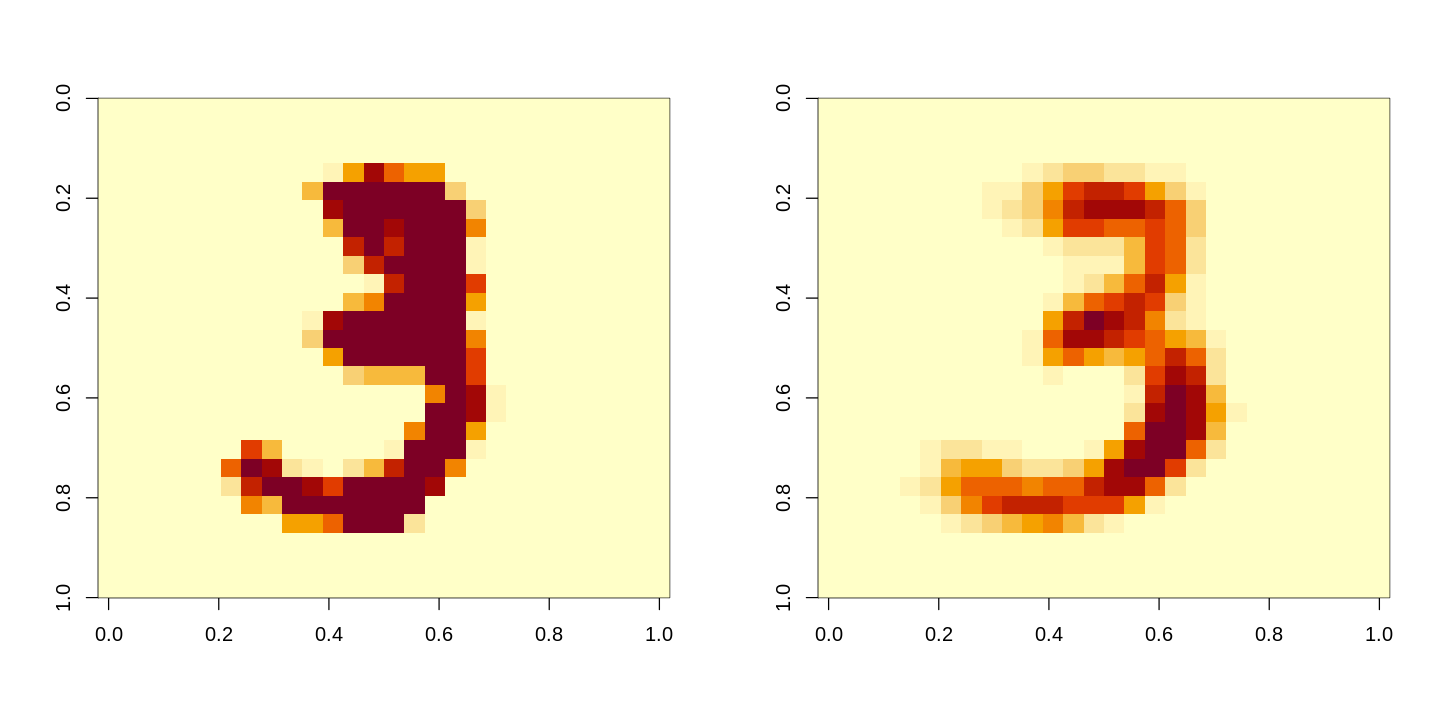

[1] "Epoch 35"
[1] "Training accuracy: 0.8846"
[1] "Validation accuracy: 0.878687868786879"


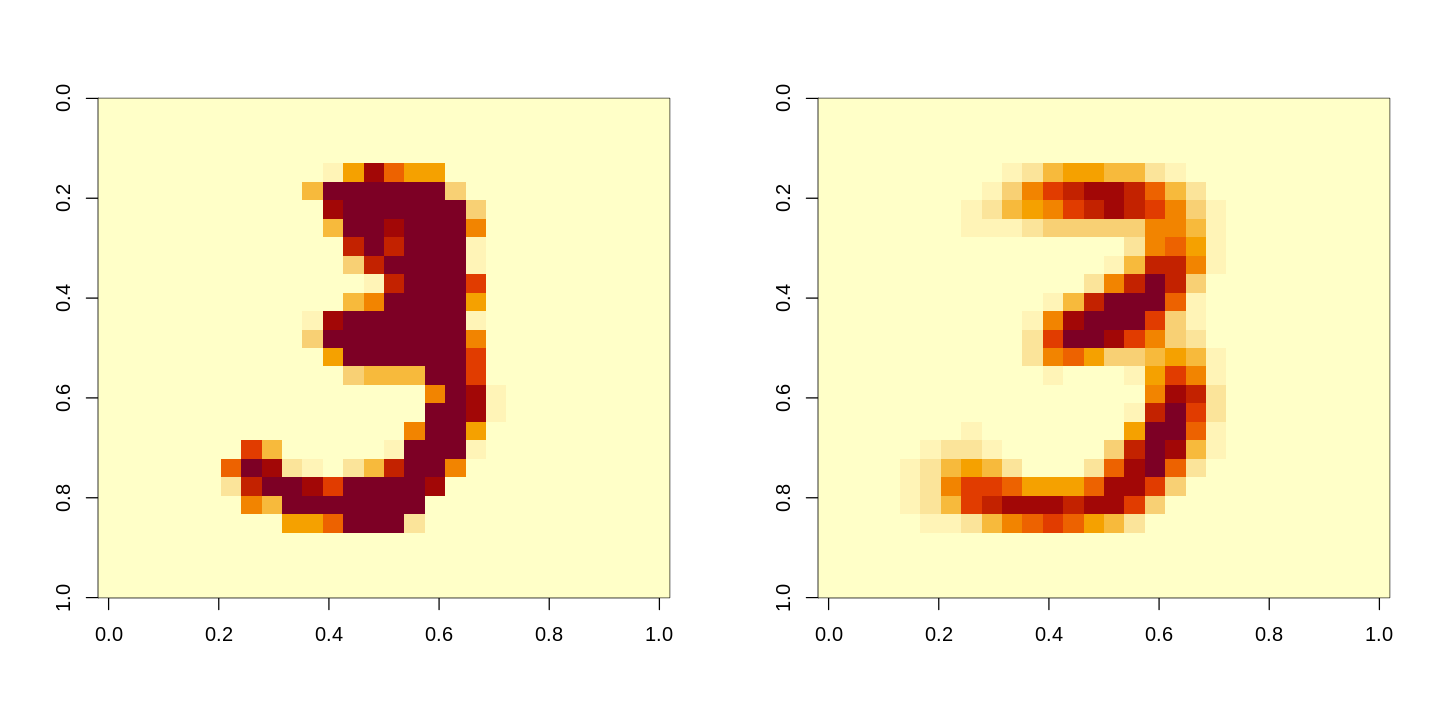

[1] "Epoch 36"
[1] "Training accuracy: 0.8854"
[1] "Validation accuracy: 0.880788078807881"


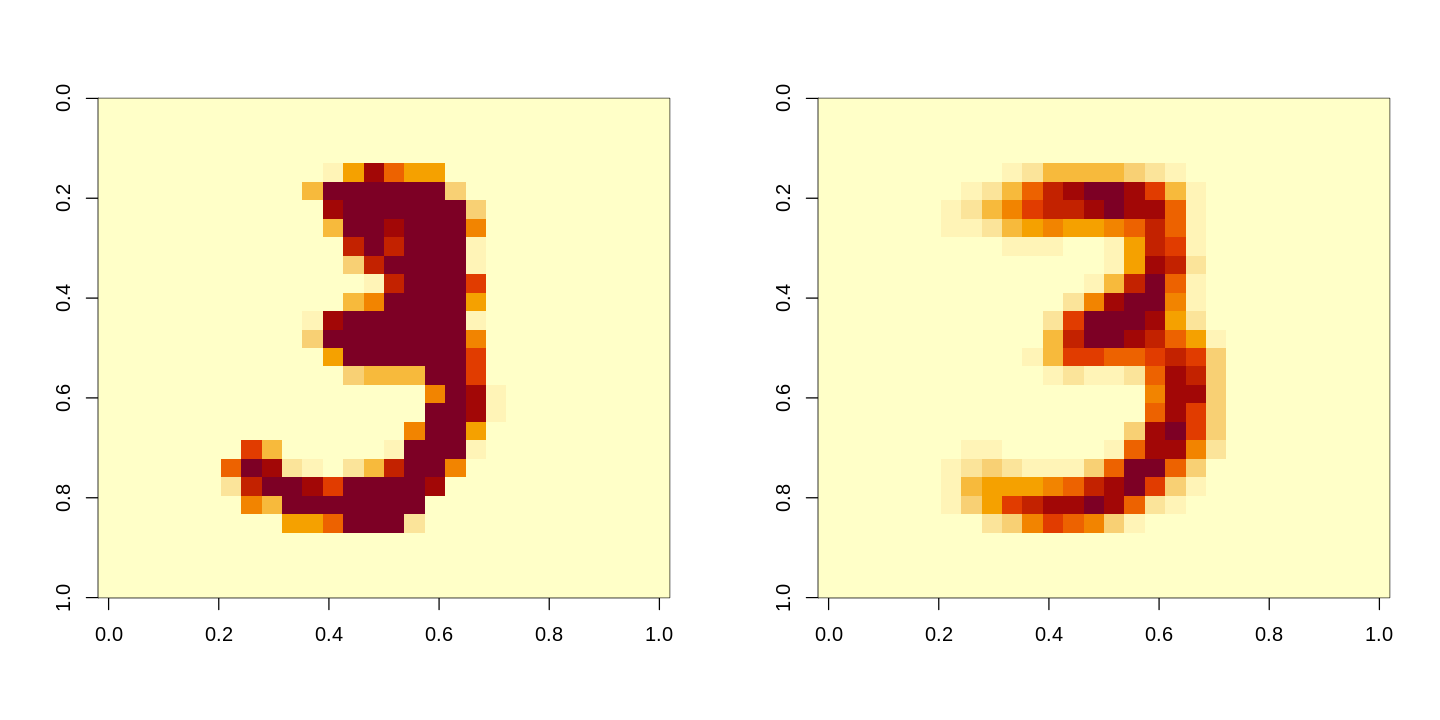

[1] "Epoch 37"
[1] "Training accuracy: 0.8865"
[1] "Validation accuracy: 0.881088108810881"


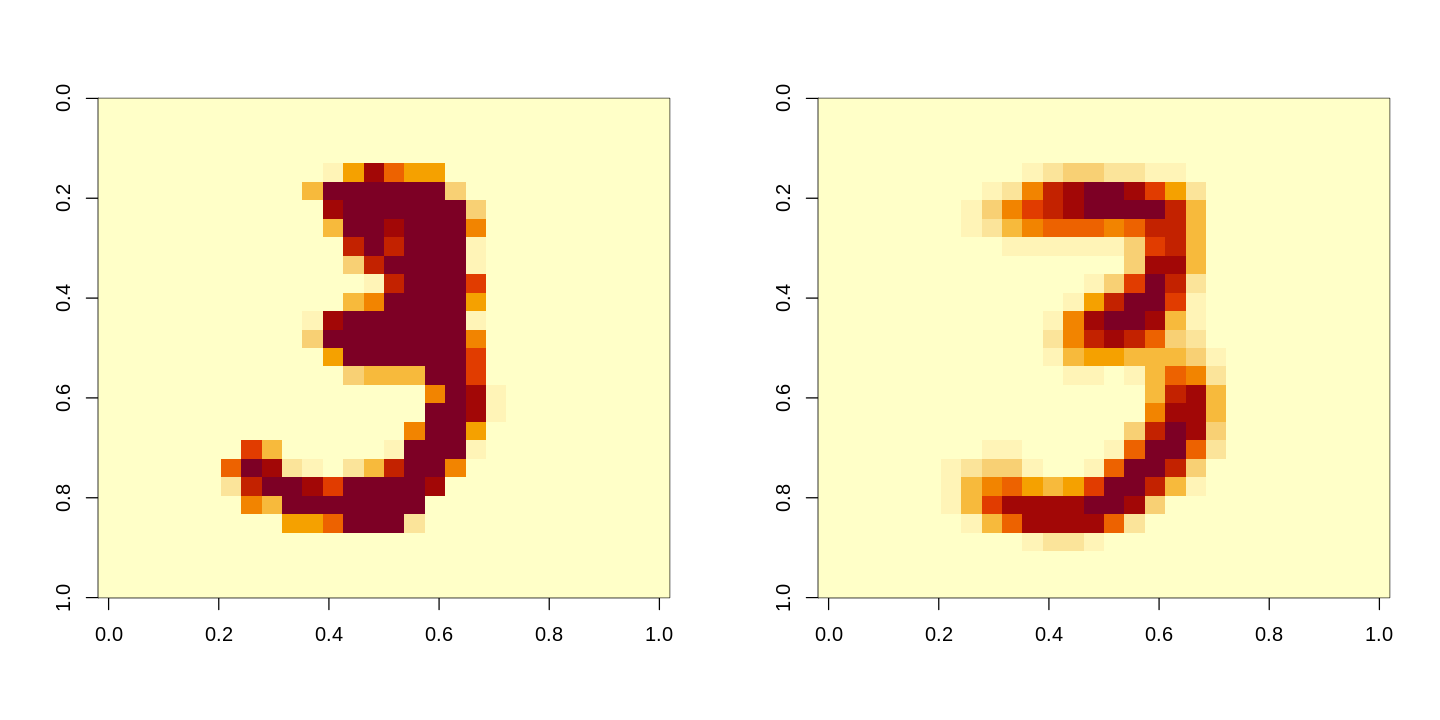

[1] "Epoch 38"
[1] "Training accuracy: 0.887"
[1] "Validation accuracy: 0.881388138813881"


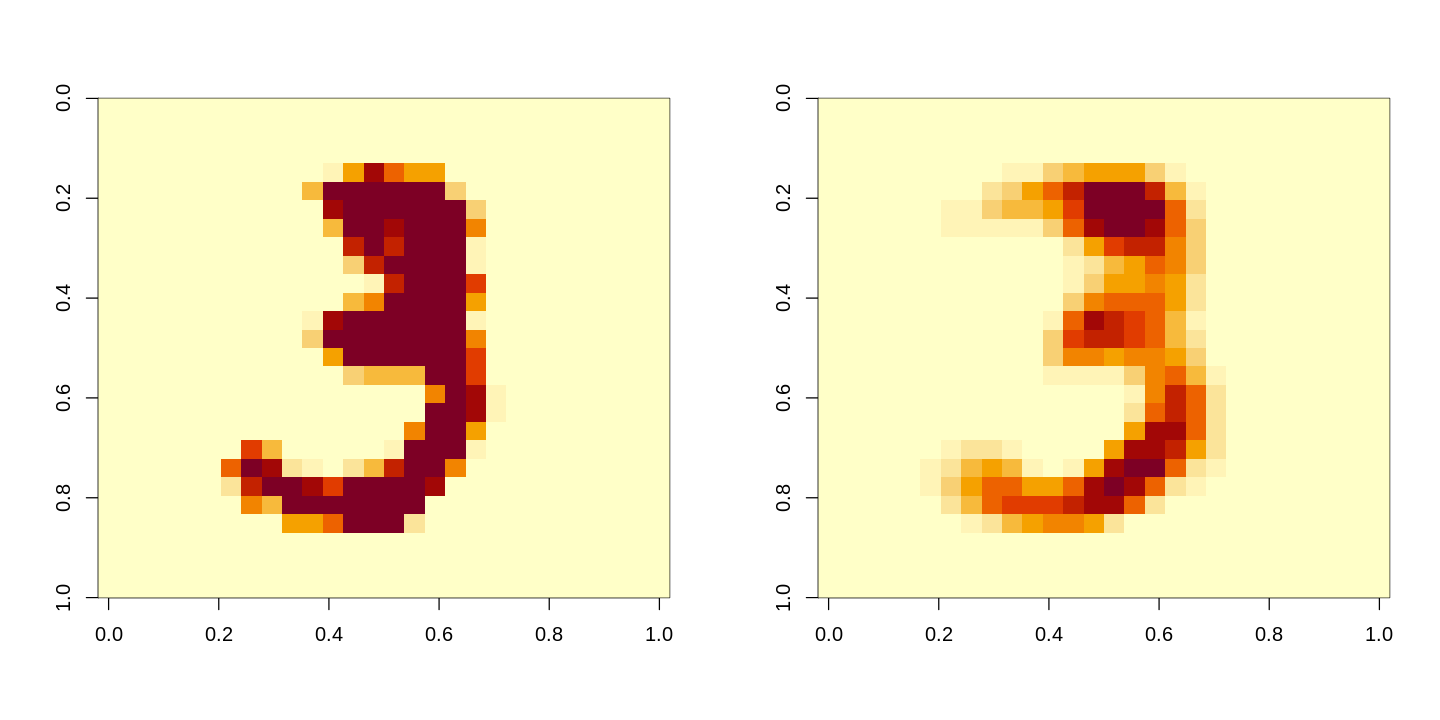

[1] "Epoch 39"
[1] "Training accuracy: 0.8893"
[1] "Validation accuracy: 0.883488348834883"


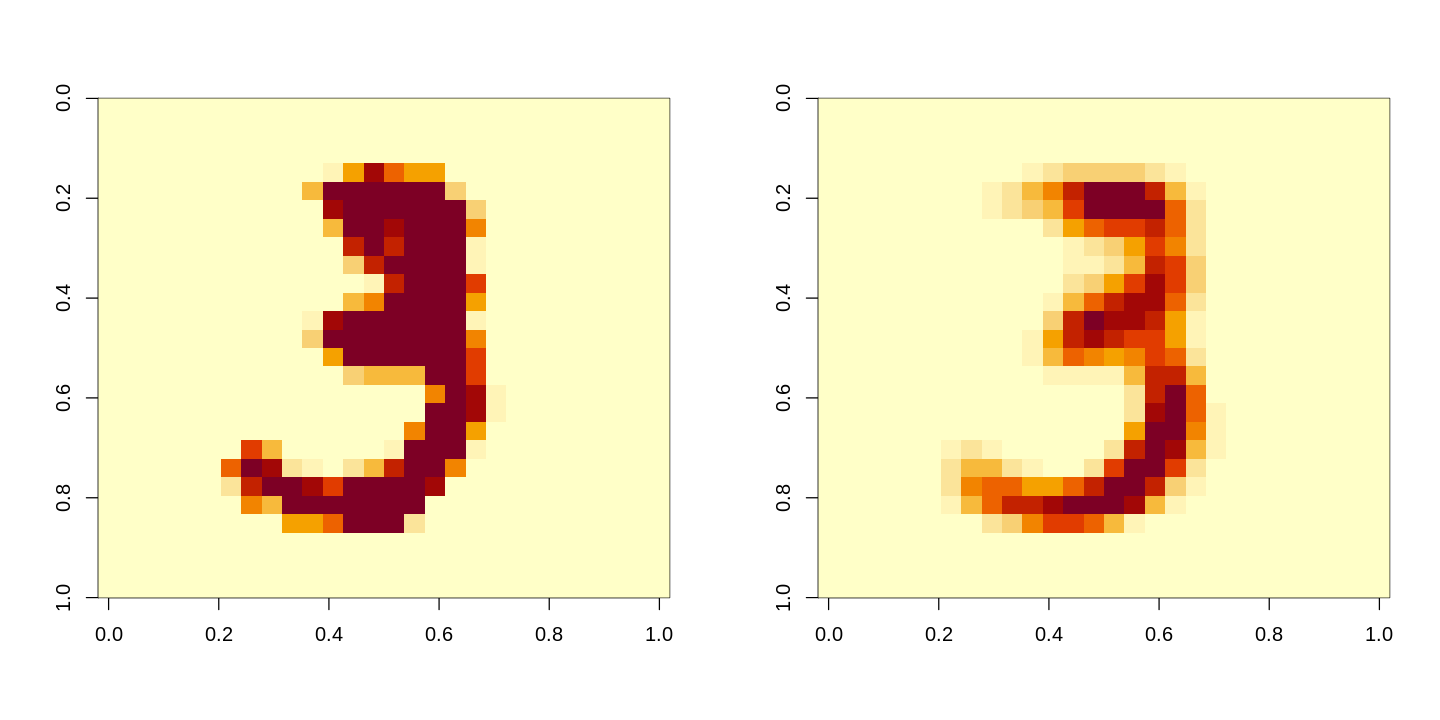

[1] "Epoch 40"
[1] "Training accuracy: 0.8902"
[1] "Validation accuracy: 0.884188418841884"


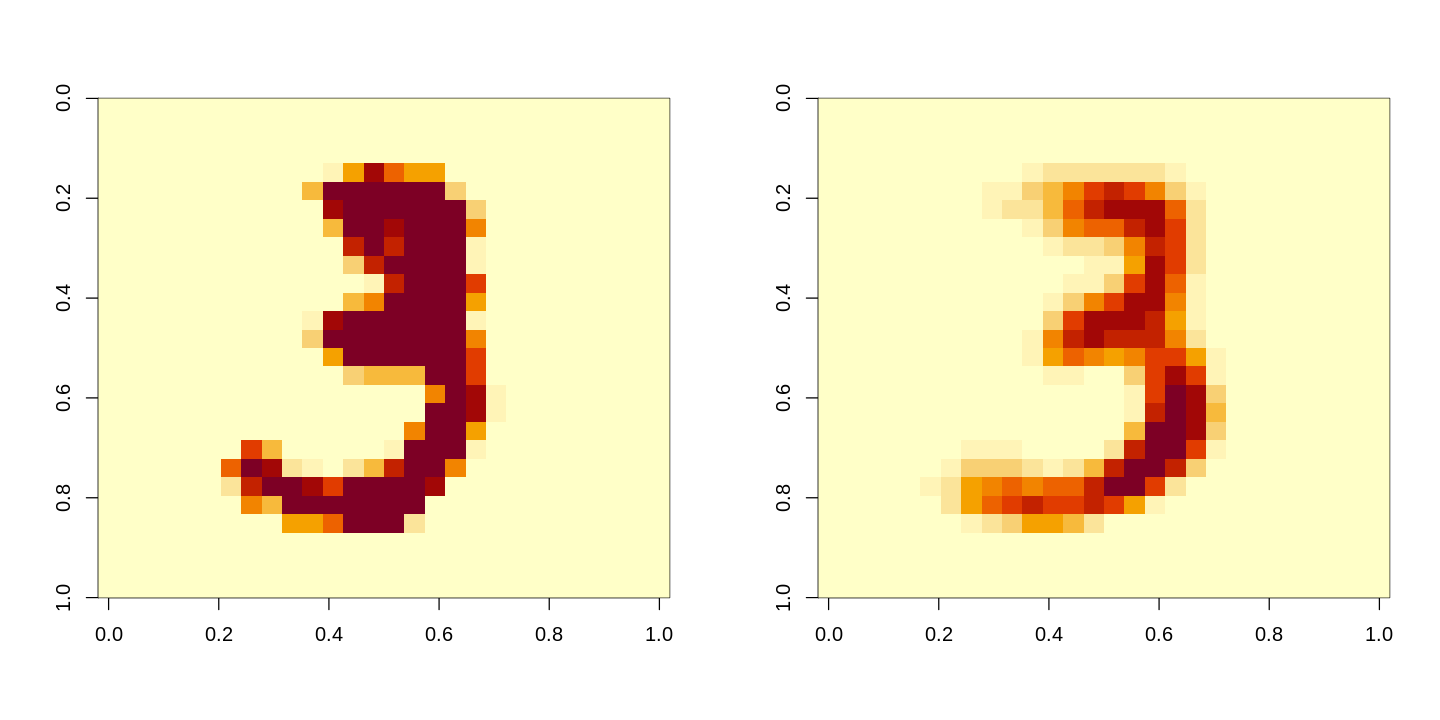

[1] "Epoch 41"
[1] "Training accuracy: 0.8902"
[1] "Validation accuracy: 0.884088408840884"


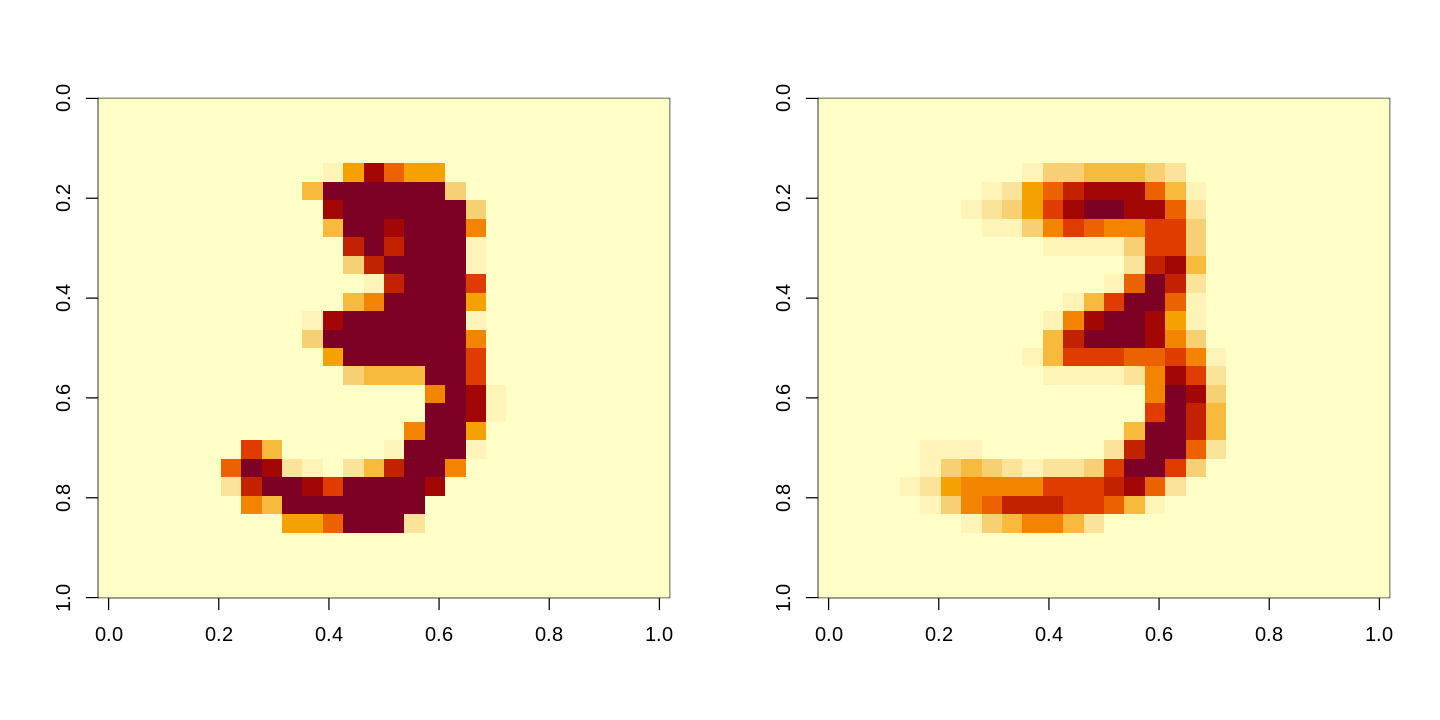

[1] "Epoch 42"
[1] "Training accuracy: 0.8911"
[1] "Validation accuracy: 0.884388438843884"


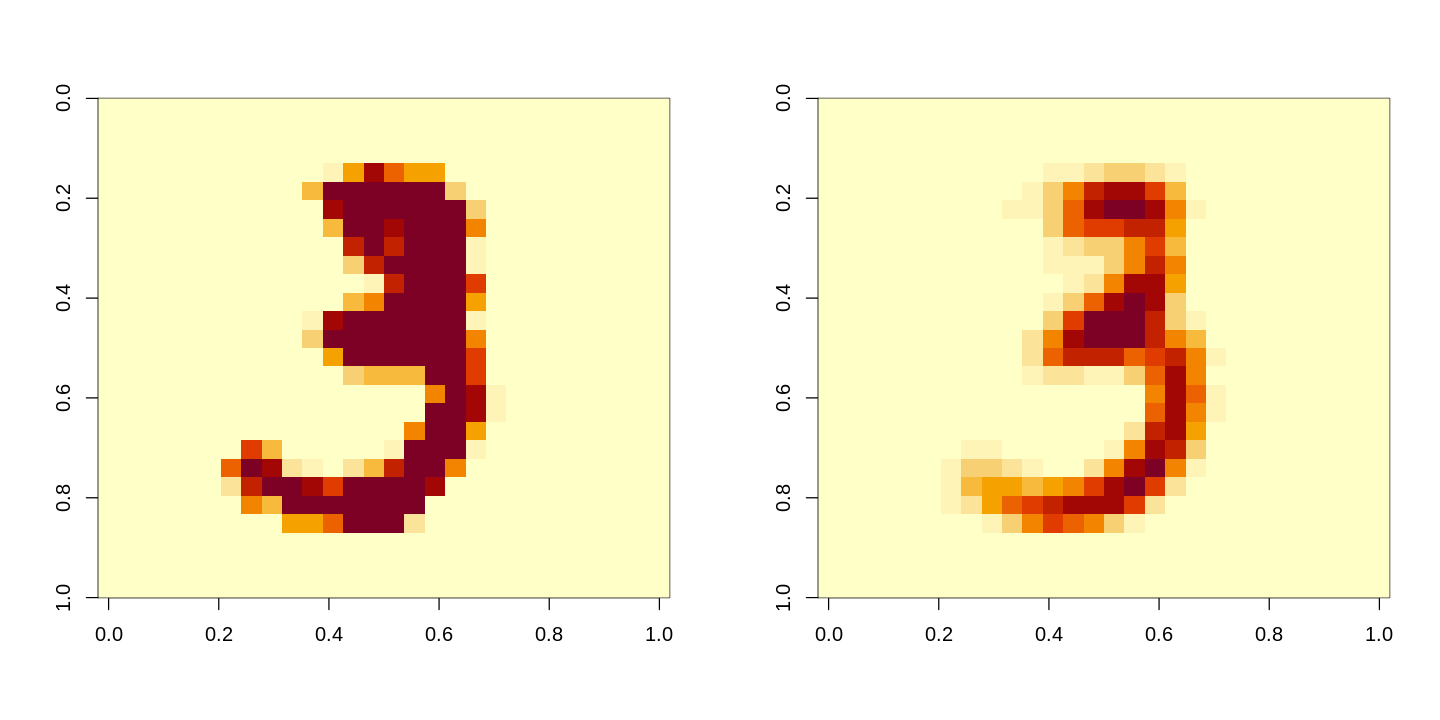

[1] "Epoch 43"
[1] "Training accuracy: 0.8921"
[1] "Validation accuracy: 0.886088608860886"


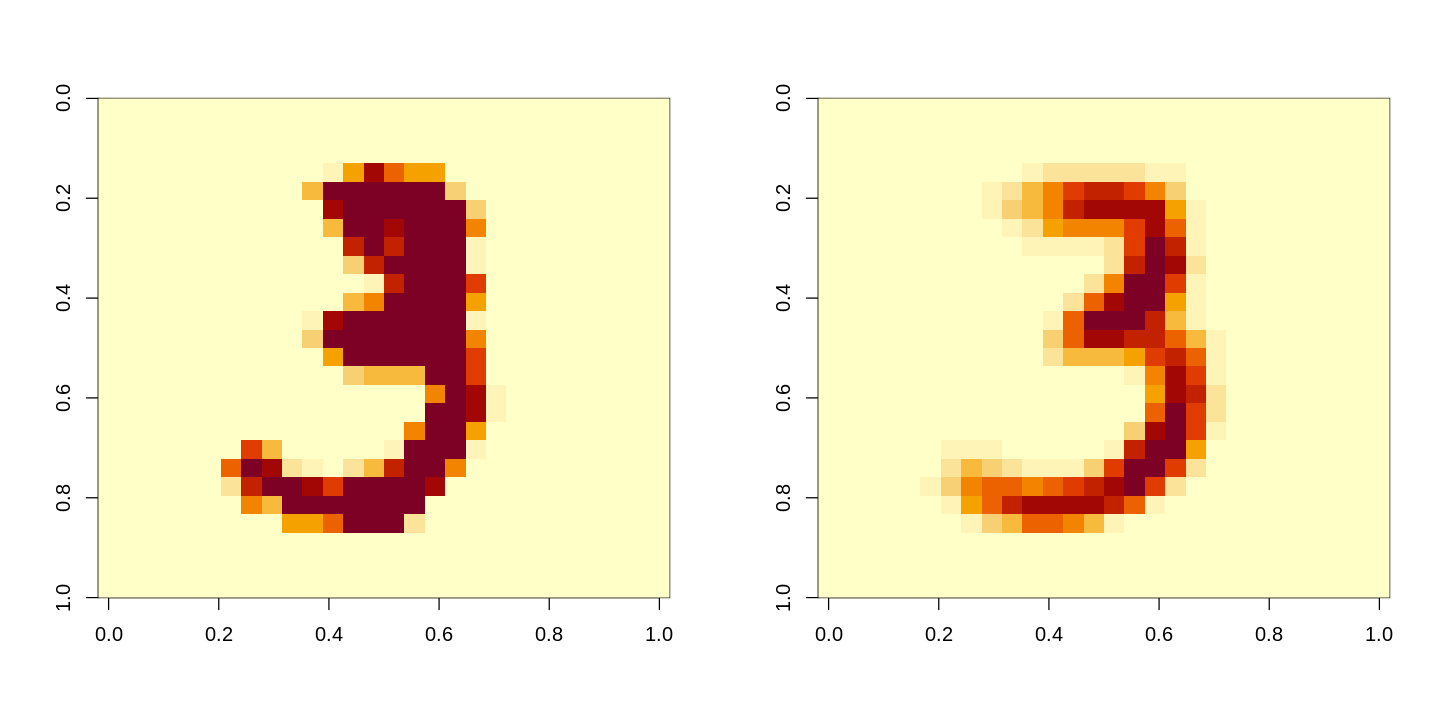

[1] "Epoch 44"
[1] "Training accuracy: 0.893"
[1] "Validation accuracy: 0.887188718871887"


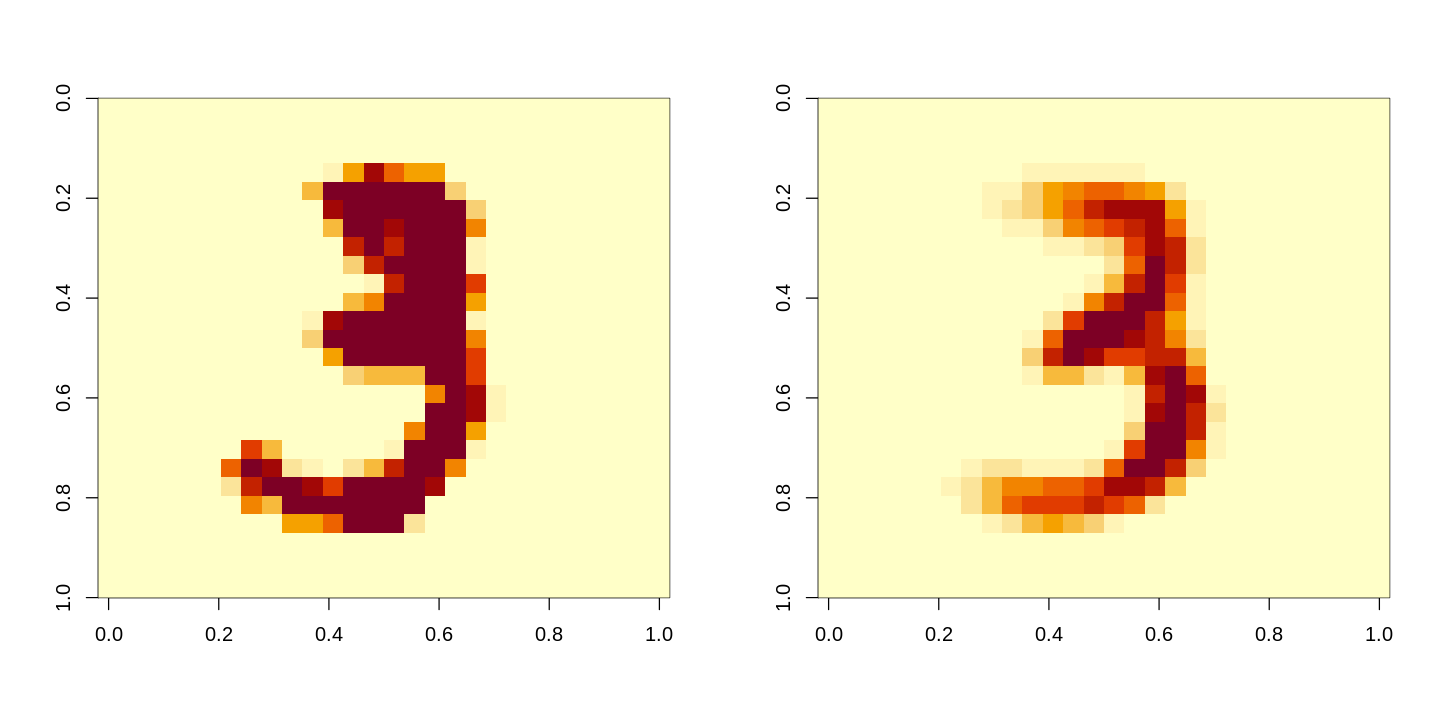

[1] "Epoch 45"
[1] "Training accuracy: 0.8935"
[1] "Validation accuracy: 0.886188618861886"


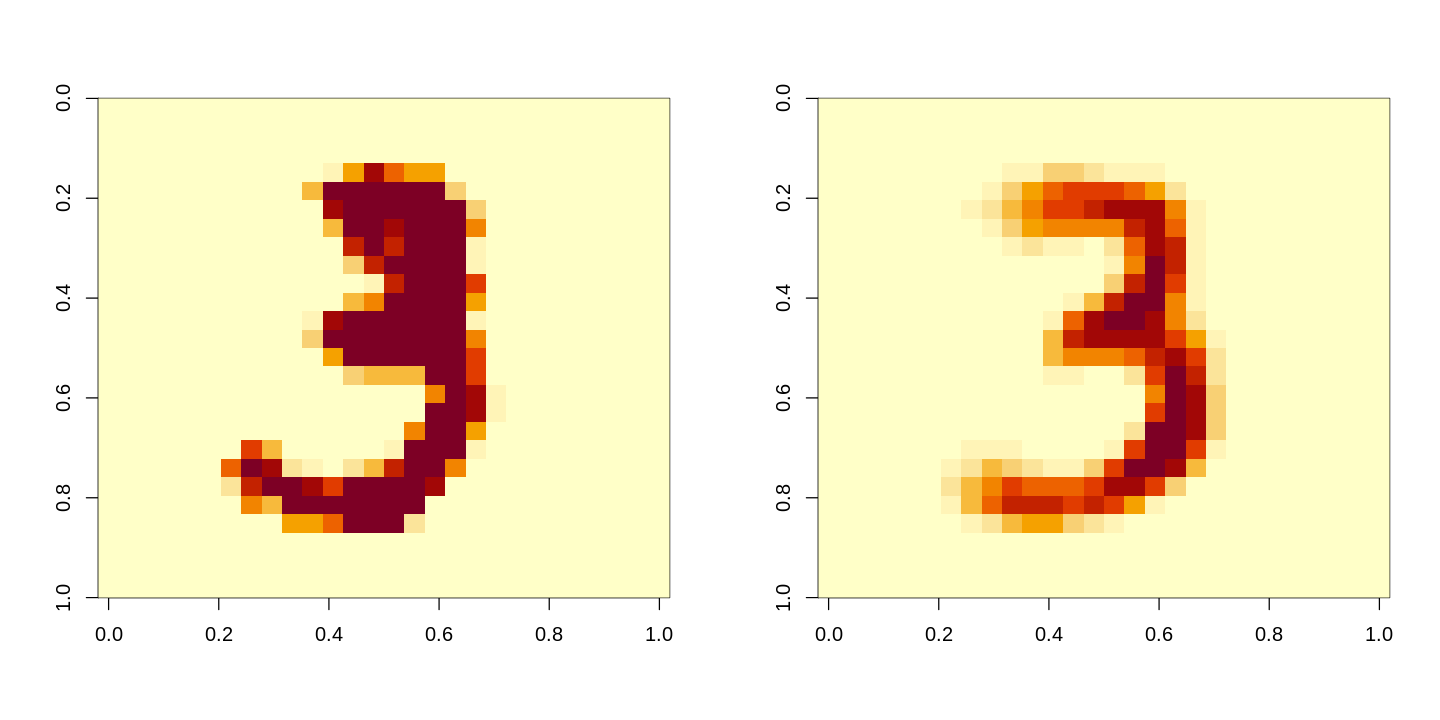

[1] "Epoch 46"
[1] "Training accuracy: 0.8938"
[1] "Validation accuracy: 0.887188718871887"


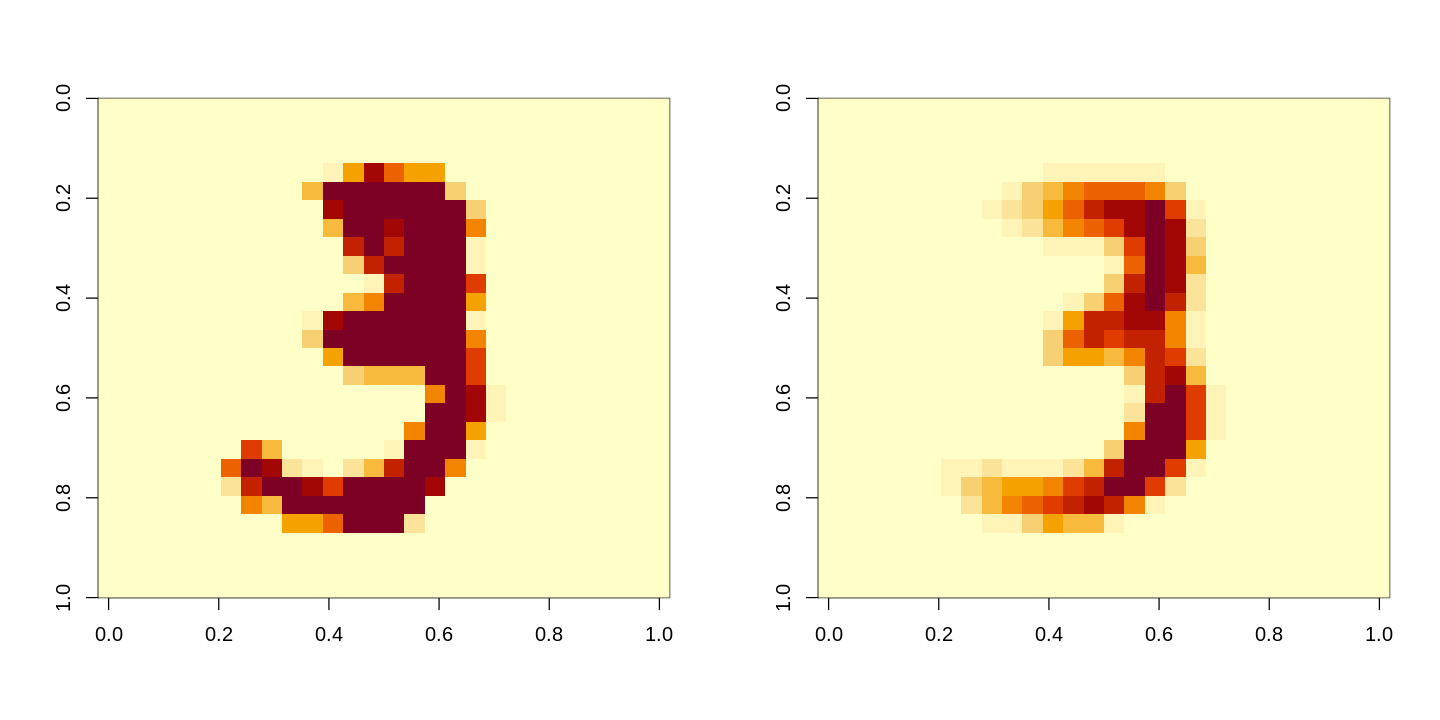

[1] "Epoch 47"
[1] "Training accuracy: 0.8942"
[1] "Validation accuracy: 0.887088708870887"


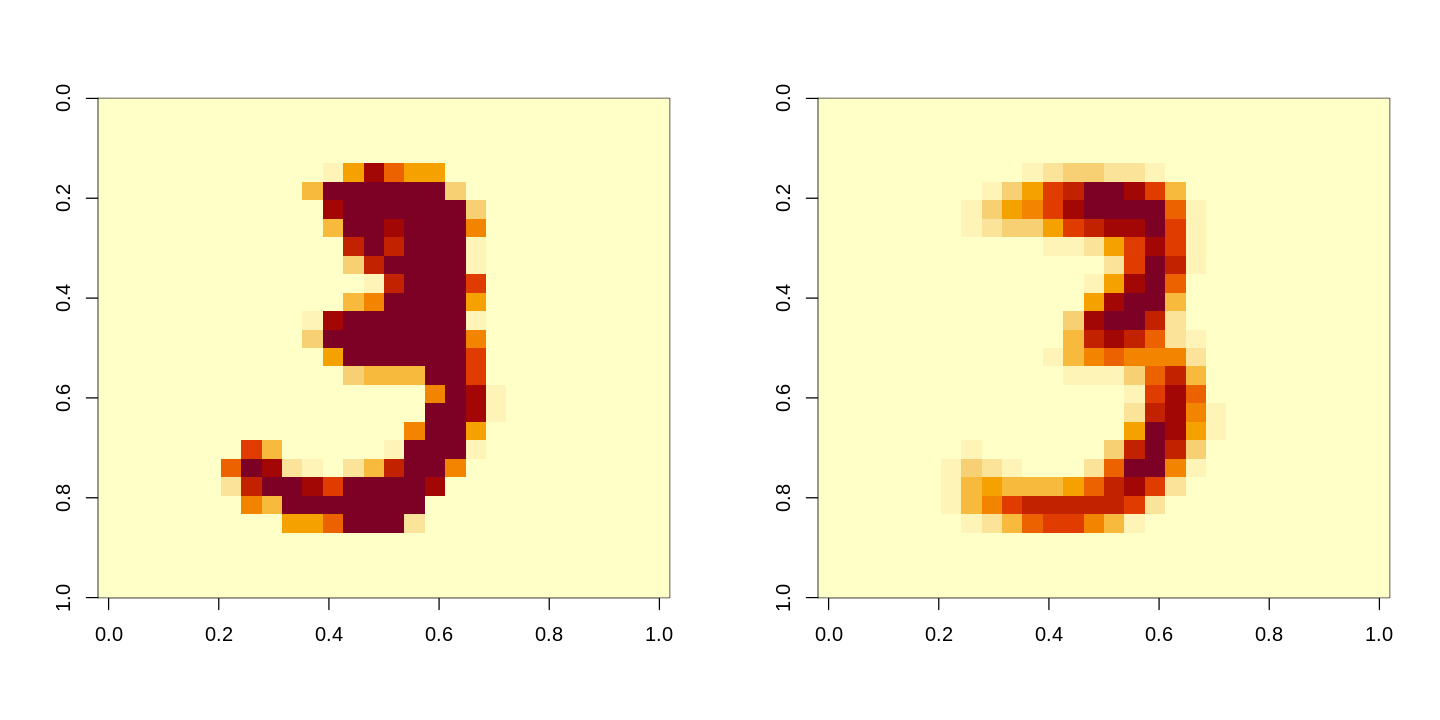

[1] "Epoch 48"
[1] "Training accuracy: 0.8956"
[1] "Validation accuracy: 0.889388938893889"


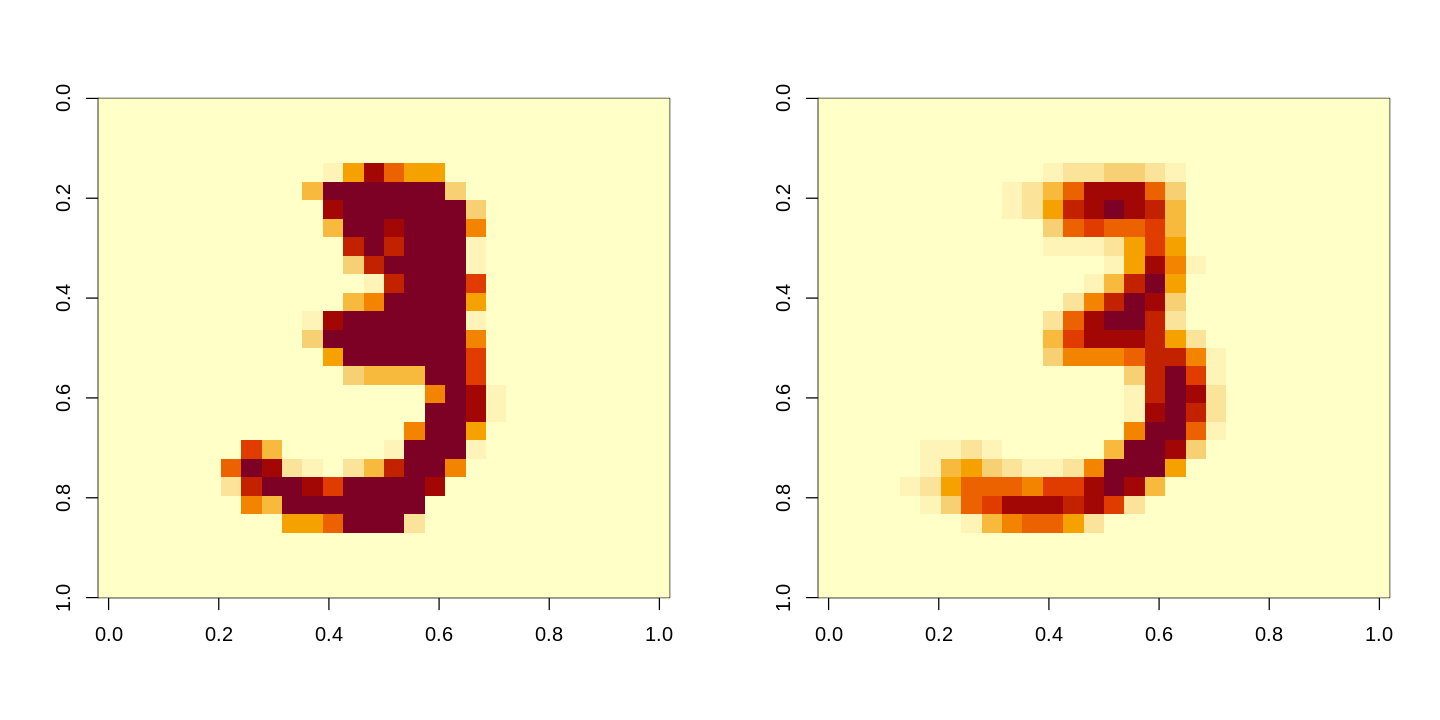

[1] "Epoch 49"
[1] "Training accuracy: 0.8955"
[1] "Validation accuracy: 0.891489148914892"


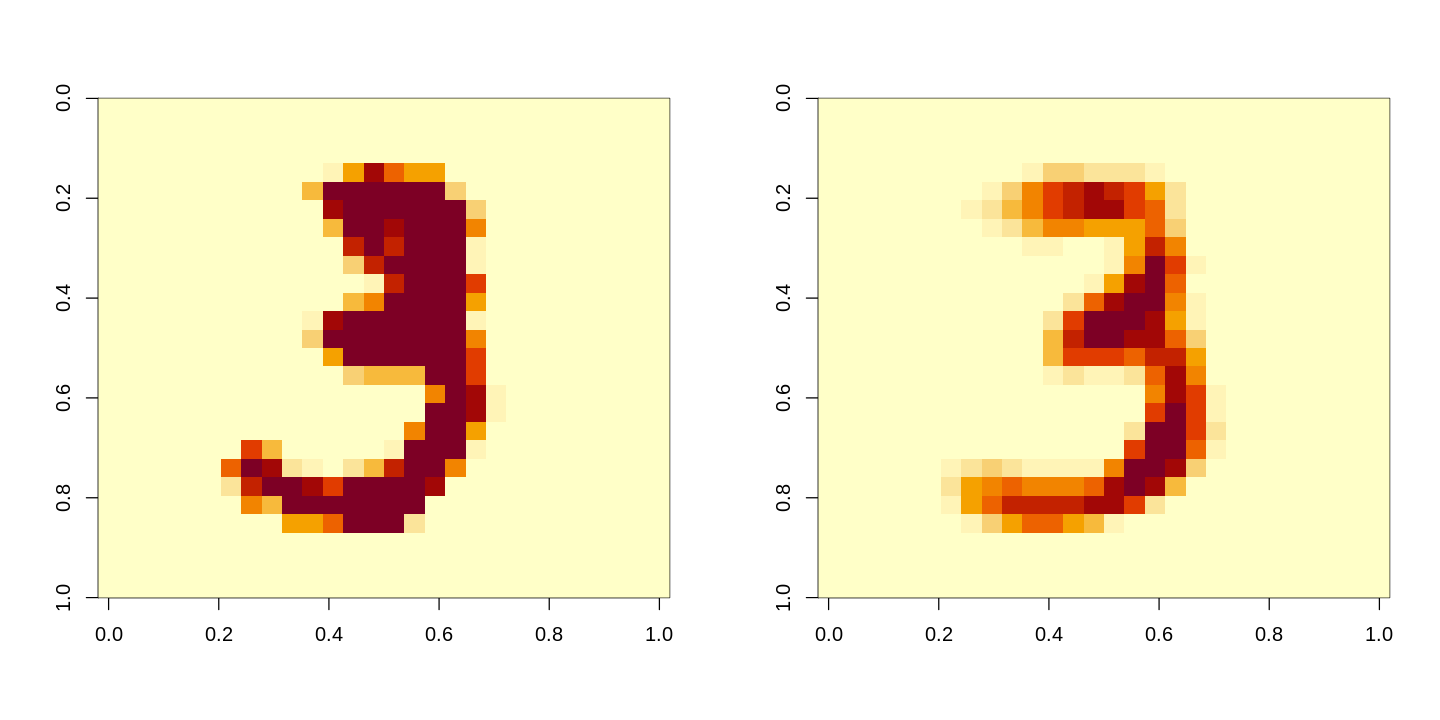

[1] "Epoch 50"
[1] "Training accuracy: 0.8954"
[1] "Validation accuracy: 0.890589058905891"


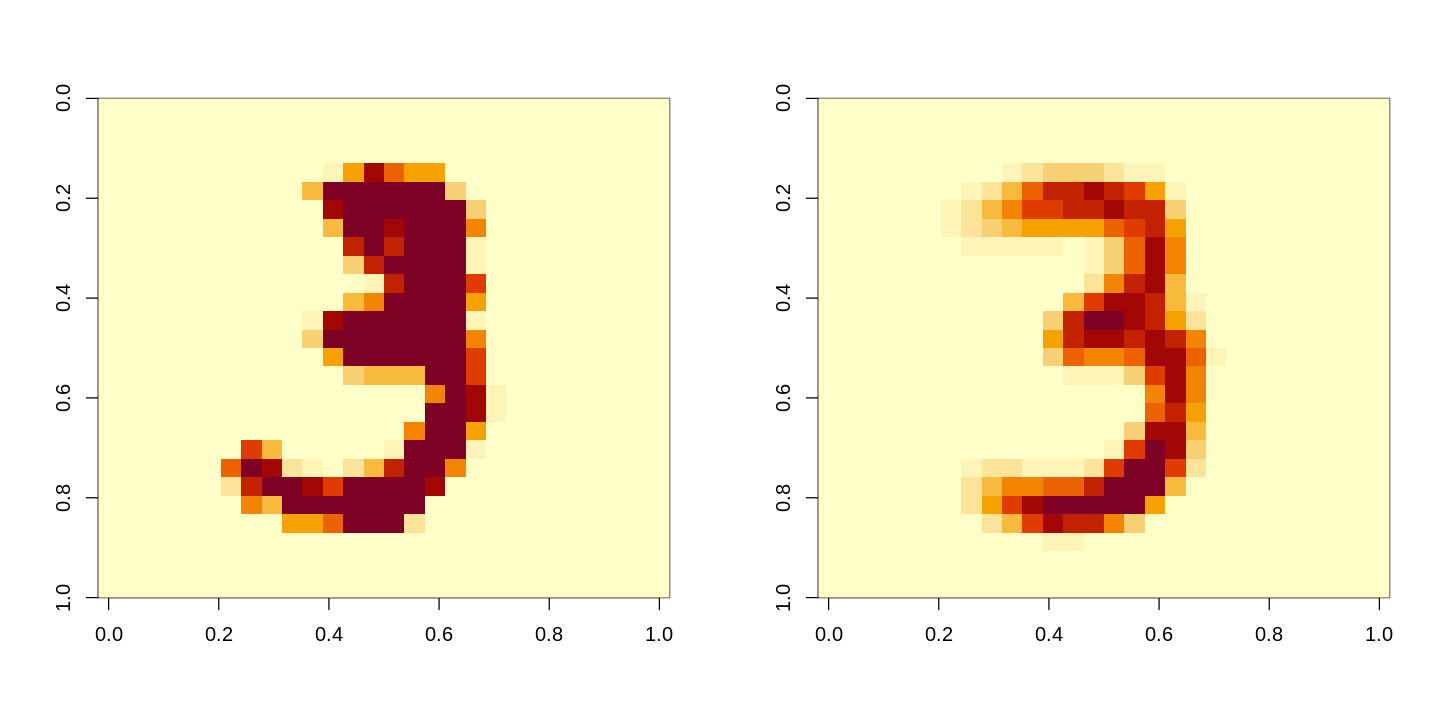

[1] "Epoch 51"
[1] "Training accuracy: 0.8963"
[1] "Validation accuracy: 0.890989098909891"


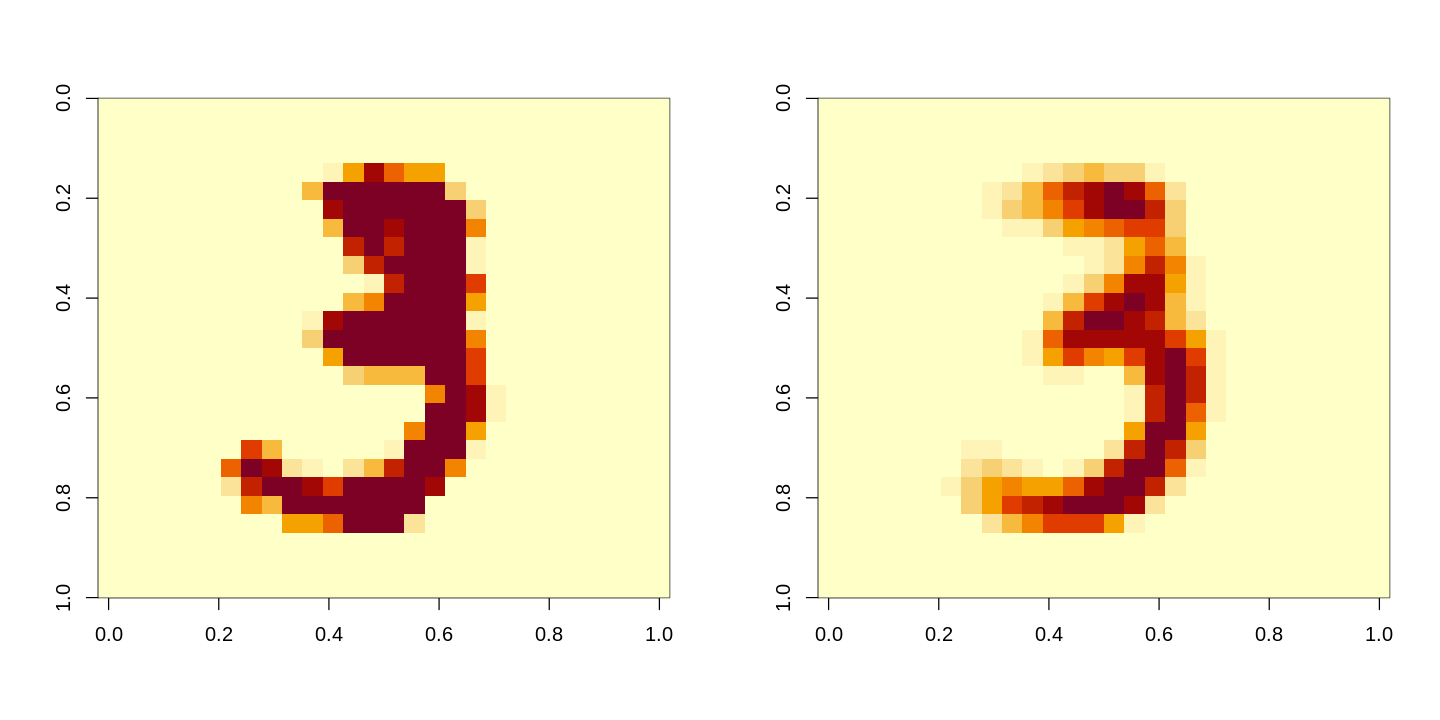

[1] "Epoch 52"
[1] "Training accuracy: 0.8964"
[1] "Validation accuracy: 0.89038903890389"


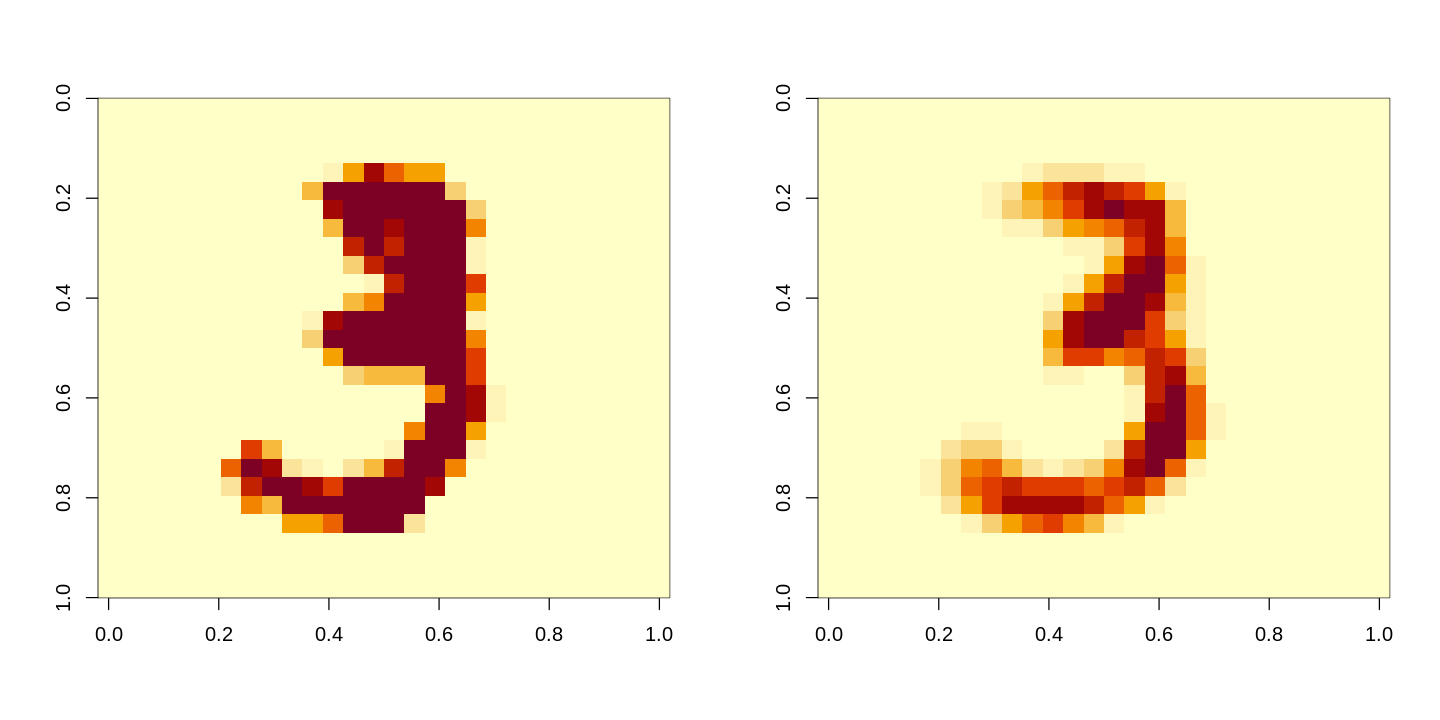

[1] "Epoch 53"
[1] "Training accuracy: 0.8983"
[1] "Validation accuracy: 0.891289128912891"


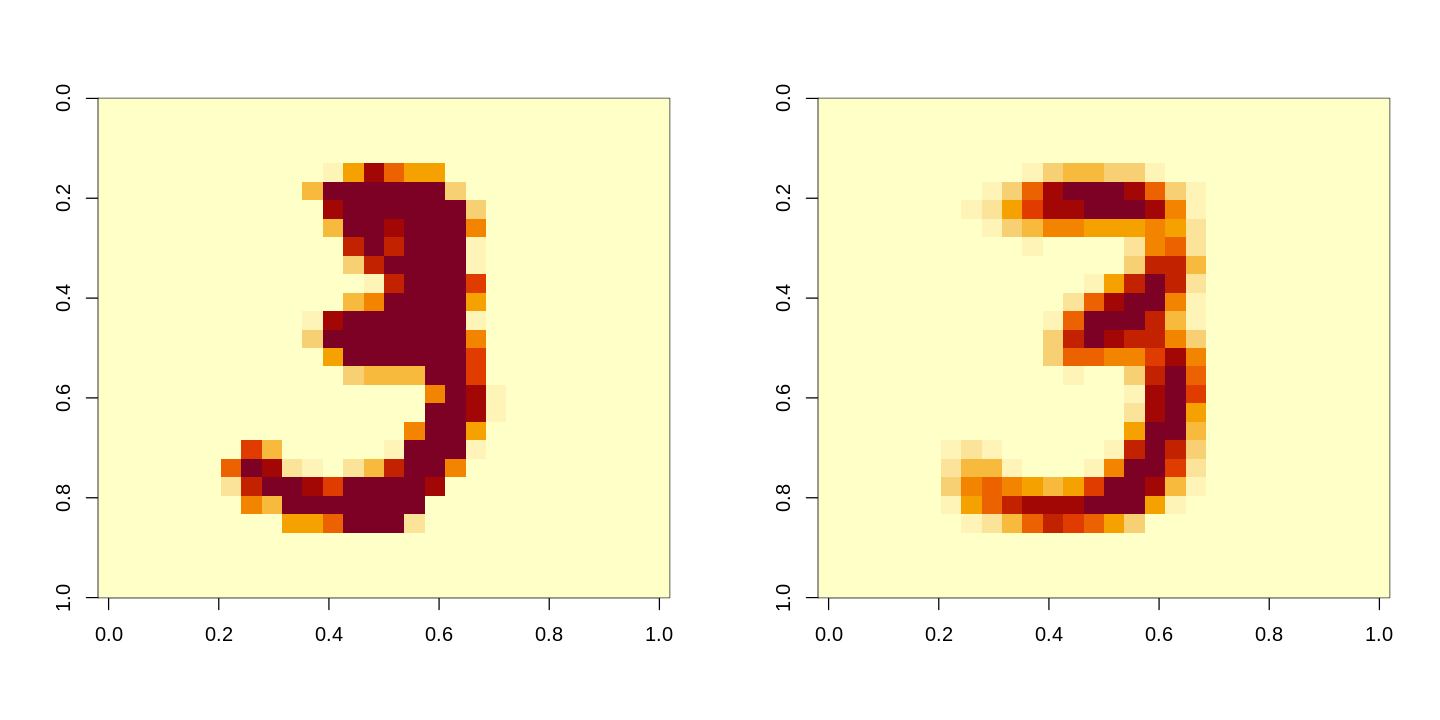

[1] "Epoch 54"
[1] "Training accuracy: 0.898"
[1] "Validation accuracy: 0.891689168916892"


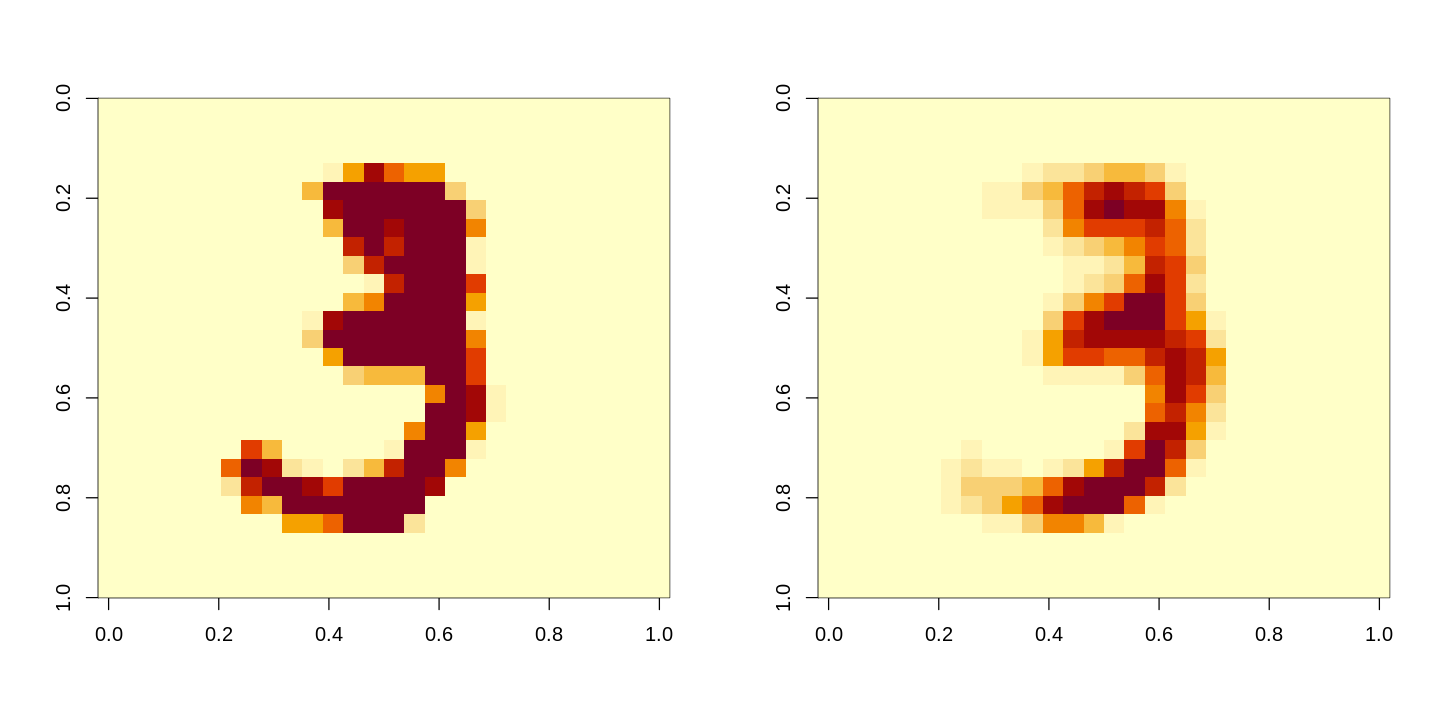

[1] "Epoch 55"
[1] "Training accuracy: 0.8993"
[1] "Validation accuracy: 0.891789178917892"


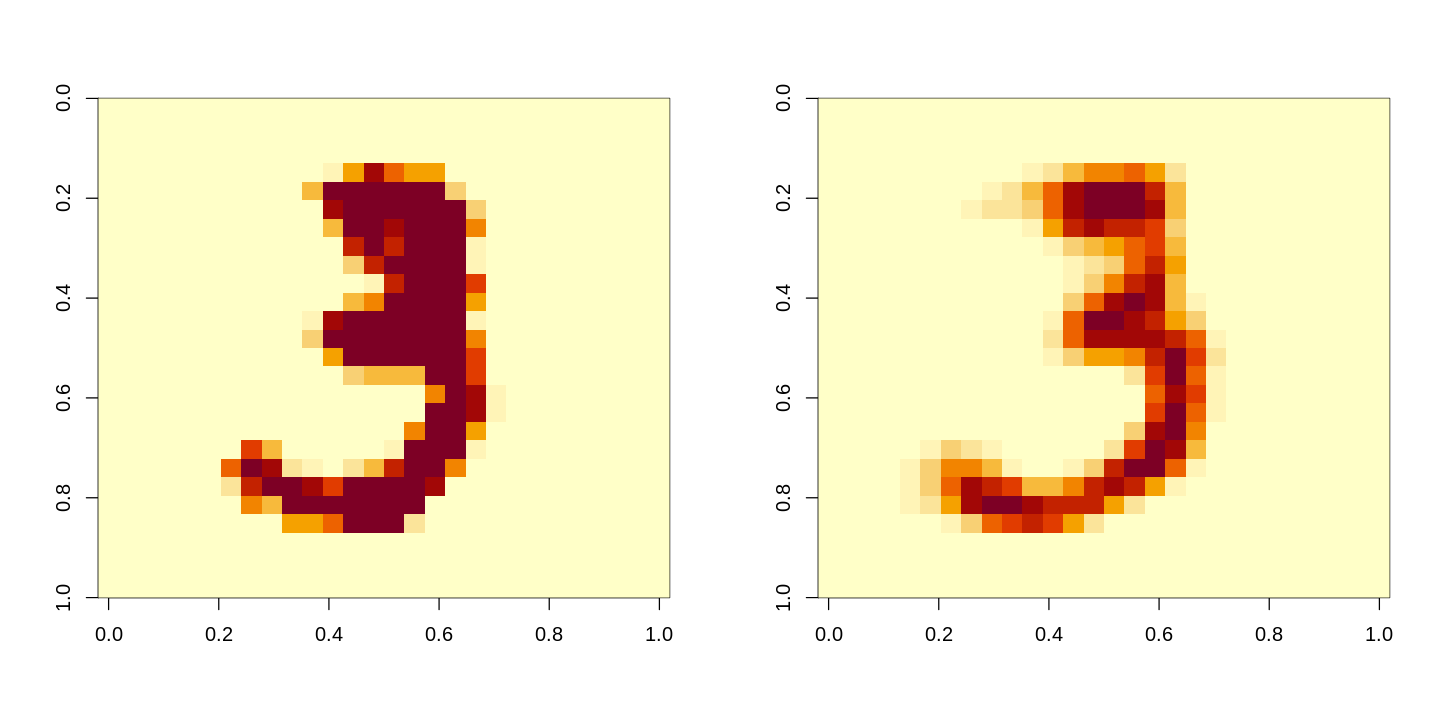

[1] "Epoch 56"
[1] "Training accuracy: 0.8996"
[1] "Validation accuracy: 0.891289128912891"


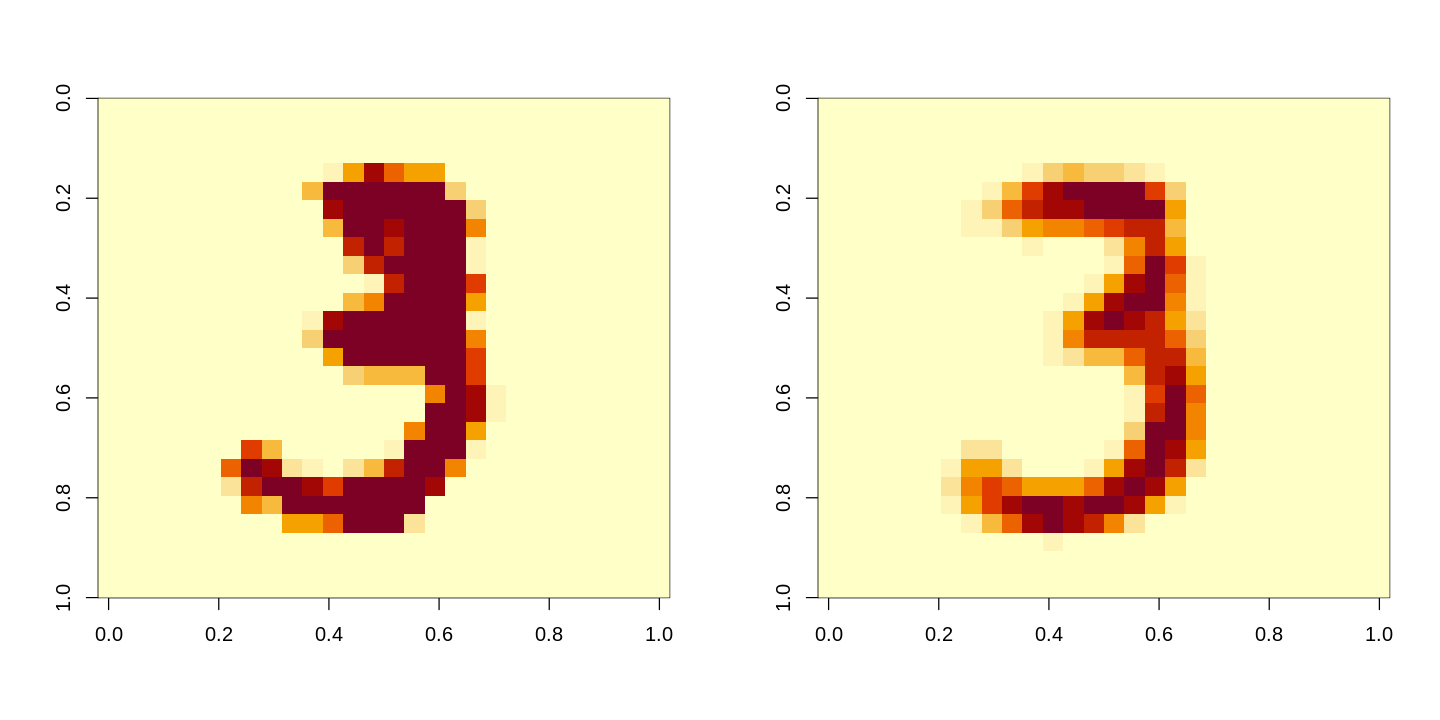

[1] "Epoch 57"
[1] "Training accuracy: 0.8997"
[1] "Validation accuracy: 0.892289228922892"


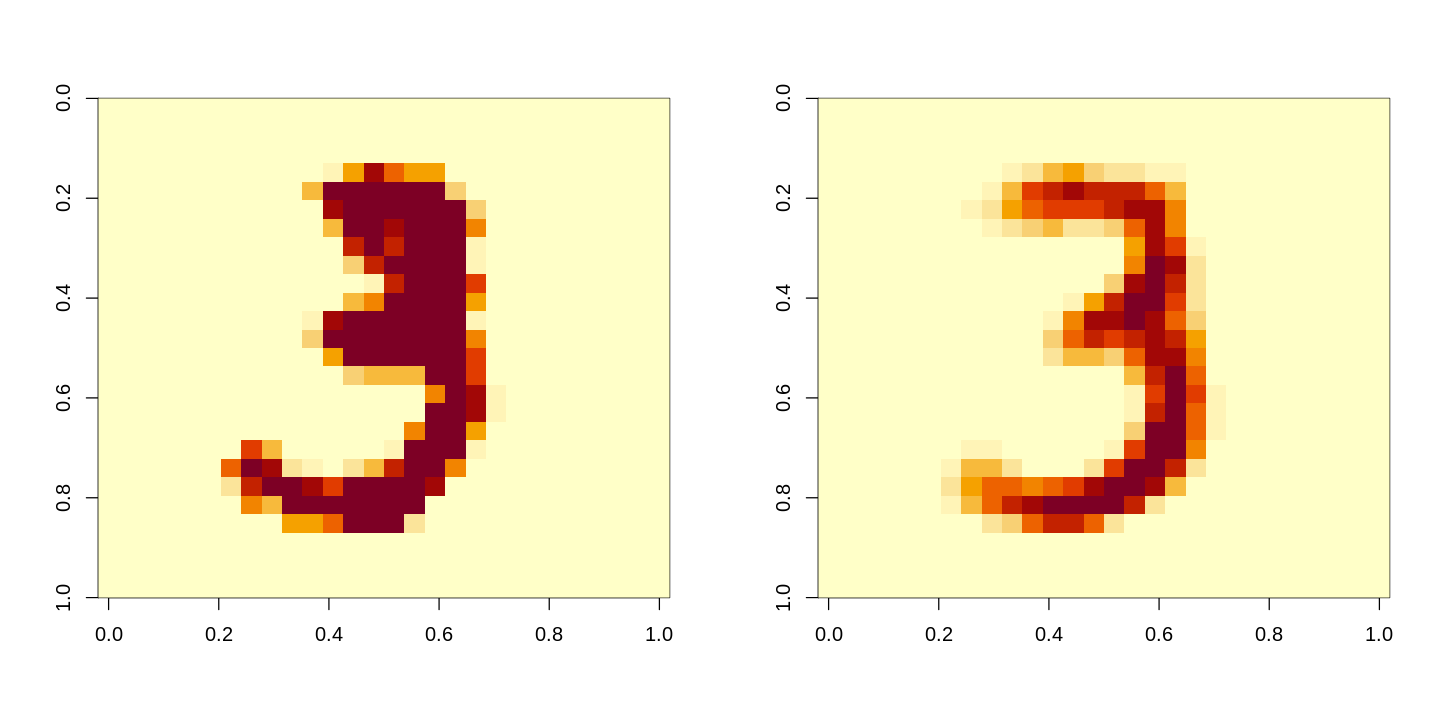

[1] "Epoch 58"
[1] "Training accuracy: 0.8994"
[1] "Validation accuracy: 0.892489248924892"


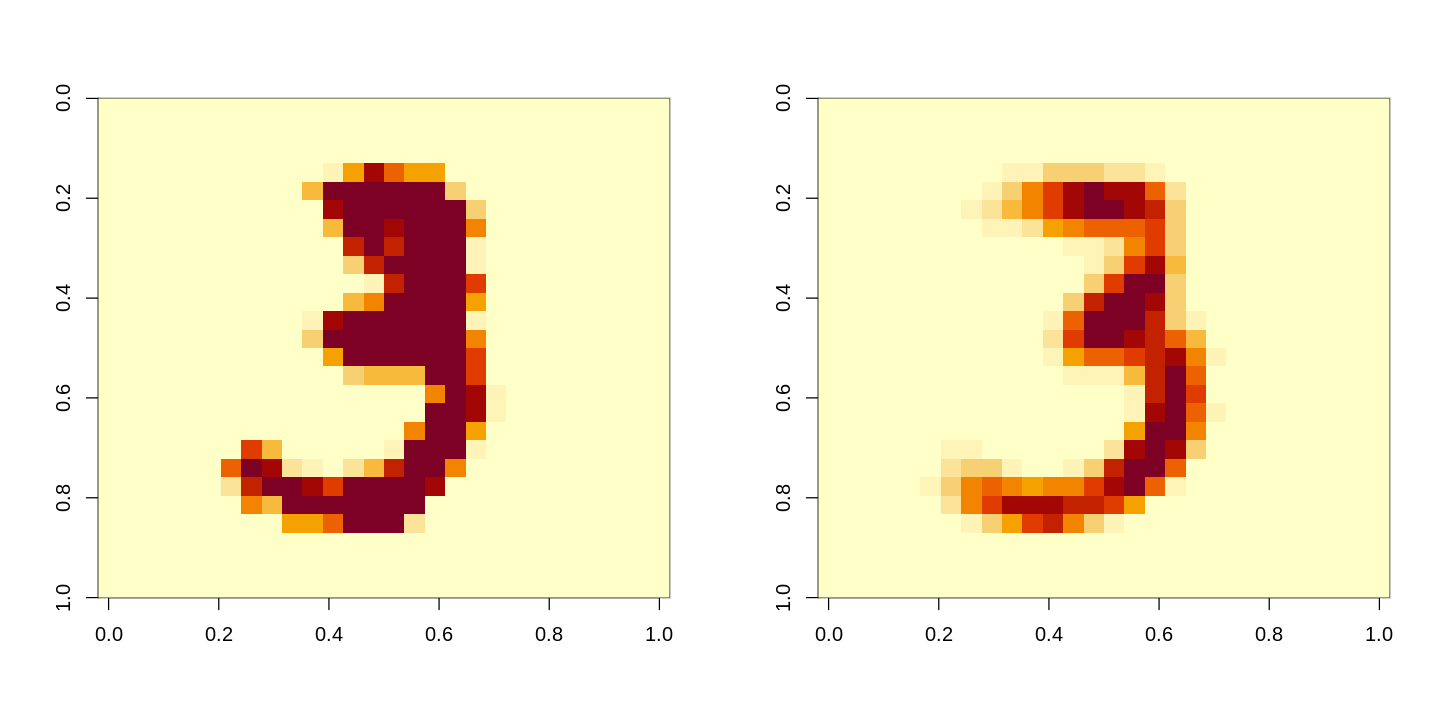

[1] "Epoch 59"
[1] "Training accuracy: 0.9006"
[1] "Validation accuracy: 0.892589258925893"


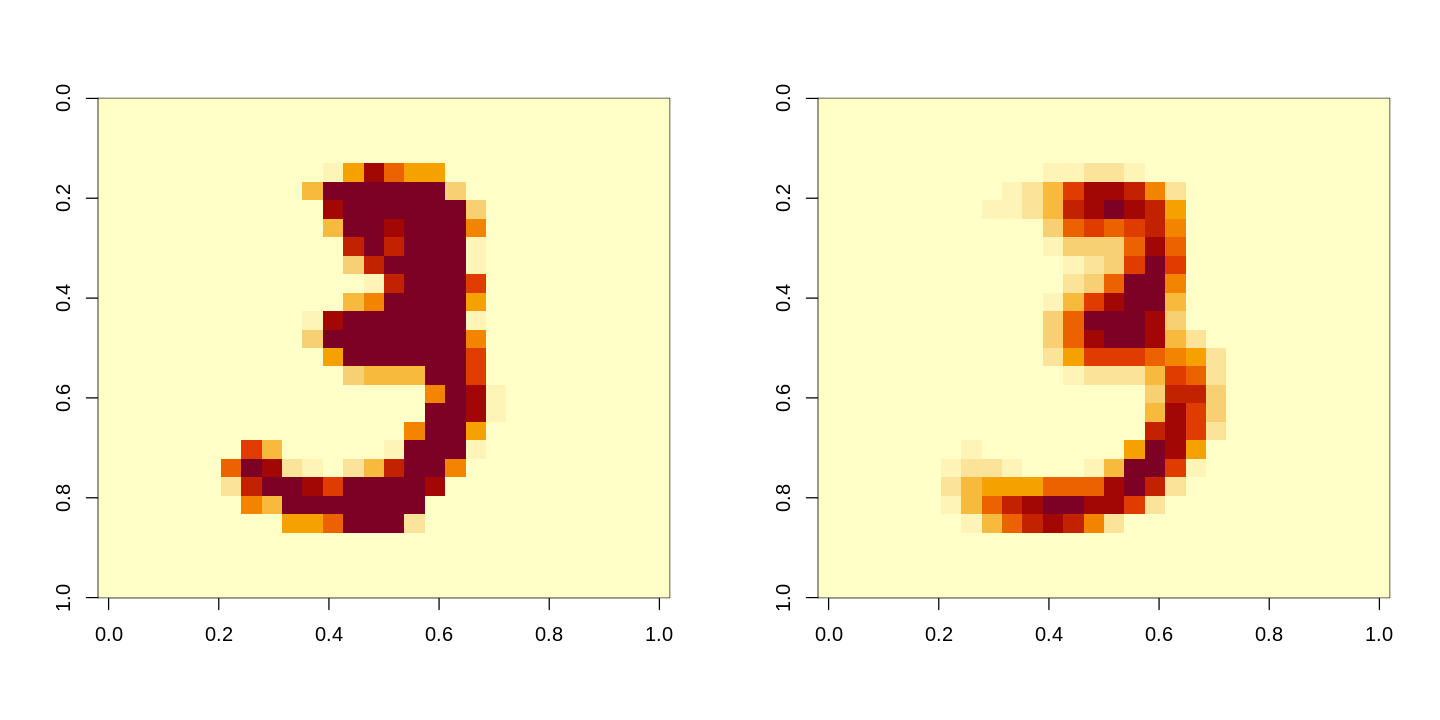

[1] "Epoch 60"
[1] "Training accuracy: 0.8999"
[1] "Validation accuracy: 0.892989298929893"


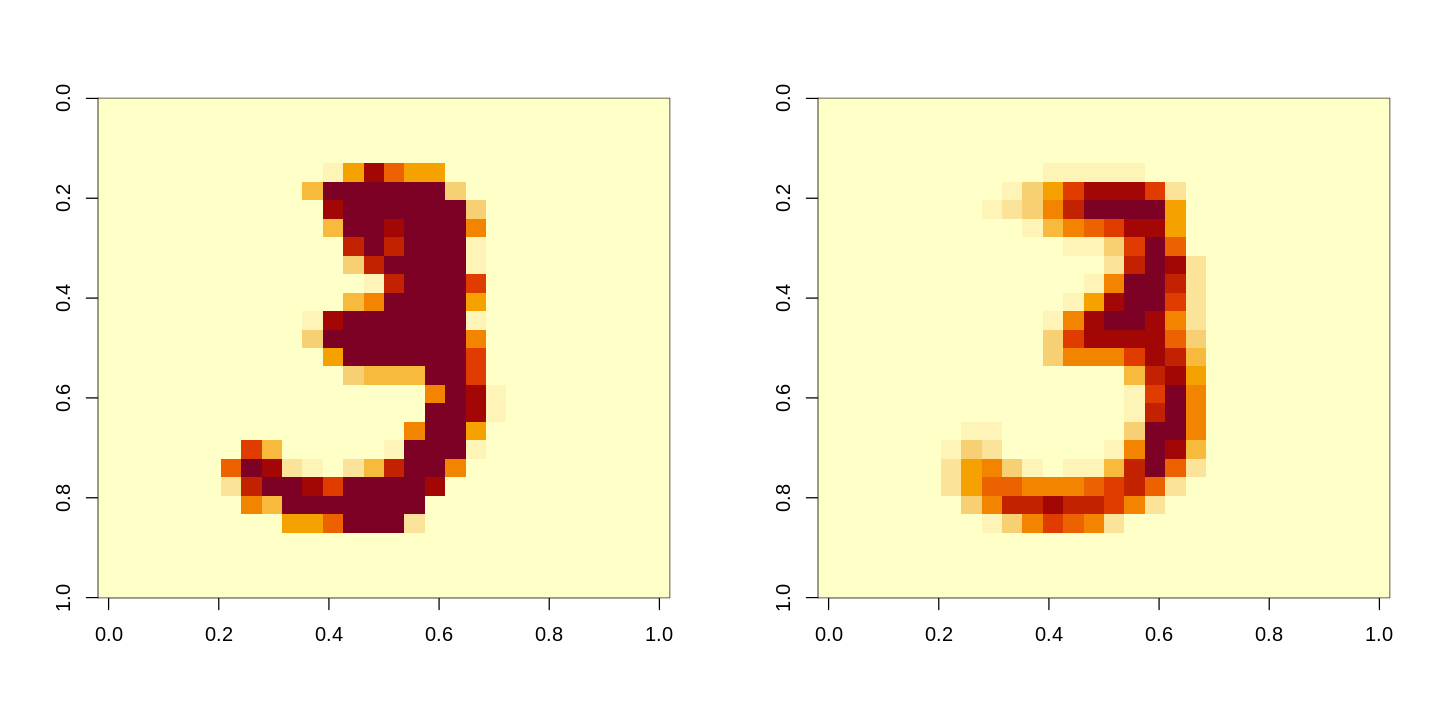

[1] "Epoch 61"
[1] "Training accuracy: 0.9021"
[1] "Validation accuracy: 0.892989298929893"


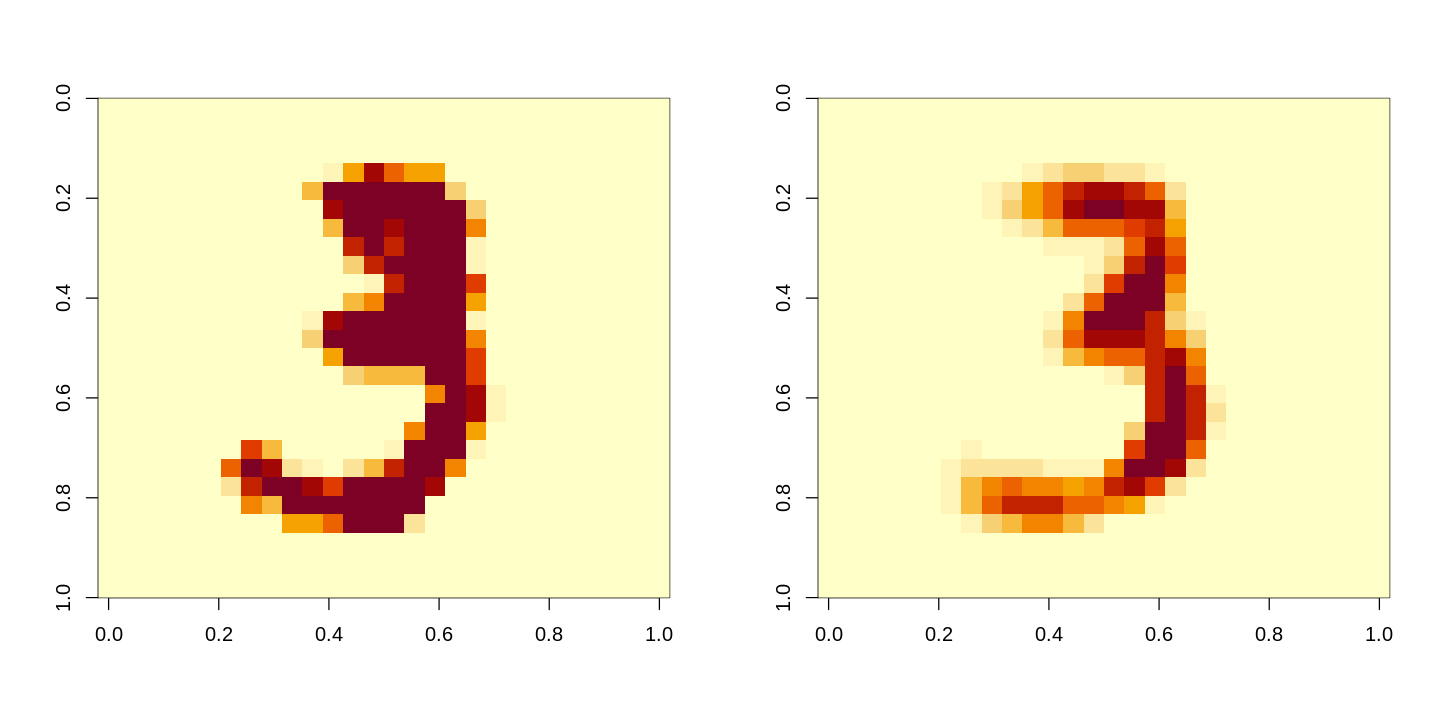

[1] "Epoch 62"
[1] "Training accuracy: 0.9006"
[1] "Validation accuracy: 0.892689268926893"


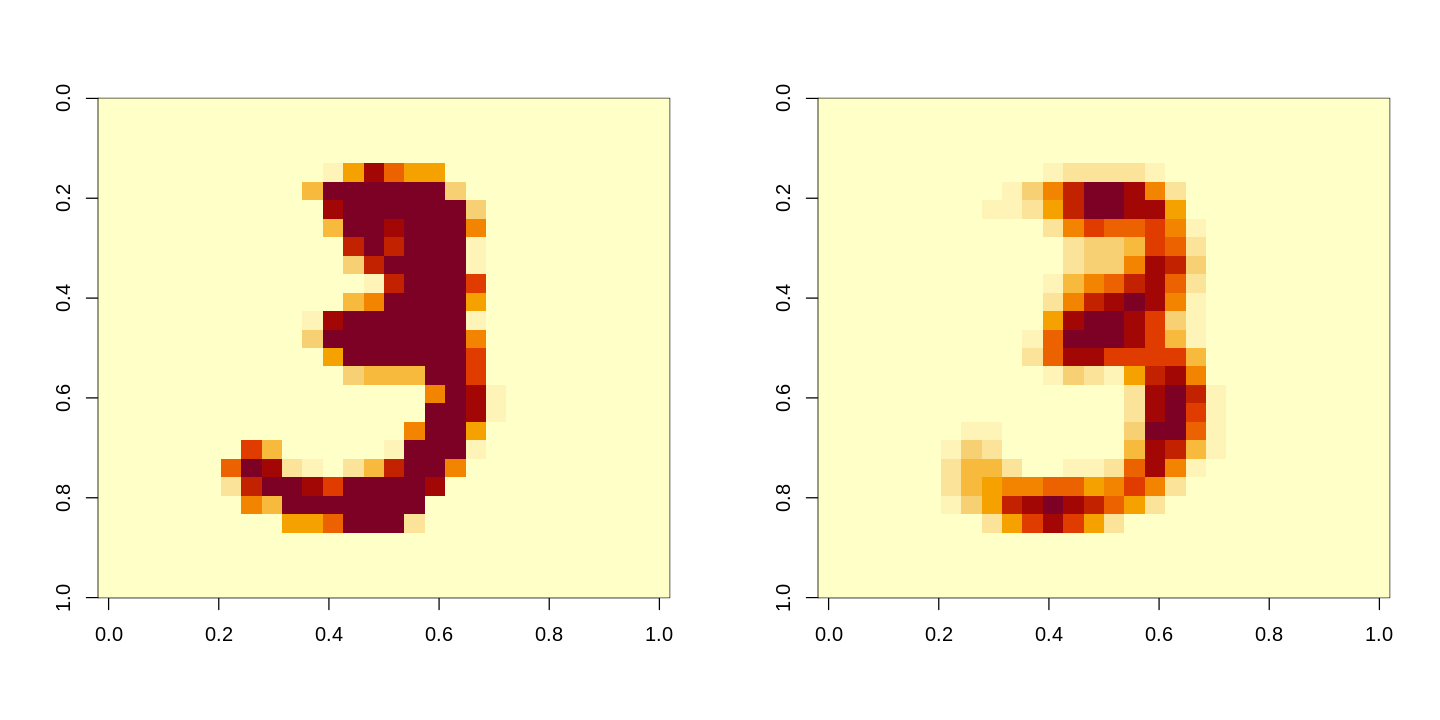

[1] "Epoch 63"
[1] "Training accuracy: 0.9"
[1] "Validation accuracy: 0.892489248924892"


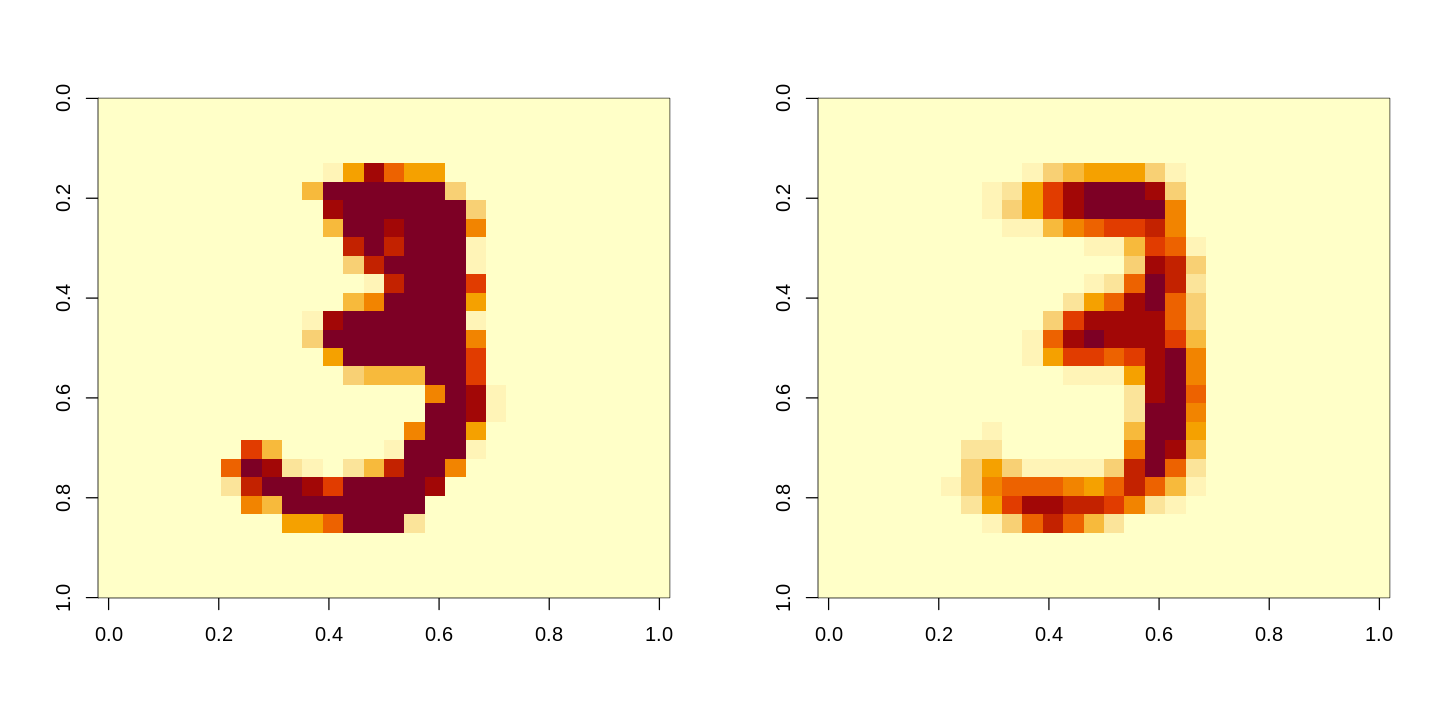

[1] "Epoch 64"
[1] "Training accuracy: 0.9014"
[1] "Validation accuracy: 0.893489348934894"


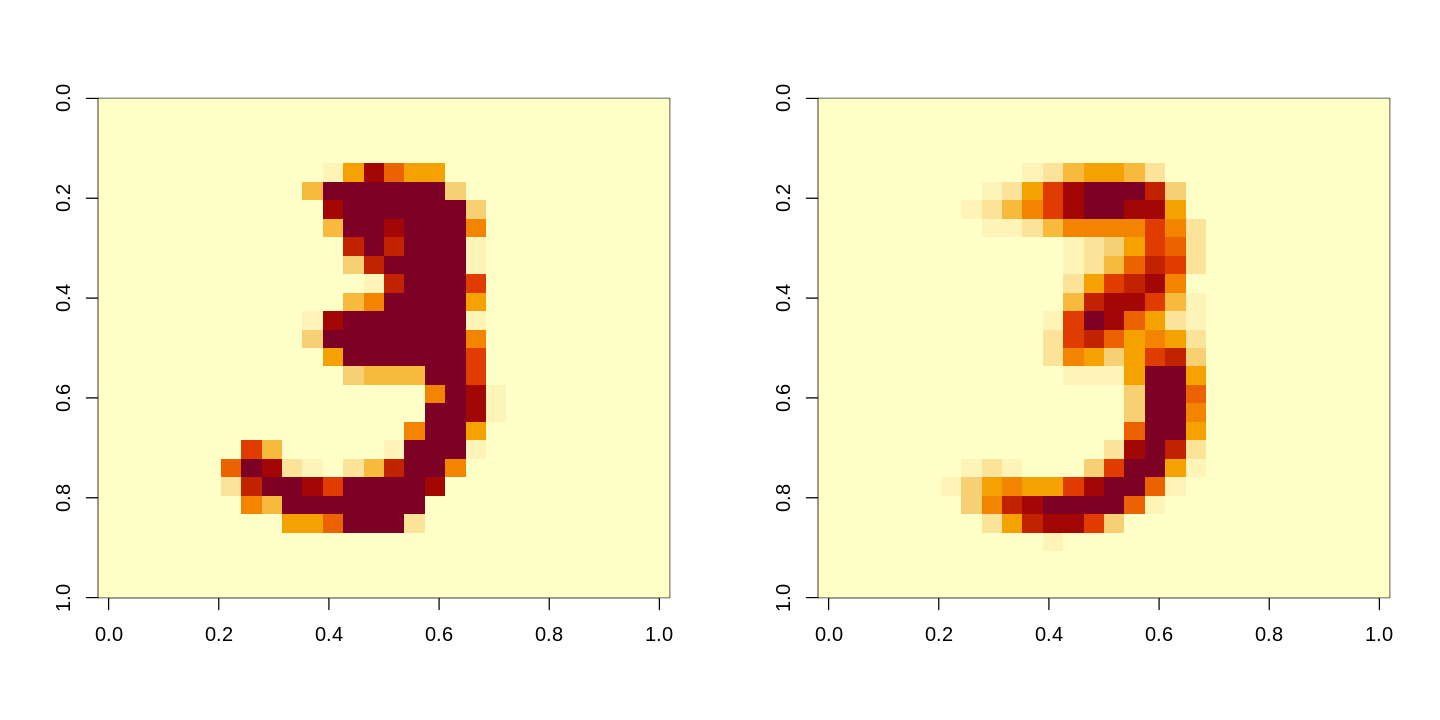

[1] "Epoch 65"
[1] "Training accuracy: 0.9007"
[1] "Validation accuracy: 0.893189318931893"


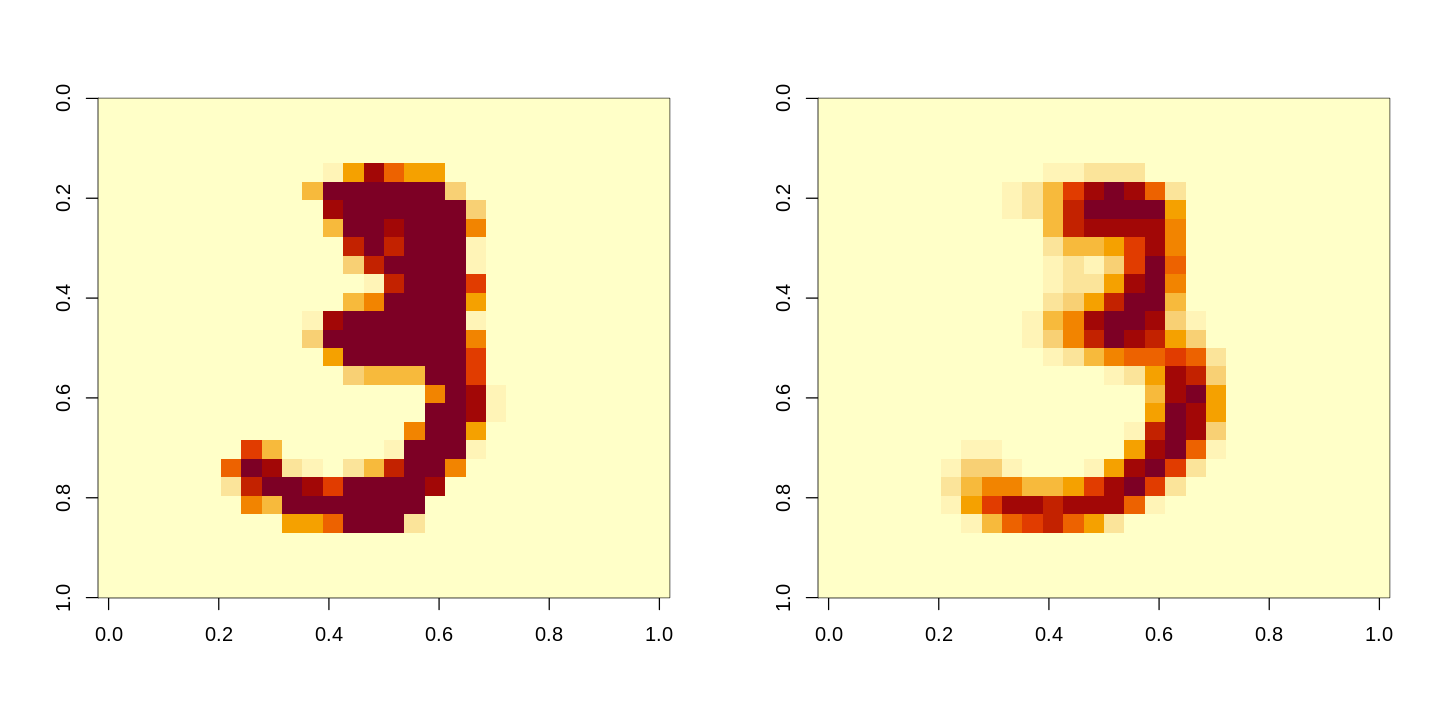

[1] "Epoch 66"
[1] "Training accuracy: 0.9004"
[1] "Validation accuracy: 0.893089308930893"


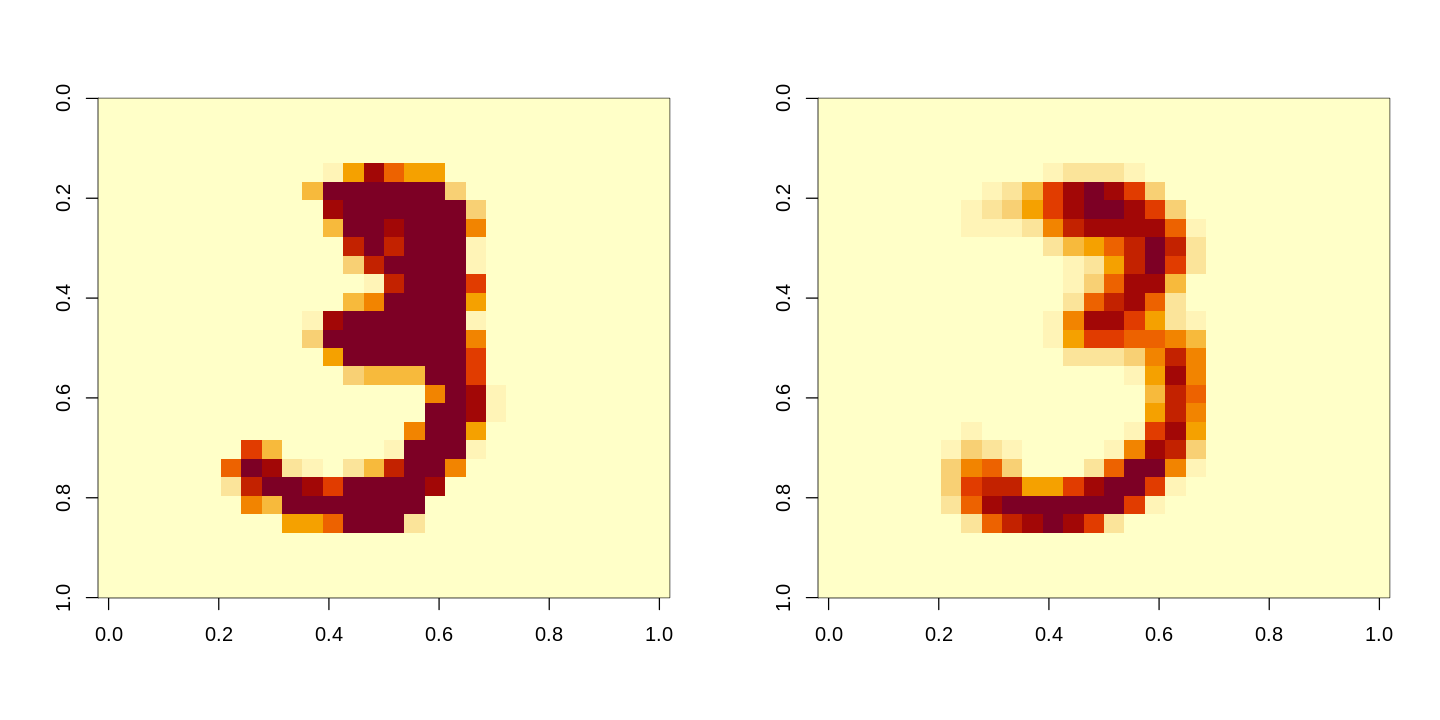

[1] "Epoch 67"
[1] "Training accuracy: 0.9022"
[1] "Validation accuracy: 0.894289428942894"


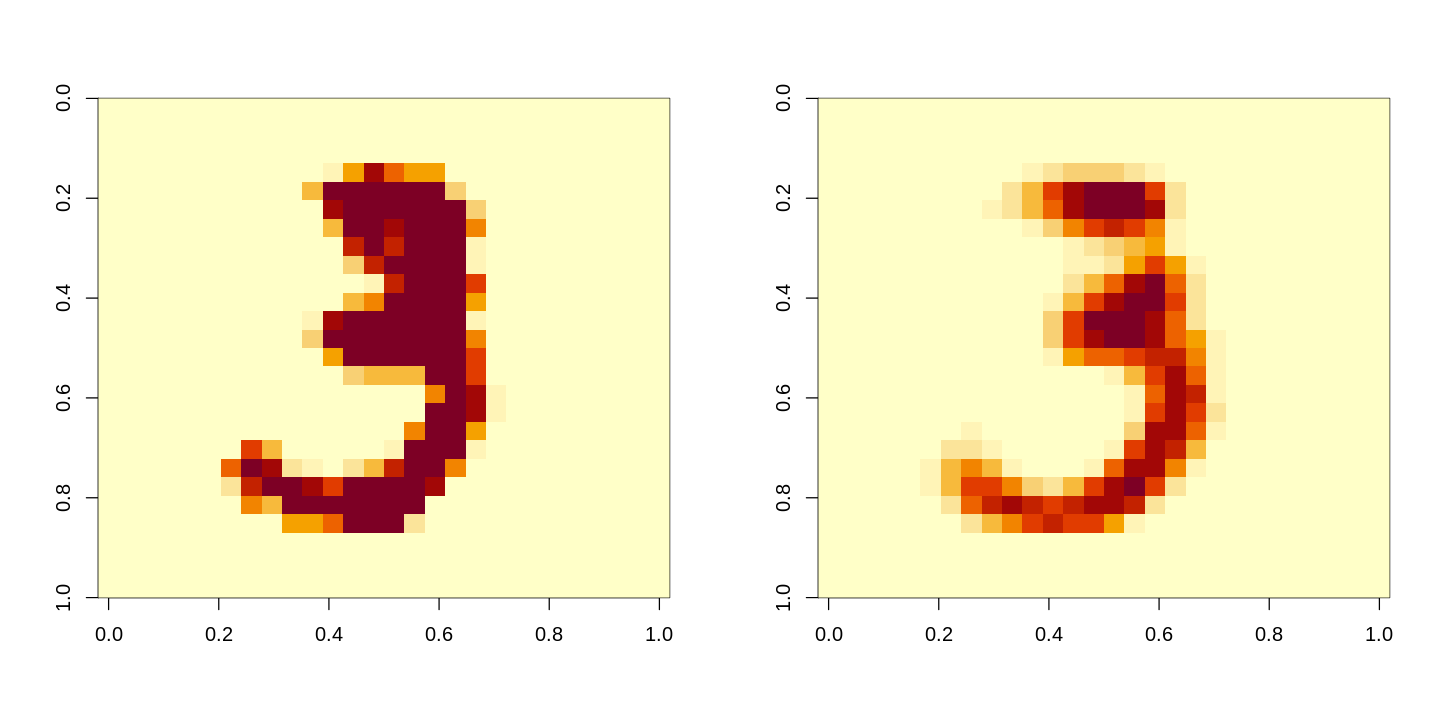

[1] "Epoch 68"
[1] "Training accuracy: 0.9018"
[1] "Validation accuracy: 0.894889488948895"


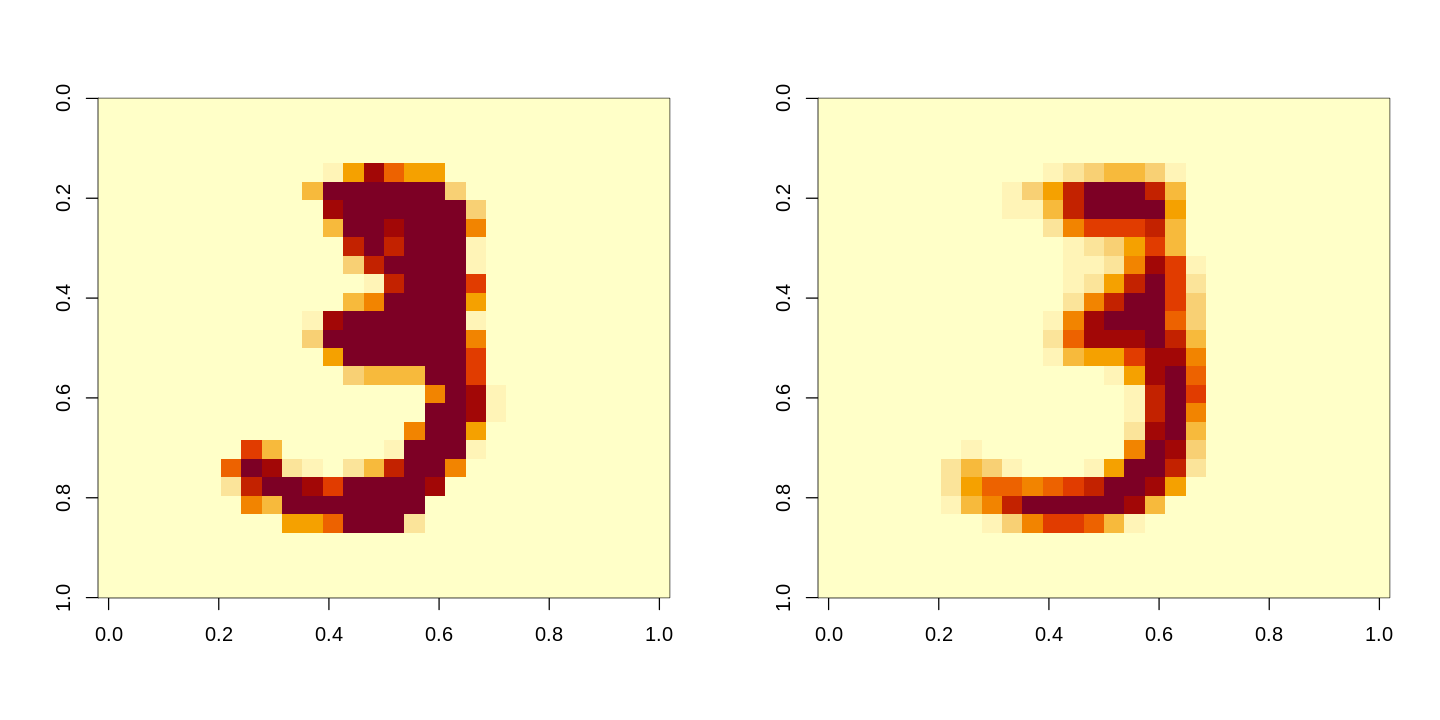

[1] "Epoch 69"
[1] "Training accuracy: 0.9019"
[1] "Validation accuracy: 0.894689468946895"


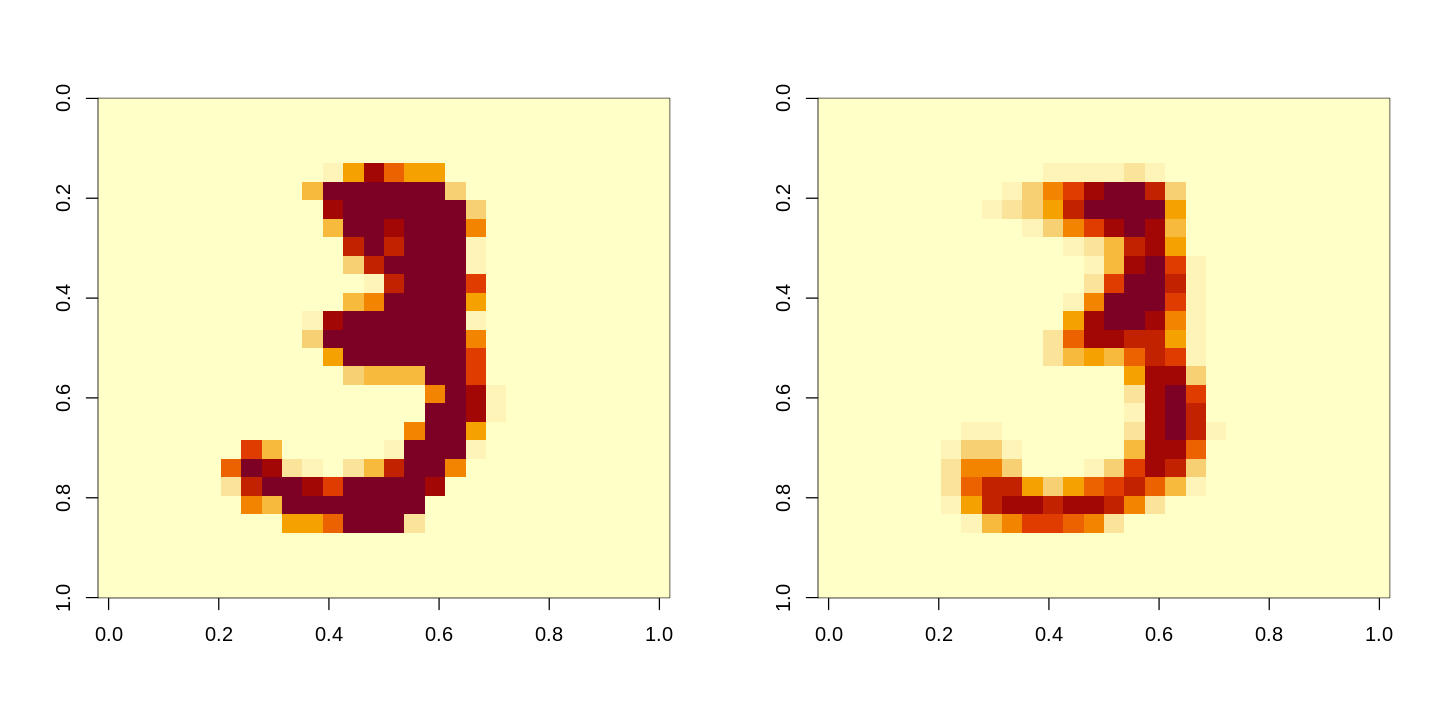

[1] "Epoch 70"
[1] "Training accuracy: 0.8998"
[1] "Validation accuracy: 0.894989498949895"


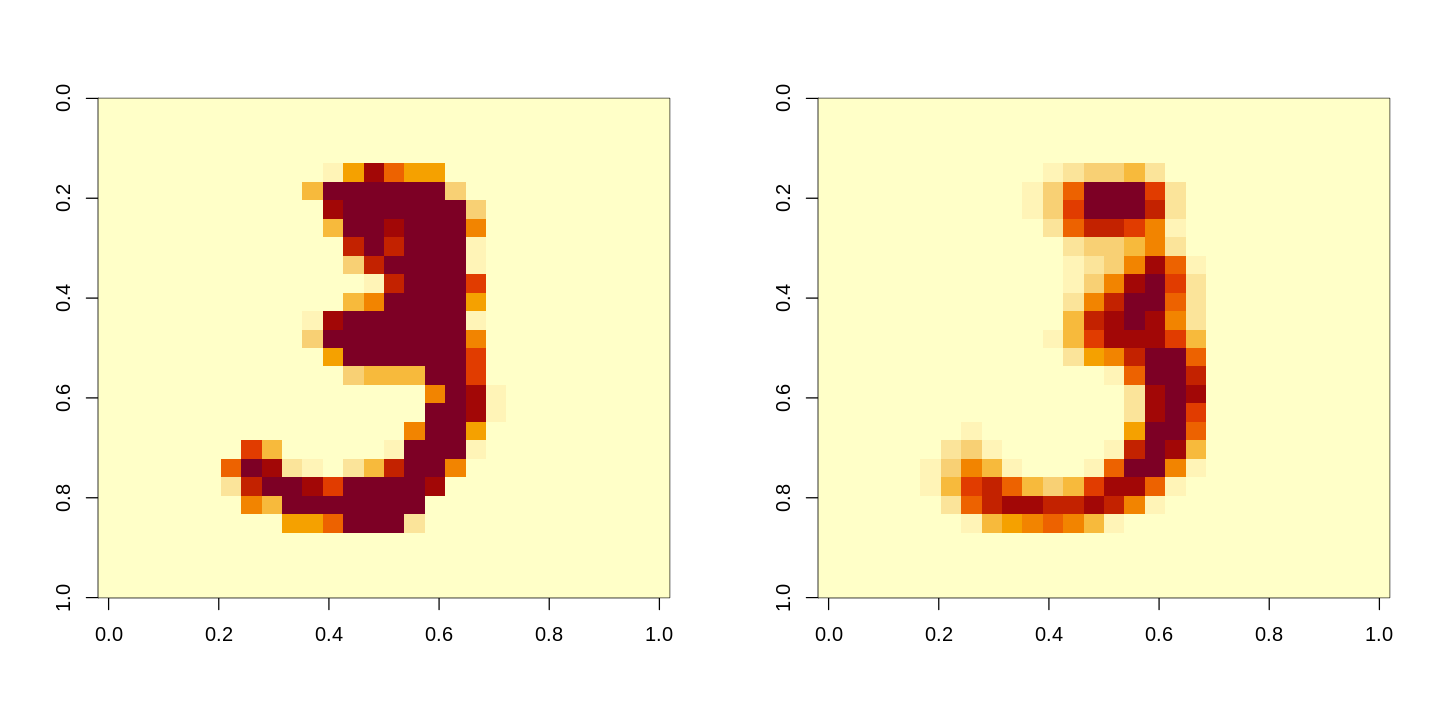

[1] "Epoch 71"
[1] "Training accuracy: 0.9028"
[1] "Validation accuracy: 0.894689468946895"


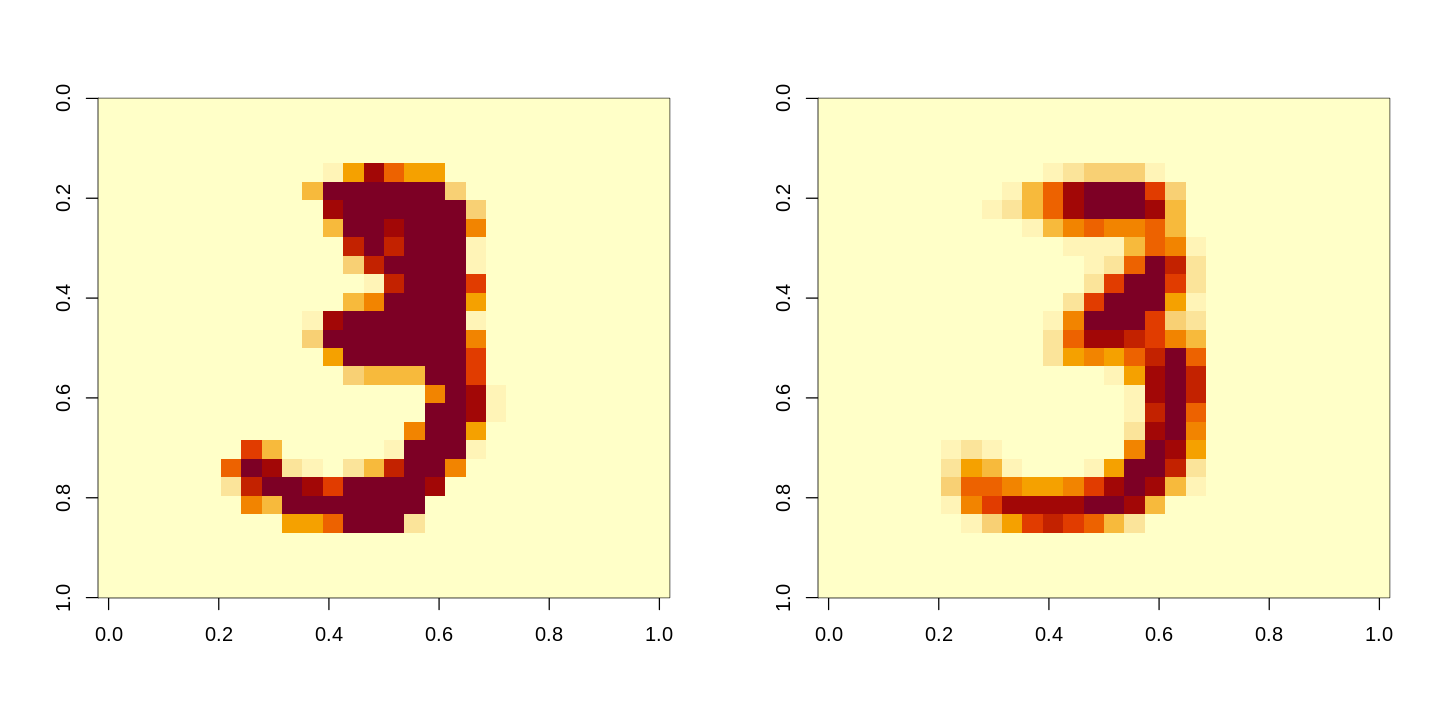

[1] "Epoch 72"
[1] "Training accuracy: 0.9022"
[1] "Validation accuracy: 0.895489548954896"


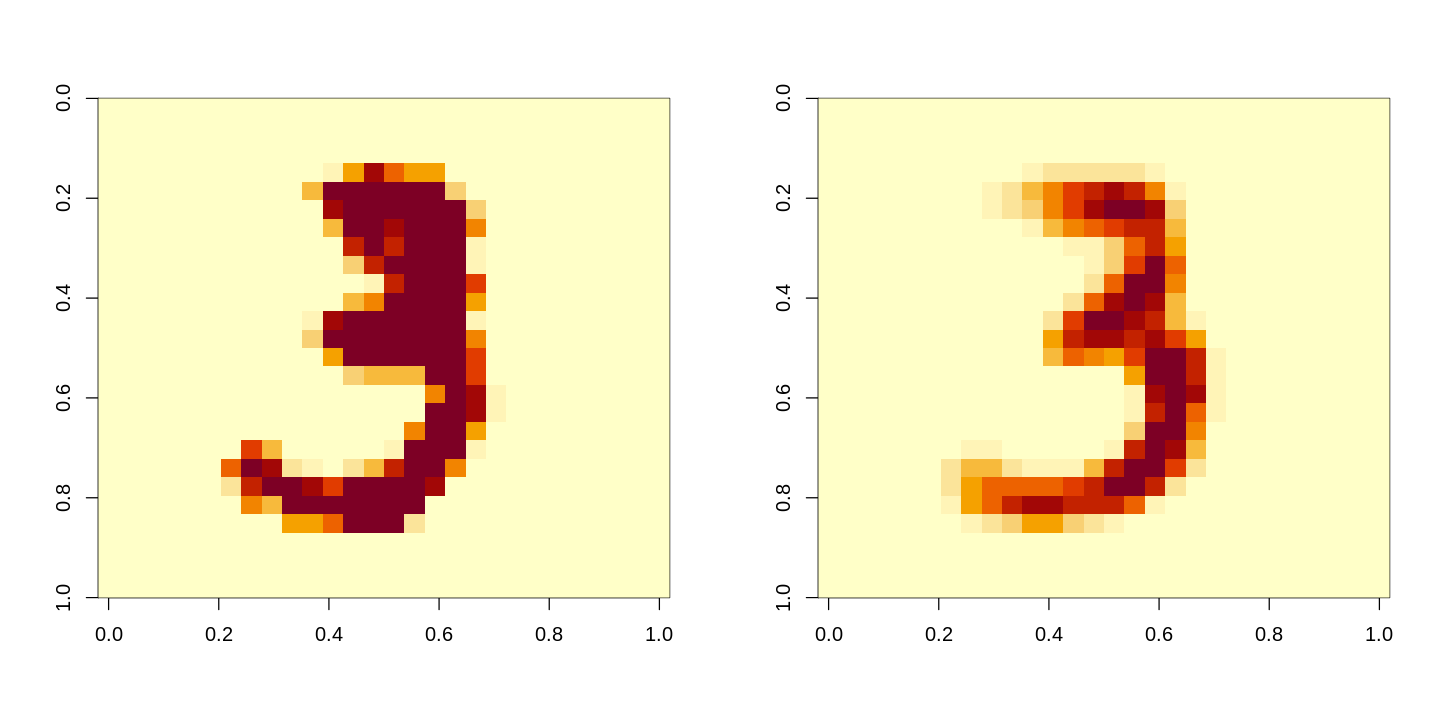

[1] "Epoch 73"
[1] "Training accuracy: 0.9023"
[1] "Validation accuracy: 0.894689468946895"


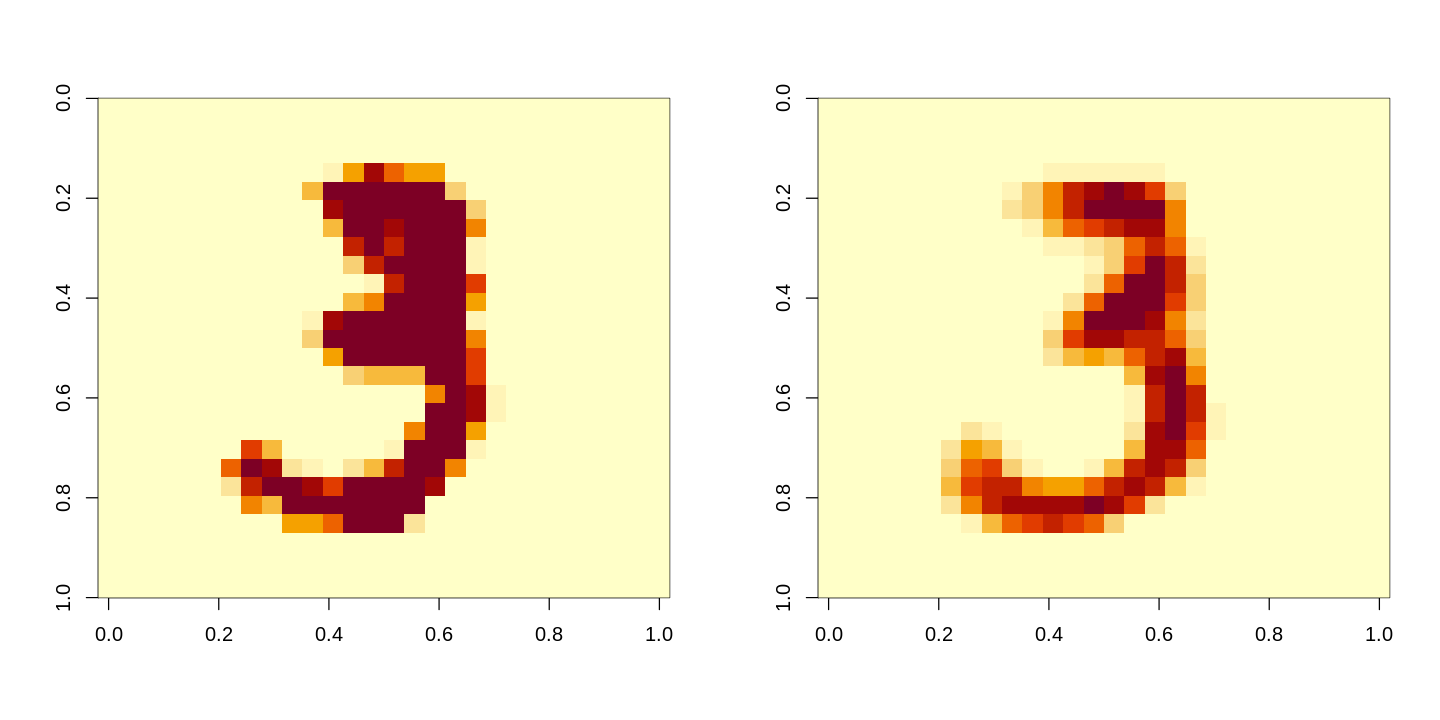

[1] "Epoch 74"
[1] "Training accuracy: 0.9021"
[1] "Validation accuracy: 0.894089408940894"


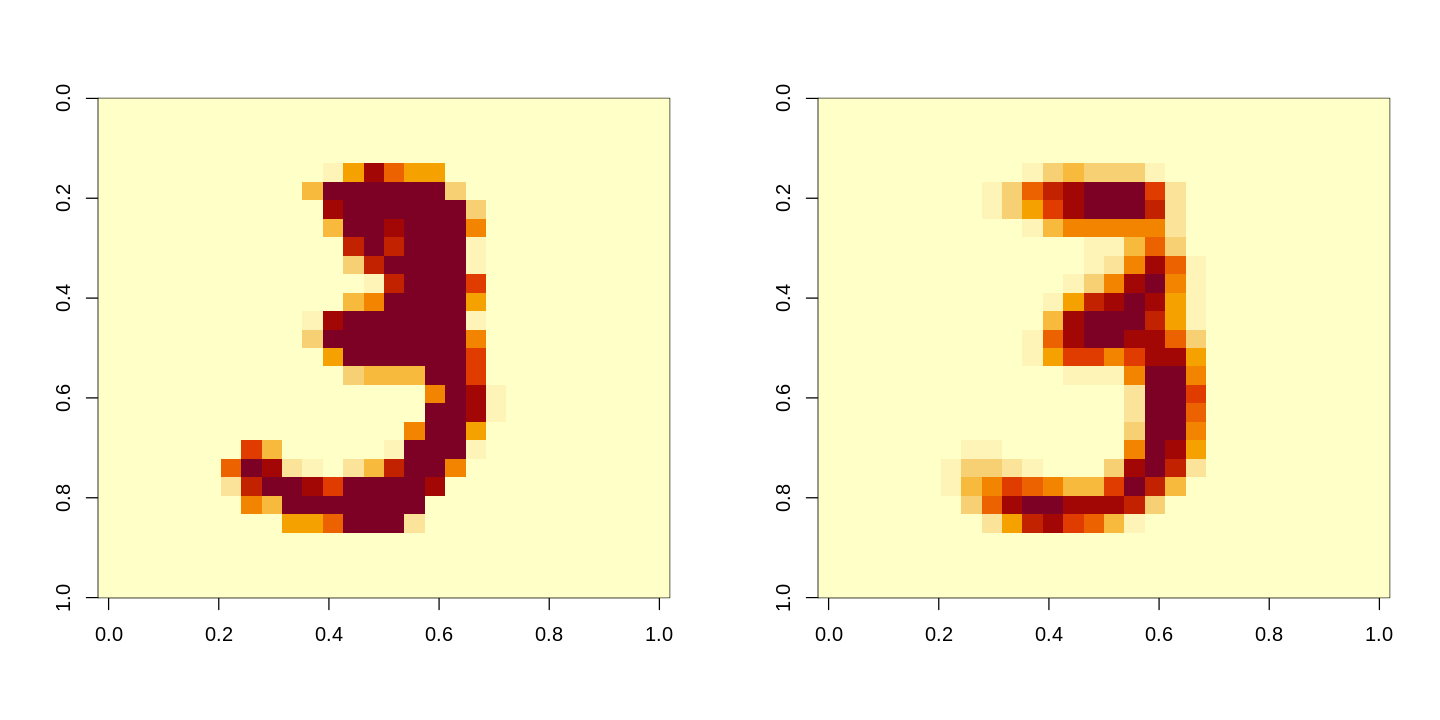

[1] "Epoch 75"
[1] "Training accuracy: 0.9024"
[1] "Validation accuracy: 0.894089408940894"


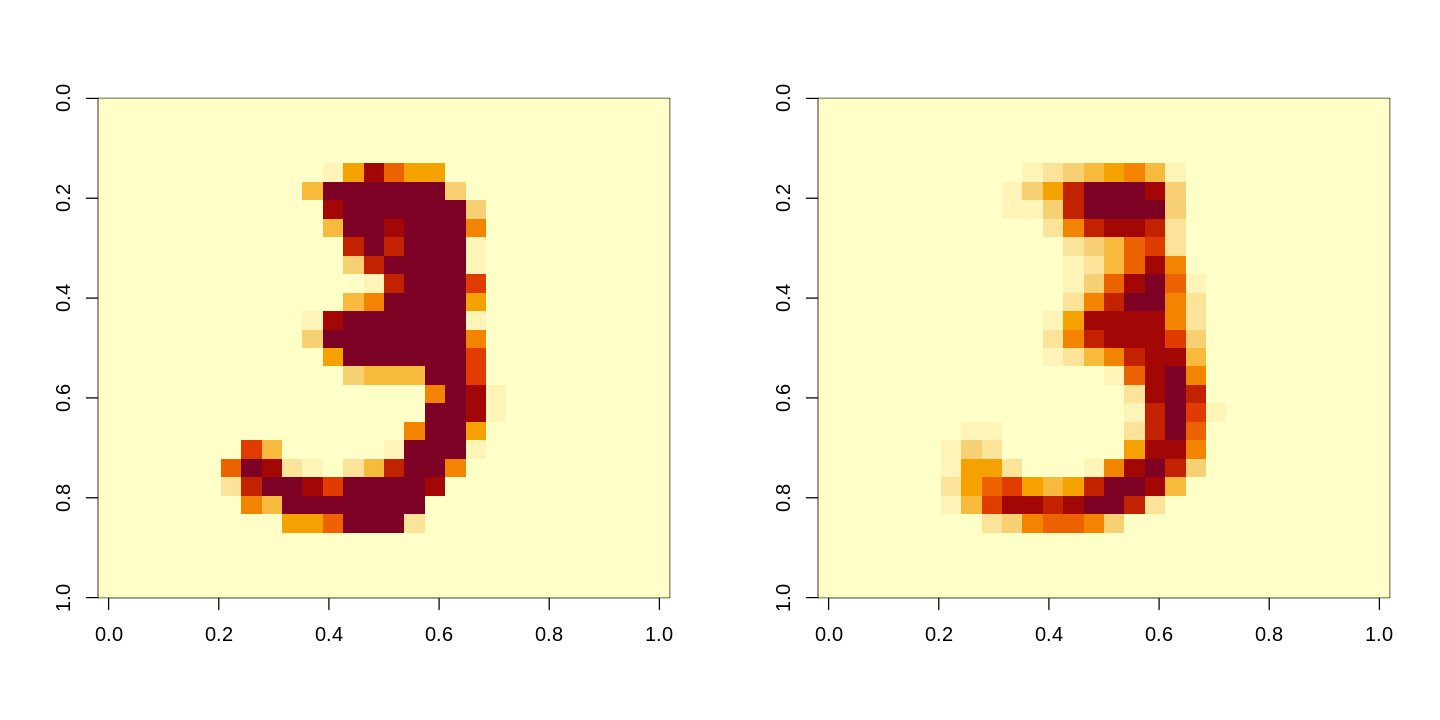

[1] "Epoch 76"
[1] "Training accuracy: 0.9036"
[1] "Validation accuracy: 0.895789578957896"


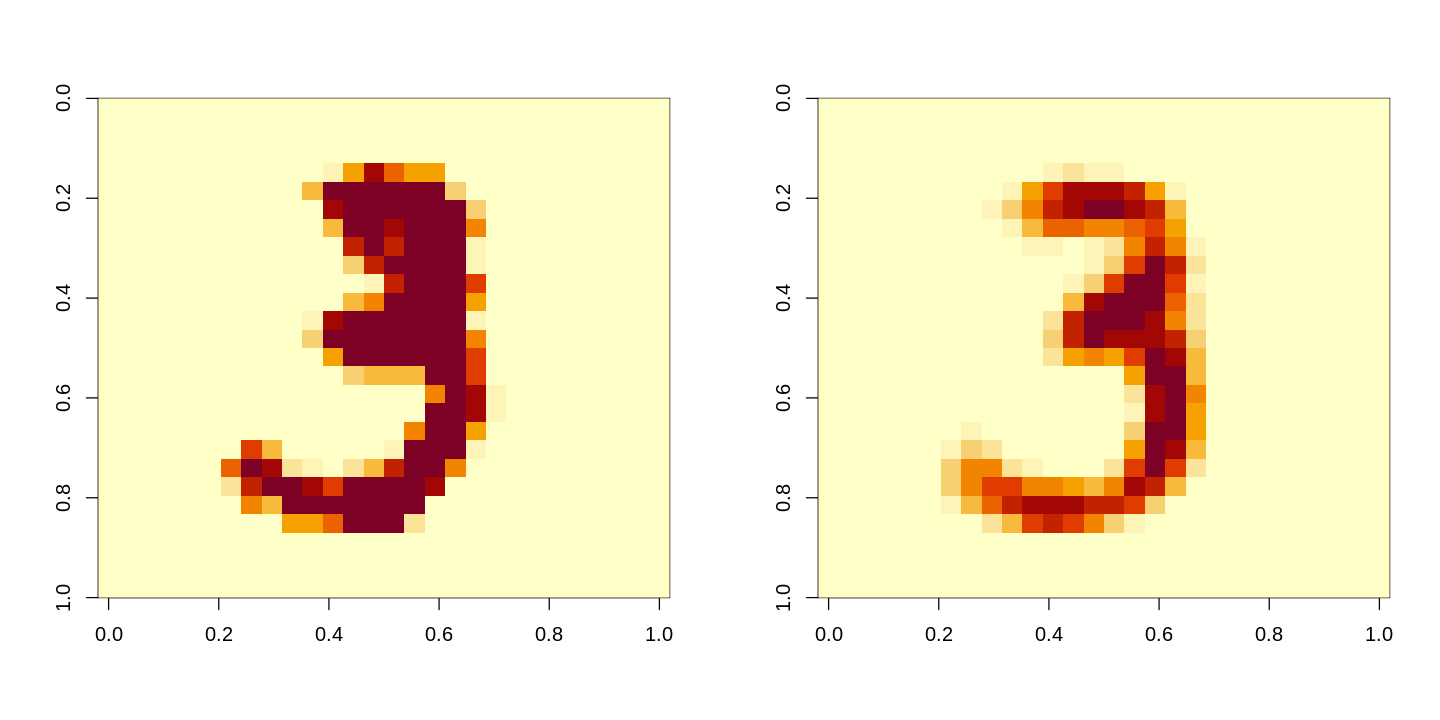

[1] "Epoch 77"
[1] "Training accuracy: 0.9025"
[1] "Validation accuracy: 0.895489548954896"


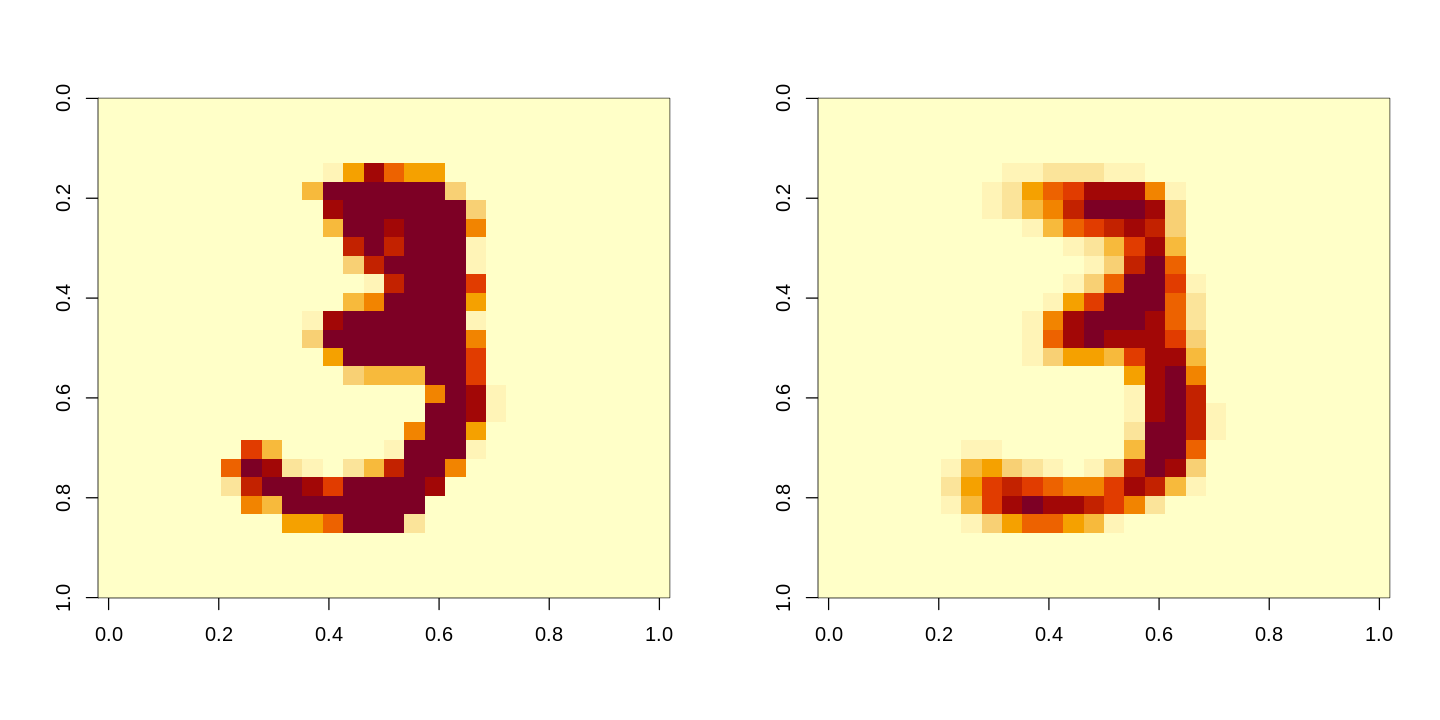

[1] "Epoch 78"
[1] "Training accuracy: 0.9019"
[1] "Validation accuracy: 0.895289528952895"


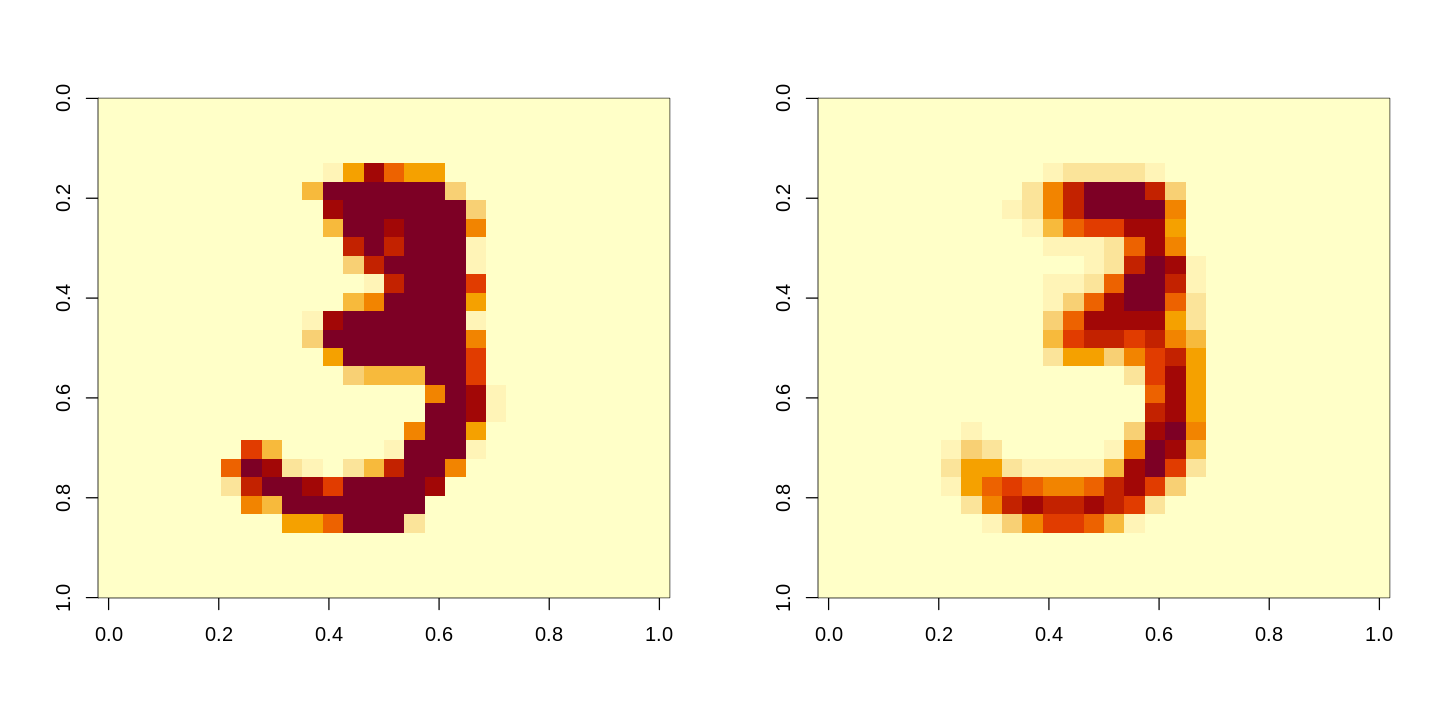

[1] "Epoch 79"
[1] "Training accuracy: 0.9029"
[1] "Validation accuracy: 0.896089608960896"


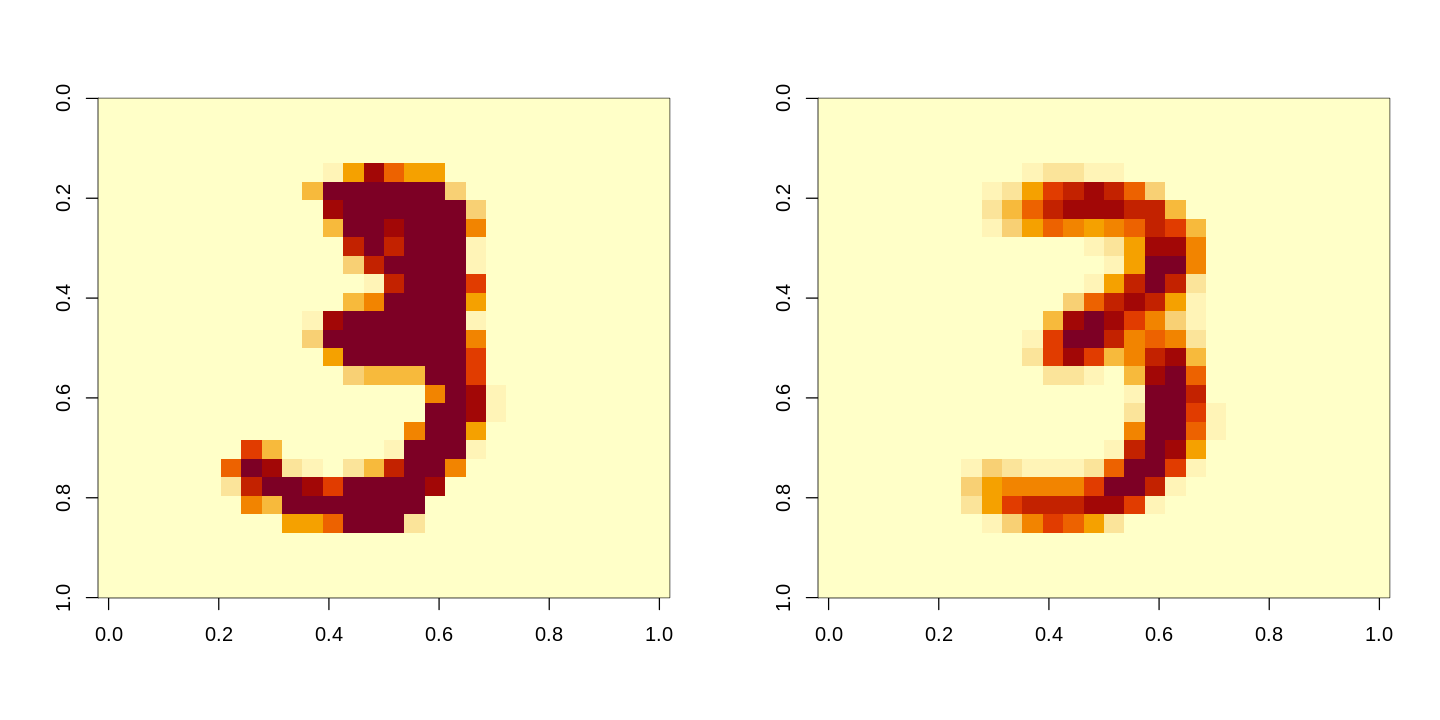

[1] "Epoch 80"
[1] "Training accuracy: 0.9042"
[1] "Validation accuracy: 0.896689668966897"


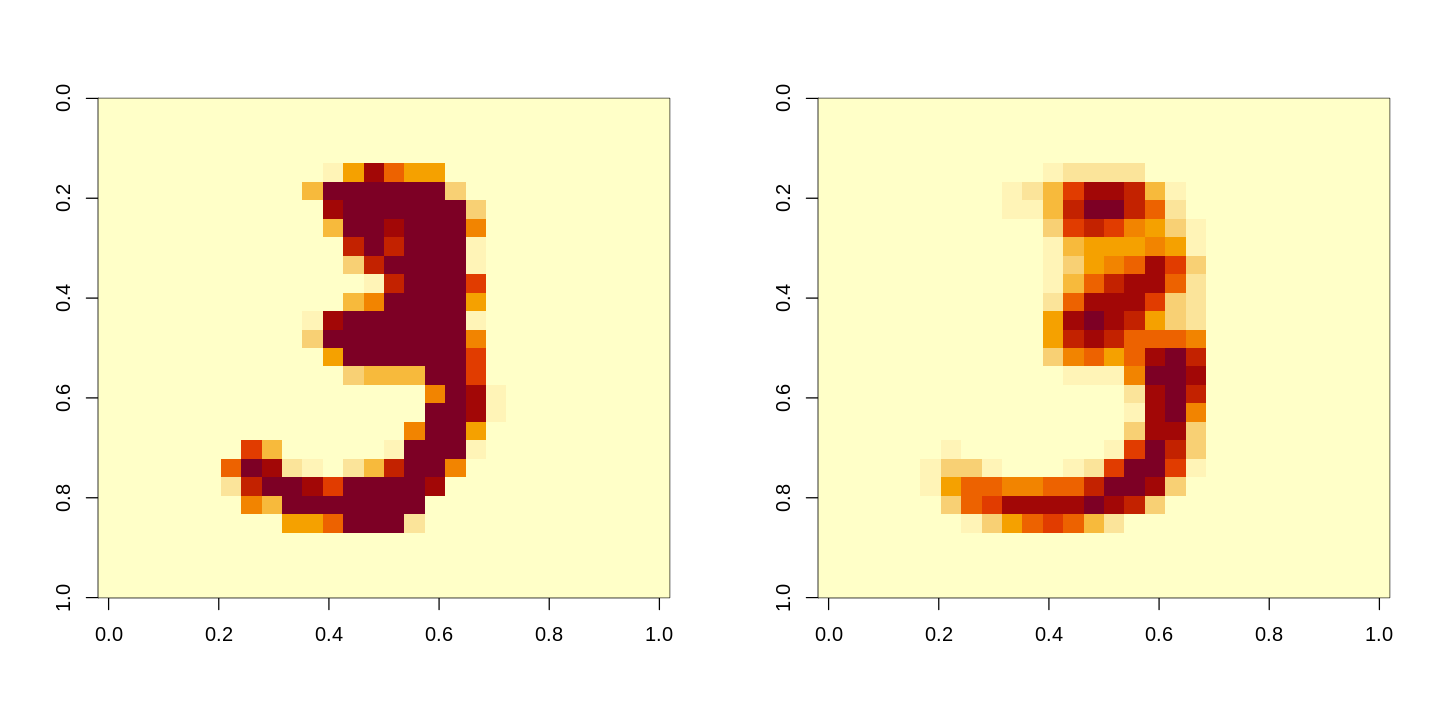

[1] "Epoch 81"
[1] "Training accuracy: 0.9027"
[1] "Validation accuracy: 0.895689568956896"


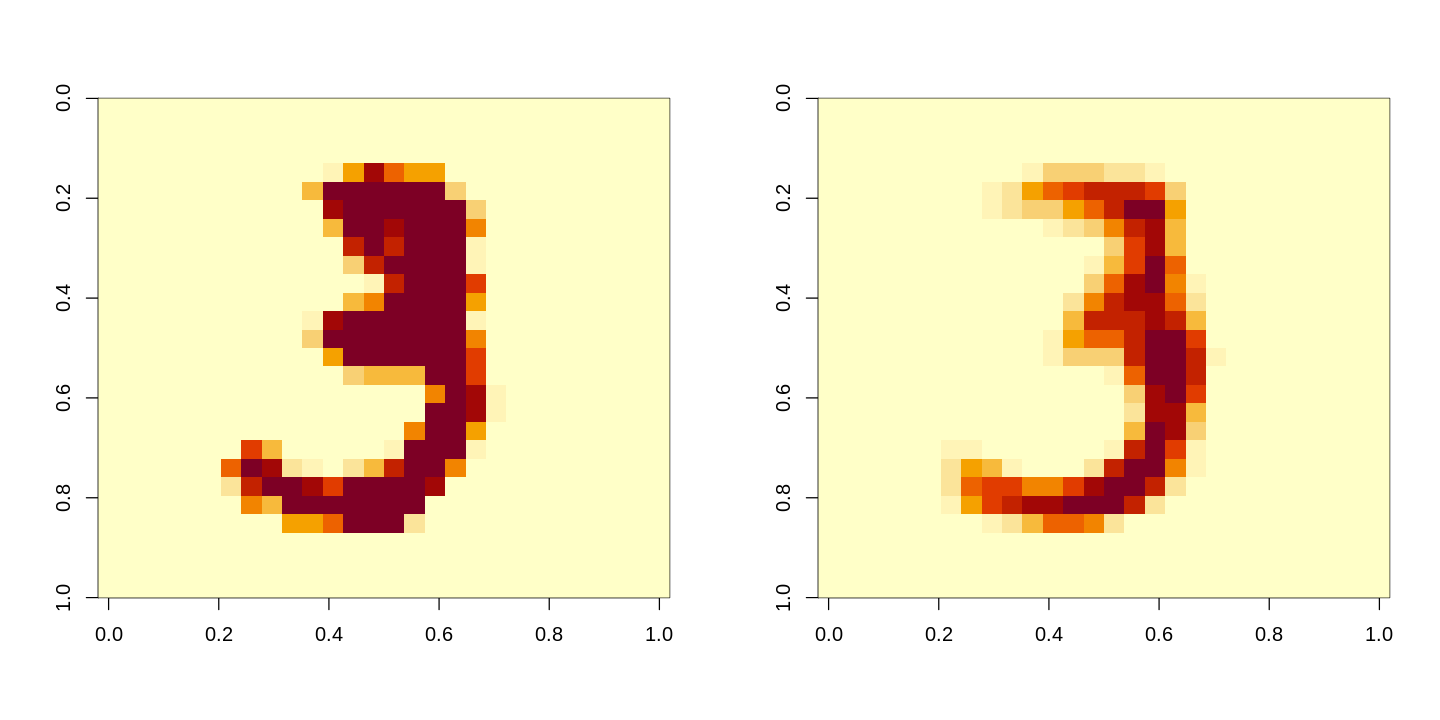

[1] "Epoch 82"
[1] "Training accuracy: 0.9033"
[1] "Validation accuracy: 0.896589658965897"


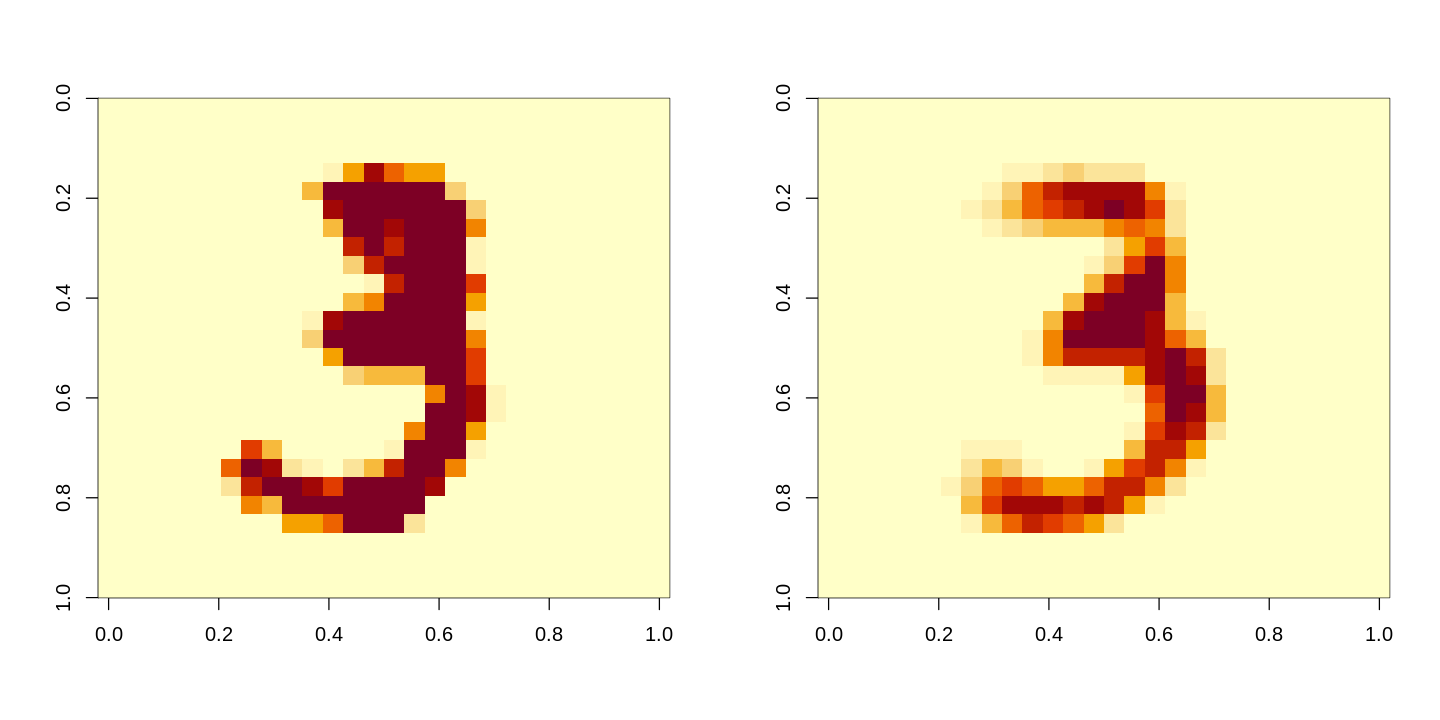

[1] "Epoch 83"
[1] "Training accuracy: 0.9036"
[1] "Validation accuracy: 0.896389638963896"


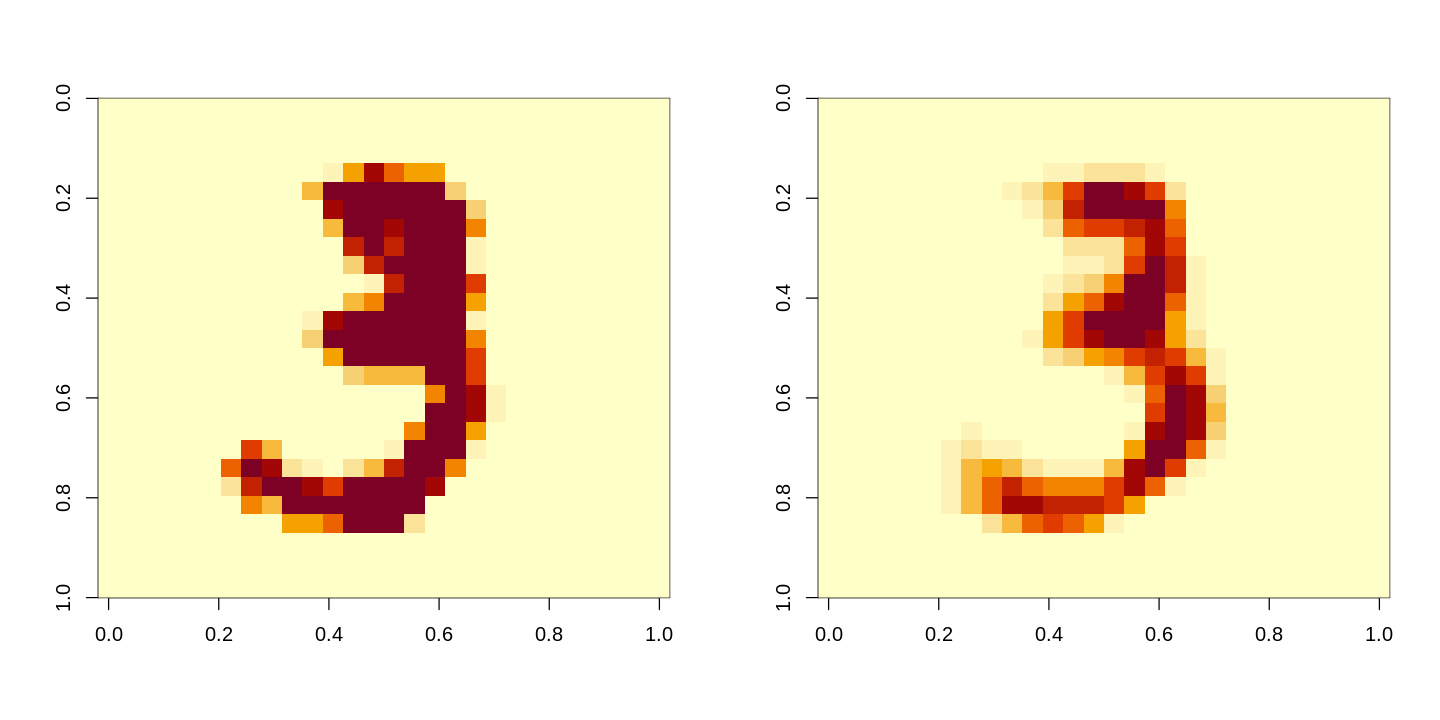

[1] "Epoch 84"
[1] "Training accuracy: 0.903"
[1] "Validation accuracy: 0.897289728972897"


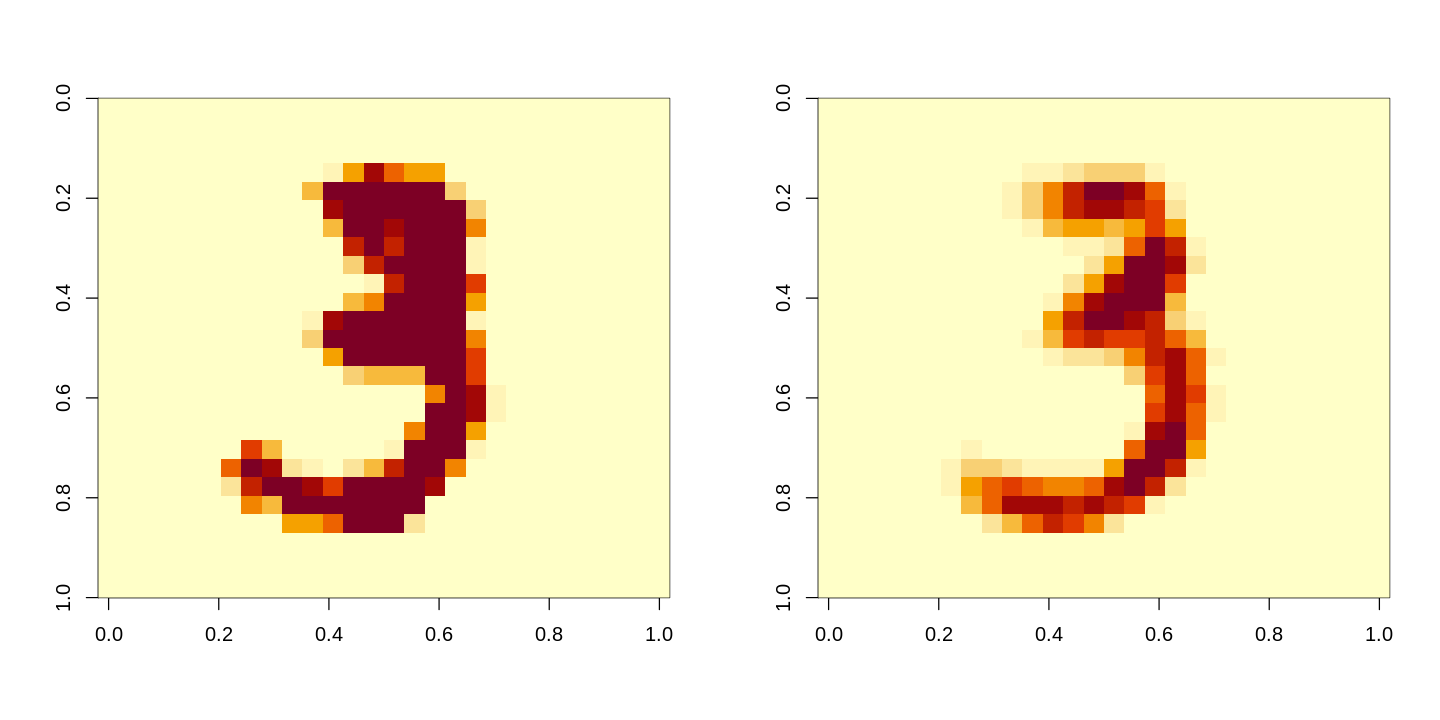

[1] "Epoch 85"
[1] "Training accuracy: 0.9048"
[1] "Validation accuracy: 0.898989898989899"


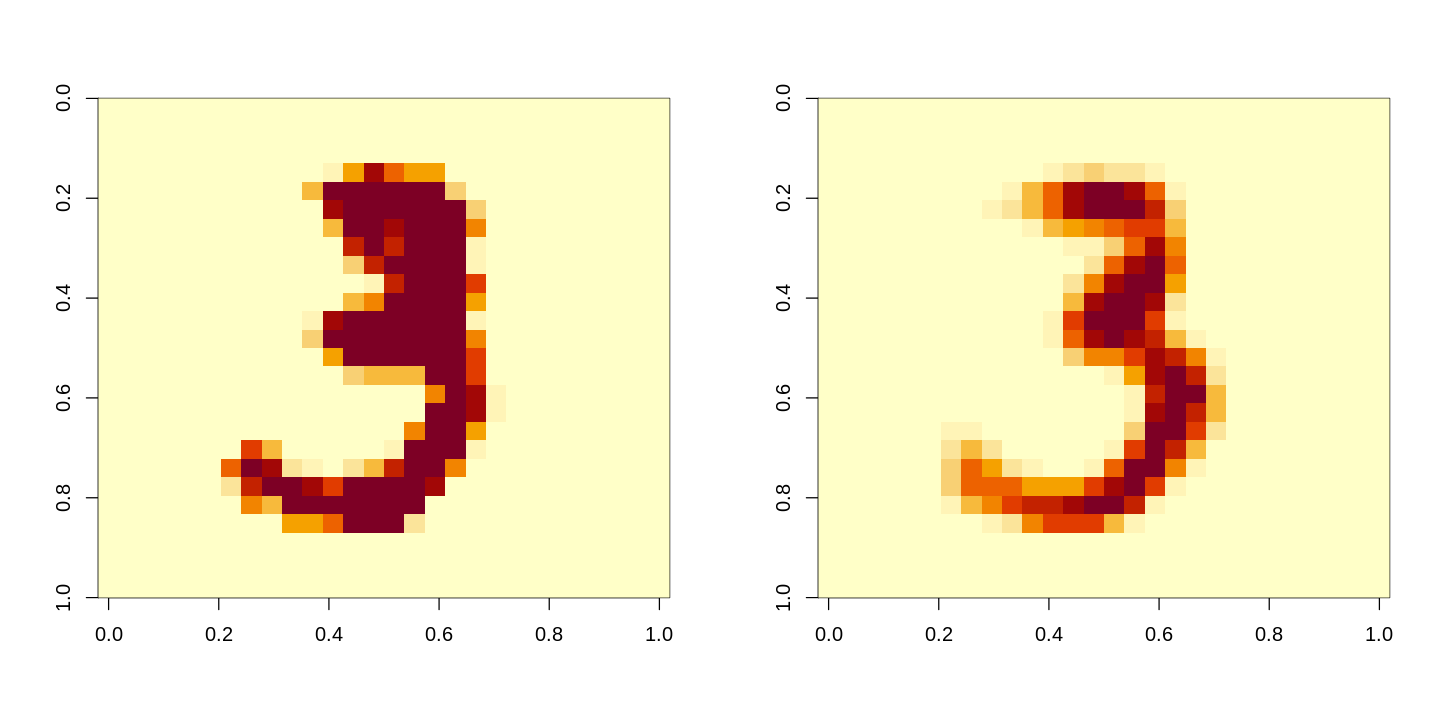

[1] "Epoch 86"
[1] "Training accuracy: 0.9045"
[1] "Validation accuracy: 0.8997899789979"


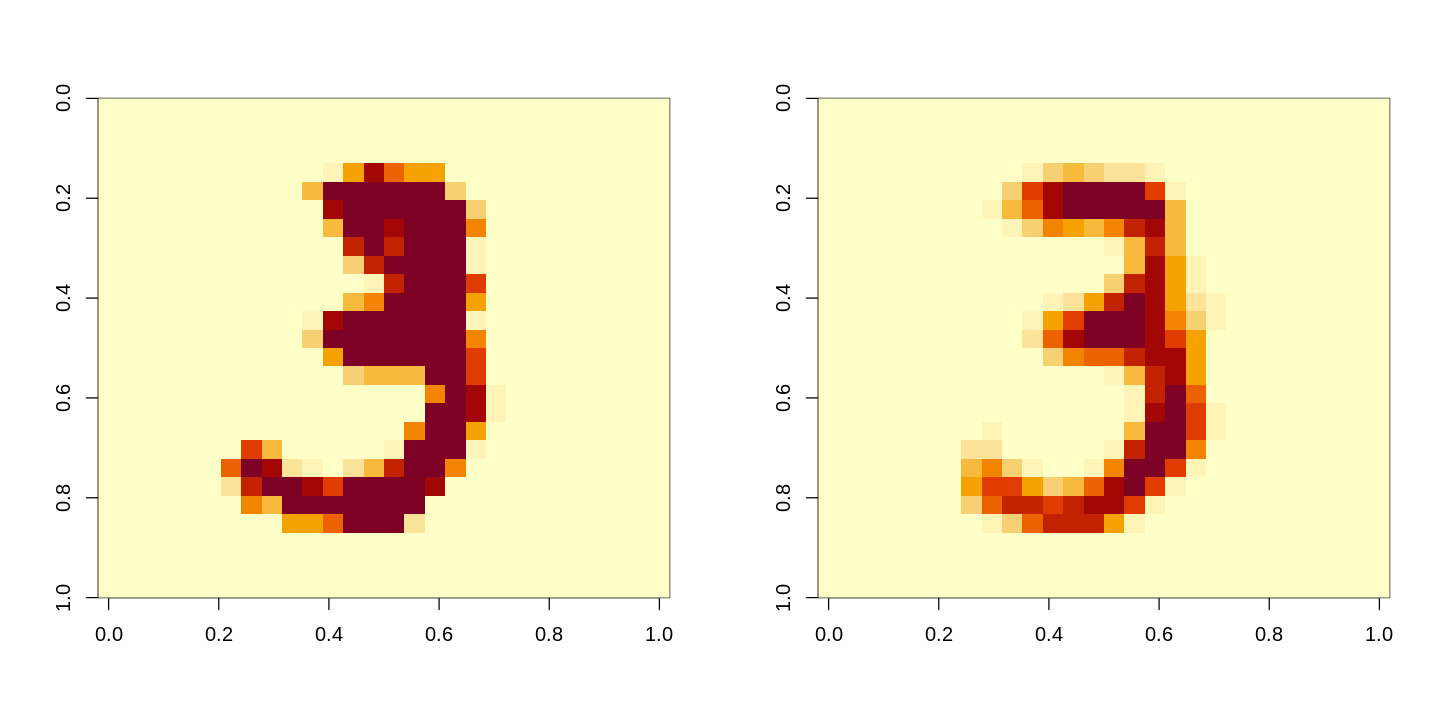

[1] "Epoch 87"
[1] "Training accuracy: 0.9038"
[1] "Validation accuracy: 0.8995899589959"


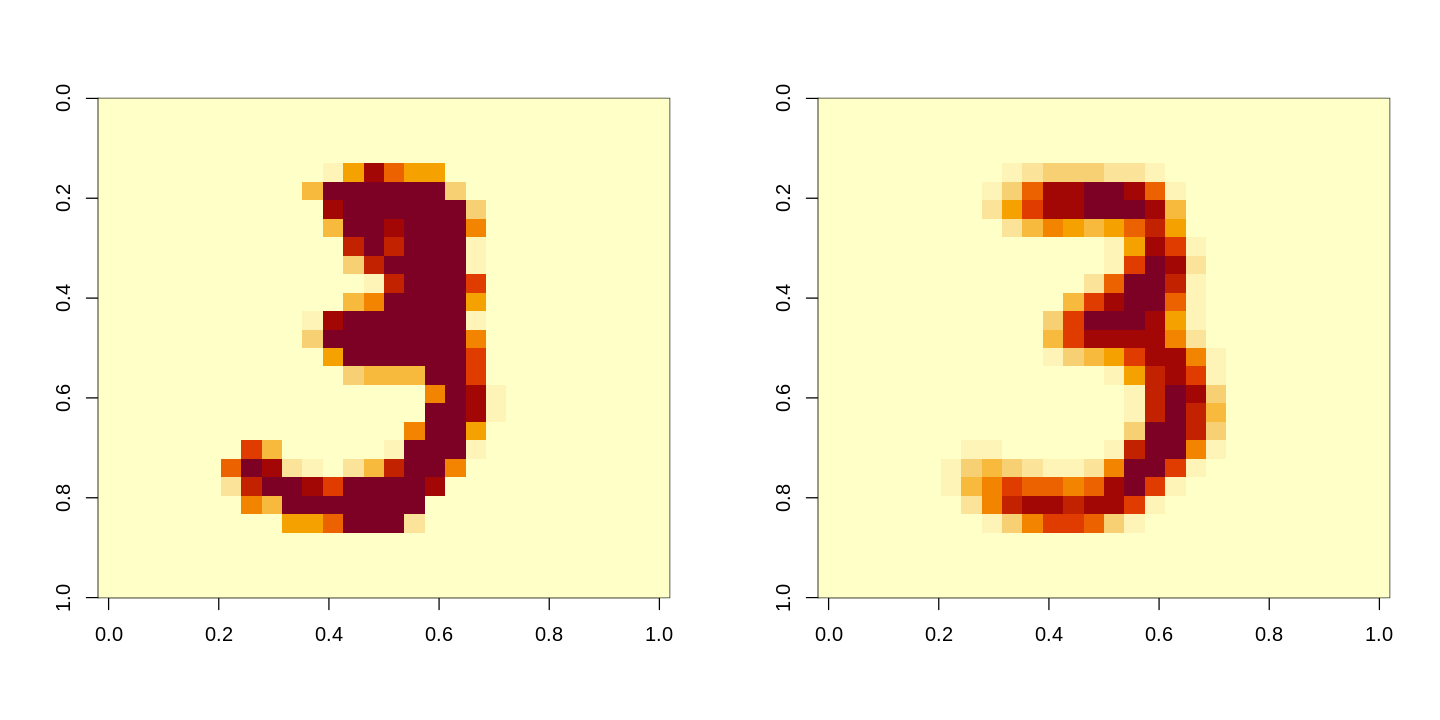

[1] "Epoch 88"
[1] "Training accuracy: 0.903"
[1] "Validation accuracy: 0.898189818981898"


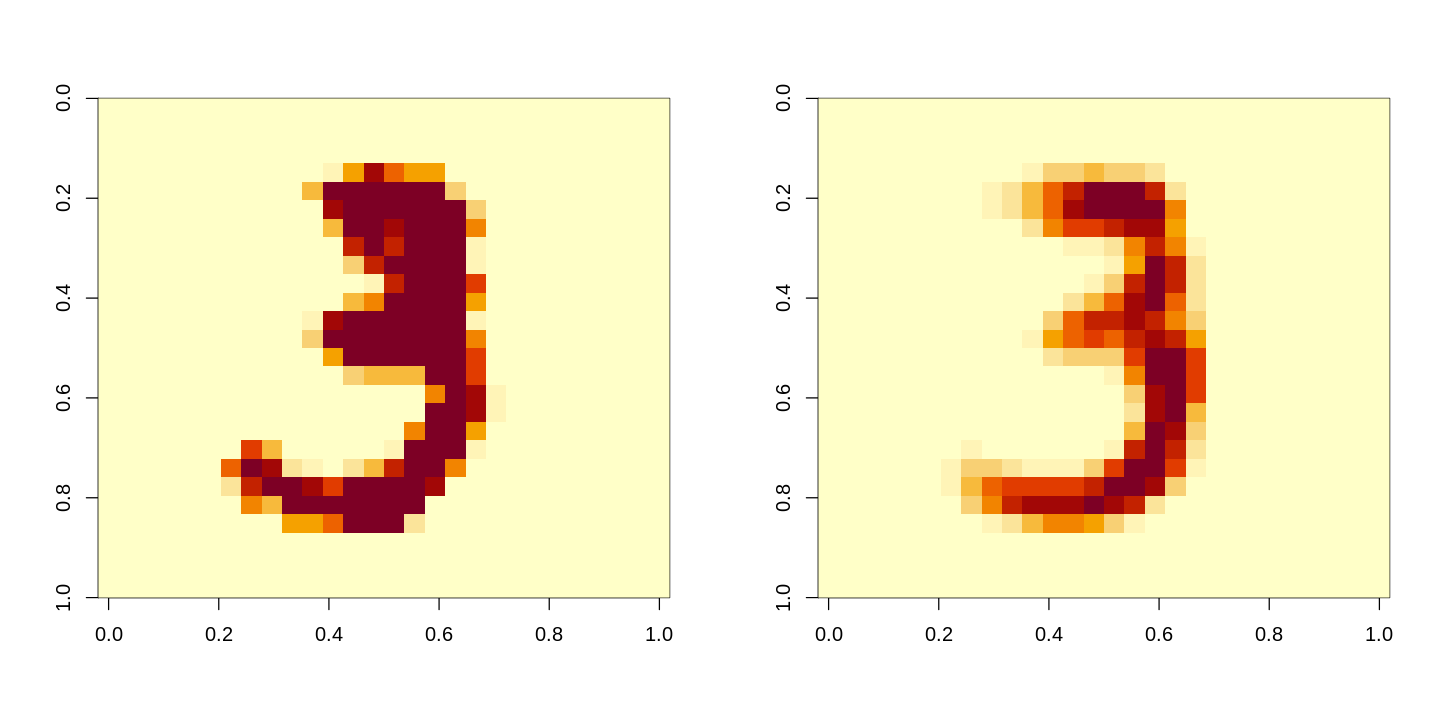

[1] "Epoch 89"
[1] "Training accuracy: 0.9046"
[1] "Validation accuracy: 0.897389738973897"


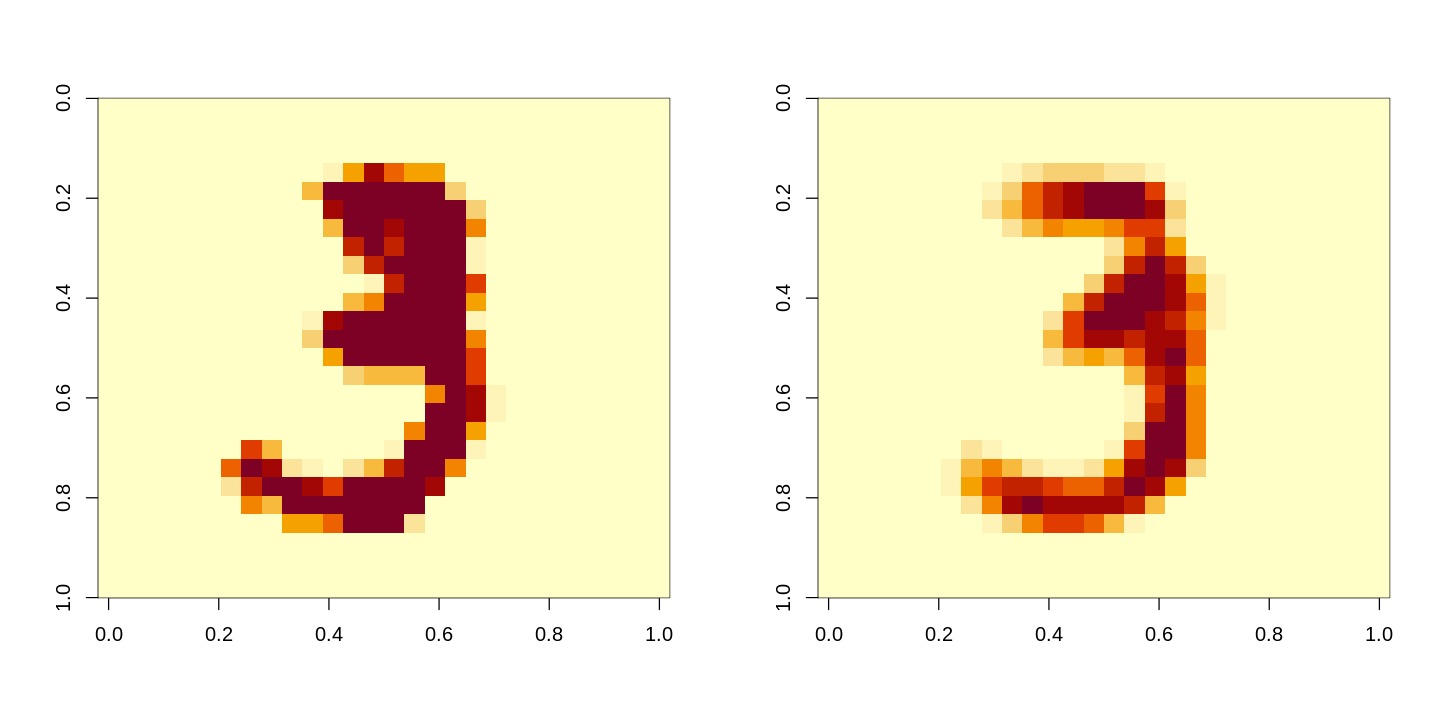

[1] "Epoch 90"
[1] "Training accuracy: 0.905"
[1] "Validation accuracy: 0.898089808980898"


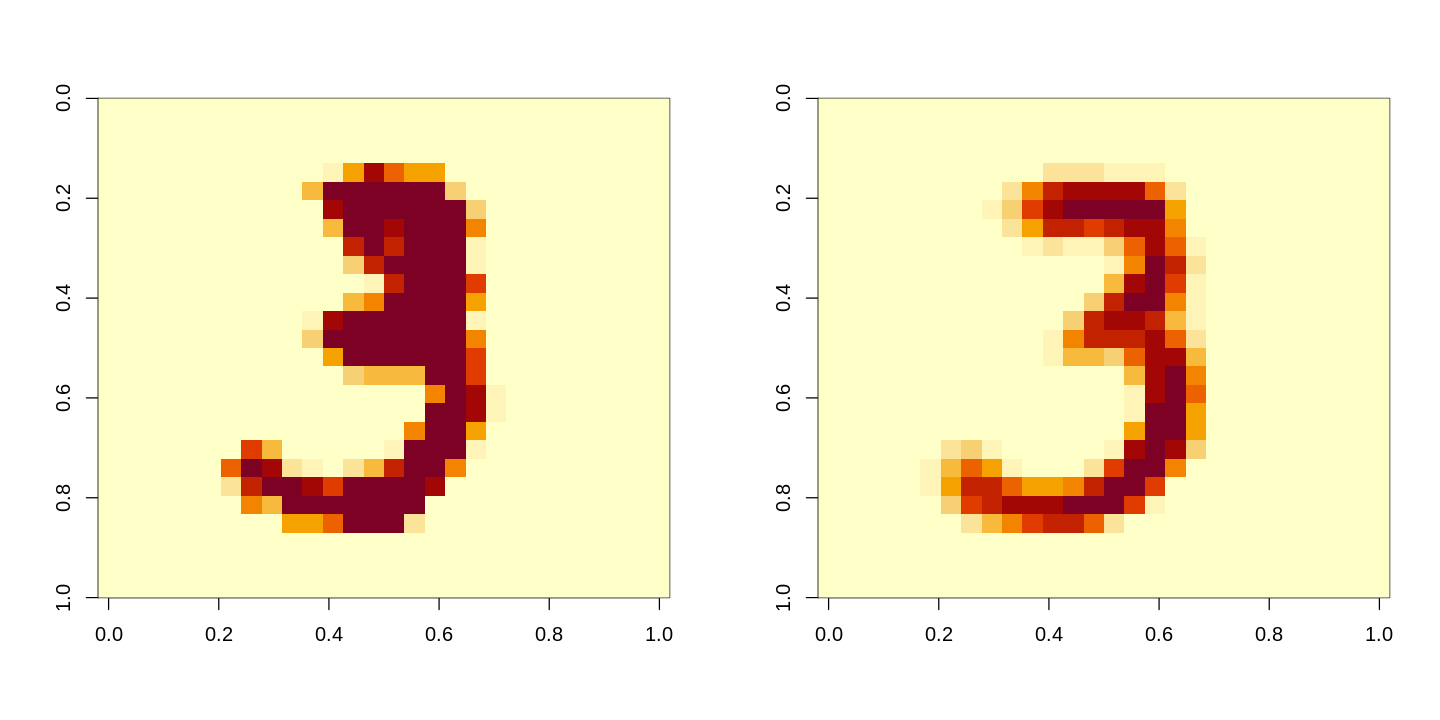

[1] "Epoch 91"
[1] "Training accuracy: 0.9054"
[1] "Validation accuracy: 0.898989898989899"


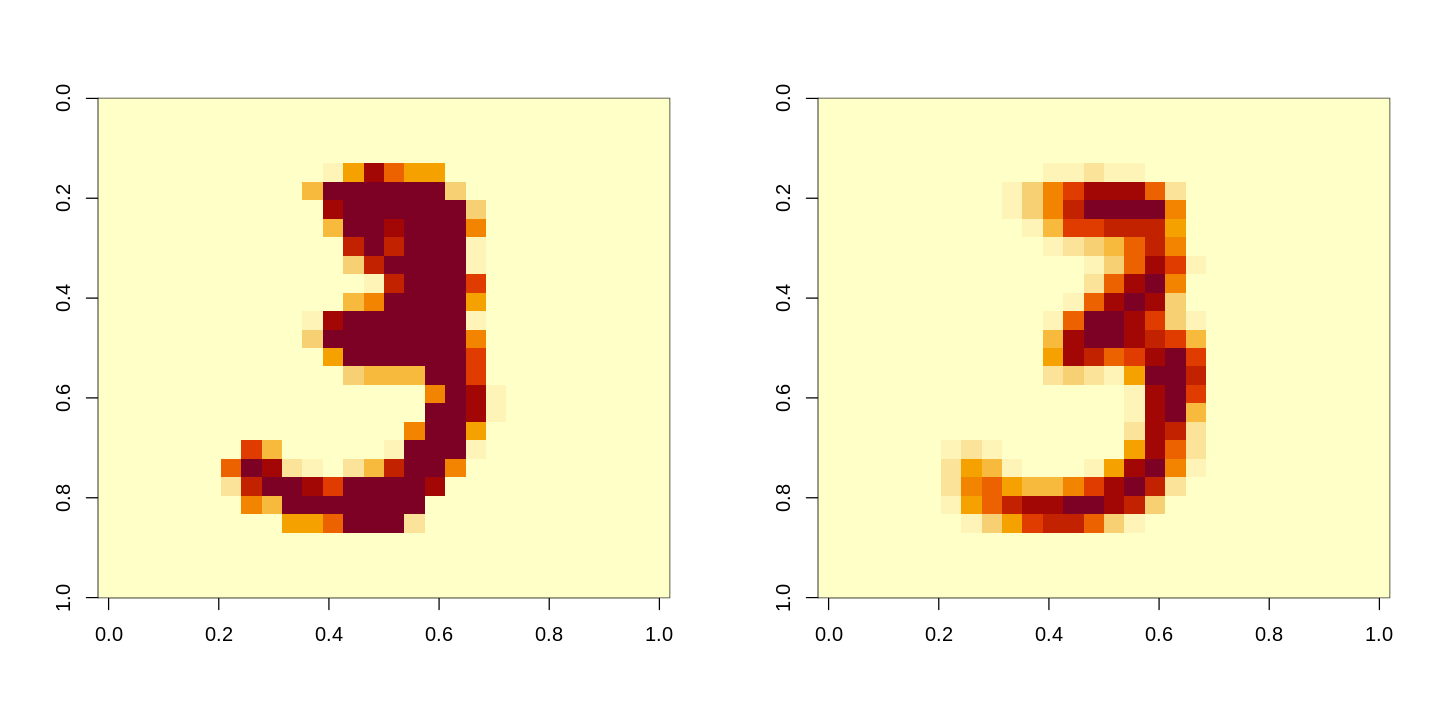

[1] "Epoch 92"
[1] "Training accuracy: 0.9045"
[1] "Validation accuracy: 0.898889888988899"


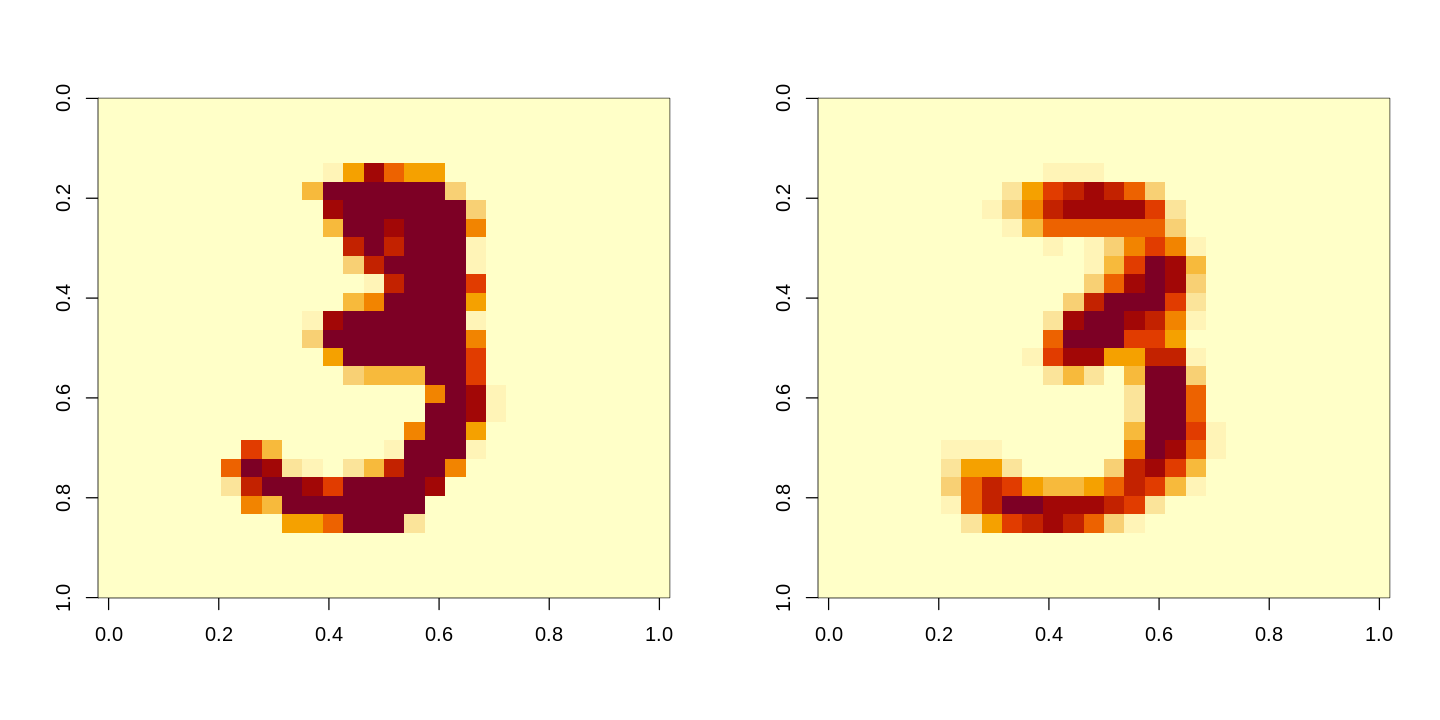

[1] "Epoch 93"
[1] "Training accuracy: 0.9055"
[1] "Validation accuracy: 0.898189818981898"


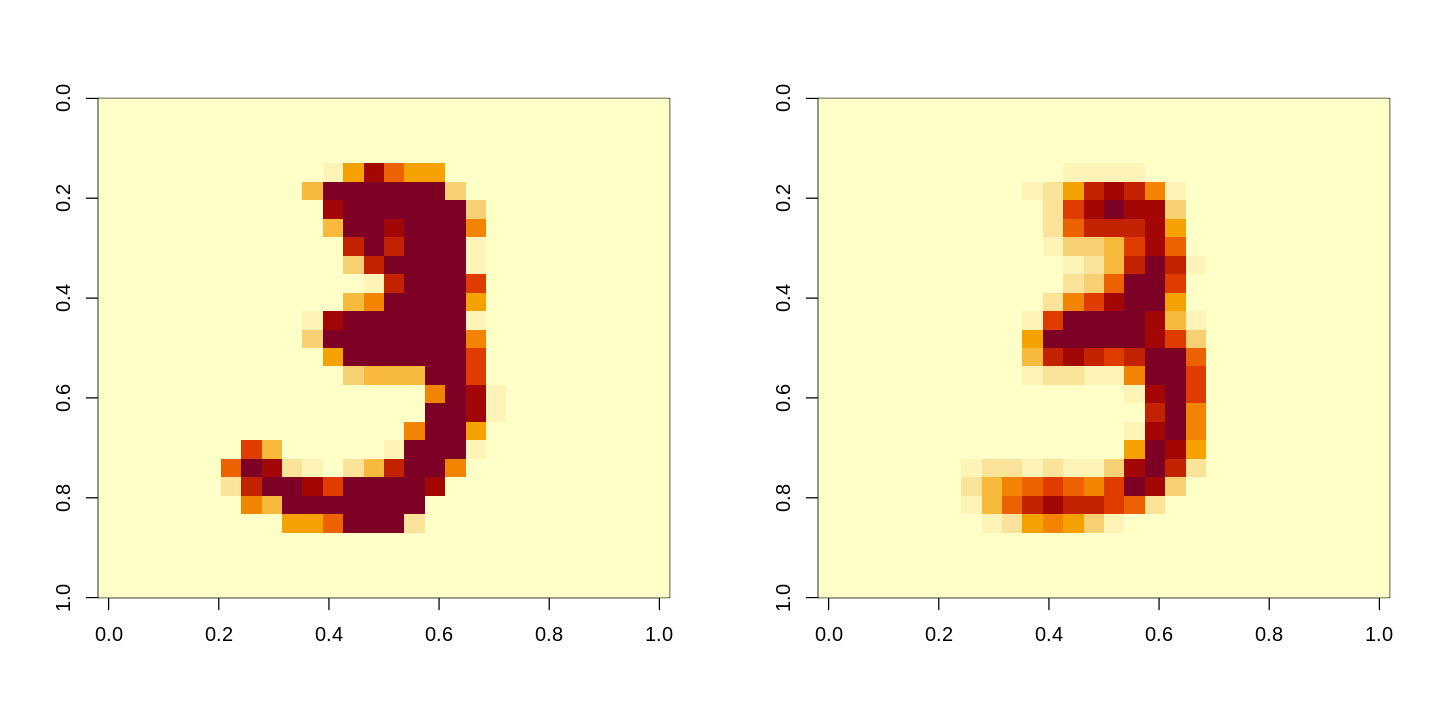

[1] "Epoch 94"
[1] "Training accuracy: 0.9046"
[1] "Validation accuracy: 0.899289928992899"


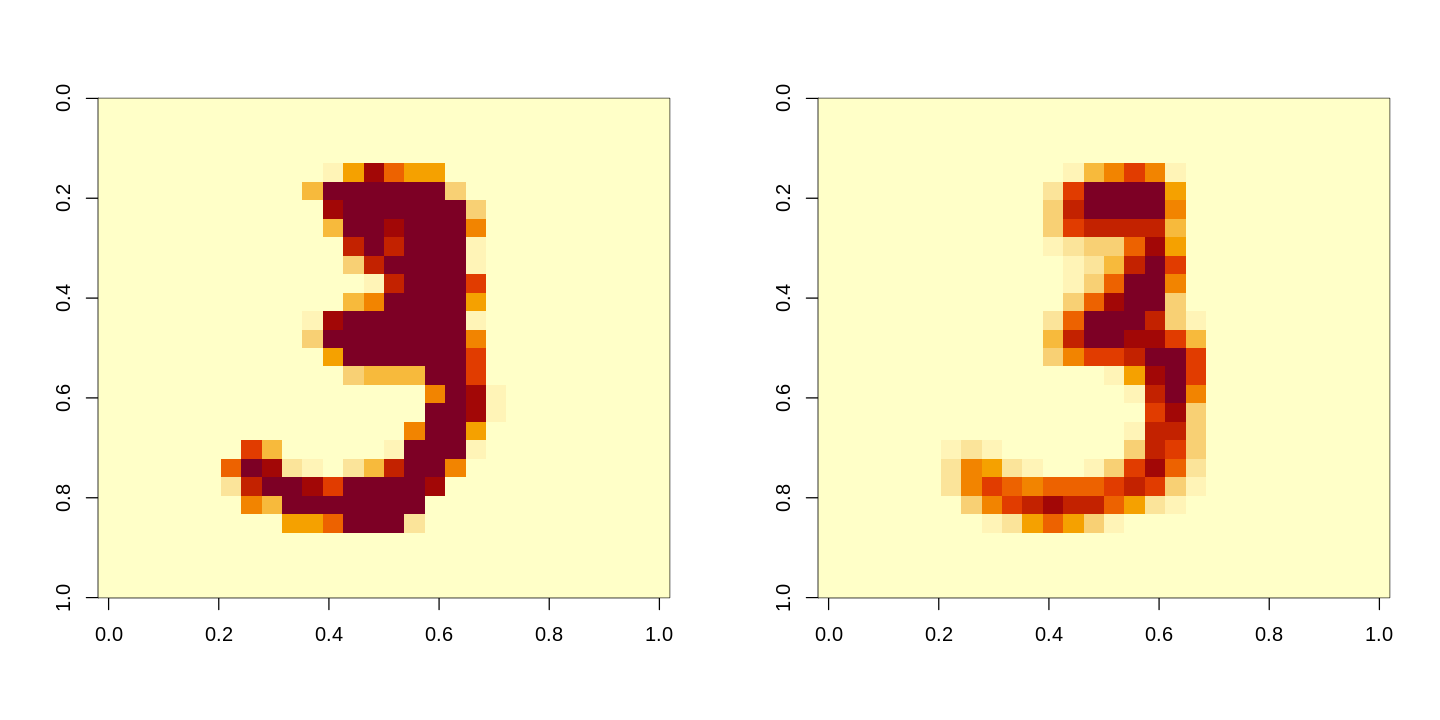

[1] "Epoch 95"
[1] "Training accuracy: 0.9063"
[1] "Validation accuracy: 0.8994899489949"


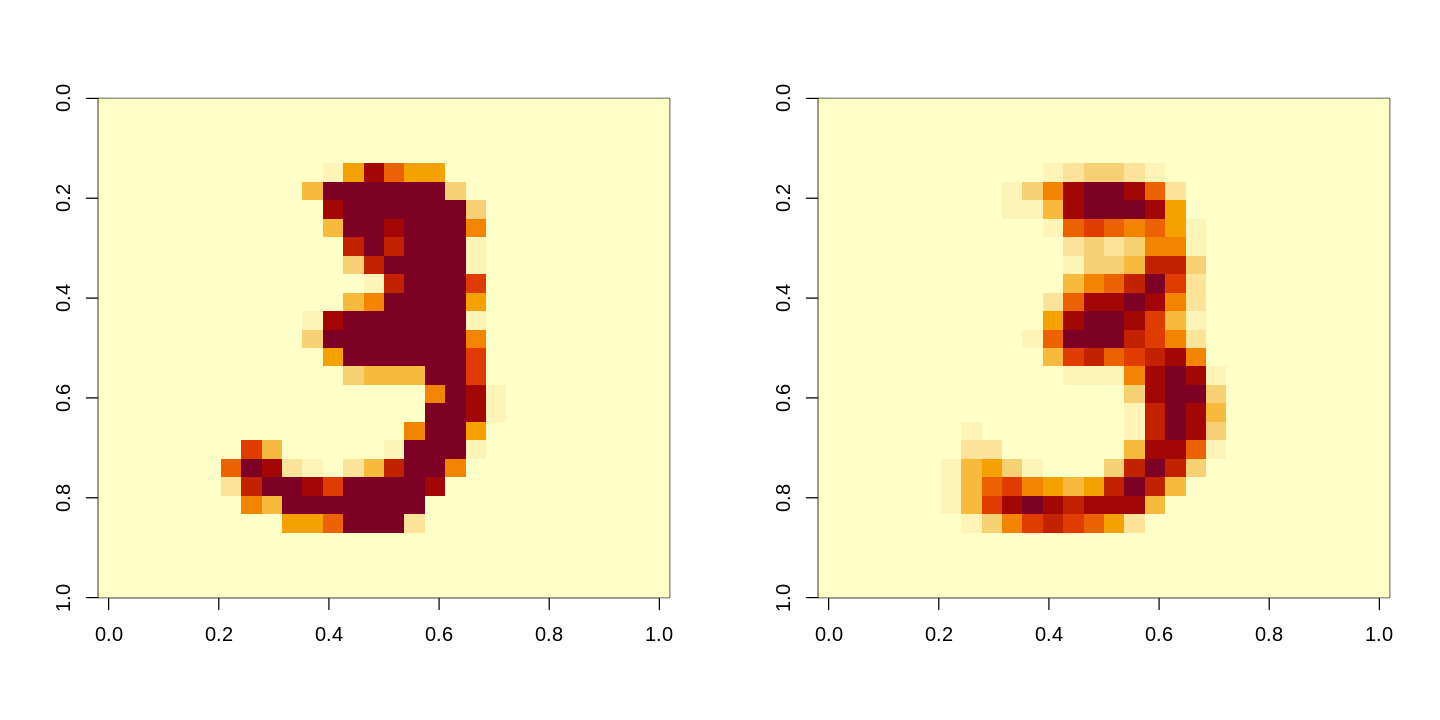

[1] "Epoch 96"
[1] "Training accuracy: 0.9062"
[1] "Validation accuracy: 0.8994899489949"


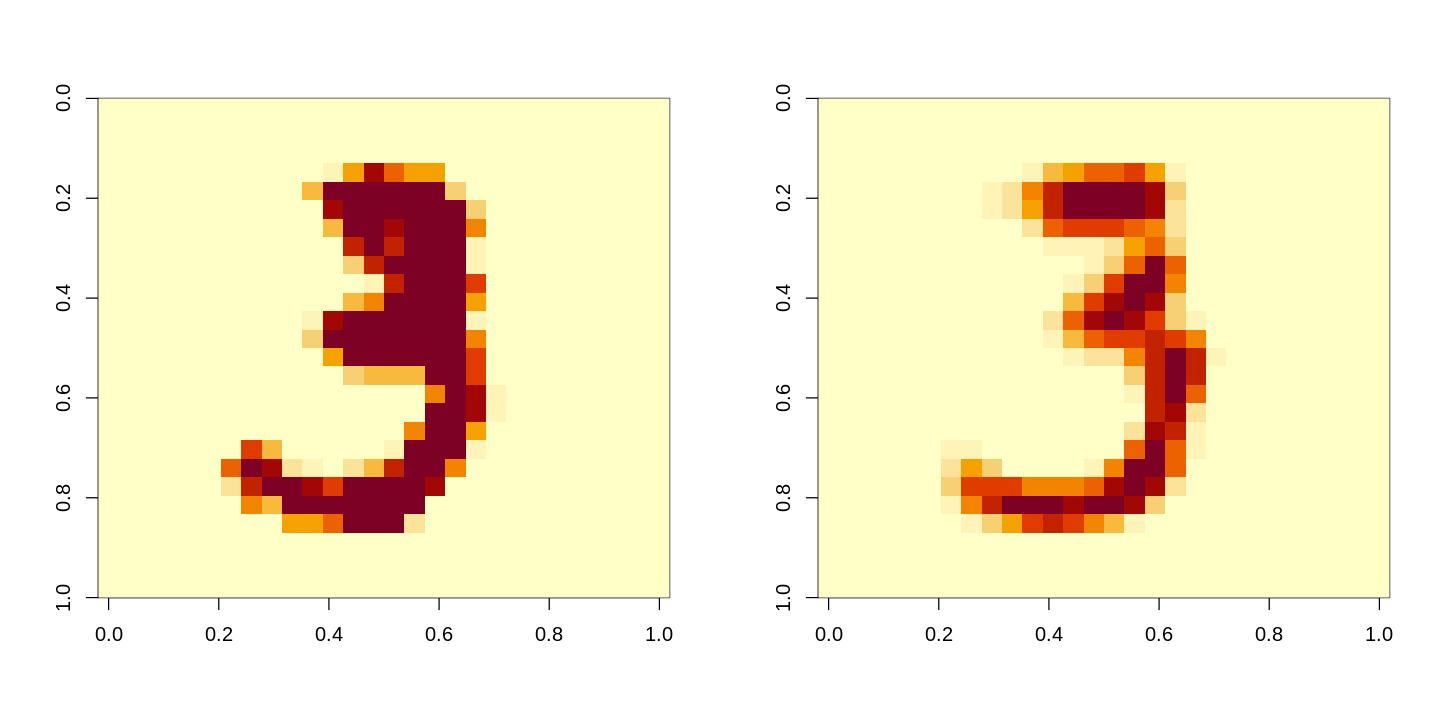

[1] "Epoch 97"
[1] "Training accuracy: 0.9054"
[1] "Validation accuracy: 0.9001900190019"


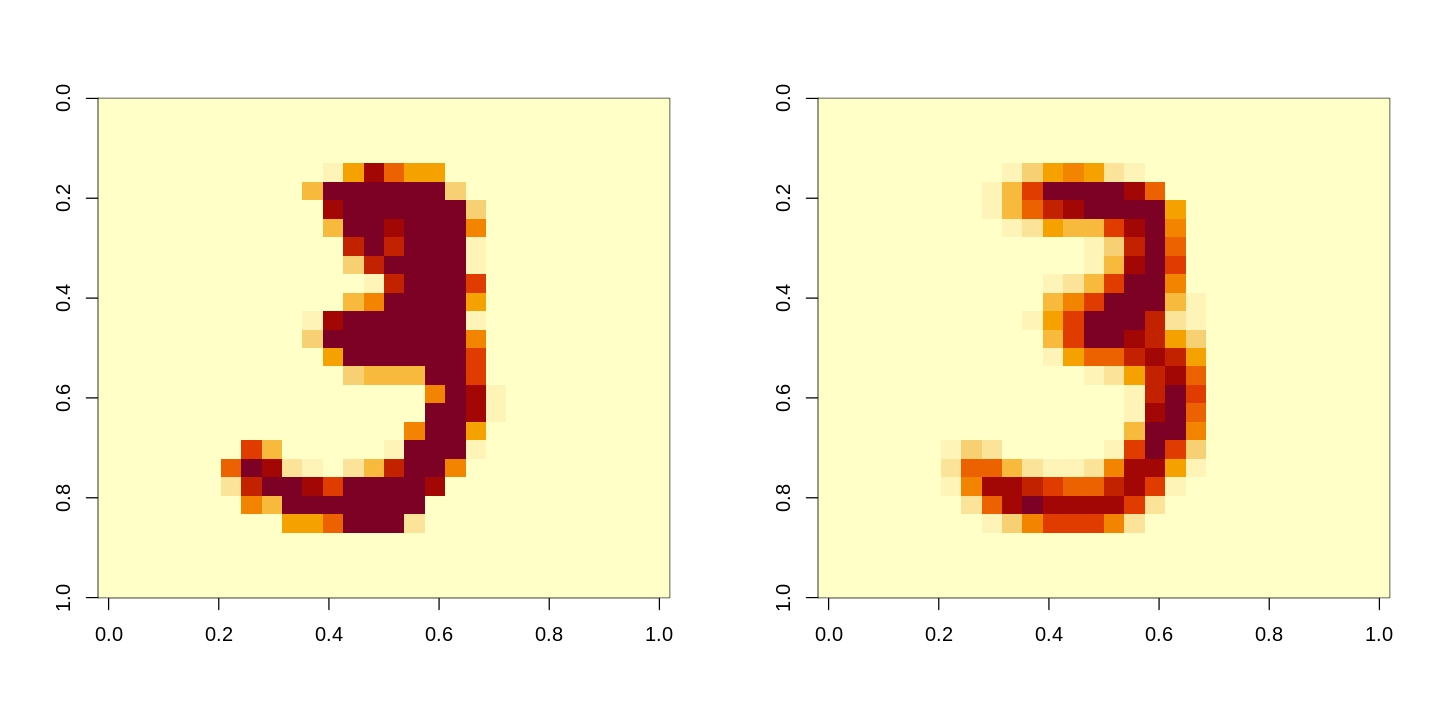

[1] "Epoch 98"
[1] "Training accuracy: 0.9068"
[1] "Validation accuracy: 0.9001900190019"


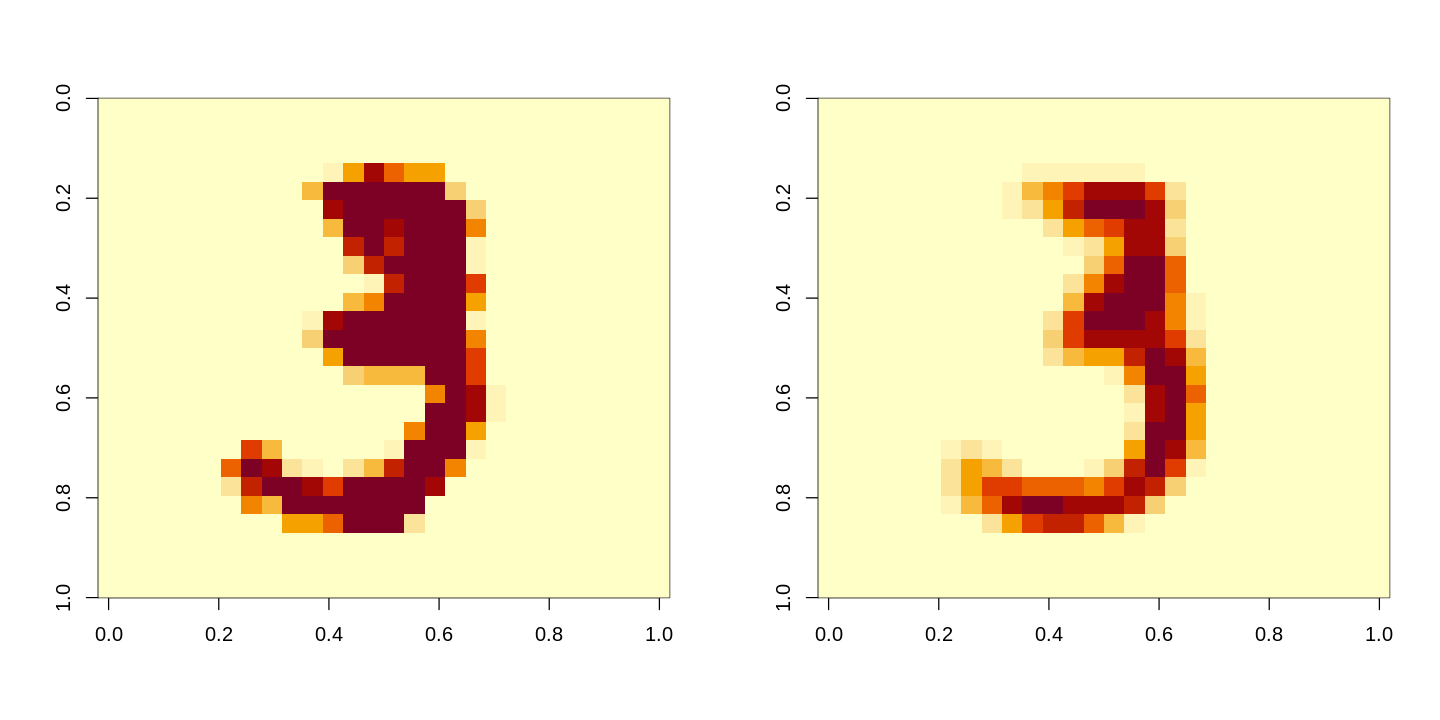

[1] "Epoch 99"
[1] "Training accuracy: 0.9062"
[1] "Validation accuracy: 0.898989898989899"


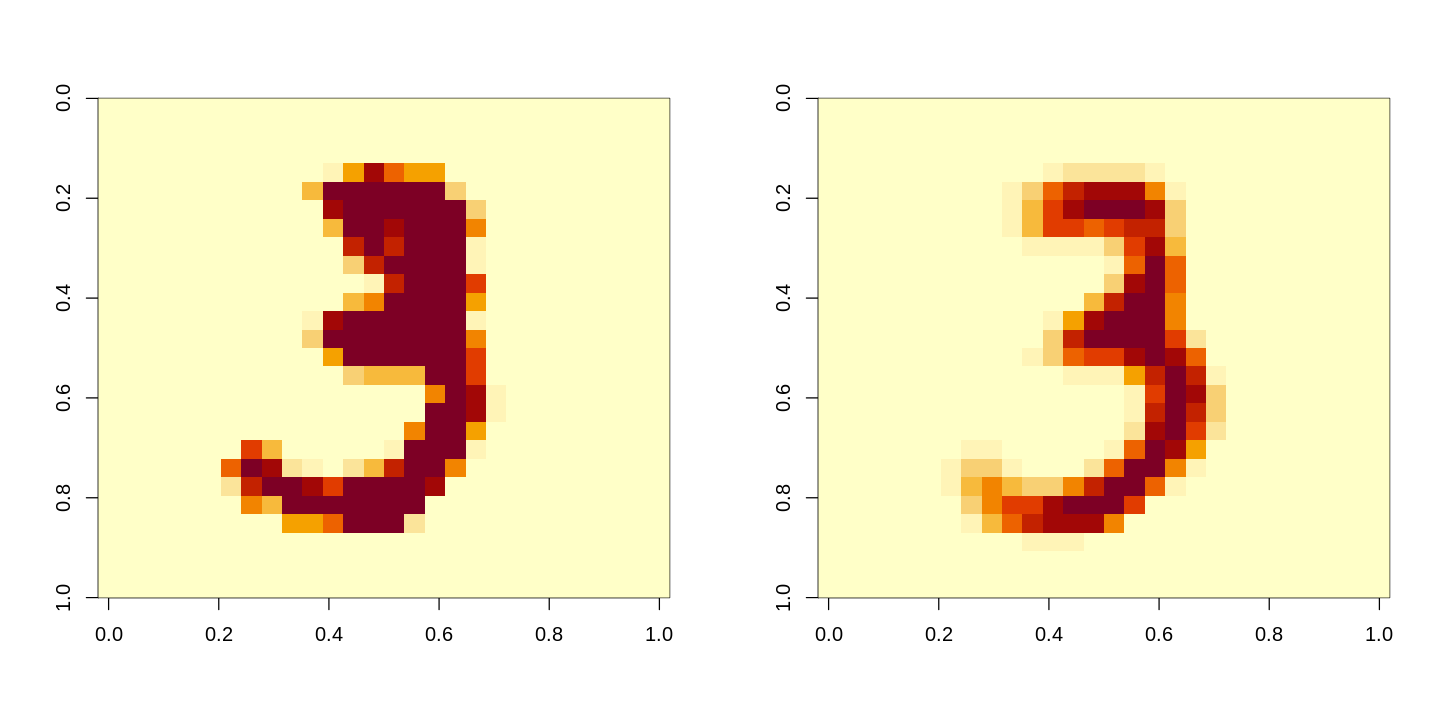

[1] "Epoch 100"
[1] "Training accuracy: 0.9063"
[1] "Validation accuracy: 0.898789878987899"


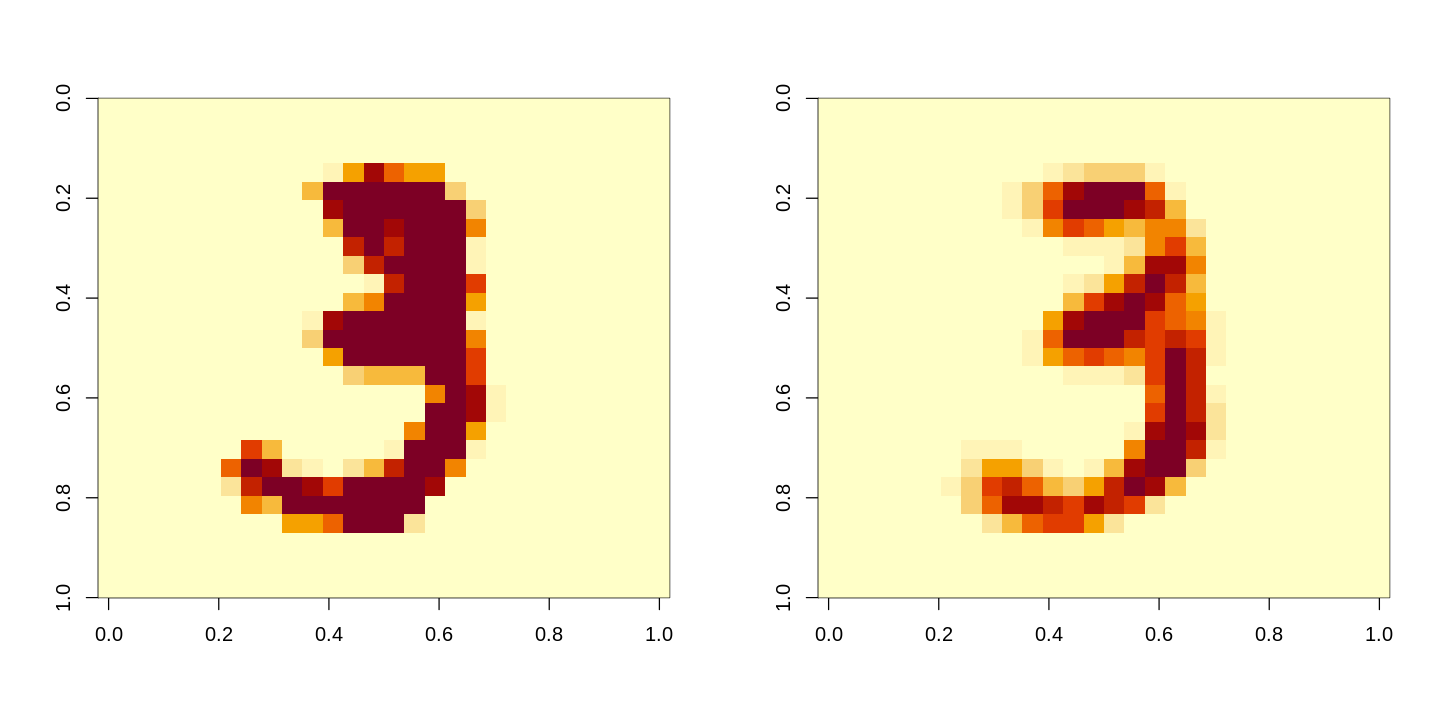

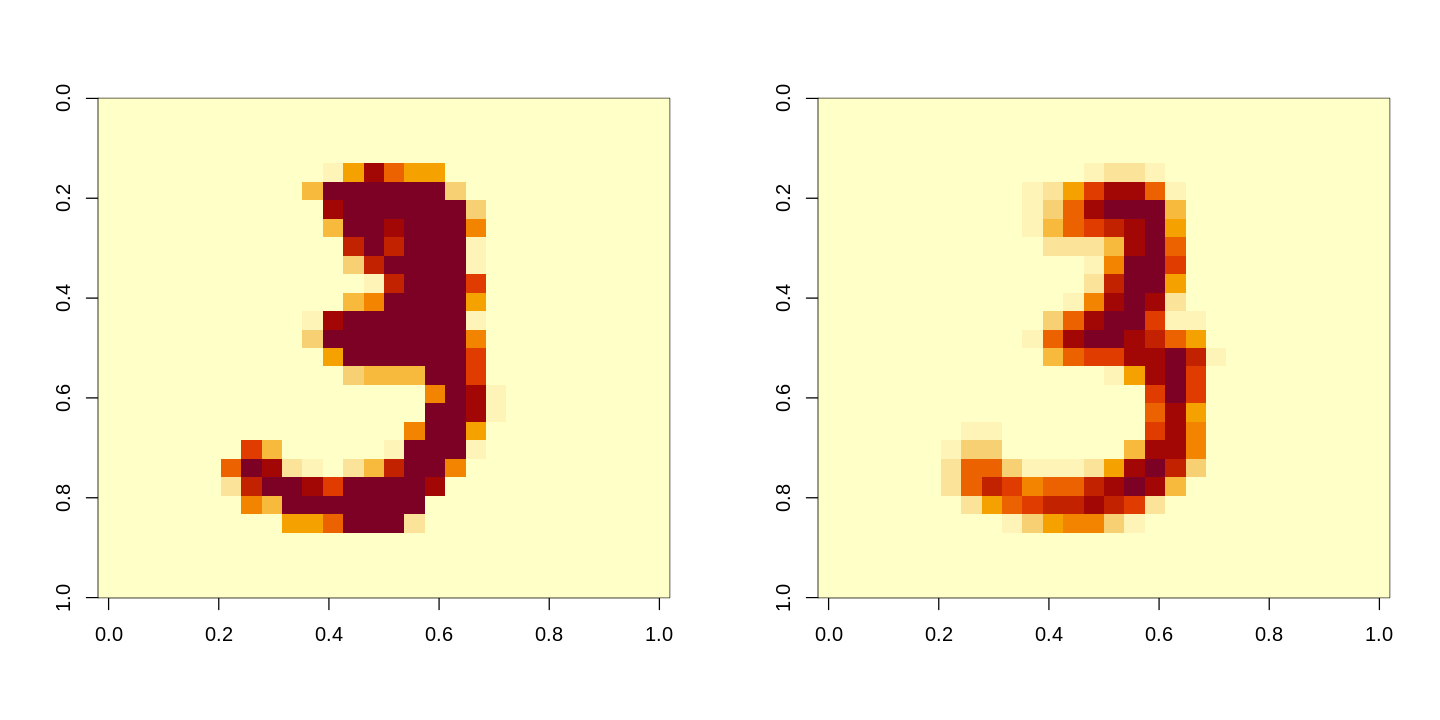

In [ ]:
rbm_gen_momentum = RBM_training(x = x_train, y = y_train,
                       n.hidden = 100, 
                       x_val = x_val, y_val = y_val, 
                       type = 'generative',
                       alpha = 0.01, 
                       lr = 0.01,
                       n.epoch = 100,
                       batch.size = 100, 
                       opt = 'Momentum', 
                       mu = 0.5, #for Momentum
                       beta1 = 0.9, #for Adam
                       beta2 = 0.999, #for Adam
                       eps = 1e-8, #for Adam
                       sample_rec = 5 #sample observation for inspecting reconstruction during Generative training
)

### Comparation

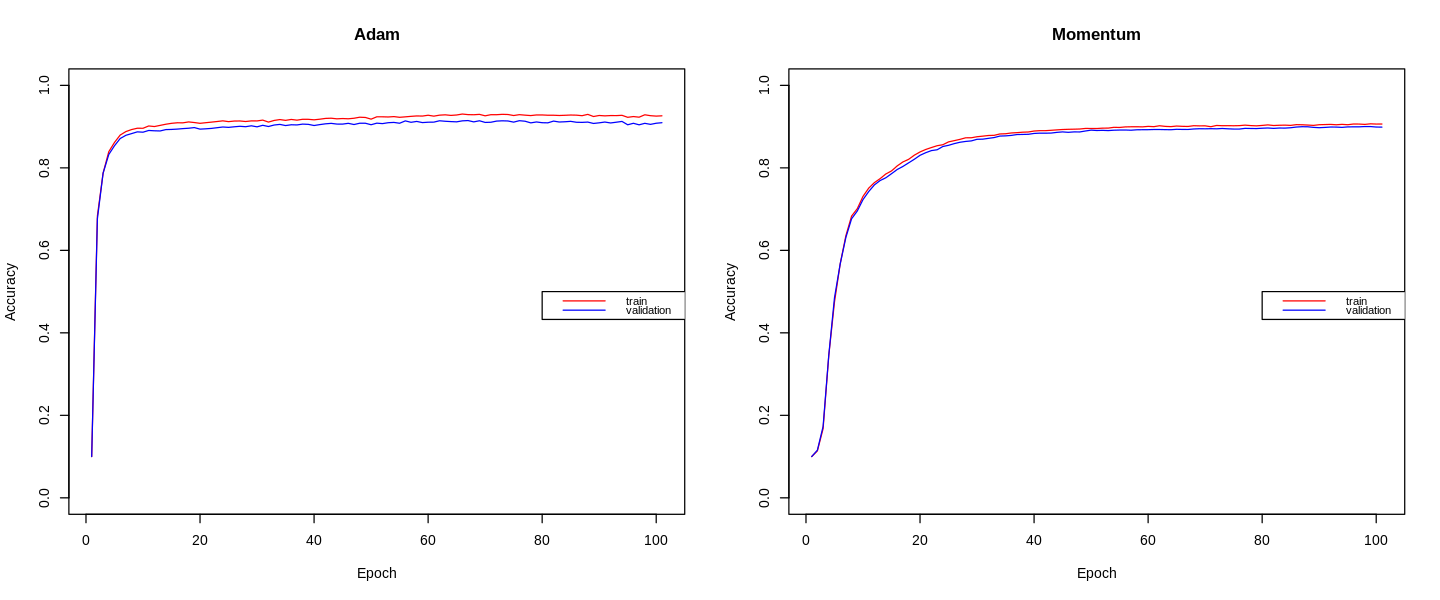

In [ ]:
#windows(10,3)
options(repr.plot.width=12, repr.plot.height=5)
par(mfrow=c(1,2), cex=0.7)
plot(c(0.1,rbm_gen_adam$train_acc), col = 'red', type = 'l', xlab = 'Epoch', ylab = 'Accuracy', ylim = c(0,1), main = 'Adam')
lines(c(0.1,rbm_gen_adam$val_acc), col = 'blue')
legend(80,0.5,legend=c("train","validation"), col=c("red","blue"), lty=c(1,1), cex=0.8)
plot(c(0.1,rbm_gen_momentum$train_acc), col = 'red', type = 'l', xlab = 'Epoch', ylab = 'Accuracy', ylim = c(0,1), main = 'Momentum')
lines(c(0.1,rbm_gen_momentum$val_acc), col = 'blue')
legend(80,0.5,legend=c("train","validation"), col=c("red","blue"), lty=c(1,1), cex=0.8)

## **Discriminative Objective**

In [ ]:
rbm_dis = RBM_training(x = x_train, y = y_train,
                       n.hidden = 100, 
                       x_val = x_val, y_val = y_val, 
                       type = 'discriminative',
                       alpha = 0.01, 
                       lr = 0.01,
                       n.epoch = 100,
                       batch.size = 100, 
                       opt = 'Adam', 
                       mu = 0.5, #for Momentum
                       beta1 = 0.9, #for Adam
                       beta2 = 0.999, #for Adam
                       eps = 1e-8, #for Adam
                       sample_rec = 27 #sample observation for inspecting reconstruction during Generative training
)

[1] "Epoch 1"
[1] "Training accuracy: 0.9308"
[1] "Validation accuracy: 0.91029102910291"
[1] "Epoch 2"
[1] "Training accuracy: 0.965"
[1] "Validation accuracy: 0.924092409240924"
[1] "Epoch 3"
[1] "Training accuracy: 0.9789"
[1] "Validation accuracy: 0.93049304930493"
[1] "Epoch 4"
[1] "Training accuracy: 0.9834"
[1] "Validation accuracy: 0.932193219321932"
[1] "Epoch 5"
[1] "Training accuracy: 0.9878"
[1] "Validation accuracy: 0.931193119311931"
[1] "Epoch 6"
[1] "Training accuracy: 0.992"
[1] "Validation accuracy: 0.933593359335934"
[1] "Epoch 7"
[1] "Training accuracy: 0.9945"
[1] "Validation accuracy: 0.933893389338934"
[1] "Epoch 8"
[1] "Training accuracy: 0.9961"
[1] "Validation accuracy: 0.936293629362936"
[1] "Epoch 9"
[1] "Training accuracy: 0.9971"
[1] "Validation accuracy: 0.935393539353935"
[1] "Epoch 10"
[1] "Training accuracy: 0.9978"
[1] "Validation accuracy: 0.937293729372937"
[1] "Epoch 11"
[1] "Training accuracy: 0.9983"
[1] "Validation accuracy: 0.937193719371937"
[

### Accuracy

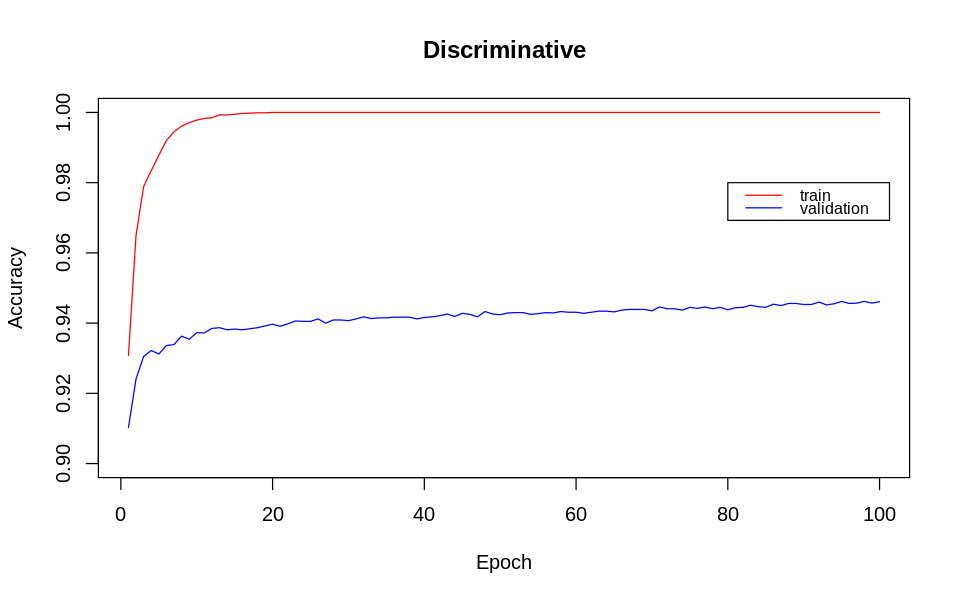

In [ ]:
options(repr.plot.width=8, repr.plot.height=5)
plot(c(rbm_dis$train_acc), col = 'red', type = 'l', xlab = 'Epoch', ylab = 'Accuracy', ylim = c(0.90,1), main = 'Discriminative')
lines(c(rbm_dis$val_acc), col = 'blue')
legend(80,0.98,legend=c("train","validation"), col=c("red","blue"), lty=c(1,1), cex=0.8)

## **Hybrid Objective**

In [ ]:
rbm_hyb = RBM_training(x = x_train, y = y_train, 
                       n.hidden = 100, 
                       x_val = x_val, y_val = y_val, 
                       type = 'hybrid',
                       alpha = 0.01, 
                       lr = 0.005,
                       n.epoch = 100,
                       batch.size = 100, 
                       opt = 'Adam', 
                       mu = 0.9, #for Momentum
                       beta1 = 0.9, #for Adam
                       beta2 = 0.999, #for Adam
                       eps = 1e-8, #for Adam
                       sample_rec = 27#sample observation for inspecting reconstruction during Generative training
)

[1] "Epoch 1"
[1] "Training accuracy: 0.8803"
[1] "Validation accuracy: 0.866986698669867"
[1] "Epoch 2"
[1] "Training accuracy: 0.9219"
[1] "Validation accuracy: 0.900790079007901"
[1] "Epoch 3"
[1] "Training accuracy: 0.9338"
[1] "Validation accuracy: 0.909290929092909"
[1] "Epoch 4"
[1] "Training accuracy: 0.9431"
[1] "Validation accuracy: 0.913691369136914"
[1] "Epoch 5"
[1] "Training accuracy: 0.9497"
[1] "Validation accuracy: 0.917391739173917"
[1] "Epoch 6"
[1] "Training accuracy: 0.9539"
[1] "Validation accuracy: 0.91979197919792"
[1] "Epoch 7"
[1] "Training accuracy: 0.9592"
[1] "Validation accuracy: 0.921092109210921"
[1] "Epoch 8"
[1] "Training accuracy: 0.9616"
[1] "Validation accuracy: 0.923592359235924"
[1] "Epoch 9"
[1] "Training accuracy: 0.9639"
[1] "Validation accuracy: 0.922692269226923"
[1] "Epoch 10"
[1] "Training accuracy: 0.9674"
[1] "Validation accuracy: 0.925792579257926"
[1] "Epoch 11"
[1] "Training accuracy: 0.9704"
[1] "Validation accuracy: 0.924692469246925

### Accuracy

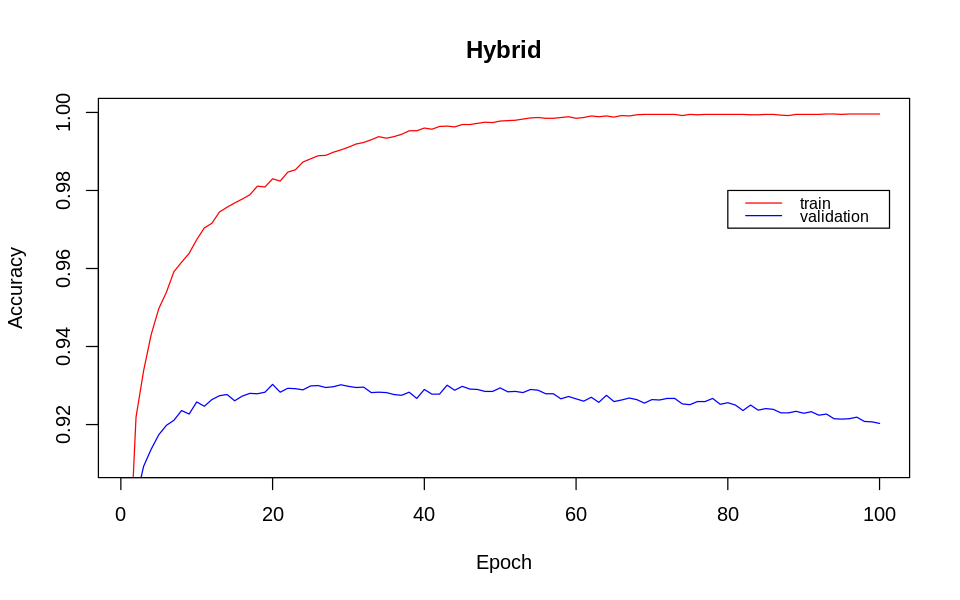

In [ ]:
options(repr.plot.width=8, repr.plot.height=5)
plot(c(rbm_hyb$train_acc), col = 'red', type = 'l', xlab = 'Epoch', ylab = 'Accuracy', ylim = c(0.91,1), main = 'Hybrid')
lines(c(rbm_hyb$val_acc), col = 'blue')
legend(80,0.98,legend=c("train","validation"), col=c("red","blue"), lty=c(1,1), cex=0.8)

## **Semi-supervised Learning**


### Used functions

In [ ]:
semiRBM <- function(x, y, paras, 
                    x_unlabel, 
                    n.hidden = 100, 
                    x_val, y_val, 
                    beta = 0.1, 
                    type = 'discriminative', #3 types: generative, discriminative and hybrid
                    alpha = 0.01, #for hybrid training
                    lr = 0.01,
                    n.epoch = 100,
                    batch.size = 100, 
                    opt = 'Adam', #3 types of optimizer: GD (gradient descent), Momentum and Adam
                    mu = 0.9, #for Momentum
                    beta1 = 0.9, #for Adam
                    beta2 = 0.999, #for Adam
                    eps = 1e-8 #for Adam
                    
){
  n = dim(x)[1]
  n_x = dim(x)[2]
  n_y = dim(y)[2]
  
  if (missing(paras)){
    h = rep(0, n_hidden)
    W = matrix(runif(n_hidden * n_x), nrow = n_hidden, ncol = n_x) / 100 - 0.5/100
    U = matrix(runif(n_hidden * n_y), nrow = n_hidden, ncol = n_y) / 100 - 0.5/100
    b = runif(n_x) / 100 - 0.5/100
    d = runif(n_y) / 100 - 0.5/100
    c = runif(n_hidden) / 100 - 0.5/100
  }
  else{
    n.hidden = length(paras$c)
    h = rep(0, n_hidden)
    W = paras$W
    U = paras$U
    b = paras$b
    c = paras$c
    d = paras$d
  }
  n_unlabel = dim(x_unlabel)[1]
  
  gradient = get(paste(type, 'gradient', sep="_", collapse = NULL))
  # initial values for optimizer
  m_W <- m_U <- m_b <- m_c <- m_d <-0
  v_W <- v_U <- v_b <- v_c <- v_d <-0
  u_W <- u_U <- u_b <- u_c <- u_d <-0
  
  train_acc = vector(mode='numeric')
  val_acc = vector(mode='numeric')
  
  for (i in 1:n.epoch){
    id <- mini_batch(n_unlabel, batch.size)
    for (k in 1:length(id)){
      x0 = x_unlabel[id[[k]],]
      n_b = dim(x0)[1]
      # Update parameters
      #Gradient of supervised part
      grad_sup = gradient(x, y, W, U, b, c, d, alpha)
      
      # Gradient of unsupervised part
      
      p_y_x = predictRBM(x=x0, paras = list(W = W, U = U, b = b, c = c, d = d))$prob
      y0 = t(apply(p_y_x, 1, function(x) fit_target(sample(1:n_y,1,prob = x), n_y)))
      
      h0 = t(sigm(W%*%t(x0) + U%*%t(y0)+ c))
      h0_s = (h0 > matrix(runif(n_hidden * n_b), n_b, n_hidden)) * 1
      
      p_y_h = t(apply(d + h0_s %*% U, 1, function(x) x-max(x)))
      p_y_h = t(apply(exp(p_y_h), 1, function(x) x/sum(x)))
      p_y_h_c = t(apply(p_y_h, 1, cumsum))
      y1 = t(apply(p_y_h, 1, function(x) fit_target(sample(1:10,1,prob = x), n_y)))
      #y1 = rowSums(p_y_h_c < runif(n_b)) + 1
      #y1 = fit_target(y1, n_y)
      #y1 = p_y_h
      p_x_h = sigm(b + h0_s %*% W)
      #x1 = (p_x_h > matrix(runif(n_x * n), n_b, n_x)) * 1 
      x1 = p_x_h
      h1 = t(sigm(W%*%t(x1) + U%*%t(y1)+ c))
      
      theta = W%*%t(x0)+ c
      
      second_term_c = matrix(0,n_hidden,n_y)
      second_term_WU = matrix(0,n_b,n_hidden)
      
      for (m in 1:n_y){
        y_s = matrix(0,n_b,n_y)
        y_s[,m]= 1
        h_yx = t(sigm(theta + U%*%t(y_s)))
        sc = h_yx * p_y_x[,m]
        second_term_c[,m] = colSums(sc)
        second_term_WU = second_term_WU + sc
      }
      
      
      grad_unsup_W = (t(h1)%*%x1 - t(second_term_WU)%*%x0) / n_b
      grad_unsup_U = (t(h1)%*%y1 - t(second_term_WU)%*%y0) / n_b
      grad_unsup_b = colSums(x1 - x0) / n_b
      grad_unsup_d = colSums(y1 - p_y_x) / n_b
      grad_unsup_c = (colSums(h1) - rowSums(second_term_c)) / n_b
      
      grad = list(grad_W = grad_sup$grad_W  + beta * grad_unsup_W,
                  grad_U = grad_sup$grad_U  + beta * grad_unsup_U,
                  grad_b = grad_sup$grad_b  + beta * grad_unsup_b,
                  grad_c = grad_sup$grad_c  + beta * grad_unsup_c,
                  grad_d = grad_sup$grad_d  + beta * grad_unsup_d)
      
      if (opt == 'Adam'){
        m_W = beta1*m_W + (1-beta1)*grad$grad_W
        mt_W = m_W / (1-beta1^i)
        v_W = beta2*v_W + (1-beta2)*(grad$grad_W^2)
        vt_W = v_W / (1-beta2^i)
        u_W = -lr * mt_W / (sqrt(vt_W) + eps)
        
        m_U = beta1*m_U + (1-beta1)*grad$grad_U
        mt_U = m_U / (1-beta1^i)
        v_U = beta2*v_U + (1-beta2)*(grad$grad_U^2)
        vt_U = v_U / (1-beta2^i)
        u_U = -lr * mt_U / (sqrt(vt_U) + eps)
        
        m_b = beta1*m_b + (1-beta1)*grad$grad_b
        mt_b = m_b / (1-beta1^i)
        v_b = beta2*v_b + (1-beta2)*(grad$grad_b^2)
        vt_b = v_b / (1-beta2^i)
        u_b = -lr * mt_b / (sqrt(vt_b) + eps)
        
        m_c = beta1*m_c + (1-beta1)*grad$grad_c
        mt_c = m_c / (1-beta1^i)
        v_c = beta2*v_c + (1-beta2)*(grad$grad_c^2)
        vt_c = v_c / (1-beta2^i)
        u_c = -lr * mt_c / (sqrt(vt_c) + eps)
        
        m_d = beta1*m_d + (1-beta1)*grad$grad_d
        mt_d = m_d / (1-beta1^i)
        v_d = beta2*v_d + (1-beta2)*(grad$grad_d^2)
        vt_d = v_d / (1-beta2^i)
        u_d = -lr * mt_d / (sqrt(vt_d) + eps)
        
      }
      
      else if (opt == 'GD'){
        u_W = - lr * grad$grad_W
        u_U = - lr * grad$grad_U
        u_b = - lr * grad$grad_b
        u_d = - lr * grad$grad_d
        u_c = - lr * grad$grad_c
      }
      
      
      else if (opt == 'Momentum'){
        u_W = mu * u_W - lr * grad$grad_W
        u_U = mu * u_U - lr * grad$grad_U
        u_b = mu * u_b - lr * grad$grad_b
        u_d = mu * u_d - lr * grad$grad_d
        u_c = mu * u_c - lr * grad$grad_c
      }
      
      W = W + u_W
      U = U + u_U
      b = b + u_b
      c = c + u_c
      d = d + u_d
      
    }
    print(paste('Epoch', i, sep = " "))
    #Training accuracy
    pred = predictRBM(x, y, list(W = W, U = U, b = b, c = c, d = d))
    train_acc = append(train_acc, pred$accuracy)
    print(paste('Training accuracy:', tail(train_acc,1)/n))
    
    #Validation acurracy
    if(!missing(x_val)){
      pred = predictRBM(x_val, y_val, list(W = W, U = U, b = b, c = c, d = d))
      val_acc = append(val_acc, pred$accuracy)
      print(paste('Validation accuracy:', tail(val_acc,1)/dim(x_val)[1]))
    }
  }
  paras = list(W = W, U = U, b = b, c = c, d = d)
  return(list(paras = paras,
              train_acc = train_acc,
              val_acc = val_acc))
}

### Initialize parameters

In [ ]:
n_hidden = 100
n_x = dim(x_train)[2]
n_y = dim(y_train)[2]

h = rep(0, n_hidden)
W = matrix(runif(n_hidden * n_x), nrow = n_hidden, ncol = n_x) / 100 - 0.5/100
U = matrix(runif(n_hidden * n_y), nrow = n_hidden, ncol = n_y) / 100 - 0.5/100
b = runif(n_x) / 100 - 0.5/100
d = runif(n_y) / 100 - 0.5/100
c = runif(n_hidden) / 100 - 0.5/100
paras = list(W = W, U = U, b = b, c = c, d = d)

### Training

In [ ]:
rbm_semi = semiRBM(x = x[1:1000,], target_transform(y)[1:1000,], paras = paras, 
                   x_unlabel = x[1001:50000,], 
                   n.hidden = 100, 
                   x_test, y_test, 
                   beta = 0.1,
                   type = 'hybrid', #3 types: generative, discriminative and hybrid
                   alpha = 0.1, #for hybrid training
                   lr = 0.005,
                   n.epoch = 20,
                   batch.size = 1000, 
                   opt = 'Adam', #3 types of optimizer: GD (gradient descent), Momentum and Adam
                   mu = 0.5, #for Momentum
                   beta1 = 0.9, #for Adam
                   beta2 = 0.999, #for Adam
                   eps = 1e-12 #for Adam
                   
)

[1] "Epoch 1"
[1] "Training accuracy: 0.137"
[1] "Validation accuracy: 0.1304"
[1] "Epoch 2"
[1] "Training accuracy: 0.58"
[1] "Validation accuracy: 0.5402"
[1] "Epoch 3"
[1] "Training accuracy: 0.731"
[1] "Validation accuracy: 0.6787"
[1] "Epoch 4"
[1] "Training accuracy: 0.795"
[1] "Validation accuracy: 0.7431"
[1] "Epoch 5"
[1] "Training accuracy: 0.831"
[1] "Validation accuracy: 0.7796"
[1] "Epoch 6"
[1] "Training accuracy: 0.845"
[1] "Validation accuracy: 0.8009"
[1] "Epoch 7"
[1] "Training accuracy: 0.86"
[1] "Validation accuracy: 0.8131"
[1] "Epoch 8"
[1] "Training accuracy: 0.871"
[1] "Validation accuracy: 0.8231"
[1] "Epoch 9"
[1] "Training accuracy: 0.881"
[1] "Validation accuracy: 0.8316"
[1] "Epoch 10"
[1] "Training accuracy: 0.887"
[1] "Validation accuracy: 0.8384"
[1] "Epoch 11"
[1] "Training accuracy: 0.895"
[1] "Validation accuracy: 0.8434"
[1] "Epoch 12"
[1] "Training accuracy: 0.903"
[1] "Validation accuracy: 0.8501"
[1] "Epoch 13"
[1] "Training accuracy: 0.907"
[1] "